<a href="https://colab.research.google.com/github/amithadar88/FinalProjectAVertto/blob/main/Final_code_3_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
try:
  import nptdms
except:
  !pip install npTDMS
  !pip install xlrd
  !pip install neurokit2
  !pip install torchsampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for npTDMS: filename=npTDMS-1.7.1-py3-none-any.whl size=104706 sha256=f0f9704003cb047a6ca6921d18f35eb624e7404b92868f320eae9a8dd5993cc7
  Stored in directory: /root/.cache/pip/wheels/b9/89/0c/a24d431db71199dab9edf2f2d08fb52028acb953191abfdec9
Successfully built npTDMS
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Imports

In [ ]:
from nptdms import TdmsFile
import pickle

import time
import math
from glob import glob
from tqdm.notebook import tqdm as tqdm
import os
from matplotlib import pyplot as plt

from os.path import join
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
import scipy.signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.signal import hilbert,resample

import multiprocessing
from functools import partial
import neurokit2 as nk

import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.utils.data as data
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torchvision import transforms
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import torch.fft as fft

from sklearn.model_selection import StratifiedKFold
import gc

from typing import Optional
from torch import Tensor
import random

from pathlib import Path
import torchvision.models as models
import xml.etree.ElementTree as ET

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Configurations


In [ ]:
class CFG:
  experiment = 30
  under_sampling = True
  resume_training_experiment = False
  torch_sampler = False
  leave_one_out = True

  # on which labels we want to train the model
  new_labels = False
  old_labels = True
  with_out_reem_labels = True
  all_labels = new_labels and old_labels

  balanced_factor = 4
  # Using r' before the string is necessary if the path contain whitespaces
  #BELINSON_DATA_PATH = r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON'
  data_paths = r'/content/drive/MyDrive/Ramzor_Data'
  #ramzor_xml_files = glob(os.path.join(data_paths, 'Ramzor_labels/*/*.xml'))
  all_ramzor_xml_files = glob(os.path.join(data_paths, 'Ramzor_labels*/*/*.xml'))
  all_records_paths = glob(os.path.join(data_paths, '*/*/*/*.pkl'))# + glob(os.path.join(data_paths, 'GMC/*/*/*.pkl')) + glob(os.path.join(data_paths, 'BELINSON/*/*/*.pkl'))

  read_numpy_files = True
  sample_rate = 10_000
  under_sample_factor = 10 # We did an undearsampling for the orignal data
  ppg_preprocess = False
  #Training Configuration
  epochs = 500
  loss_func = 'CELoss' #'BCELoss' #'BinaryFocalLossWithLogits'# #'BCEWithLogitsLoss'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  batch_size = 64
  threshold = 0.5
  report = True
  models_directory ='.'
  create_3_labels = True
  create_binary_labels = False

  # Models Configuration
  models = ['CNN', 'smallerCNN', 'CNN_LSTM','TransformerCNN','ClassifierCNN','CNN_FFT']
  model_name = 'ClassifierCNN'
  num_features = 6
  output_dim = 3 if create_3_labels else 6
  segment_size = 20_000
  pos_weight = 1
  print_freq = 5
  num_workers = 2
  scheduler = 'CosineAnnealingLR' #'ReduceLROnPlateau'#"CosineAnnealingLR"
  T_max = 5
  lr = 1e-3
  min_lr = 1e-7
  weight_decay = 1e-5
  gradient_accumulation_steps = 1
  max_grad_norm = 1000
  factor = 0.2
  patience = 1
  eps = 1e-7
  seed = 42
  n_fold = 5
  trn_fold = [0] #[0,1,2,3,4]
  model_kwargs = { 'CNN' : {} , 'smallerCNN' : {}, 'CNN_LSTM' : [],'TransformerCNN' : {},'ClassifierCNN' : {},'CNN_FFT' : {}}[model_name] #parameters for models

  train = True
  test = True
  test_on_val = True
  DEBUG = False
  if DEBUG:
      epochs = 2


## Read Labels from XML

In [ ]:
# If we want to remove Reem files
if CFG.with_out_reem_labels:
  CFG.all_ramzor_xml_files = [path for path in CFG.all_ramzor_xml_files if 'Reem' not in path]

# Use only new labels
if CFG.all_labels:
  CFG.ramzor_xml_files = CFG.all_ramzor_xml_files
else: # not CFG.all_labels
  if CFG.new_labels:
   CFG.ramzor_xml_files = [path for path in CFG.all_ramzor_xml_files if '2nd_part'  in path]

  elif CFG.old_labels:
    CFG.ramzor_xml_files =[path for path in CFG.all_ramzor_xml_files if '2nd_part' not in path]



In [ ]:
#Checking that we use the correct files
print(len(CFG.ramzor_xml_files))
CFG.ramzor_xml_files

4


['/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/amit_hadar/annotations.xml',
 '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/amit_gavish/annotations.xml',
 '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/shirley/annotations.xml',
 '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/Noa_Gelber/annotations.xml']

In [ ]:
df_list = []

# iterate over the XML files
for file_name in CFG.ramzor_xml_files:
    # parse the XML file
    tree = ET.parse(file_name)
    root = tree.getroot()

    # iterate over the image tags
    for image in root.findall('./image'):
        #image_name = image.attrib["name"]

        # image_id = image_tag.get('id')
        image_name = image.get('name')
        tag = image.find("./tag")
        if tag is not None:
            label = tag.attrib.get("label")
            #source = tag.attrib.get("source")

            components = image_name.split('_')

            patient_name = components[0]
            record = components[1] + '_' + components[2]
            if components[3] == 'c':
              channel = components[4]
            else:
              record += '_' + components[3]
              channel = components[5]
            start_sample = components[-2]
            end_sample = components[-1].split('.')[0]
            # if int(start_sample) > 100_000 and '2nd_part' in file_name:

            #   start_sample = int(start_sample) //CFG.under_sample_factor
            #   end_sample = int(end_sample) // CFG.under_sample_factor

            labels_data = {
                "image_name" : image_name,
                "Patient": patient_name,
                "Record": record,
                "Channel": channel,
                "Start Sample": start_sample,
                "End Sample": end_sample,
                "Label": label,
            }

            df_list.append(labels_data)

df = pd.concat([pd.DataFrame(df_list)])


In [ ]:
df['Patient'].value_counts()

BE005    7011
BE003    3690
BE002     803
BE001     132
Name: Patient, dtype: int64

## Create Dirs

In [ ]:
models_path = f"/content/drive/MyDrive/ramozor_training_students/experiment_{CFG.experiment}/Models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
SAVEDIR = Path(models_path)

log_path = f"/content/drive/MyDrive/ramozor_training_students/experiment_{CFG.experiment}/logs"
if not os.path.exists(log_path):
    os.makedirs(log_path)

## Init logger

In [ ]:
def init_logger(log_file=  log_path +'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

LOGGER = init_logger(log_file=log_path +'/inference.log') if not CFG.train else init_logger()

## Utils


In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # using f1 Score
    score = f1_score(y_true, y_pred, average='weighted')
    return score

def convert_tdms_to_df(path, verbose = 1):
  '''
  path: string to tdms file
  verbose: print the dataframe - 1/0
  Return: pandas dataframe
  '''
  tdms_file = TdmsFile(path)
  df = tdms_file['Analog'].as_dataframe()
  if verbose:
    display(df.iloc[:100_000,:])

  return df


def normalize_data(data):
  return stats.zscore(data, axis=0)

def apply_filter_and_normalization(df):
  #Get dataframe - > Return : filterd and normalize dataframe
  current_slice_numpy = df.to_numpy().T
  filtered_data = filter_data(current_slice_numpy).T
  normalized_filtered_data = normalize_data(filtered_data)
  filtered_normalized_df = pd.DataFrame(normalized_filtered_data)
  return filtered_normalized_df

def read_pickle_file_to_df(file_path):
    with open(file_path, "rb") as pkl_file:
        data = pickle.load(pkl_file)
    return pd.DataFrame(data['Analog'])

def read_tdms_file(path):
  return TdmsFile.read(path)

def plot_dataframe_individual_channels(df):
  df.plot(subplots=True, legend=False)
  plt.show()

def get_peaks(ecg, verbose = 0):
    '''
    Args:
      ecg : signal data frame
      verbose: Plot EGC or Not - 0/1

    Return:
      Is invert boolean , Numpy array off all picks

    '''
    ecg_fixed, is_inverted = nk.ecg_invert(ecg, show= verbose)
    _, peaks = nk.ecg_peaks(ecg_fixed)
    return is_inverted, peaks['ECG_R_Peaks']


def preprocess_data(data):
  for i in range(CFG.num_features):
    #self.flip_channel(i)
    data[:, i] = nk.ppg_clean(data[:, i], method='elgendi',sampling_rate=CFG.sample_rate)
  return data

def _filter_data(data, wn , filttype = 'high'):
    b,a = butter(2,wn,filttype)
    cur_data_filt = filtfilt(b, a, data)
    return cur_data_filt

def filter_data(data, NyqFreq = 500):
  #Apply filters consecutivley
  # Get matrix data -> Return: filtered data

  wn_fillter_types = [(0.5/NyqFreq , 'high'),
                      (100/NyqFreq , 'low'),
                      (np.array([45,55]) / NyqFreq , 'stop'),
                      (np.array([90,110]) / NyqFreq , 'stop'),
                      (np.array([140,160]) / NyqFreq , 'stop')]

  for wn, fillter_type in wn_fillter_types:
    data = _filter_data(data, wn = wn, filttype = fillter_type)

  return data

def zscore_normalize(data):
  return stats.zscore(data, axis=0)


def zscore_xnan(data):
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    return (data - mean) / std

def clean_signal(x, th_high = 5, th_low = 0.2):

    #Automaticly Remove high amplitude waves

    x_clean = np.copy(x)
    min_stable_dur = round(CFG.sample_rate * 2)
    ol_h = np.abs(hilbert(x)) > th_high
    start_high = np.flatnonzero(np.diff(np.concatenate(([0], ol_h))) == 1)
    stop_high = np.flatnonzero(np.diff(np.concatenate((ol_h, [0]))) == -1)
    ol_l = np.abs(hilbert(x)) > th_low
    start_low = np.flatnonzero(np.diff(np.concatenate(([0], ol_l))) == 1)
    stop_low = np.flatnonzero(np.diff(np.concatenate((ol_l, [0]))) == -1)

    start, stop = find_union([start_high, start_low], [stop_high, stop_low])

    if len(start) == 0 and len(stop) == 0:
        return x_clean

    stable_dur = np.array([len(x)] + stop) - np.array([1] + start)
    ind_short = stable_dur < min_stable_dur

    start = start[~ind_short[:-1]]

    if len(ind_short) == 0 and len(start) == 0:
        return x_clean

    if ind_short[0] and start[0] != 0:
        start = np.concatenate(([0], start))
    stop = stop[~ind_short[1:]]
    if ind_short[-1]:
        stop = np.concatenate((stop, [len(x)]))

    for i in range(len(start)):
        x_clean[start[i]:stop[i]] = 0

    return x_clean

def find_union(start, stop):
    n = len(start)
    start_cat = np.concatenate(start)
    stop_cat = np.concatenate(stop)
    m = np.column_stack((start_cat, np.ones(len(start_cat)))).astype(float)
    m = np.column_stack((m, np.column_stack((stop_cat, -np.ones(len(stop_cat)))).astype(float)))
    m = m[m[:, 0].argsort()]
    cumsum_m = np.cumsum(m[:, 1])
    ind = np.flatnonzero(cumsum_m == n)
    result_start = m[ind, 0]
    ind = np.flatnonzero(cumsum_m == 0)
    result_stop = m[ind, 0]
    return result_start, result_stop

def apply_filter_and_normaliztion(data):
  #Get dataframe - > Return : filterd and normalize dataframe

  filtered_data = filter_data(data.to_numpy().T)
  for i in range(CFG.num_features):
    #self.flip_channel(i)
    filtered_data[:,i] = clean_signal(zscore_xnan(filtered_data[:,i]))
  filtered_data = pd.DataFrame(filtered_data.T)
  return filtered_data

## Patients Paths

In [ ]:
patients =['BE001', 'BE002','BE003', 'BE005']

valid_paths = [
  # BE001
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE001/recording/20210712_1157.tdms', # sensors in channels 2-7
  # BE002
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE002/recording/20210808_1140.tdms', # sensors in channels 2-7
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE002/recording/20210808_1107.tdms', # sensors in channels 2-7
  # BE003
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE003/recording/20211003_1157.tdms',
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE003/recording/20211003_1145.tdms',
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE003/recording/20211003_1159.tdms',
  # BE005
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE005/recording/20220412_1133.tdms',
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE005/recording/20220412_1230.tdms',
  r'/content/drive/MyDrive/StrokeALERT/ Clinic/Clinical Trials/BELINSON/BE005/recording/20220412_1334.tdms'

]

In [ ]:

valid_best_paths = [
  # BE001
  f'{CFG.data_paths}/BE001/recording/20210712_1157.pkl', # sensors in channels 2-7
  # BE002
  f'{CFG.data_paths}/BE002/recording/20210808_1140.pkl', # sensors in channels 2-7
  f'{CFG.data_paths}/BE002/recording/20210808_1107.pkl', # sensors in channels 2-7
  f'{CFG.data_paths}/BE002/recording/20210808_1208.pkl', # sensors in channels 2-7

  # BE003
  f'{CFG.data_paths}/BE003/recording/20211003_1227.pkl',
  f'{CFG.data_paths}/BE003/recording/20211003_1157.pkl',
  f'{CFG.data_paths}/BE003/recording/20211003_1145.pkl',
  f'{CFG.data_paths}/BE003/recording/20211003_1159.pkl',
  # BE005
  f'{CFG.data_paths}/BE005/recording/20220412_1133.pkl',
  f'{CFG.data_paths}/BE005/recording/20220412_1230.pkl',
  f'{CFG.data_paths}/BE005/recording/20220412_1334.pkl'

]

# Segment value counts
# 20220412_1230    2573
# 20220412_1133    2299
# 20220412_1334    2066


# 20210808_1208     292
# 20210808_1107     291
# 20210808_1140     192

# 20210712_1157     130

# 20211003_1227    1963
# 20211003_1159    1258
# 20211003_1145      48
# 20211003_1157       2

In [ ]:
valid_paths = valid_best_paths

In [ ]:
#Manually check if the ecg is on channel 6 or 7 (8 channels numbered from 0 to 7)
#Uncommend the code below to plot those channel from valid_paths list

#CFG.DEBUG = True # take 100,000 samples
# for path in valid_paths:
#   print(path.split('/')[-1].split('.')[0])
#   plot_dataframe_individual_channels(convert_tdms_to_df(path, verbose = 0).iloc[:,6:8])

channels_flipping  = {
    # BE001
    '20210712_1157' : {},
    # BE002
    '20210808_1140': {},
    '20210808_1107': {},
    '20210808_1208': {},

    # BE003
    '20211003_1157': {2,3,6}, # 1??
    '20211003_1145' : {4,5,6},
    '20211003_1159' :{2,3,4,5,6},
    '20211003_1227' :{2,3},
    # BE005
    '20220412_1133' : {6},
    '20220412_1230' : {6},
    '20220412_1334' : {6},
    # GMC009
    '20221123_1729': {3}
}

ecg_positions = {
    # BE001
    '20210712_1157' : 7,
    # BE002
    '20210808_1140': 7,
    '20210808_1107': 7,
    '20210808_1208': 7,

    # BE003
    '20211003_1157': 7,
    '20211003_1145' : 7,
    '20211003_1159' : 7,
    '20211003_1227' : 7,
    # BE005
    '20220412_1133' : 6,
    '20220412_1230' : 6,
    '20220412_1334' : 6,
    # GMC009
    '20221123_1729': 6
}

Recored 20221219_0921 has a problem in some of him channels including the ECG

In [ ]:
valid_files = [path.split('/')[-1].split('.')[0] for path in valid_paths]

In [ ]:
valid_files.sort()

In [ ]:
valid_files


['20210712_1157',
 '20210808_1107',
 '20210808_1140',
 '20210808_1208',
 '20211003_1145',
 '20211003_1157',
 '20211003_1159',
 '20211003_1227',
 '20220412_1133',
 '20220412_1230',
 '20220412_1334']

In [ ]:
df['Label'].value_counts()

1       5277
2       2493
3       1831
4       1126
Flip     522
5        258
0        122
6          7
Name: Label, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11636 entries, 0 to 11635
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_name    11636 non-null  object
 1   Patient       11636 non-null  object
 2   Record        11636 non-null  object
 3   Channel       11636 non-null  object
 4   Start Sample  11636 non-null  object
 5   End Sample    11636 non-null  object
 6   Label         11636 non-null  object
dtypes: object(7)
memory usage: 636.5+ KB


## Labels Reduction
* mapping (0-1, 2-3, 4-5) --> (0, 1, 2)

In [ ]:
df['Label'].value_counts()

1       5277
2       2493
3       1831
4       1126
Flip     522
5        258
0        122
6          7
Name: Label, dtype: int64

In [ ]:
if CFG.create_3_labels :
  # convert the column to numeric type
  df['Label'] = pd.to_numeric(df['Label'], errors='coerce')

  # define the mapping of old labels to new labels
  mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 'Flip': 'Flip'}

  # use the replace function to apply the mapping to the dataframe
  df['new_labels'] = df['Label'].replace(mapping)

In [ ]:
df['new_labels'].value_counts()

0.0    5399
1.0    4324
2.0    1384
6.0       7
Name: new_labels, dtype: int64

In [ ]:
new_labels_array = df['new_labels'].values

In [ ]:
np.unique(new_labels_array)

array([ 0.,  1.,  2.,  6., nan])

In [ ]:
df

,image_name,Patient,Record,Channel,Start Sample,End Sample,Label,new_labels
0,BE005_20220412_1133_c_4_time_range_12460000_12...,BE005,20220412_1133,4,12460000,12480000,3.0,1.0
1,BE005_20220412_1230_c_5_time_range_8100000_812...,BE005,20220412_1230,5,8100000,8120000,3.0,1.0
2,BE005_20220412_1334_c_2_time_range_1620000_164...,BE005,20220412_1334,2,1620000,1640000,4.0,2.0
3,BE005_20220412_1230_c_4_time_range_11620000_11...,BE005,20220412_1230,4,11620000,11640000,1.0,0.0
4,BE002_20210808_1140_c_2_time_range_7220000_724...,BE002,20210808_1140,2,7220000,7240000,1.0,0.0
...,...,...,...,...,...,...,...,...
11631,BE003_20211003_1145_c_2_time_range_1220000_124...,BE003,20211003_1145,2,1220000,1240000,NaN,NaN
11632,BE001_20210712_1157_c_4_time_range_3580000_360...,BE001,20210712_1157,4,3580000,3600000,2.0,1.0
11633,BE002_20210808_1107_c_6_time_range_15540000_15...,BE002,20210808_1107,6,15540000,15560000,NaN,NaN
11634,BE002_20210808_1208_c_7_time_range_3580000_360...,BE002,20210808_1208,7,3580000,3600000,2.0,1.0


In [ ]:
# grouped = df.groupby(['Patient', 'Record'])

# for (patient, record), group in grouped:
#     print(f"Patient {patient}, Record {record}:")
#     print(group.value_counts)
#     print("-----------------------")

In [ ]:
df['Record'].value_counts()

20220412_1230    2591
20211003_1227    2370
20220412_1133    2315
20220412_1334    2105
20211003_1159    1264
20210808_1107     302
20210808_1208     298
20210808_1140     203
20210712_1157     132
20211003_1145      53
20211003_1157       3
Name: Record, dtype: int64

In [ ]:
df['new_labels'].value_counts()

0.0    5399
1.0    4324
2.0    1384
6.0       7
Name: new_labels, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11636 entries, 0 to 11635
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    11636 non-null  object 
 1   Patient       11636 non-null  object 
 2   Record        11636 non-null  object 
 3   Channel       11636 non-null  object 
 4   Start Sample  11636 non-null  object 
 5   End Sample    11636 non-null  object 
 6   Label         11114 non-null  float64
 7   new_labels    11114 non-null  float64
dtypes: float64(2), object(6)
memory usage: 727.4+ KB


In [ ]:
df = df.dropna().reset_index()


In [ ]:
df

,index,image_name,Patient,Record,Channel,Start Sample,End Sample,Label,new_labels
0,0,BE005_20220412_1133_c_4_time_range_12460000_12...,BE005,20220412_1133,4,12460000,12480000,3.0,1.0
1,1,BE005_20220412_1230_c_5_time_range_8100000_812...,BE005,20220412_1230,5,8100000,8120000,3.0,1.0
2,2,BE005_20220412_1334_c_2_time_range_1620000_164...,BE005,20220412_1334,2,1620000,1640000,4.0,2.0
3,3,BE005_20220412_1230_c_4_time_range_11620000_11...,BE005,20220412_1230,4,11620000,11640000,1.0,0.0
4,4,BE002_20210808_1140_c_2_time_range_7220000_724...,BE002,20210808_1140,2,7220000,7240000,1.0,0.0
...,...,...,...,...,...,...,...,...,...
11109,11627,BE005_20220412_1133_c_5_time_range_11460000_11...,BE005,20220412_1133,5,11460000,11480000,3.0,1.0
11110,11630,BE005_20220412_1334_c_6_time_range_11100000_11...,BE005,20220412_1334,6,11100000,11120000,3.0,1.0
11111,11632,BE001_20210712_1157_c_4_time_range_3580000_360...,BE001,20210712_1157,4,3580000,3600000,2.0,1.0
11112,11634,BE002_20210808_1208_c_7_time_range_3580000_360...,BE002,20210808_1208,7,3580000,3600000,2.0,1.0


In [ ]:
train_df , test_df = train_test_split(df, test_size=0.2)

In [ ]:
test_df = test_df.reset_index()

In [ ]:
train_df = train_df.reset_index()

In [ ]:
folds_df = train_df.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds_df, folds_df['new_labels'])):
    folds_df.loc[val_index, 'fold'] = int(n)
folds_df['fold'] = folds_df['fold'].astype(int)
print(folds_df.groupby(['fold', 'new_labels']).size())

fold  new_labels
0     0.0           862
      1.0           694
      2.0           221
      6.0             2
1     0.0           863
      1.0           694
      2.0           220
      6.0             1
2     0.0           863
      1.0           694
      2.0           220
      6.0             1
3     0.0           863
      1.0           694
      2.0           220
      6.0             1
4     0.0           863
      1.0           694
      2.0           220
      6.0             1
dtype: int64


## Create segments and labels

In [ ]:
def create_segments_and_labels(df, paths, segment_size = 20_000, train = True):

  segments = []
  labels = []
  folds = []
  counter = 0

  for path in tqdm(paths):
    print(counter)
    counter = 0
    current_file_name = path.split('/')[-1].split('.')[0]
    current_patient = path.split('/')[-3]

    print(f'working on {current_patient} - {current_file_name}')
    try:
      current_pkl_df = read_pickle_file_to_df(path).astype(np.float16)
      filtered_normalized_df = preprocess_data(current_pkl_df) if CFG.ppg_preprocess else apply_filter_and_normaliztion(current_pkl_df)

      # Change data type to reduce the data size and avoid memory overflow
      filtered_normalized_df = filtered_normalized_df.astype(np.float16)
      # print(len(filtered_normalized_df))
      # print(len(filtered_normalized_df.iloc[0]))
    except:
      print('Exception in data preprocessing')
      continue

    channels = (1, 7) if current_patient in {'BE001' , 'BE002'} else (0, 6)
    for c in range(channels[0], channels[1]):

      if current_file_name in channels_flipping:
        if (c+1) in channels_flipping[current_file_name]:
          filtered_normalized_df[c] *= -1
        #filtered_tdms[c] *= -1

      start = CFG.segment_size
      for i, end in enumerate(range(2*CFG.segment_size ,len(filtered_normalized_df) * CFG.under_sample_factor ,CFG.segment_size)):

          current_image_name = f'{current_patient}_{current_file_name}_c_{c + 1}_time_range_{int(start)}_{int(end)}.png'
          if current_image_name not in df['image_name'].values:
               current_image_name = f'{current_patient}_{current_file_name}_c_{c + 1}_time_range_{int(start//CFG.under_sample_factor)}_{int(end//CFG.under_sample_factor)}.png'

          #print(current_image_name)
          try:
            #print(current_image_name)

            if CFG.create_3_labels:
                current_label = df.loc[df['image_name'] == current_image_name, 'new_labels'].iloc[0]
            else:
                current_label = df.loc[df['image_name'] == current_image_name, 'Label'].iloc[0]



            #print(f'########################### Get label ################ - {current_label}')
            if current_label != 6.0 and current_label != 7.0 and current_label != 8.0:
              current_segment = filtered_normalized_df.iloc[start//CFG.under_sample_factor : end//CFG.under_sample_factor, c]
              labels.append(int(current_label))
              if train:
                current_fold = df.loc[df['image_name'] == current_image_name, 'fold'].iloc[0]
                folds.append(int(current_fold))
              segments.append(current_segment)
              counter += 1
              start = end
              #print('########################### End ################')

          except:
            start = end
            #print(f'Exception in:')
            #print(current_image_name)


  if train:
    return np.array(segments), np.array(labels), np.array(folds)
  else:
     return np.array(segments), np.array(labels)



In [ ]:
# def create_segments_and_labels_for_FFT(df, paths, segment_size = 20_000):

#   segments = []
#   labels = []
#   folds = []
#   counter = 0

#   for path in tqdm(paths):
#     print(counter)
#     counter = 0
#     current_file_name = path.split('/')[-1].split('.')[0]
#     current_patient = path.split('/')[-3]

#     print(f'working on {current_patient} - {current_file_name}')
#     try:
#       current_pkl_df = read_pickle_file_to_df(path).astype(np.float16)
#       filtered_normalized_df = preprocess_data(current_pkl_df) if CFG.ppg_preprocess else apply_filter_and_normaliztion(current_pkl_df)

#       # Change data type to reduce the data size and avoid memory overflow
#       filtered_normalized_df = filtered_normalized_df.astype(np.float16)
#       # print(len(filtered_normalized_df))
#       # print(len(filtered_normalized_df.iloc[0]))
#     except:
#       print('Exception in data preprocessing')
#       continue

#     channels = (1, 7) if current_patient in {'BE001' , 'BE002'} else (0, 6)
#     for c in range(channels[0], channels[1]):

#       if current_file_name in channels_flipping:
#         if (c+1) in channels_flipping[current_file_name]:
#           filtered_normalized_df[c] *= -1
#         #filtered_tdms[c] *= -1

#       start = CFG.segment_size
#       for i, end in enumerate(range(2*CFG.segment_size ,len(filtered_normalized_df) * CFG.under_sample_factor ,CFG.segment_size)):

#           current_image_name = f'{current_patient}_{current_file_name}_c_{c + 1}_time_range_{int(start)}_{int(end)}.png'
#           if current_image_name not in df['image_name'].values:
#                current_image_name = f'{current_patient}_{current_file_name}_c_{c + 1}_time_range_{int(start//CFG.under_sample_factor)}_{int(end//CFG.under_sample_factor)}.png'

#           #print(current_image_name)
#           try:
#             #print(current_image_name)

#             if CFG.create_3_labels:
#                 current_label = df.loc[df['image_name'] == current_image_name, 'new_labels'].iloc[0]
#             else:
#                 current_label = df.loc[df['image_name'] == current_image_name, 'Label'].iloc[0]

#             current_fold = df.loc[df['image_name'] == current_image_name, 'fold'].iloc[0]

#             #print(f'########################### Get label ################ - {current_label}')
#             if current_label != 6.0 and current_label != 7.0 and current_label != 8.0:
#               current_segment = filtered_normalized_df.iloc[start//CFG.under_sample_factor : end//CFG.under_sample_factor, c]
#               labels.append(int(current_label))
#               folds.append(int(current_fold))
#               segments.append(current_segment)
#               counter += 1
#               start = end
#               #print('########################### End ################')

#           except:
#             start = end
#             #print(f'Exception in:')
#             #print(current_image_name)



#   return np.array(segments), np.array(labels), np.array(folds)




## Balance Data


In [ ]:
def calculate_weight_samples_3(labels):
    num_samples = len(labels)
    num_class1 = np.sum(labels == 0)
    num_class2 = np.sum(labels == 1)
    num_class3 = np.sum(labels == 2)

    weights = {
        0: num_samples / num_class1,
        1: num_samples / num_class2,
        2: num_samples / num_class3,
    }

    return weights



## Data Loader

In [ ]:
class SignalsDataset(data.Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        return torch.tensor(signal).float(), torch.tensor(label).long()

    def __len__(self):
        return len(self.signals)

In [ ]:
class SignalsDatasetWithFFT(data.Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def compute_fft(self, signal):
        # Compute the FFT of the input signal (2D FFT)
        signal_fft = fft.fftn(signal, -1)
        return signal_fft

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]

        # Convert the signal to a PyTorch tensor
        signal_tensor = torch.tensor(signal).float()

        # Compute FFT for the signal
        signal_fft = self.compute_fft(signal_tensor)

        # Convert the label to a PyTorch tensor
        label_tensor = torch.tensor(label).long()

        return (signal_tensor, signal_fft), label_tensor

    def __len__(self):
        return len(self.signals)




In [ ]:
class SignalsDatasetRandomSampler(data.Dataset):
    def __init__(self, signals, labels, minority_class_ratio=1.0):
        self.signals = signals
        self.labels = labels

        # Calculate the number of samples in each class
        num_class0 = (labels == 0).sum().item()
        num_class1 = (labels == 1).sum().item()
        num_class2 = (labels == 2).sum().item()

        # Calculate the desired ratio of samples in the minority class
        desired_ratio = minority_class_ratio * (num_class0 / num_class1)
        desired_ratio_class2 = minority_class_ratio * (num_class0 / num_class2)

        # Create a subset of the minority classes
        minority_class_indices = torch.where(labels == 1)[0]
        minority_class_indices_class2 = torch.where(labels == 2)[0]

        # Create a sampler object with the custom sampler
        self.sampler = WeightedRandomSampler(
            weights=torch.where(labels == 0, desired_ratio, torch.where(labels == 2, desired_ratio_class2, 1.0)),
            num_samples=len(self),
            replacement=True,
        )

        # Create a stratified sampler for the validation set
        self.valid_sampler = SubsetRandomSampler(
            indices=torch.where(labels == 0)[0].tolist() +
                    torch.where(labels == 1)[0].tolist() +
                    torch.where(labels == 2)[0].tolist()
        )

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        return torch.tensor(signal).float(), torch.tensor(label).float()

    def __len__(self):
        return len(self.signals)

    def get_dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, sampler=self.sampler)

    def get_valid_dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, sampler=self.valid_sampler)


## Models



In [ ]:
class SmallerCNN(nn.Module):
    def __init__(self):
        super(SmallerCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(320000, CFG.output_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(512, CFG.output_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim = 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(512, 256, num_layers=3, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(512, CFG.output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Permute dimensions for LSTM input
        x = x.permute(0, 2, 1)

        # Apply LSTM layers
        x, _ = self.lstm(x)

        # Select the last time step's output
        x = x[:, -1, :]

        x = self.dropout(x)

        # Reshape the output of LSTM to match the input size of fc layer
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return self.softmax(x)

In [ ]:
class TransformerCNN(nn.Module):
    def __init__(self, input_dim = 2000 ,  output_dim = 3, num_heads = 4,  hidden_dim = 16,  num_layers = 4, dropout = 0.2):
        super(TransformerCNN, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        #print(x.shape)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0)  # (batch_size, hidden_dim, seq_len)
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)  # Global max pooling
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)



In [ ]:

# ----------------------------
# Audio Classification Model
# ----------------------------

import torch.nn.functional as F
from torch.nn import init

class ClassifierCNN(nn.Module):
    def __init__(self):
        super(ClassifierCNN, self).__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv1d(1, 8, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block with Dropout
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)  # Add a dropout layer here
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4, self.dropout]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool1d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=3)  # Adjust output dimension to 3 for 3 classes
        self.softmax = nn.Softmax(dim=1)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer without activation
        x = self.lin(x)

        # Final output logits with activation
        return self.softmax(x)



In [ ]:
class CNN_FFT(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(512, CFG.output_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(dim = 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)

In [ ]:
def get_model(kwargs):
  if CFG.model_name == 'CNN':
    return CNN()
  elif CFG.model_name == 'smallerCNN':
    return SmallerCNN()
  elif CFG.model_name == 'CNN_LSTM':
    return CNN_LSTM()
  elif CFG.model_name == 'TransformerCNN':
    return TransformerCNN()
  elif CFG.model_name == 'ClassifierCNN':
    return ClassifierCNN()
  elif CFG.model_name == 'CNN_FFT':
    return CNN_FFT()


## Loss functions


In [ ]:
class FocalLossWithWeights(nn.Module):
    '''
    Multi-class Focal loss implementation
    '''
    def __init__(self, gamma=2, weight=None):
        super(FocalLossWithWeights, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C]
        target: [N, ]
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1 - pt) ** self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss


In [ ]:
class FocalLoss(nn.Module):
    '''
    Multi-class Focal loss implementation
    '''
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C]
        target: [N, ]
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss

In [ ]:
def get_loss_function(loss):
  if loss == 'CELoss':
    return nn.CrossEntropyLoss()


## Train Evaluation Loops

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(train_loader, val_loader, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                             mode='max',
                                                             factor=CFG.factor,
                                                             patience=CFG.patience,
                                                             verbose=True,
                                                             eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                             T_max=CFG.T_max,
                                                             eta_min=CFG.min_lr,
                                                             last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                       T_0=CFG.T_0,
                                                                       T_mult=1,
                                                                       eta_min=CFG.min_lr,
                                                                       last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = get_model(CFG.model_kwargs)
    #model.apply(weight_init)
    if not CFG.resume_training_experiment == False:
      state = torch.load(os.path.join(f"/content/drive/MyDrive/ramozor_training/experiment_{CFG.resume_training_experiment}/Models", f'{CFG.model_name}_fold{fold}_best_score.pth'))
      model.load_state_dict(state['model'])
    model.to(CFG.device)

    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = get_loss_function(CFG.loss_func).to(CFG.device)
    #criterion = FocalLoss().to(CFG.device)

    #weights = calculate_weight_samples_3(labels)  # Calculate class weights
    #criterion = FocalLossWithWeights(gamma=2, weight=torch.Tensor(list(weights.values()))).to(CFG.device)

    best_score = 0.
    best_loss = np.inf
    losses_for_plot = []
    scores_for_plot = []

    for epoch in range(CFG.epochs):
        print("\n\n")
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)

        # eval
        avg_val_loss, preds, targets,= valid_fn(val_loader, model, criterion, CFG.device)
        valid_result_df = pd.DataFrame({"target": targets, "preds": preds})

        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step()


        losses_for_plot.append(avg_val_loss)

        # scoring
        score = get_score(targets, preds)
        scores_for_plot.append(score)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        SAVEDIR / f'{CFG.model_name}_fold{fold}_best_score.pth')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        SAVEDIR / f'{CFG.model_name}_fold{fold}_best_loss.pth')

    valid_result_df["preds"] = torch.load(SAVEDIR / f"{CFG.model_name}_fold{fold}_best_score.pth",
                                          map_location="cpu")["preds"]

    return valid_result_df, scores_for_plot, losses_for_plot

In [ ]:
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df['target'].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}')



class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def max_memory_allocated():
    MB = 1024.0 * 1024.0
    mem = torch.cuda.max_memory_allocated() / MB
    return f"{mem:.0f} MB"

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0

    for step, d in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        x = d[0].to(device)
        labels = d[1].to(device)
        #print(x)
        batch_size = labels.size(0)

        y_preds = model(torch.permute(torch.unsqueeze(x, 0), (1,0,2)))
        if CFG.balanced_factor > 1 and CFG.loss_func == 'BCELoss':
          loss_weight = torch.ones(batch_size)  # Create a tensor of weights for each batch element
          loss_weight[labels.type(torch.LongTensor) == 1] = torch.tensor([CFG.balanced_factor, 1]).type(torch.LongTensor)[1]  # Assign weights to positive class samples
          loss = torch.nn.functional.binary_cross_entropy(
                        y_preds.argmax(1).view(-1).to(device), labels.view(-1),
                        weight=loss_weight.to(device)
                    )
          #print(labels.dtype)
          #print(torch.tensor([2.0, 1.0]).long()[1].dtype)

          # loss = criterion(y_preds.sigmoid().view(-1).to(device), labels.view(-1), loss_weight)
        else:
          # print(y_preds)
          # print(labels)
          loss = criterion(y_preds.to('cpu'), labels.to('cpu'))
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0:
            print('Epoch: [{0}/{1}][{2}/{3}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  'Elapsed: {remain:s} '
                  'Max mem: {mem:s}'
                  .format(
                   epoch+1, CFG.epochs, step, len(train_loader),
                   loss=losses,
                   grad_norm=grad_norm,
                   lr=scheduler.get_last_lr()[0],
                   remain=timeSince(start, float(step + 1) / len(train_loader)),
                   mem=max_memory_allocated()))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    targets = []
    preds = []
    start = end = time.time()

    for step, d in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        targets.extend(d[1].reshape(-1).tolist())
        x = d[0].to(device)
        labels = d[1].to(device)
        #print(x.shape)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
          y_preds = model(torch.permute(torch.unsqueeze(x, 0), (1,0,2)))
        loss = criterion(y_preds.to('cpu'), labels.to('cpu'))
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.argmax(1).to('cpu').numpy())
        # print(y_preds.argmax(1).to('cpu').numpy())
        # print(labels.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0:
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds).reshape(-1)
    return losses.avg, predictions, np.array(targets)

##Create segments

In [ ]:
CFG.under_sampling = False

#if you want to use the new data with the old one
if CFG.all_labels:
  valid_best_paths += CFG.all_records_paths
#if you want to use only the new data
elif CFG.new_labels:
  valid_best_paths = CFG.all_records_paths




In [ ]:
folds_df['new_labels'].value_counts()

0.0    4314
1.0    3470
2.0    1101
6.0       6
Name: new_labels, dtype: int64

In [ ]:
signals, labels, folds = create_segments_and_labels(folds_df, valid_best_paths, segment_size = CFG.segment_size)

  0%|          | 0/11 [00:00<?, ?it/s]

0
working on BE001 - 20210712_1157
106
working on BE002 - 20210808_1140
156
working on BE002 - 20210808_1107
228
working on BE002 - 20210808_1208
241
working on BE003 - 20211003_1227
1593
working on BE003 - 20211003_1157
0
working on BE003 - 20211003_1145
36
working on BE003 - 20211003_1159
1003
working on BE005 - 20220412_1133
1818
working on BE005 - 20220412_1230
2038
working on BE005 - 20220412_1334


In [ ]:
signals

array([[ 4.584e-05,  5.776e-05,  6.306e-05, ..., -2.944e-04, -3.107e-04,
        -3.214e-04],
       [-4.706e-04, -4.437e-04, -4.249e-04, ..., -6.113e-04, -6.175e-04,
        -6.170e-04],
       [-7.720e-04, -7.501e-04, -7.310e-04, ...,  5.943e-05,  6.741e-05,
         7.433e-05],
       ...,
       [-1.709e-02, -1.701e-02, -1.694e-02, ...,  1.376e-02,  1.381e-02,
         1.378e-02],
       [-1.221e-02, -1.240e-02, -1.258e-02, ..., -9.544e-03, -9.956e-03,
        -1.038e-02],
       [ 1.685e-02,  1.640e-02,  1.598e-02, ..., -7.988e-03, -7.835e-03,
        -7.683e-03]], dtype=float16)

In [ ]:
len(signals)

8885

In [ ]:
test_signals, test_labels = create_segments_and_labels(test_df, valid_best_paths, segment_size = CFG.segment_size, train = False)


  0%|          | 0/11 [00:00<?, ?it/s]

0
working on BE001 - 20210712_1157
24
working on BE002 - 20210808_1140
36
working on BE002 - 20210808_1107
63
working on BE002 - 20210808_1208
51
working on BE003 - 20211003_1227
363
working on BE003 - 20211003_1157
2
working on BE003 - 20211003_1145
12
working on BE003 - 20211003_1159
255
working on BE005 - 20220412_1133
481
working on BE005 - 20220412_1230
535
working on BE005 - 20220412_1334


In [ ]:
len(test_signals)

2222

In [ ]:
labels_df = pd.DataFrame(labels)
labels_df.value_counts()

0    4314
1    3470
2    1101
dtype: int64

In [ ]:
test_signals

array([[-0.0005193, -0.0005   , -0.0004714, ..., -0.0001657, -0.0001732,
        -0.0001992],
       [-0.001093 , -0.001098 , -0.001113 , ...,  0.000312 ,  0.0002959,
         0.0003014],
       [-0.0001864, -0.0001712, -0.0001608, ..., -0.000689 , -0.000699 ,
        -0.000693 ],
       ...,
       [-0.01782  , -0.01785  , -0.01782  , ...,  0.0042   ,  0.004105 ,
         0.003998 ],
       [ 0.01695  ,  0.01703  ,  0.01709  , ..., -0.01194  , -0.01216  ,
        -0.01238  ],
       [-0.01768  , -0.0183   , -0.01888  , ...,  0.006454 ,  0.006687 ,
         0.006916 ]], dtype=float16)

In [ ]:
len(test_signals)

2222

In [ ]:
# # Reference : https://www.kaggle.com/code/purplejester/pytorch-deep-time-series-classification
# class _SepConv1d(nn.Module):
#     """A simple separable convolution implementation.

#     The separable convlution is a method to reduce number of the parameters
#     in the deep learning network for slight decrease in predictions quality.
#     """
#     def __init__(self, ni, no, kernel, stride, pad):
#         super().__init__()
#         self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
#         self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

#     def forward(self, x):
#         return self.pointwise(self.depthwise(x))

# class SepConv1d(nn.Module):
#     """Implementes a 1-d convolution with 'batteries included'.

#     The module adds (optionally) activation function and dropout layers right after
#     a separable convolution layer.
#     """
#     def __init__(self, ni, no, kernel, stride, pad, drop=None,
#                  activ=lambda: nn.ReLU(inplace=True)):

#         super().__init__()
#         assert drop is None or (0.0 < drop < 1.0)
#         layers = [_SepConv1d(ni, no, kernel, stride, pad)]
#         if activ:
#             layers.append(activ())
#         if drop is not None:
#             layers.append(nn.Dropout(drop))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.layers(x)

# class Flatten(nn.Module):
#     """Converts N-dimensional tensor into 'flat' one."""

#     def __init__(self, keep_batch_dim=True):
#         super().__init__()
#         self.keep_batch_dim = keep_batch_dim

#     def forward(self, x):
#         if self.keep_batch_dim:
#             return x.view(x.size(0), -1)
#         return x.view(-1)

# class Classifier(nn.Module):
#     def __init__(self, raw_ni, fft_ni, no, drop=.5):
#         super().__init__()

#         self.raw = nn.Sequential(
#             SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
#             SepConv1d(    32,  64, 8, 4, 2, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 2, drop=drop),
#             SepConv1d(   128, 256, 8, 4, 2),
#             Flatten(),
#             nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))

#         self.fft = nn.Sequential(
#             SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 4, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 3),
#             Flatten(),
#             nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))

#         self.out = nn.Sequential(
#             nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))

#     def forward(self, t_raw, t_fft):
#         raw_out = self.raw(t_raw)
#         fft_out = self.fft(t_fft)
#         t_in = torch.cat([raw_out, fft_out], dim=1)
#         out = self.out(t_in)
#         return out

In [ ]:
# test_dataset = SignalsDatasetWithFFT(signals, labels)


In [ ]:
# for i in range(5):
#   signals_data, current_label = test_dataset[i]
#   raw_signal, fft_signal = signals_data
#   plt.plot(fft_signal)
#   plt.xlabel('Sample')
#   plt.ylabel('Amplitude')
#   plt.title('Pulse wave - label ' + str(current_label))
#   plt.show()

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([4314, 3470, 1101]))

## Data plotting

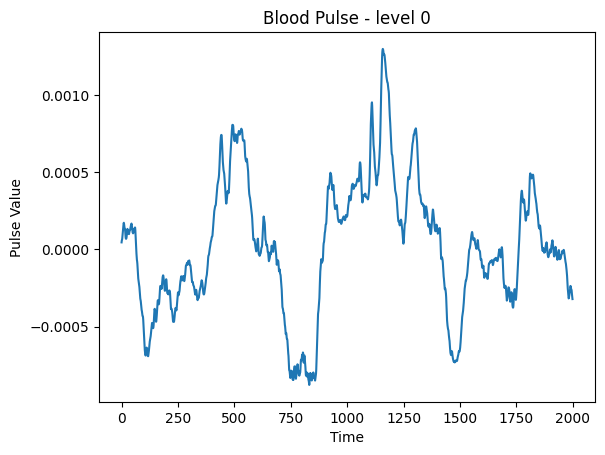

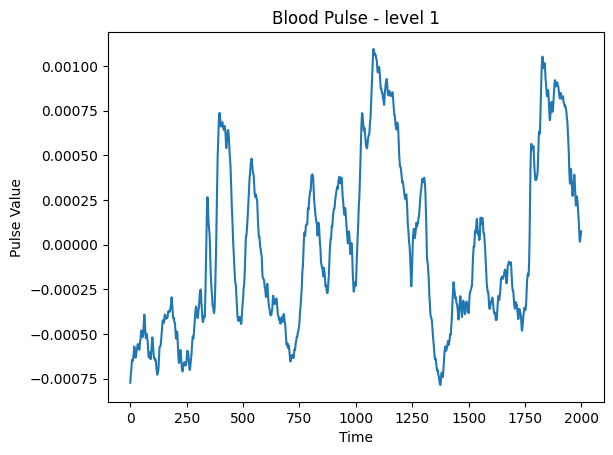

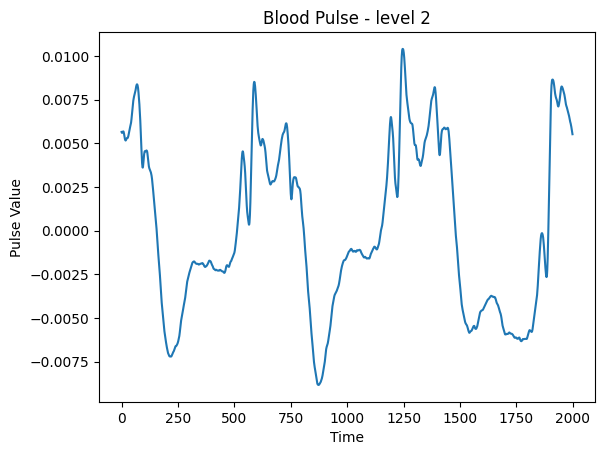

In [ ]:
possible_labels = [0,1,2]

for i in range(len(signals)):

  if labels[i] in possible_labels:

    plt.plot(signals[i])
    plt.xlabel('Time')
    plt.ylabel('Pulse Value')
    plt.title('Blood Pulse - level ' + str(labels[i]))
    plt.show()
    possible_labels.remove(labels[i])

    if (len(possible_labels)==0):
      break


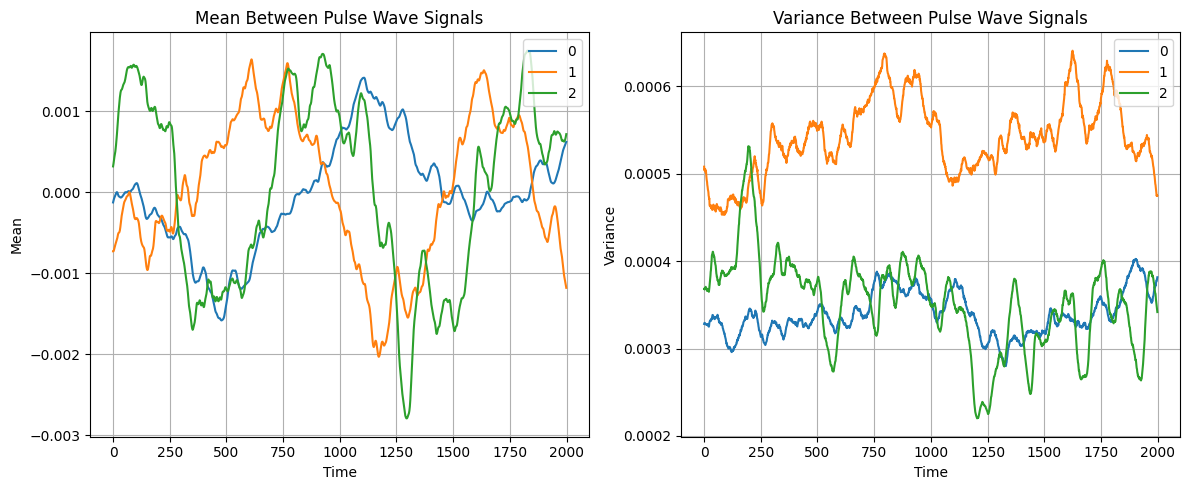

In [ ]:
signal_length = 2000
time_points = np.arange(signal_length)  # Time points corresponding to 2000 data points

plt.figure(figsize=(12, 5))

for i in range(3):
    # Filter signals based on labels equal to i
    filtered_signals = [signal for j, signal in enumerate(signals) if labels[j] == i]

    # Stack the filtered signals as rows in a 2D array
    filtered_signals_array = np.vstack(filtered_signals)

    # Calculate the variance between filtered signals (across columns)
    mean_between_signals = np.mean(filtered_signals_array, axis=0)

    # Plot the variance between signals
    plt.subplot(1, 2, 1)
    plt.plot(time_points, mean_between_signals, label=str(i))

    # Calculate the variance between filtered signals (across columns)
    variances_between_signals = np.var(filtered_signals_array, axis=0)

    # Plot the variance between signals
    plt.subplot(1, 2, 2)
    plt.plot(time_points, variances_between_signals, label=str(i))

plt.subplot(1, 2, 1)
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Mean Between Pulse Wave Signals')
plt.grid(True)
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Variance Between Pulse Wave Signals')
plt.grid(True)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:


# Filter signals based on labels equal to 1
filtered_signals_1 = [signal for i, signal in enumerate(signals) if labels[i] == 1]

# Stack the filtered signals as rows in a 2D array
filtered_signals_array_1 = np.vstack(filtered_signals_1)

# Calculate the variance between filtered signals (across columns)
variances_between_signals_1 = np.var(filtered_signals_array_1, axis=0)

# Calculate the variance of the variance
variance_of_variance_1 = np.var(variances_between_signals_1)

print("Variance of Variance - Class 1:", variance_of_variance_1)


Second-order Variance: 0.1675440070710695


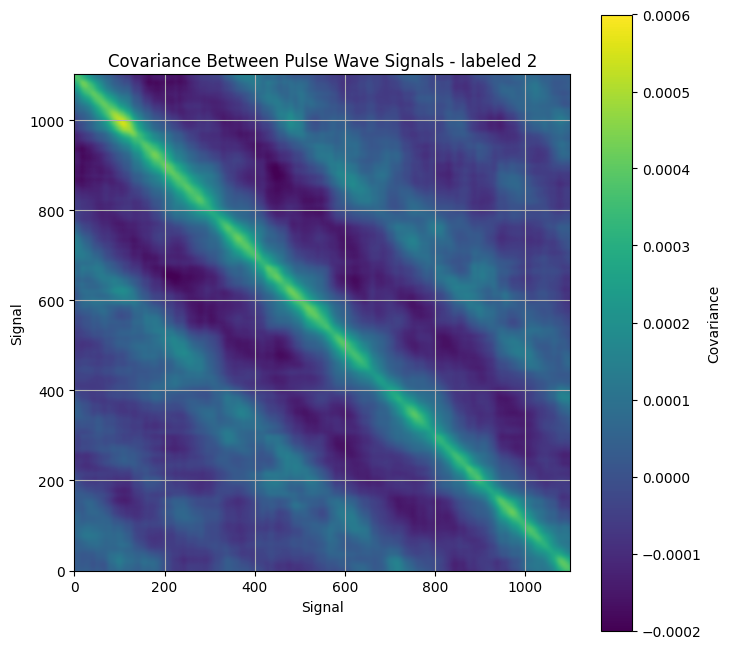

In [ ]:
signal_length = 2000
time_points = np.arange(signal_length)

# Filter signals based on labels equal to 2
filtered_signals = [signal for i, signal in enumerate(signals) if labels[i]==2]

# Stack the filtered signals as rows in a 2D array
filtered_signals_array = np.vstack(filtered_signals)

# Calculate the covariance between filtered signals
covariance_between_signals = np.cov(filtered_signals_array, rowvar=False)

# Plot the covariance matrix
plt.figure(figsize=(8, 8))
plt.imshow(covariance_between_signals, cmap='viridis', origin='upper', extent=[0, len(filtered_signals), 0, len(filtered_signals)], vmin=-0.0002, vmax=0.0006)
plt.colorbar(label='Covariance')
plt.xlabel('Signal')
plt.ylabel('Signal')
plt.title('Covariance Between Pulse Wave Signals - labeled 2')
plt.grid(True)
plt.show()


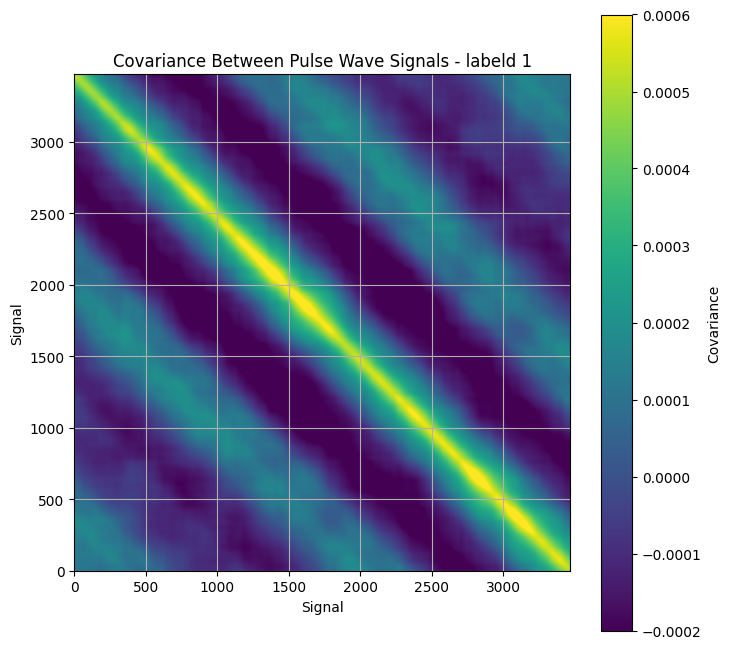

In [ ]:
signal_length = 2000
time_points = np.arange(signal_length)
filtered_signals = [signal for i, signal in enumerate(signals) if labels[i] == 1]
filtered_signals_array = np.vstack(filtered_signals)
covariance_between_signals = np.cov(filtered_signals_array, rowvar=False)
plt.figure(figsize=(8, 8))
plt.imshow(covariance_between_signals, cmap='viridis', origin='upper', extent=[0, len(filtered_signals), 0, len(filtered_signals)], vmin=-0.0002, vmax=0.0006)
plt.colorbar(label='Covariance')
plt.xlabel('Signal')
plt.ylabel('Signal')
plt.title('Covariance Between Pulse Wave Signals - labeld 1')
plt.grid(True)
plt.show()


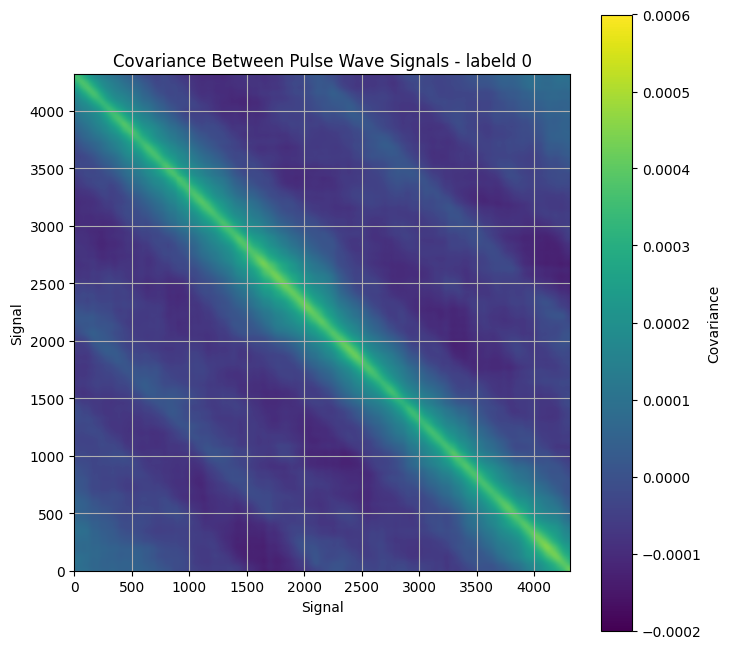

In [ ]:
signal_length = 2000
time_points = np.arange(signal_length)
filtered_signals = [signal for i, signal in enumerate(signals) if labels[i] == 0]
filtered_signals_array = np.vstack(filtered_signals)
covariance_between_signals = np.cov(filtered_signals_array, rowvar=False)
plt.figure(figsize=(8, 8))
plt.imshow(covariance_between_signals, cmap='viridis', origin='upper', extent=[0, len(filtered_signals), 0, len(filtered_signals)], vmin=-0.0002, vmax=0.0006)
plt.colorbar(label='Covariance')
plt.xlabel('Signal')
plt.ylabel('Signal')
plt.title('Covariance Between Pulse Wave Signals - labeld 0')
plt.grid(True)
plt.show()


## Experiment details to log

In [ ]:
cfg_vars = vars(CFG)
class_vars = {k: v for k, v in vars(CFG).items() if not k.startswith('__')}
LOGGER.info(str(class_vars))

oof_df = pd.DataFrame()


{'experiment': 30, 'under_sampling': True, 'resume_training_experiment': False, 'torch_sampler': False, 'leave_one_out': True, 'new_labels': False, 'old_labels': True, 'with_out_reem_labels': True, 'all_labels': False, 'balanced_factor': 4, 'data_paths': '/content/drive/MyDrive/Ramzor_Data', 'all_ramzor_xml_files': ['/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/amit_hadar/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/amit_gavish/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/shirley/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/Noa_Gelber/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels/Reem/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels_2nd_part/Noa_Gelber/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels_2nd_part/Amit_Hadar/annotations.xml', '/content/drive/MyDrive/Ramzor_Data/Ramzor_labels_2nd_part/Amit_Gavish/annotations.xml'], 'all_records_paths': ['/conte

## Training Loop

In [ ]:
if CFG.train:

  oof_df = pd.DataFrame()
  for fold in range(CFG.n_fold):
      if fold in CFG.trn_fold:

        LOGGER.info(f"========== fold: {fold} training ==========")

        # ====================================================
        # loader
        # ====================================================
        trn_idx = np.where(folds != fold)[0]
        val_idx = np.where(folds == fold)[0]

        train_signals ,train_labels = signals[trn_idx], labels[trn_idx]
        validation_signals, validation_labels =  signals[val_idx], labels[val_idx]
        # train_folds = folds.loc[trn_idx].reset_index(drop=True)
        # valid_folds = folds.loc[val_idx].reset_index(drop=True)


        train_dataset = SignalsDataset(train_signals, train_labels)
        valid_dataset = SignalsDataset(validation_signals, validation_labels)

        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


        _oof_df,score_plot,loss_plot = train_loop(train_loader, valid_loader, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== oofold: {fold} result ==========")
        get_result(_oof_df)
  # CV result
  LOGGER.info(f"========== CV ==========")
  get_result(oof_df)

  print(get_result(_oof_df))

========== fold: 0 training ==========
INFO:__main__:========== fold: 0 training ==========
========== fold: 0 training ==========
INFO:__main__:========== fold: 0 training ==========





Epoch: [1/500][0/111] Loss: 1.1042(1.1042) Grad: 1.4275  LR: 0.001000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [1/500][5/111] Loss: 1.0946(1.1008) Grad: 7.0991  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [1/500][10/111] Loss: 1.0798(1.0950) Grad: 1.5007  LR: 0.001000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [1/500][15/111] Loss: 1.0287(1.0848) Grad: 2.9831  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [1/500][20/111] Loss: 1.0470(1.0773) Grad: 1.1012  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [1/500][25/111] Loss: 1.0135(1.0659) Grad: 4.5979  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [1/500][30/111] Loss: 1.0107(1.0605) Grad: 9.6844  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [1/500][35/111] Loss: 1.0529(1.0575) Grad: 9.7974  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [1/500][40/111] Loss: 1.0171(1.0522) Grad: 3.1882  LR: 0.001000

Epoch 1 - avg_train_loss: 1.0036  avg_val_loss: 0.9224  time: 9s



EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1495(0.9265) 


INFO:__main__:Epoch 1 - avg_train_loss: 1.0036  avg_val_loss: 0.9224  time: 9s
Epoch 1 - Score: 0.6200
INFO:__main__:Epoch 1 - Score: 0.6200
Epoch 1 - Save Best Score: 0.6200 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.6200 Model
Epoch 1 - Save Best Loss: 0.9224 Model
INFO:__main__:Epoch 1 - Save Best Loss: 0.9224 Model





Epoch: [2/500][0/111] Loss: 0.9253(0.9253) Grad: 1.4698  LR: 0.000905  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [2/500][5/111] Loss: 0.9119(0.9342) Grad: 10.1775  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [2/500][10/111] Loss: 0.9156(0.9300) Grad: 4.4169  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [2/500][15/111] Loss: 0.9701(0.9320) Grad: 7.0784  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [2/500][20/111] Loss: 0.9126(0.9310) Grad: 4.2081  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [2/500][25/111] Loss: 0.9575(0.9311) Grad: 2.2578  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [2/500][30/111] Loss: 0.9108(0.9365) Grad: 1.3512  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [2/500][35/111] Loss: 0.9121(0.9344) Grad: 1.5874  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [2/500][40/111] Loss: 0.9707(0.9339) Grad: 1.5164  LR: 0.00090

Epoch 2 - avg_train_loss: 0.9289  avg_val_loss: 0.9111  time: 7s
INFO:__main__:Epoch 2 - avg_train_loss: 0.9289  avg_val_loss: 0.9111  time: 7s
Epoch 2 - Score: 0.6635


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9926(0.9031) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1747(0.9128) 


INFO:__main__:Epoch 2 - Score: 0.6635
Epoch 2 - Save Best Score: 0.6635 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.6635 Model
Epoch 2 - Save Best Loss: 0.9111 Model
INFO:__main__:Epoch 2 - Save Best Loss: 0.9111 Model





Epoch: [3/500][0/111] Loss: 0.8937(0.8937) Grad: 6.7351  LR: 0.000655  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [3/500][5/111] Loss: 0.8380(0.9091) Grad: 3.1264  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [3/500][10/111] Loss: 0.8983(0.9204) Grad: 6.6095  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [3/500][15/111] Loss: 0.9367(0.9235) Grad: 3.4080  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [3/500][20/111] Loss: 0.8611(0.9053) Grad: 3.7221  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [3/500][25/111] Loss: 0.9441(0.9118) Grad: 6.7941  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [3/500][30/111] Loss: 0.9435(0.9117) Grad: 5.0715  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [3/500][35/111] Loss: 0.9071(0.9126) Grad: 5.4499  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [3/500][40/111] Loss: 0.8905(0.9060) Grad: 4.3075  LR: 0.000655

Epoch 3 - avg_train_loss: 0.9009  avg_val_loss: 0.8827  time: 8s
INFO:__main__:Epoch 3 - avg_train_loss: 0.9009  avg_val_loss: 0.8827  time: 8s
Epoch 3 - Score: 0.6599
INFO:__main__:Epoch 3 - Score: 0.6599
Epoch 3 - Save Best Loss: 0.8827 Model
INFO:__main__:Epoch 3 - Save Best Loss: 0.8827 Model





Epoch: [4/500][0/111] Loss: 0.9559(0.9559) Grad: 6.2762  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [4/500][5/111] Loss: 0.8974(0.8932) Grad: 2.5062  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [4/500][10/111] Loss: 0.9102(0.8982) Grad: 2.9883  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [4/500][15/111] Loss: 1.0498(0.9088) Grad: 4.4269  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [4/500][20/111] Loss: 0.9080(0.9024) Grad: 2.1737  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [4/500][25/111] Loss: 0.8948(0.8930) Grad: 4.7014  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [4/500][30/111] Loss: 0.9470(0.8899) Grad: 5.4681  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [4/500][35/111] Loss: 0.8563(0.8894) Grad: 2.6381  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [4/500][40/111] Loss: 0.8569(0.8937) Grad: 5.0766  LR: 0.000346

Epoch 4 - avg_train_loss: 0.8901  avg_val_loss: 0.8632  time: 7s
INFO:__main__:Epoch 4 - avg_train_loss: 0.8901  avg_val_loss: 0.8632  time: 7s
Epoch 4 - Score: 0.6899
INFO:__main__:Epoch 4 - Score: 0.6899
Epoch 4 - Save Best Score: 0.6899 Model


EVAL: [25/28] Data 0.001 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1727(0.8638) 


INFO:__main__:Epoch 4 - Save Best Score: 0.6899 Model
Epoch 4 - Save Best Loss: 0.8632 Model
INFO:__main__:Epoch 4 - Save Best Loss: 0.8632 Model





Epoch: [5/500][0/111] Loss: 0.9380(0.9380) Grad: 5.1209  LR: 0.000096  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [5/500][5/111] Loss: 0.8731(0.8852) Grad: 3.9573  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [5/500][10/111] Loss: 0.9131(0.8904) Grad: 2.4953  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [5/500][15/111] Loss: 0.8282(0.8781) Grad: 3.9628  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [5/500][20/111] Loss: 0.8900(0.8774) Grad: 3.9656  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [5/500][25/111] Loss: 0.8612(0.8781) Grad: 3.3868  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [5/500][30/111] Loss: 0.8558(0.8783) Grad: 4.7866  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [5/500][35/111] Loss: 1.0330(0.8811) Grad: 2.9255  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [5/500][40/111] Loss: 0.9602(0.8807) Grad: 4.1599  LR: 0.000096

Epoch 5 - avg_train_loss: 0.8846  avg_val_loss: 0.8587  time: 8s
INFO:__main__:Epoch 5 - avg_train_loss: 0.8846  avg_val_loss: 0.8587  time: 8s
Epoch 5 - Score: 0.6762


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1591(0.8603) 


INFO:__main__:Epoch 5 - Score: 0.6762
Epoch 5 - Save Best Loss: 0.8587 Model
INFO:__main__:Epoch 5 - Save Best Loss: 0.8587 Model





Epoch: [6/500][0/111] Loss: 0.8535(0.8535) Grad: 3.9195  LR: 0.000000  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [6/500][5/111] Loss: 0.9163(0.8852) Grad: 9.8222  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [6/500][10/111] Loss: 0.9190(0.8979) Grad: 2.8080  LR: 0.000000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [6/500][15/111] Loss: 0.8215(0.8848) Grad: 2.7708  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [6/500][20/111] Loss: 0.9100(0.8861) Grad: 2.9538  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [6/500][25/111] Loss: 0.7957(0.8844) Grad: 4.1154  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [6/500][30/111] Loss: 0.8591(0.8896) Grad: 2.6936  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [6/500][35/111] Loss: 0.8411(0.8879) Grad: 2.3572  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [6/500][40/111] Loss: 0.8928(0.8863) Grad: 3.5481  LR: 0.000000

Epoch 6 - avg_train_loss: 0.8827  avg_val_loss: 0.8590  time: 7s
INFO:__main__:Epoch 6 - avg_train_loss: 0.8827  avg_val_loss: 0.8590  time: 7s
Epoch 6 - Score: 0.6794
INFO:__main__:Epoch 6 - Score: 0.6794


EVAL: [20/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9644(0.8444) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1630(0.8605) 



Epoch: [7/500][0/111] Loss: 0.8887(0.8887) Grad: 1.7331  LR: 0.000096  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [7/500][5/111] Loss: 0.8072(0.8745) Grad: 2.7637  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [7/500][10/111] Loss: 0.8798(0.8701) Grad: 4.8007  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [7/500][15/111] Loss: 0.8791(0.8803) Grad: 3.6523  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [7/500][20/111] Loss: 0.8536(0.8749) Grad: 2.8273  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [7/500][25/111] Loss: 0.9097(0.8736) Grad: 7.0116  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [7/500][30/111] Loss: 0.8745(0.8737) Grad: 4.8356  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [7/500][35/

Epoch 7 - avg_train_loss: 0.8811  avg_val_loss: 0.8638  time: 8s
INFO:__main__:Epoch 7 - avg_train_loss: 0.8811  avg_val_loss: 0.8638  time: 8s
Epoch 7 - Score: 0.6924
INFO:__main__:Epoch 7 - Score: 0.6924
Epoch 7 - Save Best Score: 0.6924 Model
INFO:__main__:Epoch 7 - Save Best Score: 0.6924 Model


EVAL: [20/28] Data 0.005 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9501(0.8480) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1773(0.8644) 



Epoch: [8/500][0/111] Loss: 0.8663(0.8663) Grad: 1.6124  LR: 0.000346  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [8/500][5/111] Loss: 0.9602(0.8685) Grad: 8.6296  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [8/500][10/111] Loss: 0.8204(0.8691) Grad: 3.6240  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [8/500][15/111] Loss: 0.9027(0.8621) Grad: 2.9254  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [8/500][20/111] Loss: 0.8461(0.8740) Grad: 4.7459  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [8/500][25/111] Loss: 0.8894(0.8786) Grad: 1.9466  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [8/500][30/111] Loss: 0.8393(0.8774) Grad: 1.2939  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [8/500][35/

Epoch 8 - avg_train_loss: 0.8819  avg_val_loss: 0.8723  time: 7s
INFO:__main__:Epoch 8 - avg_train_loss: 0.8819  avg_val_loss: 0.8723  time: 7s
Epoch 8 - Score: 0.6337
INFO:__main__:Epoch 8 - Score: 0.6337





Epoch: [9/500][0/111] Loss: 0.8682(0.8682) Grad: 2.3243  LR: 0.000655  Elapsed: 0m 0s (remain 0m 19s) Max mem: 0 MB
Epoch: [9/500][5/111] Loss: 0.8820(0.9002) Grad: 9.9643  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [9/500][10/111] Loss: 0.8732(0.8890) Grad: 4.4056  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [9/500][15/111] Loss: 0.8674(0.8903) Grad: 6.4835  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [9/500][20/111] Loss: 0.8653(0.8834) Grad: 3.4882  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [9/500][25/111] Loss: 0.8391(0.8788) Grad: 4.4504  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [9/500][30/111] Loss: 0.8655(0.8816) Grad: 3.6618  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [9/500][35/111] Loss: 0.8686(0.8837) Grad: 1.8972  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [9/500][40/111] Loss: 0.8581(0.8837) Grad: 4.3824  LR: 0.000655

Epoch 9 - avg_train_loss: 0.8797  avg_val_loss: 1.0315  time: 8s
INFO:__main__:Epoch 9 - avg_train_loss: 0.8797  avg_val_loss: 1.0315  time: 8s
Epoch 9 - Score: 0.5015
INFO:__main__:Epoch 9 - Score: 0.5015


EVAL: [20/28] Data 0.006 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2759(1.0508) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3149(1.0410) 



Epoch: [10/500][0/111] Loss: 0.9635(0.9635) Grad: 3.0975  LR: 0.000905  Elapsed: 0m 0s (remain 0m 19s) Max mem: 0 MB
Epoch: [10/500][5/111] Loss: 0.8499(0.9059) Grad: 13.3830  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [10/500][10/111] Loss: 0.9080(0.8967) Grad: 4.1403  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [10/500][15/111] Loss: 0.8315(0.9080) Grad: 2.8908  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [10/500][20/111] Loss: 0.9541(0.9084) Grad: 2.5200  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [10/500][25/111] Loss: 0.8902(0.9039) Grad: 2.5112  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [10/500][30/111] Loss: 0.8275(0.9018) Grad: 2.5248  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [10

Epoch 10 - avg_train_loss: 0.8816  avg_val_loss: 0.9490  time: 7s
INFO:__main__:Epoch 10 - avg_train_loss: 0.8816  avg_val_loss: 0.9490  time: 7s
Epoch 10 - Score: 0.5247
INFO:__main__:Epoch 10 - Score: 0.5247


EVAL: [20/28] Data 0.004 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0670(0.9391) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1451(0.9526) 



Epoch: [11/500][0/111] Loss: 0.8685(0.8685) Grad: 6.8411  LR: 0.001000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [11/500][5/111] Loss: 0.8530(0.8831) Grad: 2.3849  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [11/500][10/111] Loss: 0.9078(0.8822) Grad: 4.3452  LR: 0.001000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [11/500][15/111] Loss: 0.8604(0.8784) Grad: 1.6166  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [11/500][20/111] Loss: 0.8998(0.8687) Grad: 2.8400  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [11/500][25/111] Loss: 0.8382(0.8725) Grad: 2.3066  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [11/500][30/111] Loss: 0.8992(0.8642) Grad: 5.6327  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [11/

Epoch 11 - avg_train_loss: 0.8710  avg_val_loss: 0.8945  time: 8s
INFO:__main__:Epoch 11 - avg_train_loss: 0.8710  avg_val_loss: 0.8945  time: 8s
Epoch 11 - Score: 0.6093
INFO:__main__:Epoch 11 - Score: 0.6093


EVAL: [25/28] Data 0.001 (0.005) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1451(0.8950) 



Epoch: [12/500][0/111] Loss: 0.8713(0.8713) Grad: 1.9282  LR: 0.000905  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [12/500][5/111] Loss: 0.9490(0.8922) Grad: 2.8466  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [12/500][10/111] Loss: 0.8622(0.8771) Grad: 2.5687  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [12/500][15/111] Loss: 0.9609(0.8820) Grad: 3.7118  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [12/500][20/111] Loss: 0.8307(0.8794) Grad: 3.4251  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [12/500][25/111] Loss: 0.8036(0.8747) Grad: 1.3630  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [12/500][30/111] Loss: 0.9412(0.8732) Grad: 3.3657  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [12/500][35/111] Loss: 0.8713(0.8715) Grad: 2.9350  LR: 0.000905  Elapsed: 0m 2s (remain

Epoch 12 - avg_train_loss: 0.8661  avg_val_loss: 0.9045  time: 7s
INFO:__main__:Epoch 12 - avg_train_loss: 0.8661  avg_val_loss: 0.9045  time: 7s
Epoch 12 - Score: 0.5857


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0655(0.8905) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1453(0.9051) 


INFO:__main__:Epoch 12 - Score: 0.5857





Epoch: [13/500][0/111] Loss: 0.9875(0.9875) Grad: 6.7132  LR: 0.000655  Elapsed: 0m 0s (remain 0m 19s) Max mem: 0 MB
Epoch: [13/500][5/111] Loss: 0.8668(0.9220) Grad: 3.2494  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [13/500][10/111] Loss: 0.8897(0.8715) Grad: 7.5057  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [13/500][15/111] Loss: 0.8375(0.8731) Grad: 3.4724  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [13/500][20/111] Loss: 0.9175(0.8800) Grad: 2.7253  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [13/500][25/111] Loss: 0.8763(0.8741) Grad: 2.1873  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [13/500][30/111] Loss: 0.9240(0.8691) Grad: 3.0526  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [13/500][35/111] Loss: 0.8594(0.8648) Grad: 2.4274  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [13/500][40/111] Loss: 0.8058(0.8613) Grad: 3.1200  LR:

Epoch 13 - avg_train_loss: 0.8607  avg_val_loss: 0.9548  time: 8s
INFO:__main__:Epoch 13 - avg_train_loss: 0.8607  avg_val_loss: 0.9548  time: 8s
Epoch 13 - Score: 0.6225
INFO:__main__:Epoch 13 - Score: 0.6225


EVAL: [20/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2122(0.9682) 
EVAL: [25/28] Data 0.001 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3429(0.9643) 



Epoch: [14/500][0/111] Loss: 0.8952(0.8952) Grad: 2.6072  LR: 0.000346  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [14/500][5/111] Loss: 0.8227(0.8246) Grad: 0.9978  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [14/500][10/111] Loss: 0.9153(0.8429) Grad: 3.9128  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [14/500][15/111] Loss: 0.9469(0.8476) Grad: 2.1386  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [14/500][20/111] Loss: 0.8744(0.8525) Grad: 3.1183  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [14/500][25/111] Loss: 0.8444(0.8590) Grad: 1.2494  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [14/500][30/111] Loss: 0.7995(0.8599) Grad: 3.1016  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [14/

Epoch 14 - avg_train_loss: 0.8543  avg_val_loss: 1.0014  time: 7s
INFO:__main__:Epoch 14 - avg_train_loss: 0.8543  avg_val_loss: 1.0014  time: 7s


EVAL: [20/28] Data 0.007 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0496(0.9865) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0261(0.9889) 


Epoch 14 - Score: 0.4534
INFO:__main__:Epoch 14 - Score: 0.4534





Epoch: [15/500][0/111] Loss: 0.9174(0.9174) Grad: 1.8701  LR: 0.000096  Elapsed: 0m 0s (remain 0m 19s) Max mem: 0 MB
Epoch: [15/500][5/111] Loss: 0.8242(0.8848) Grad: 5.1135  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [15/500][10/111] Loss: 0.9285(0.8690) Grad: 2.7495  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [15/500][15/111] Loss: 0.8377(0.8629) Grad: 2.1145  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [15/500][20/111] Loss: 0.7997(0.8543) Grad: 2.2640  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [15/500][25/111] Loss: 0.8074(0.8567) Grad: 3.8194  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [15/500][30/111] Loss: 0.7843(0.8589) Grad: 1.2228  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [15/500][35/111] Loss: 0.8185(0.8590) Grad: 1.4365  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [15/500][40/111] Loss: 0.8279(0.8584) Grad: 3.4488  LR:

Epoch 15 - avg_train_loss: 0.8531  avg_val_loss: 0.8447  time: 8s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9816(0.8312) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1430(0.8455) 


INFO:__main__:Epoch 15 - avg_train_loss: 0.8531  avg_val_loss: 0.8447  time: 8s
Epoch 15 - Score: 0.6763
INFO:__main__:Epoch 15 - Score: 0.6763
Epoch 15 - Save Best Loss: 0.8447 Model
INFO:__main__:Epoch 15 - Save Best Loss: 0.8447 Model





Epoch: [16/500][0/111] Loss: 0.8705(0.8705) Grad: 2.7191  LR: 0.000000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [16/500][5/111] Loss: 0.8019(0.8256) Grad: 2.5383  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [16/500][10/111] Loss: 0.8371(0.8348) Grad: 2.1294  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [16/500][15/111] Loss: 0.8504(0.8409) Grad: 2.3213  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [16/500][20/111] Loss: 0.8835(0.8465) Grad: 2.6534  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [16/500][25/111] Loss: 0.8475(0.8466) Grad: 2.6848  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [16/500][30/111] Loss: 0.7772(0.8458) Grad: 1.9878  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [16/500][35/111] Loss: 0.7948(0.8448) Grad: 3.2004  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [16/500][40/111] Loss: 0.8395(0.8469) Grad: 4.8030  LR:

Epoch 16 - avg_train_loss: 0.8520  avg_val_loss: 0.8307  time: 7s
INFO:__main__:Epoch 16 - avg_train_loss: 0.8520  avg_val_loss: 0.8307  time: 7s
Epoch 16 - Score: 0.6986
INFO:__main__:Epoch 16 - Score: 0.6986


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1513(0.8331) 


Epoch 16 - Save Best Score: 0.6986 Model
INFO:__main__:Epoch 16 - Save Best Score: 0.6986 Model
Epoch 16 - Save Best Loss: 0.8307 Model
INFO:__main__:Epoch 16 - Save Best Loss: 0.8307 Model





Epoch: [17/500][0/111] Loss: 0.8854(0.8854) Grad: 3.0689  LR: 0.000096  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [17/500][5/111] Loss: 0.8763(0.8560) Grad: 2.8156  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [17/500][10/111] Loss: 0.8306(0.8399) Grad: 5.8340  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [17/500][15/111] Loss: 0.8262(0.8427) Grad: 2.2389  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [17/500][20/111] Loss: 0.8945(0.8472) Grad: 2.8095  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [17/500][25/111] Loss: 0.8657(0.8536) Grad: 1.8506  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [17/500][30/111] Loss: 0.8838(0.8518) Grad: 1.9004  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [17/500][35/111] Loss: 0.8978(0.8593) Grad: 2.2733  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [17/500][40/111] Loss: 0.7850(0.8588) Grad: 1.9565  LR:

Epoch 17 - avg_train_loss: 0.8502  avg_val_loss: 0.8475  time: 9s
INFO:__main__:Epoch 17 - avg_train_loss: 0.8502  avg_val_loss: 0.8475  time: 9s
Epoch 17 - Score: 0.6744
INFO:__main__:Epoch 17 - Score: 0.6744


EVAL: [25/28] Data 0.002 (0.005) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1370(0.8487) 



Epoch: [18/500][0/111] Loss: 0.8711(0.8711) Grad: 3.2727  LR: 0.000346  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [18/500][5/111] Loss: 0.8125(0.8375) Grad: 6.4724  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [18/500][10/111] Loss: 0.8754(0.8447) Grad: 2.8585  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [18/500][15/111] Loss: 0.8357(0.8580) Grad: 5.7034  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [18/500][20/111] Loss: 0.7803(0.8555) Grad: 2.5850  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [18/500][25/111] Loss: 0.8884(0.8568) Grad: 2.4467  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [18/500][30/111] Loss: 0.8095(0.8541) Grad: 3.3856  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [18/500][35/111] Loss: 0.8200(0.8517) Grad: 4.0804  LR: 0.000346  Elapsed: 0m 2s (remain

Epoch 18 - avg_train_loss: 0.8532  avg_val_loss: 0.8637  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0376(0.8519) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1266(0.8633) 


INFO:__main__:Epoch 18 - avg_train_loss: 0.8532  avg_val_loss: 0.8637  time: 7s
Epoch 18 - Score: 0.6548
INFO:__main__:Epoch 18 - Score: 0.6548





Epoch: [19/500][0/111] Loss: 0.7742(0.7742) Grad: 3.0892  LR: 0.000655  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [19/500][5/111] Loss: 0.8824(0.8297) Grad: 2.7361  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [19/500][10/111] Loss: 0.8579(0.8276) Grad: 1.1569  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [19/500][15/111] Loss: 0.8678(0.8494) Grad: 3.1469  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [19/500][20/111] Loss: 0.8499(0.8543) Grad: 6.3303  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [19/500][25/111] Loss: 0.7689(0.8501) Grad: 3.4768  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [19/500][30/111] Loss: 0.8280(0.8485) Grad: 1.9157  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [19/500][35/111] Loss: 0.8749(0.8478) Grad: 1.8305  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [19/500][40/111] Loss: 0.8587(0.8533) Grad: 3.6077  LR:

Epoch 19 - avg_train_loss: 0.8564  avg_val_loss: 0.9435  time: 9s
INFO:__main__:Epoch 19 - avg_train_loss: 0.8564  avg_val_loss: 0.9435  time: 9s


EVAL: [20/28] Data 0.009 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9592(0.9197) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1352(0.9331) 


Epoch 19 - Score: 0.5551
INFO:__main__:Epoch 19 - Score: 0.5551





Epoch: [20/500][0/111] Loss: 0.8869(0.8869) Grad: 3.0317  LR: 0.000905  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [20/500][5/111] Loss: 0.7861(0.8182) Grad: 4.6517  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [20/500][10/111] Loss: 0.7902(0.8328) Grad: 3.6350  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [20/500][15/111] Loss: 0.7898(0.8501) Grad: 4.6810  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [20/500][20/111] Loss: 0.8128(0.8501) Grad: 3.7460  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [20/500][25/111] Loss: 0.9323(0.8546) Grad: 3.9241  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [20/500][30/111] Loss: 0.8023(0.8507) Grad: 2.0284  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [20/500][35/111] Loss: 0.8828(0.8514) Grad: 2.8034  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [20/500][40/111] Loss: 0.9506(0.8530) Grad: 2.8888  LR:

Epoch 20 - avg_train_loss: 0.8521  avg_val_loss: 0.8810  time: 7s
INFO:__main__:Epoch 20 - avg_train_loss: 0.8521  avg_val_loss: 0.8810  time: 7s
Epoch 20 - Score: 0.6571
INFO:__main__:Epoch 20 - Score: 0.6571


EVAL: [25/28] Data 0.001 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0619(0.8758) 



Epoch: [21/500][0/111] Loss: 0.8272(0.8272) Grad: 3.4535  LR: 0.001000  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [21/500][5/111] Loss: 0.8768(0.8587) Grad: 1.6671  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [21/500][10/111] Loss: 0.8374(0.8654) Grad: 2.9369  LR: 0.001000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [21/500][15/111] Loss: 0.8515(0.8577) Grad: 3.9686  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [21/500][20/111] Loss: 0.8758(0.8524) Grad: 1.9044  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [21/500][25/111] Loss: 0.8315(0.8515) Grad: 5.2124  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [21/500][30/111] Loss: 0.9051(0.8562) Grad: 3.6228  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [21/500][35/111] Loss: 0.7689(0.8525) Grad: 1.6924  LR: 0.001000  Elapsed: 0m 2s (remain

Epoch 21 - avg_train_loss: 0.8514  avg_val_loss: 0.8656  time: 9s
INFO:__main__:Epoch 21 - avg_train_loss: 0.8514  avg_val_loss: 0.8656  time: 9s
Epoch 21 - Score: 0.6529
INFO:__main__:Epoch 21 - Score: 0.6529


EVAL: [25/28] Data 0.001 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1424(0.8641) 



Epoch: [22/500][0/111] Loss: 0.8559(0.8559) Grad: 1.3708  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [22/500][5/111] Loss: 0.8497(0.8456) Grad: 1.4318  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [22/500][10/111] Loss: 0.8352(0.8438) Grad: 2.7551  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [22/500][15/111] Loss: 0.8883(0.8455) Grad: 2.0583  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [22/500][20/111] Loss: 0.8311(0.8433) Grad: 3.4497  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [22/500][25/111] Loss: 0.8393(0.8419) Grad: 2.4955  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [22/500][30/111] Loss: 0.8693(0.8516) Grad: 21.1190  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [22/500][35/111] Loss: 0.8926(0.8524) Grad: 3.7359  LR: 0.000905  Elapsed: 0m 2s (remai

Epoch 22 - avg_train_loss: 0.8501  avg_val_loss: 0.9588  time: 7s
INFO:__main__:Epoch 22 - avg_train_loss: 0.8501  avg_val_loss: 0.9588  time: 7s
Epoch 22 - Score: 0.5408
INFO:__main__:Epoch 22 - Score: 0.5408


EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0252(0.9516) 



Epoch: [23/500][0/111] Loss: 0.9054(0.9054) Grad: 1.4195  LR: 0.000655  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [23/500][5/111] Loss: 0.8504(0.8379) Grad: 2.7769  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [23/500][10/111] Loss: 0.7379(0.8301) Grad: 2.1236  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [23/500][15/111] Loss: 0.8005(0.8279) Grad: 1.6909  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [23/500][20/111] Loss: 0.7566(0.8271) Grad: 1.4638  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [23/500][25/111] Loss: 0.7902(0.8340) Grad: 2.0315  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [23/500][30/111] Loss: 0.7996(0.8344) Grad: 1.4869  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [23/500][35/111] Loss: 0.8427(0.8397) Grad: 2.7703  LR: 0.000655  Elapsed: 0m 2s (remain

Epoch 23 - avg_train_loss: 0.8427  avg_val_loss: 0.8242  time: 9s
INFO:__main__:Epoch 23 - avg_train_loss: 0.8427  avg_val_loss: 0.8242  time: 9s
Epoch 23 - Score: 0.7074
INFO:__main__:Epoch 23 - Score: 0.7074
Epoch 23 - Save Best Score: 0.7074 Model
INFO:__main__:Epoch 23 - Save Best Score: 0.7074 Model


EVAL: [20/28] Data 0.005 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8726(0.8151) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1021(0.8281) 


Epoch 23 - Save Best Loss: 0.8242 Model
INFO:__main__:Epoch 23 - Save Best Loss: 0.8242 Model





Epoch: [24/500][0/111] Loss: 0.8017(0.8017) Grad: 2.2255  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [24/500][5/111] Loss: 0.9494(0.8416) Grad: 3.6241  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [24/500][10/111] Loss: 0.8072(0.8339) Grad: 1.8558  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [24/500][15/111] Loss: 0.7835(0.8298) Grad: 2.7765  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [24/500][20/111] Loss: 0.8261(0.8332) Grad: 1.6766  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [24/500][25/111] Loss: 0.7999(0.8362) Grad: 1.6991  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [24/500][30/111] Loss: 0.8046(0.8356) Grad: 4.2666  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [24/500][35/111] Loss: 0.7793(0.8370) Grad: 2.3399  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [24/500][40/111] Loss: 0.8487(0.8391) Grad: 1.9379  LR:

Epoch 24 - avg_train_loss: 0.8392  avg_val_loss: 0.9869  time: 7s
INFO:__main__:Epoch 24 - avg_train_loss: 0.8392  avg_val_loss: 0.9869  time: 7s
Epoch 24 - Score: 0.4885
INFO:__main__:Epoch 24 - Score: 0.4885


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0668(0.9737) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0275(0.9752) 



Epoch: [25/500][0/111] Loss: 0.8430(0.8430) Grad: 3.0237  LR: 0.000096  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [25/500][5/111] Loss: 0.7974(0.8097) Grad: 3.2585  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [25/500][10/111] Loss: 0.8321(0.8278) Grad: 1.9323  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [25/500][15/111] Loss: 0.7893(0.8249) Grad: 1.7145  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [25/500][20/111] Loss: 0.8459(0.8191) Grad: 1.4262  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [25/500][25/111] Loss: 0.8873(0.8232) Grad: 3.3190  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [25/500][30/111] Loss: 0.8653(0.8260) Grad: 6.2806  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [25/

Epoch 25 - avg_train_loss: 0.8360  avg_val_loss: 0.8420  time: 9s
INFO:__main__:Epoch 25 - avg_train_loss: 0.8360  avg_val_loss: 0.8420  time: 9s
Epoch 25 - Score: 0.7023
INFO:__main__:Epoch 25 - Score: 0.7023


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0366(0.8442) 



Epoch: [26/500][0/111] Loss: 0.7759(0.7759) Grad: 1.9760  LR: 0.000000  Elapsed: 0m 0s (remain 0m 18s) Max mem: 0 MB
Epoch: [26/500][5/111] Loss: 0.9654(0.8302) Grad: 2.0370  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [26/500][10/111] Loss: 0.8896(0.8343) Grad: 2.5916  LR: 0.000000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [26/500][15/111] Loss: 0.8830(0.8313) Grad: 1.9907  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [26/500][20/111] Loss: 0.7900(0.8346) Grad: 1.4500  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [26/500][25/111] Loss: 0.8144(0.8239) Grad: 1.4957  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [26/500][30/111] Loss: 0.8011(0.8270) Grad: 1.0647  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [26/500][35/111] Loss: 0.7581(0.8253) Grad: 1.5001  LR: 0.000000  Elapsed: 0m 2s (remain

Epoch 26 - avg_train_loss: 0.8325  avg_val_loss: 0.8230  time: 7s
INFO:__main__:Epoch 26 - avg_train_loss: 0.8325  avg_val_loss: 0.8230  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8790(0.8142) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0953(0.8270) 


Epoch 26 - Score: 0.7065
INFO:__main__:Epoch 26 - Score: 0.7065
Epoch 26 - Save Best Loss: 0.8230 Model
INFO:__main__:Epoch 26 - Save Best Loss: 0.8230 Model





Epoch: [27/500][0/111] Loss: 0.7989(0.7989) Grad: 5.0790  LR: 0.000096  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [27/500][5/111] Loss: 0.8511(0.8309) Grad: 1.6142  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [27/500][10/111] Loss: 0.8157(0.8288) Grad: 2.2692  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [27/500][15/111] Loss: 0.8188(0.8164) Grad: 1.6339  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [27/500][20/111] Loss: 0.8467(0.8266) Grad: 2.5449  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [27/500][25/111] Loss: 0.8058(0.8284) Grad: 4.0098  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [27/500][30/111] Loss: 0.8611(0.8280) Grad: 3.1094  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [27/500][35/111] Loss: 0.8422(0.8284) Grad: 1.9820  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [27/500][40/111] Loss: 0.8524(0.8313) Grad: 1.2854  LR:

Epoch 27 - avg_train_loss: 0.8345  avg_val_loss: 0.8273  time: 8s
INFO:__main__:Epoch 27 - avg_train_loss: 0.8345  avg_val_loss: 0.8273  time: 8s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1042(0.8300) 


Epoch 27 - Score: 0.7056
INFO:__main__:Epoch 27 - Score: 0.7056





Epoch: [28/500][0/111] Loss: 0.8971(0.8971) Grad: 3.0034  LR: 0.000346  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [28/500][5/111] Loss: 0.7716(0.8430) Grad: 3.4468  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [28/500][10/111] Loss: 0.8415(0.8419) Grad: 1.1103  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [28/500][15/111] Loss: 0.9128(0.8392) Grad: 2.4137  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [28/500][20/111] Loss: 0.8129(0.8367) Grad: 2.7129  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [28/500][25/111] Loss: 0.8413(0.8414) Grad: 2.5073  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [28/500][30/111] Loss: 0.8213(0.8405) Grad: 6.6996  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [28/500][35/111] Loss: 0.8585(0.8408) Grad: 3.1750  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [28/500][40/111] Loss: 0.8394(0.8357) Grad: 4.7004  LR:

Epoch 28 - avg_train_loss: 0.8383  avg_val_loss: 0.9342  time: 7s
INFO:__main__:Epoch 28 - avg_train_loss: 0.8383  avg_val_loss: 0.9342  time: 7s
Epoch 28 - Score: 0.5846
INFO:__main__:Epoch 28 - Score: 0.5846


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2124(0.9413) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1694(0.9383) 



Epoch: [29/500][0/111] Loss: 0.8322(0.8322) Grad: 3.2809  LR: 0.000655  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [29/500][5/111] Loss: 0.8470(0.8619) Grad: 2.8974  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [29/500][10/111] Loss: 0.8820(0.8398) Grad: 1.6581  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [29/500][15/111] Loss: 0.8618(0.8394) Grad: 3.6600  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [29/500][20/111] Loss: 0.8571(0.8331) Grad: 5.4580  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [29/500][25/111] Loss: 0.8369(0.8278) Grad: 2.1445  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [29/500][30/111] Loss: 0.7759(0.8263) Grad: 3.2929  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [29/

Epoch 29 - avg_train_loss: 0.8393  avg_val_loss: 0.9065  time: 9s
INFO:__main__:Epoch 29 - avg_train_loss: 0.8393  avg_val_loss: 0.9065  time: 9s
Epoch 29 - Score: 0.6039


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0710(0.8958) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1390(0.9072) 


INFO:__main__:Epoch 29 - Score: 0.6039





Epoch: [30/500][0/111] Loss: 0.8450(0.8450) Grad: 1.6880  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [30/500][5/111] Loss: 0.8250(0.8503) Grad: 2.6041  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [30/500][10/111] Loss: 0.7878(0.8380) Grad: 2.2167  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [30/500][15/111] Loss: 0.8545(0.8455) Grad: 7.0015  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [30/500][20/111] Loss: 0.8397(0.8397) Grad: 4.8969  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [30/500][25/111] Loss: 0.8185(0.8319) Grad: 2.0644  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [30/500][30/111] Loss: 0.8728(0.8362) Grad: 3.9206  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [30/500][35/111] Loss: 0.8577(0.8387) Grad: 1.9937  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [30/500][40/111] Loss: 0.8934(0.8399) Grad: 1.7021  LR:

Epoch 30 - avg_train_loss: 0.8404  avg_val_loss: 1.0078  time: 7s
INFO:__main__:Epoch 30 - avg_train_loss: 0.8404  avg_val_loss: 1.0078  time: 7s
Epoch 30 - Score: 0.4601
INFO:__main__:Epoch 30 - Score: 0.4601


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0288(0.9985) 



Epoch: [31/500][0/111] Loss: 0.8117(0.8117) Grad: 1.1680  LR: 0.001000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [31/500][5/111] Loss: 0.8501(0.8528) Grad: 2.0515  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [31/500][10/111] Loss: 0.8114(0.8463) Grad: 2.7281  LR: 0.001000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [31/500][15/111] Loss: 0.8570(0.8466) Grad: 3.4584  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [31/500][20/111] Loss: 0.8345(0.8396) Grad: 3.5416  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [31/500][25/111] Loss: 0.8559(0.8405) Grad: 2.8597  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [31/500][30/111] Loss: 0.8750(0.8414) Grad: 0.9001  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [31/500][35/111] Loss: 0.8946(0.8412) Grad: 1.8544  LR: 0.001000  Elapsed: 0m 2s (remain

Epoch 31 - avg_train_loss: 0.8373  avg_val_loss: 0.8978  time: 9s
INFO:__main__:Epoch 31 - avg_train_loss: 0.8373  avg_val_loss: 0.8978  time: 9s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1438(0.9001) 


Epoch 31 - Score: 0.5927
INFO:__main__:Epoch 31 - Score: 0.5927





Epoch: [32/500][0/111] Loss: 0.9285(0.9285) Grad: 3.3800  LR: 0.000905  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [32/500][5/111] Loss: 0.8720(0.8391) Grad: 1.6912  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [32/500][10/111] Loss: 0.8483(0.8464) Grad: 1.9101  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [32/500][15/111] Loss: 0.8783(0.8534) Grad: 4.6221  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [32/500][20/111] Loss: 0.7505(0.8399) Grad: 3.0877  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [32/500][25/111] Loss: 0.8958(0.8477) Grad: 3.2334  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [32/500][30/111] Loss: 0.8431(0.8437) Grad: 2.9717  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [32/500][35/111] Loss: 0.8533(0.8385) Grad: 2.4838  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [32/500][40/111] Loss: 0.8536(0.8414) Grad: 2.1783  LR:

Epoch 32 - avg_train_loss: 0.8368  avg_val_loss: 0.8338  time: 7s
INFO:__main__:Epoch 32 - avg_train_loss: 0.8368  avg_val_loss: 0.8338  time: 7s
Epoch 32 - Score: 0.6913
INFO:__main__:Epoch 32 - Score: 0.6913


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9242(0.8250) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1097(0.8367) 



Epoch: [33/500][0/111] Loss: 0.8066(0.8066) Grad: 2.8977  LR: 0.000655  Elapsed: 0m 0s (remain 0m 19s) Max mem: 0 MB
Epoch: [33/500][5/111] Loss: 0.8594(0.8576) Grad: 1.1312  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [33/500][10/111] Loss: 0.7907(0.8539) Grad: 3.9635  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [33/500][15/111] Loss: 0.8475(0.8476) Grad: 5.0989  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [33/500][20/111] Loss: 0.8747(0.8486) Grad: 2.0384  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [33/500][25/111] Loss: 0.8497(0.8523) Grad: 1.4945  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [33/500][30/111] Loss: 0.7801(0.8472) Grad: 2.2825  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [33/

Epoch 33 - avg_train_loss: 0.8352  avg_val_loss: 1.0699  time: 9s


EVAL: [20/28] Data 0.005 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3740(1.0878) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4027(1.0769) 


INFO:__main__:Epoch 33 - avg_train_loss: 0.8352  avg_val_loss: 1.0699  time: 9s
Epoch 33 - Score: 0.4790
INFO:__main__:Epoch 33 - Score: 0.4790





Epoch: [34/500][0/111] Loss: 0.8538(0.8538) Grad: 6.6909  LR: 0.000346  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [34/500][5/111] Loss: 0.7984(0.8019) Grad: 2.2545  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [34/500][10/111] Loss: 0.9097(0.8176) Grad: 3.5049  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [34/500][15/111] Loss: 0.8510(0.8238) Grad: 2.5504  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [34/500][20/111] Loss: 0.8505(0.8301) Grad: 2.5442  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [34/500][25/111] Loss: 0.7873(0.8298) Grad: 1.1224  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [34/500][30/111] Loss: 0.7277(0.8201) Grad: 1.2301  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [34/500][35/111] Loss: 0.8488(0.8213) Grad: 0.9800  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [34/500][40/111] Loss: 0.8965(0.8222) Grad: 2.3823  LR:

Epoch 34 - avg_train_loss: 0.8317  avg_val_loss: 0.9441  time: 7s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2106(0.9529) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1382(0.9477) 


INFO:__main__:Epoch 34 - avg_train_loss: 0.8317  avg_val_loss: 0.9441  time: 7s
Epoch 34 - Score: 0.5588
INFO:__main__:Epoch 34 - Score: 0.5588





Epoch: [35/500][0/111] Loss: 0.8089(0.8089) Grad: 3.1760  LR: 0.000096  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [35/500][5/111] Loss: 0.8061(0.8259) Grad: 6.6022  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [35/500][10/111] Loss: 0.9381(0.8442) Grad: 1.9652  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [35/500][15/111] Loss: 0.8308(0.8461) Grad: 3.1663  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [35/500][20/111] Loss: 0.8466(0.8358) Grad: 0.9084  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [35/500][25/111] Loss: 0.7639(0.8403) Grad: 1.7569  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [35/500][30/111] Loss: 0.8100(0.8352) Grad: 1.6712  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [35/500][35/111] Loss: 0.8137(0.8338) Grad: 2.8568  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [35/500][40/111] Loss: 0.8119(0.8331) Grad: 2.1819  LR:

Epoch 35 - avg_train_loss: 0.8285  avg_val_loss: 0.8410  time: 9s
INFO:__main__:Epoch 35 - avg_train_loss: 0.8285  avg_val_loss: 0.8410  time: 9s


EVAL: [20/28] Data 0.004 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9486(0.8344) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0453(0.8431) 


Epoch 35 - Score: 0.6765
INFO:__main__:Epoch 35 - Score: 0.6765





Epoch: [36/500][0/111] Loss: 0.8277(0.8277) Grad: 1.0315  LR: 0.000000  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [36/500][5/111] Loss: 0.8331(0.8192) Grad: 2.9160  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [36/500][10/111] Loss: 0.8560(0.8306) Grad: 3.6474  LR: 0.000000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [36/500][15/111] Loss: 0.8804(0.8369) Grad: 4.9366  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [36/500][20/111] Loss: 0.9268(0.8366) Grad: 1.3148  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [36/500][25/111] Loss: 0.8215(0.8385) Grad: 3.5286  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [36/500][30/111] Loss: 0.7488(0.8401) Grad: 2.1493  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [36/500][35/111] Loss: 0.8442(0.8364) Grad: 1.0216  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [36/500][40/111] Loss: 0.8257(0.8320) Grad: 1.9111  LR:

Epoch 36 - avg_train_loss: 0.8284  avg_val_loss: 0.8195  time: 7s
INFO:__main__:Epoch 36 - avg_train_loss: 0.8284  avg_val_loss: 0.8195  time: 7s
Epoch 36 - Score: 0.7094
INFO:__main__:Epoch 36 - Score: 0.7094
Epoch 36 - Save Best Score: 0.7094 Model
INFO:__main__:Epoch 36 - Save Best Score: 0.7094 Model
Epoch 36 - Save Best Loss: 0.8195 Model
INFO:__main__:Epoch 36 - Save Best Loss: 0.8195 Model





Epoch: [37/500][0/111] Loss: 0.7896(0.7896) Grad: 1.6064  LR: 0.000096  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [37/500][5/111] Loss: 0.8395(0.8261) Grad: 3.0496  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [37/500][10/111] Loss: 0.8774(0.8339) Grad: 1.6594  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [37/500][15/111] Loss: 0.8248(0.8237) Grad: 2.9001  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [37/500][20/111] Loss: 0.7954(0.8216) Grad: 1.5628  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [37/500][25/111] Loss: 0.8417(0.8197) Grad: 2.9365  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [37/500][30/111] Loss: 0.7654(0.8219) Grad: 2.0962  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [37/500][35/111] Loss: 0.8287(0.8237) Grad: 2.9997  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [37/500][40/111] Loss: 0.8741(0.8215) Grad: 2.7940  LR:

Epoch 37 - avg_train_loss: 0.8278  avg_val_loss: 0.8336  time: 9s
INFO:__main__:Epoch 37 - avg_train_loss: 0.8278  avg_val_loss: 0.8336  time: 9s
Epoch 37 - Score: 0.7045
INFO:__main__:Epoch 37 - Score: 0.7045


EVAL: [20/28] Data 0.006 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9019(0.8286) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0370(0.8366) 



Epoch: [38/500][0/111] Loss: 0.7908(0.7908) Grad: 3.2735  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [38/500][5/111] Loss: 0.8119(0.8324) Grad: 2.2237  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [38/500][10/111] Loss: 0.8342(0.8326) Grad: 3.1547  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [38/500][15/111] Loss: 0.8306(0.8417) Grad: 3.9098  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [38/500][20/111] Loss: 0.8333(0.8434) Grad: 3.5681  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [38/500][25/111] Loss: 0.8496(0.8469) Grad: 1.6475  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [38/500][30/111] Loss: 0.8284(0.8434) Grad: 2.3110  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [38/

Epoch 38 - avg_train_loss: 0.8321  avg_val_loss: 0.9186  time: 7s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0279(0.9178) 


INFO:__main__:Epoch 38 - avg_train_loss: 0.8321  avg_val_loss: 0.9186  time: 7s
Epoch 38 - Score: 0.6048
INFO:__main__:Epoch 38 - Score: 0.6048





Epoch: [39/500][0/111] Loss: 0.8726(0.8726) Grad: 2.4346  LR: 0.000655  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [39/500][5/111] Loss: 0.8804(0.8550) Grad: 2.9323  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [39/500][10/111] Loss: 0.8878(0.8369) Grad: 2.0518  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [39/500][15/111] Loss: 0.9597(0.8402) Grad: 4.4064  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [39/500][20/111] Loss: 0.8446(0.8506) Grad: 3.1670  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [39/500][25/111] Loss: 0.7758(0.8465) Grad: 2.3258  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [39/500][30/111] Loss: 0.8008(0.8446) Grad: 1.4439  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [39/500][35/111] Loss: 0.7344(0.8374) Grad: 2.3993  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [39/500][40/111] Loss: 0.8191(0.8355) Grad: 3.5366  LR

Epoch 39 - avg_train_loss: 0.8345  avg_val_loss: 0.9017  time: 9s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9596(0.8913) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1064(0.8979) 


INFO:__main__:Epoch 39 - avg_train_loss: 0.8345  avg_val_loss: 0.9017  time: 9s
Epoch 39 - Score: 0.6348
INFO:__main__:Epoch 39 - Score: 0.6348





Epoch: [40/500][0/111] Loss: 0.7977(0.7977) Grad: 1.8492  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [40/500][5/111] Loss: 0.8461(0.8154) Grad: 4.3207  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [40/500][10/111] Loss: 0.9010(0.8357) Grad: 2.6446  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [40/500][15/111] Loss: 0.8429(0.8318) Grad: 4.7121  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [40/500][20/111] Loss: 0.7929(0.8360) Grad: 2.9248  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [40/500][25/111] Loss: 0.7729(0.8282) Grad: 2.1139  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [40/500][30/111] Loss: 0.8022(0.8285) Grad: 5.1834  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [40/500][35/111] Loss: 0.9080(0.8292) Grad: 2.5245  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [40/500][40/111] Loss: 0.9451(0.8296) Grad: 3.0892  LR:

Epoch 40 - avg_train_loss: 0.8348  avg_val_loss: 0.9480  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0655(0.9568) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0231(0.9485) 


INFO:__main__:Epoch 40 - avg_train_loss: 0.8348  avg_val_loss: 0.9480  time: 7s
Epoch 40 - Score: 0.5618
INFO:__main__:Epoch 40 - Score: 0.5618





Epoch: [41/500][0/111] Loss: 0.7837(0.7837) Grad: 1.5839  LR: 0.001000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [41/500][5/111] Loss: 0.8103(0.8062) Grad: 0.9967  LR: 0.001000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [41/500][10/111] Loss: 0.8332(0.8168) Grad: 1.6071  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [41/500][15/111] Loss: 0.7502(0.8239) Grad: 3.2036  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [41/500][20/111] Loss: 0.8349(0.8226) Grad: 2.0591  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [41/500][25/111] Loss: 0.7936(0.8181) Grad: 2.4111  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [41/500][30/111] Loss: 0.8639(0.8205) Grad: 1.4484  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [41/500][35/111] Loss: 0.8142(0.8213) Grad: 8.7145  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [41/500][40/111] Loss: 0.9548(0.8299) Grad: 4.7204  L

Epoch 41 - avg_train_loss: 0.8343  avg_val_loss: 0.9063  time: 9s
INFO:__main__:Epoch 41 - avg_train_loss: 0.8343  avg_val_loss: 0.9063  time: 9s
Epoch 41 - Score: 0.5911
INFO:__main__:Epoch 41 - Score: 0.5911





Epoch: [42/500][0/111] Loss: 0.8339(0.8339) Grad: 3.3746  LR: 0.000905  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [42/500][5/111] Loss: 0.8594(0.8510) Grad: 2.8767  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [42/500][10/111] Loss: 0.9543(0.8599) Grad: 1.8721  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [42/500][15/111] Loss: 0.7706(0.8393) Grad: 4.5191  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [42/500][20/111] Loss: 0.8241(0.8313) Grad: 2.7441  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [42/500][25/111] Loss: 0.6916(0.8349) Grad: 0.8024  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [42/500][30/111] Loss: 0.8069(0.8361) Grad: 1.6440  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [42/500][35/111] Loss: 0.7933(0.8354) Grad: 5.7395  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [42/500][40/111] Loss: 0.8811(0.8375) Grad: 3.4410  LR:

Epoch 42 - avg_train_loss: 0.8364  avg_val_loss: 0.9583  time: 7s
INFO:__main__:Epoch 42 - avg_train_loss: 0.8364  avg_val_loss: 0.9583  time: 7s
Epoch 42 - Score: 0.5748
INFO:__main__:Epoch 42 - Score: 0.5748





Epoch: [43/500][0/111] Loss: 0.9774(0.9774) Grad: 1.4136  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [43/500][5/111] Loss: 0.8711(0.8808) Grad: 1.1412  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [43/500][10/111] Loss: 0.8237(0.8555) Grad: 2.4066  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [43/500][15/111] Loss: 0.8715(0.8415) Grad: 5.0453  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [43/500][20/111] Loss: 0.8291(0.8490) Grad: 2.6619  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [43/500][25/111] Loss: 0.7653(0.8435) Grad: 1.4442  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [43/500][30/111] Loss: 0.8173(0.8413) Grad: 1.2847  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [43/500][35/111] Loss: 0.8557(0.8440) Grad: 1.0537  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [43/500][40/111] Loss: 0.8040(0.8399) Grad: 1.2378  L

Epoch 43 - avg_train_loss: 0.8351  avg_val_loss: 0.9393  time: 8s
INFO:__main__:Epoch 43 - avg_train_loss: 0.8351  avg_val_loss: 0.9393  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1035(0.9408) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0335(0.9358) 


Epoch 43 - Score: 0.5955
INFO:__main__:Epoch 43 - Score: 0.5955





Epoch: [44/500][0/111] Loss: 0.7555(0.7555) Grad: 2.5043  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [44/500][5/111] Loss: 0.7683(0.8099) Grad: 2.1597  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [44/500][10/111] Loss: 0.8563(0.8273) Grad: 1.9837  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [44/500][15/111] Loss: 0.7890(0.8223) Grad: 1.7938  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [44/500][20/111] Loss: 0.7719(0.8207) Grad: 3.3561  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [44/500][25/111] Loss: 0.8079(0.8191) Grad: 2.7832  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [44/500][30/111] Loss: 0.9154(0.8258) Grad: 1.6120  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [44/500][35/111] Loss: 0.7983(0.8239) Grad: 2.0333  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [44/500][40/111] Loss: 0.7467(0.8206) Grad: 1.5541  LR:

Epoch 44 - avg_train_loss: 0.8313  avg_val_loss: 0.8862  time: 7s


EVAL: [20/28] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0025(0.8946) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0078(0.8899) 


INFO:__main__:Epoch 44 - avg_train_loss: 0.8313  avg_val_loss: 0.8862  time: 7s
Epoch 44 - Score: 0.6418
INFO:__main__:Epoch 44 - Score: 0.6418





Epoch: [45/500][0/111] Loss: 0.8277(0.8277) Grad: 1.3282  LR: 0.000096  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [45/500][5/111] Loss: 0.8869(0.8715) Grad: 1.2841  LR: 0.000096  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [45/500][10/111] Loss: 0.7937(0.8430) Grad: 2.6130  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [45/500][15/111] Loss: 0.7959(0.8405) Grad: 2.6593  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [45/500][20/111] Loss: 0.8402(0.8323) Grad: 2.8205  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [45/500][25/111] Loss: 0.7437(0.8295) Grad: 1.3168  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [45/500][30/111] Loss: 0.8192(0.8249) Grad: 0.6112  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [45/500][35/111] Loss: 0.7537(0.8239) Grad: 0.5580  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [45/500][40/111] Loss: 0.8819(0.8231) Grad: 1.7724  L

Epoch 45 - avg_train_loss: 0.8261  avg_val_loss: 0.8325  time: 8s
INFO:__main__:Epoch 45 - avg_train_loss: 0.8261  avg_val_loss: 0.8325  time: 8s
Epoch 45 - Score: 0.6917
INFO:__main__:Epoch 45 - Score: 0.6917





Epoch: [46/500][0/111] Loss: 0.8999(0.8999) Grad: 1.1392  LR: 0.000000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [46/500][5/111] Loss: 0.8585(0.8486) Grad: 1.8317  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [46/500][10/111] Loss: 0.7996(0.8359) Grad: 5.0679  LR: 0.000000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [46/500][15/111] Loss: 0.7407(0.8299) Grad: 2.7325  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [46/500][20/111] Loss: 0.8206(0.8343) Grad: 2.2184  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [46/500][25/111] Loss: 0.7714(0.8297) Grad: 1.6155  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [46/500][30/111] Loss: 0.8212(0.8301) Grad: 3.6898  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [46/500][35/111] Loss: 0.8709(0.8298) Grad: 1.2049  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [46/500][40/111] Loss: 0.8517(0.8247) Grad: 1.1081  LR:

Epoch 46 - avg_train_loss: 0.8246  avg_val_loss: 0.8188  time: 7s
INFO:__main__:Epoch 46 - avg_train_loss: 0.8246  avg_val_loss: 0.8188  time: 7s


EVAL: [20/28] Data 0.008 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8639(0.8106) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0833(0.8228) 


Epoch 46 - Score: 0.7120
INFO:__main__:Epoch 46 - Score: 0.7120
Epoch 46 - Save Best Score: 0.7120 Model
INFO:__main__:Epoch 46 - Save Best Score: 0.7120 Model
Epoch 46 - Save Best Loss: 0.8188 Model
INFO:__main__:Epoch 46 - Save Best Loss: 0.8188 Model





Epoch: [47/500][0/111] Loss: 0.8464(0.8464) Grad: 2.2144  LR: 0.000096  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [47/500][5/111] Loss: 0.8761(0.8181) Grad: 2.9613  LR: 0.000096  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [47/500][10/111] Loss: 0.7875(0.8178) Grad: 3.4809  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [47/500][15/111] Loss: 0.7762(0.8192) Grad: 2.4035  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [47/500][20/111] Loss: 0.8158(0.8213) Grad: 1.9654  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [47/500][25/111] Loss: 0.8328(0.8210) Grad: 2.5300  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [47/500][30/111] Loss: 0.8418(0.8176) Grad: 3.6504  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [47/500][35/111] Loss: 0.8235(0.8165) Grad: 2.1816  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [47/500][40/111] Loss: 0.8169(0.8141) Grad: 3.0899  L

Epoch 47 - avg_train_loss: 0.8241  avg_val_loss: 0.8194  time: 8s
INFO:__main__:Epoch 47 - avg_train_loss: 0.8241  avg_val_loss: 0.8194  time: 8s
Epoch 47 - Score: 0.7150
INFO:__main__:Epoch 47 - Score: 0.7150
Epoch 47 - Save Best Score: 0.7150 Model
INFO:__main__:Epoch 47 - Save Best Score: 0.7150 Model


EVAL: [20/28] Data 0.004 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8639(0.8100) 
EVAL: [25/28] Data 0.001 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0828(0.8227) 



Epoch: [48/500][0/111] Loss: 0.8299(0.8299) Grad: 2.1241  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [48/500][5/111] Loss: 0.7275(0.7827) Grad: 4.3977  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [48/500][10/111] Loss: 0.9312(0.8064) Grad: 2.7266  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [48/500][15/111] Loss: 0.8087(0.8230) Grad: 1.7908  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [48/500][20/111] Loss: 0.8901(0.8316) Grad: 2.4982  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [48/500][25/111] Loss: 0.8811(0.8327) Grad: 3.4534  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [48/500][30/111] Loss: 0.8636(0.8308) Grad: 1.1702  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [48/

Epoch 48 - avg_train_loss: 0.8280  avg_val_loss: 0.9904  time: 8s
INFO:__main__:Epoch 48 - avg_train_loss: 0.8280  avg_val_loss: 0.9904  time: 8s
Epoch 48 - Score: 0.5713
INFO:__main__:Epoch 48 - Score: 0.5713


EVAL: [20/28] Data 0.007 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3226(1.0047) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3493(0.9974) 



Epoch: [49/500][0/111] Loss: 0.8669(0.8669) Grad: 2.8535  LR: 0.000655  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [49/500][5/111] Loss: 0.8056(0.7955) Grad: 2.2528  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [49/500][10/111] Loss: 0.8316(0.8184) Grad: 2.4502  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [49/500][15/111] Loss: 0.7652(0.8049) Grad: 2.5690  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [49/500][20/111] Loss: 0.7572(0.8062) Grad: 1.4203  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [49/500][25/111] Loss: 0.8188(0.8092) Grad: 6.0001  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [49/500][30/111] Loss: 0.8142(0.8133) Grad: 1.2659  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [4

Epoch 49 - avg_train_loss: 0.8283  avg_val_loss: 0.9177  time: 8s
INFO:__main__:Epoch 49 - avg_train_loss: 0.8283  avg_val_loss: 0.9177  time: 8s
Epoch 49 - Score: 0.6275


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1186(0.9288) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2206(0.9264) 


INFO:__main__:Epoch 49 - Score: 0.6275





Epoch: [50/500][0/111] Loss: 0.7974(0.7974) Grad: 1.8699  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [50/500][5/111] Loss: 0.7957(0.8264) Grad: 3.2279  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [50/500][10/111] Loss: 0.7951(0.8321) Grad: 3.6251  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [50/500][15/111] Loss: 0.8628(0.8374) Grad: 1.2451  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [50/500][20/111] Loss: 0.8294(0.8356) Grad: 1.6724  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [50/500][25/111] Loss: 0.8181(0.8345) Grad: 2.1552  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [50/500][30/111] Loss: 0.9064(0.8360) Grad: 2.5639  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [50/500][35/111] Loss: 0.7541(0.8335) Grad: 2.6565  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [50/500][40/111] Loss: 0.8065(0.8325) Grad: 2.2101  LR:

Epoch 50 - avg_train_loss: 0.8310  avg_val_loss: 0.9517  time: 8s
INFO:__main__:Epoch 50 - avg_train_loss: 0.8310  avg_val_loss: 0.9517  time: 8s
Epoch 50 - Score: 0.5791


EVAL: [20/28] Data 0.011 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2331(0.9619) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1860(0.9582) 


INFO:__main__:Epoch 50 - Score: 0.5791





Epoch: [51/500][0/111] Loss: 0.8011(0.8011) Grad: 1.3715  LR: 0.001000  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [51/500][5/111] Loss: 0.8291(0.8345) Grad: 1.5377  LR: 0.001000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [51/500][10/111] Loss: 0.7583(0.8268) Grad: 1.6725  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [51/500][15/111] Loss: 0.7119(0.8124) Grad: 2.3217  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [51/500][20/111] Loss: 0.7877(0.8212) Grad: 3.7467  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [51/500][25/111] Loss: 0.9021(0.8227) Grad: 3.0055  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [51/500][30/111] Loss: 0.8337(0.8297) Grad: 1.5374  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [51/500][35/111] Loss: 0.8945(0.8296) Grad: 2.6963  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [51/500][40/111] Loss: 0.8879(0.8320) Grad: 1.1389  L

Epoch 51 - avg_train_loss: 0.8320  avg_val_loss: 1.0746  time: 8s
INFO:__main__:Epoch 51 - avg_train_loss: 0.8320  avg_val_loss: 1.0746  time: 8s
Epoch 51 - Score: 0.4885
INFO:__main__:Epoch 51 - Score: 0.4885


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4166(1.0818) 



Epoch: [52/500][0/111] Loss: 0.7676(0.7676) Grad: 2.4757  LR: 0.000905  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [52/500][5/111] Loss: 0.7975(0.8257) Grad: 1.0011  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [52/500][10/111] Loss: 0.8332(0.8187) Grad: 2.1303  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [52/500][15/111] Loss: 0.8070(0.8232) Grad: 2.5325  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [52/500][20/111] Loss: 0.8033(0.8200) Grad: 2.3456  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [52/500][25/111] Loss: 0.7995(0.8184) Grad: 2.2592  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [52/500][30/111] Loss: 0.8756(0.8204) Grad: 1.7860  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [52/500][35/111] Loss: 0.8789(0.8225) Grad: 2.7365  LR: 0.000905  Elapsed: 0m 2s (remain

Epoch 52 - avg_train_loss: 0.8284  avg_val_loss: 1.0067  time: 8s



EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3513(1.0152) 


INFO:__main__:Epoch 52 - avg_train_loss: 0.8284  avg_val_loss: 1.0067  time: 8s
Epoch 52 - Score: 0.5527
INFO:__main__:Epoch 52 - Score: 0.5527





Epoch: [53/500][0/111] Loss: 0.8995(0.8995) Grad: 2.2466  LR: 0.000655  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [53/500][5/111] Loss: 0.7479(0.8230) Grad: 4.2496  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [53/500][10/111] Loss: 0.8808(0.8296) Grad: 3.4246  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [53/500][15/111] Loss: 0.8122(0.8352) Grad: 4.4522  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [53/500][20/111] Loss: 0.8229(0.8351) Grad: 1.5942  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [53/500][25/111] Loss: 0.7962(0.8290) Grad: 1.5323  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [53/500][30/111] Loss: 0.8001(0.8239) Grad: 1.7838  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [53/500][35/111] Loss: 0.8754(0.8226) Grad: 1.6272  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [53/500][40/111] Loss: 0.9629(0.8266) Grad: 2.0477  LR

Epoch 53 - avg_train_loss: 0.8303  avg_val_loss: 0.9068  time: 7s
INFO:__main__:Epoch 53 - avg_train_loss: 0.8303  avg_val_loss: 0.9068  time: 7s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0295(0.9081) 


Epoch 53 - Score: 0.6258
INFO:__main__:Epoch 53 - Score: 0.6258





Epoch: [54/500][0/111] Loss: 0.8601(0.8601) Grad: 2.4155  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [54/500][5/111] Loss: 0.8579(0.8543) Grad: 2.3532  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [54/500][10/111] Loss: 0.8114(0.8398) Grad: 2.0647  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [54/500][15/111] Loss: 0.7796(0.8362) Grad: 2.0734  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [54/500][20/111] Loss: 0.8619(0.8360) Grad: 3.1231  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [54/500][25/111] Loss: 0.8294(0.8298) Grad: 1.5098  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [54/500][30/111] Loss: 0.7574(0.8273) Grad: 2.0149  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [54/500][35/111] Loss: 0.9121(0.8310) Grad: 1.7616  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [54/500][40/111] Loss: 0.8436(0.8296) Grad: 2.4953  LR:

Epoch 54 - avg_train_loss: 0.8257  avg_val_loss: 0.8981  time: 8s
INFO:__main__:Epoch 54 - avg_train_loss: 0.8257  avg_val_loss: 0.8981  time: 8s
Epoch 54 - Score: 0.6366
INFO:__main__:Epoch 54 - Score: 0.6366


EVAL: [20/28] Data 0.007 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0547(0.9032) 
EVAL: [25/28] Data 0.003 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0659(0.9004) 



Epoch: [55/500][0/111] Loss: 0.7918(0.7918) Grad: 1.4139  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [55/500][5/111] Loss: 0.8214(0.8426) Grad: 2.9302  LR: 0.000096  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [55/500][10/111] Loss: 0.8223(0.8367) Grad: 2.6875  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [55/500][15/111] Loss: 0.8454(0.8317) Grad: 3.6781  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [55/500][20/111] Loss: 0.8246(0.8254) Grad: 1.3190  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [55/500][25/111] Loss: 0.8511(0.8244) Grad: 4.5589  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [55/500][30/111] Loss: 0.8273(0.8244) Grad: 3.0420  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [5

Epoch 55 - avg_train_loss: 0.8225  avg_val_loss: 0.8170  time: 7s
INFO:__main__:Epoch 55 - avg_train_loss: 0.8225  avg_val_loss: 0.8170  time: 7s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0822(0.8210) 


Epoch 55 - Score: 0.7104
INFO:__main__:Epoch 55 - Score: 0.7104
Epoch 55 - Save Best Loss: 0.8170 Model
INFO:__main__:Epoch 55 - Save Best Loss: 0.8170 Model





Epoch: [56/500][0/111] Loss: 0.7988(0.7988) Grad: 1.5431  LR: 0.000000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [56/500][5/111] Loss: 0.8584(0.8129) Grad: 1.5309  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [56/500][10/111] Loss: 0.7801(0.8200) Grad: 1.6555  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [56/500][15/111] Loss: 0.9007(0.8250) Grad: 1.7539  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [56/500][20/111] Loss: 0.8041(0.8251) Grad: 1.3539  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [56/500][25/111] Loss: 0.7653(0.8241) Grad: 2.7960  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [56/500][30/111] Loss: 0.8557(0.8273) Grad: 3.3910  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [56/500][35/111] Loss: 0.7959(0.8241) Grad: 4.8404  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [56/500][40/111] Loss: 0.9192(0.8266) Grad: 2.6189  LR:

Epoch 56 - avg_train_loss: 0.8221  avg_val_loss: 0.8148  time: 9s
INFO:__main__:Epoch 56 - avg_train_loss: 0.8221  avg_val_loss: 0.8148  time: 9s
Epoch 56 - Score: 0.7153
INFO:__main__:Epoch 56 - Score: 0.7153
Epoch 56 - Save Best Score: 0.7153 Model
INFO:__main__:Epoch 56 - Save Best Score: 0.7153 Model
Epoch 56 - Save Best Loss: 0.8148 Model
INFO:__main__:Epoch 56 - Save Best Loss: 0.8148 Model


EVAL: [25/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1047(0.8185) 



Epoch: [57/500][0/111] Loss: 0.8609(0.8609) Grad: 2.4153  LR: 0.000096  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [57/500][5/111] Loss: 0.8760(0.8530) Grad: 1.6292  LR: 0.000096  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [57/500][10/111] Loss: 0.8499(0.8376) Grad: 0.7864  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [57/500][15/111] Loss: 0.8302(0.8305) Grad: 3.0565  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [57/500][20/111] Loss: 0.8839(0.8317) Grad: 1.7578  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [57/500][25/111] Loss: 0.8997(0.8270) Grad: 1.7220  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [57/500][30/111] Loss: 0.7665(0.8273) Grad: 2.2889  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [57/500][35/111] Loss: 0.7994(0.8217) Grad: 0.9822  LR: 0.000096  Elapsed: 0m 2s (remai

Epoch 57 - avg_train_loss: 0.8219  avg_val_loss: 0.8328  time: 7s
INFO:__main__:Epoch 57 - avg_train_loss: 0.8219  avg_val_loss: 0.8328  time: 7s
Epoch 57 - Score: 0.6827
INFO:__main__:Epoch 57 - Score: 0.6827





Epoch: [58/500][0/111] Loss: 0.8502(0.8502) Grad: 1.8724  LR: 0.000346  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [58/500][5/111] Loss: 0.8329(0.7992) Grad: 1.2562  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [58/500][10/111] Loss: 0.9314(0.8079) Grad: 2.9393  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [58/500][15/111] Loss: 0.9460(0.8167) Grad: 4.2438  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [58/500][20/111] Loss: 0.7879(0.8131) Grad: 2.8968  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [58/500][25/111] Loss: 0.8110(0.8193) Grad: 2.9033  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [58/500][30/111] Loss: 0.8212(0.8204) Grad: 2.4835  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [58/500][35/111] Loss: 0.8594(0.8237) Grad: 0.6049  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [58/500][40/111] Loss: 0.7768(0.8237) Grad: 1.5973  LR:

Epoch 58 - avg_train_loss: 0.8228  avg_val_loss: 0.8518  time: 9s
INFO:__main__:Epoch 58 - avg_train_loss: 0.8228  avg_val_loss: 0.8518  time: 9s
Epoch 58 - Score: 0.6662
INFO:__main__:Epoch 58 - Score: 0.6662


EVAL: [20/28] Data 0.008 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9888(0.8513) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9600(0.8543) 



Epoch: [59/500][0/111] Loss: 0.7909(0.7909) Grad: 1.4539  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [59/500][5/111] Loss: 0.8504(0.8269) Grad: 2.6066  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [59/500][10/111] Loss: 0.8255(0.8230) Grad: 1.3581  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [59/500][15/111] Loss: 0.8445(0.8190) Grad: 1.4871  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [59/500][20/111] Loss: 0.7782(0.8196) Grad: 1.4366  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [59/500][25/111] Loss: 0.7161(0.8179) Grad: 2.0097  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [59/500][30/111] Loss: 0.7962(0.8176) Grad: 4.8918  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [59/

Epoch 59 - avg_train_loss: 0.8280  avg_val_loss: 0.8420  time: 7s
INFO:__main__:Epoch 59 - avg_train_loss: 0.8280  avg_val_loss: 0.8420  time: 7s
Epoch 59 - Score: 0.6961
INFO:__main__:Epoch 59 - Score: 0.6961





Epoch: [60/500][0/111] Loss: 0.8854(0.8854) Grad: 1.2725  LR: 0.000905  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [60/500][5/111] Loss: 0.8455(0.8505) Grad: 2.1344  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [60/500][10/111] Loss: 0.8499(0.8352) Grad: 3.5630  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [60/500][15/111] Loss: 0.7142(0.8226) Grad: 1.7299  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [60/500][20/111] Loss: 0.8715(0.8261) Grad: 0.7700  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [60/500][25/111] Loss: 0.8765(0.8218) Grad: 3.2153  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [60/500][30/111] Loss: 0.7973(0.8172) Grad: 3.0760  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [60/500][35/111] Loss: 0.8792(0.8233) Grad: 2.1014  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [60/500][40/111] Loss: 0.8581(0.8232) Grad: 3.5950  LR:

Epoch 60 - avg_train_loss: 0.8298  avg_val_loss: 0.9980  time: 9s
INFO:__main__:Epoch 60 - avg_train_loss: 0.8298  avg_val_loss: 0.9980  time: 9s
Epoch 60 - Score: 0.5002
INFO:__main__:Epoch 60 - Score: 0.5002





Epoch: [61/500][0/111] Loss: 0.8639(0.8639) Grad: 3.2056  LR: 0.001000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [61/500][5/111] Loss: 0.8257(0.8397) Grad: 1.3339  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [61/500][10/111] Loss: 0.8167(0.8259) Grad: 2.4644  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [61/500][15/111] Loss: 0.8321(0.8362) Grad: 2.1459  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [61/500][20/111] Loss: 0.8470(0.8351) Grad: 1.9297  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [61/500][25/111] Loss: 0.8127(0.8354) Grad: 8.6103  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [61/500][30/111] Loss: 0.7446(0.8309) Grad: 2.5616  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [61/500][35/111] Loss: 0.8683(0.8306) Grad: 1.8295  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [61/500][40/111] Loss: 0.8281(0.8337) Grad: 2.2001  LR:

Epoch 61 - avg_train_loss: 0.8302  avg_val_loss: 1.0218  time: 7s


EVAL: [20/28] Data 0.005 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0966(1.0162) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0265(1.0181) 


INFO:__main__:Epoch 61 - avg_train_loss: 0.8302  avg_val_loss: 1.0218  time: 7s
Epoch 61 - Score: 0.4528
INFO:__main__:Epoch 61 - Score: 0.4528





Epoch: [62/500][0/111] Loss: 0.8407(0.8407) Grad: 2.3109  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [62/500][5/111] Loss: 0.8239(0.8181) Grad: 2.2001  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [62/500][10/111] Loss: 0.8143(0.8262) Grad: 3.6792  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [62/500][15/111] Loss: 0.7329(0.8126) Grad: 2.5962  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [62/500][20/111] Loss: 0.7268(0.8119) Grad: 1.8582  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [62/500][25/111] Loss: 0.8462(0.8166) Grad: 1.6861  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [62/500][30/111] Loss: 0.8315(0.8141) Grad: 2.6954  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [62/500][35/111] Loss: 0.8678(0.8205) Grad: 2.0686  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [62/500][40/111] Loss: 0.8402(0.8225) Grad: 1.0434  LR:

Epoch 62 - avg_train_loss: 0.8295  avg_val_loss: 1.0515  time: 9s
INFO:__main__:Epoch 62 - avg_train_loss: 0.8295  avg_val_loss: 1.0515  time: 9s
Epoch 62 - Score: 0.4106
INFO:__main__:Epoch 62 - Score: 0.4106


EVAL: [15/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1278(1.0452) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1046(1.0344) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0326(1.0416) 



Epoch: [63/500][0/111] Loss: 0.7335(0.7335) Grad: 2.4434  LR: 0.000655  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [63/500][5/111] Loss: 0.7690(0.8292) Grad: 2.0491  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [63/500][10/111] Loss: 0.8034(0.8308) Grad: 2.7075  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [63/500][15/111] Loss: 0.9332(0.8395) Grad: 3.3697  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [63/500][20/111] Loss: 0.8279(0.8393) Grad: 1.8444  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [63/500][25/111] Loss: 0.7658(0.8338) Grad: 1.3192  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [63/500][30/111] Loss: 0.7899(0.8249)

Epoch 63 - avg_train_loss: 0.8278  avg_val_loss: 0.8963  time: 7s
INFO:__main__:Epoch 63 - avg_train_loss: 0.8278  avg_val_loss: 0.8963  time: 7s
Epoch 63 - Score: 0.6467
INFO:__main__:Epoch 63 - Score: 0.6467





Epoch: [64/500][0/111] Loss: 0.7716(0.7716) Grad: 1.8583  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [64/500][5/111] Loss: 0.7553(0.7956) Grad: 1.2876  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [64/500][10/111] Loss: 0.8351(0.8182) Grad: 1.4176  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [64/500][15/111] Loss: 0.7891(0.8155) Grad: 1.7504  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [64/500][20/111] Loss: 0.8801(0.8181) Grad: 2.4573  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [64/500][25/111] Loss: 0.7990(0.8169) Grad: 3.0829  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [64/500][30/111] Loss: 0.7943(0.8149) Grad: 1.4183  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [64/500][35/111] Loss: 0.8218(0.8137) Grad: 2.8870  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [64/500][40/111] Loss: 0.8115(0.8174) Grad: 1.6572  LR:

Epoch 64 - avg_train_loss: 0.8225  avg_val_loss: 0.8651  time: 9s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9716(0.8710) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0032(0.8692) 


INFO:__main__:Epoch 64 - avg_train_loss: 0.8225  avg_val_loss: 0.8651  time: 9s
Epoch 64 - Score: 0.6627
INFO:__main__:Epoch 64 - Score: 0.6627





Epoch: [65/500][0/111] Loss: 0.8484(0.8484) Grad: 1.7428  LR: 0.000096  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [65/500][5/111] Loss: 0.8488(0.8446) Grad: 3.6241  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [65/500][10/111] Loss: 0.8479(0.8407) Grad: 1.4808  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [65/500][15/111] Loss: 0.8781(0.8406) Grad: 2.9828  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [65/500][20/111] Loss: 0.7877(0.8325) Grad: 2.6079  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [65/500][25/111] Loss: 0.7873(0.8250) Grad: 1.4740  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [65/500][30/111] Loss: 0.7851(0.8247) Grad: 1.3908  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [65/500][35/111] Loss: 0.8586(0.8258) Grad: 2.9417  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [65/500][40/111] Loss: 0.7616(0.8272) Grad: 3.1843  LR:

Epoch 65 - avg_train_loss: 0.8203  avg_val_loss: 0.8214  time: 7s
INFO:__main__:Epoch 65 - avg_train_loss: 0.8203  avg_val_loss: 0.8214  time: 7s
Epoch 65 - Score: 0.7168


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8738(0.8151) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0347(0.8247) 


INFO:__main__:Epoch 65 - Score: 0.7168
Epoch 65 - Save Best Score: 0.7168 Model
INFO:__main__:Epoch 65 - Save Best Score: 0.7168 Model





Epoch: [66/500][0/111] Loss: 0.7728(0.7728) Grad: 2.4894  LR: 0.000000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [66/500][5/111] Loss: 0.8197(0.7991) Grad: 2.3467  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [66/500][10/111] Loss: 0.7972(0.7945) Grad: 2.2073  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [66/500][15/111] Loss: 0.8795(0.8050) Grad: 2.4909  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [66/500][20/111] Loss: 0.7952(0.8028) Grad: 1.2546  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [66/500][25/111] Loss: 0.8253(0.7995) Grad: 0.8911  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [66/500][30/111] Loss: 0.8035(0.7995) Grad: 1.6181  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [66/500][35/111] Loss: 0.8254(0.8070) Grad: 1.9519  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [66/500][40/111] Loss: 0.8650(0.8121) Grad: 2.8949  LR:

Epoch 66 - avg_train_loss: 0.8192  avg_val_loss: 0.8150  time: 9s
INFO:__main__:Epoch 66 - avg_train_loss: 0.8192  avg_val_loss: 0.8150  time: 9s


EVAL: [20/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8507(0.8045) 
EVAL: [25/28] Data 0.000 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1055(0.8186) 


Epoch 66 - Score: 0.7173
INFO:__main__:Epoch 66 - Score: 0.7173
Epoch 66 - Save Best Score: 0.7173 Model
INFO:__main__:Epoch 66 - Save Best Score: 0.7173 Model





Epoch: [67/500][0/111] Loss: 0.7993(0.7993) Grad: 0.9436  LR: 0.000096  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [67/500][5/111] Loss: 0.7524(0.8093) Grad: 1.5026  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [67/500][10/111] Loss: 0.8418(0.8086) Grad: 1.5140  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [67/500][15/111] Loss: 0.8358(0.8171) Grad: 2.1628  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [67/500][20/111] Loss: 0.9035(0.8212) Grad: 2.6180  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [67/500][25/111] Loss: 0.8440(0.8246) Grad: 1.0932  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [67/500][30/111] Loss: 0.7874(0.8234) Grad: 2.5941  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [67/500][35/111] Loss: 0.8944(0.8284) Grad: 1.2271  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [67/500][40/111] Loss: 0.7506(0.8298) Grad: 1.7016  LR:

Epoch 67 - avg_train_loss: 0.8203  avg_val_loss: 0.8196  time: 7s
INFO:__main__:Epoch 67 - avg_train_loss: 0.8203  avg_val_loss: 0.8196  time: 7s



EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1159(0.8236) 


Epoch 67 - Score: 0.7090
INFO:__main__:Epoch 67 - Score: 0.7090





Epoch: [68/500][0/111] Loss: 0.8184(0.8184) Grad: 1.0159  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [68/500][5/111] Loss: 0.8289(0.8061) Grad: 2.1068  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [68/500][10/111] Loss: 0.8840(0.8305) Grad: 10.7538  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [68/500][15/111] Loss: 0.8576(0.8291) Grad: 2.6208  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [68/500][20/111] Loss: 0.8354(0.8300) Grad: 3.5931  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [68/500][25/111] Loss: 0.8207(0.8283) Grad: 1.6819  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [68/500][30/111] Loss: 0.8684(0.8290) Grad: 3.4658  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [68/500][35/111] Loss: 0.7589(0.8298) Grad: 2.2564  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [68/500][40/111] Loss: 0.8997(0.8274) Grad: 2.8635  LR

Epoch 68 - avg_train_loss: 0.8230  avg_val_loss: 0.8245  time: 9s
INFO:__main__:Epoch 68 - avg_train_loss: 0.8230  avg_val_loss: 0.8245  time: 9s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8711(0.8151) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0802(0.8270) 


Epoch 68 - Score: 0.7118
INFO:__main__:Epoch 68 - Score: 0.7118





Epoch: [69/500][0/111] Loss: 0.7647(0.7647) Grad: 1.6637  LR: 0.000655  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [69/500][5/111] Loss: 0.7781(0.8134) Grad: 1.6985  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [69/500][10/111] Loss: 0.7577(0.8151) Grad: 1.7637  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [69/500][15/111] Loss: 0.8201(0.8266) Grad: 2.4370  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [69/500][20/111] Loss: 0.8526(0.8237) Grad: 2.7569  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [69/500][25/111] Loss: 0.7739(0.8240) Grad: 1.8250  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [69/500][30/111] Loss: 0.6849(0.8168) Grad: 1.1854  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [69/500][35/111] Loss: 0.8537(0.8176) Grad: 1.6830  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [69/500][40/111] Loss: 0.8040(0.8173) Grad: 1.9956  LR:

Epoch 69 - avg_train_loss: 0.8239  avg_val_loss: 1.0280  time: 7s
INFO:__main__:Epoch 69 - avg_train_loss: 0.8239  avg_val_loss: 1.0280  time: 7s
Epoch 69 - Score: 0.4540
INFO:__main__:Epoch 69 - Score: 0.4540





Epoch: [70/500][0/111] Loss: 0.7304(0.7304) Grad: 1.5570  LR: 0.000905  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [70/500][5/111] Loss: 0.8908(0.8216) Grad: 1.6906  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [70/500][10/111] Loss: 0.7851(0.8112) Grad: 2.0727  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [70/500][15/111] Loss: 0.8143(0.8160) Grad: 1.5454  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [70/500][20/111] Loss: 0.8441(0.8222) Grad: 4.6016  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [70/500][25/111] Loss: 0.8473(0.8221) Grad: 0.7444  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [70/500][30/111] Loss: 0.8280(0.8224) Grad: 2.5718  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [70/500][35/111] Loss: 0.8309(0.8229) Grad: 3.9222  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [70/500][40/111] Loss: 0.8382(0.8227) Grad: 1.2779  LR:

Epoch 70 - avg_train_loss: 0.8283  avg_val_loss: 1.0664  time: 9s
INFO:__main__:Epoch 70 - avg_train_loss: 0.8283  avg_val_loss: 1.0664  time: 9s


EVAL: [20/28] Data 0.005 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1130(1.0533) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0351(1.0569) 


Epoch 70 - Score: 0.3955
INFO:__main__:Epoch 70 - Score: 0.3955





Epoch: [71/500][0/111] Loss: 0.8647(0.8647) Grad: 2.5248  LR: 0.001000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [71/500][5/111] Loss: 0.8802(0.8265) Grad: 1.6498  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [71/500][10/111] Loss: 0.7616(0.8346) Grad: 1.5779  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [71/500][15/111] Loss: 0.8009(0.8493) Grad: 1.6737  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [71/500][20/111] Loss: 0.8160(0.8424) Grad: 2.2017  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [71/500][25/111] Loss: 0.8761(0.8406) Grad: 3.1603  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [71/500][30/111] Loss: 0.8572(0.8378) Grad: 2.2104  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [71/500][35/111] Loss: 0.8183(0.8330) Grad: 2.2160  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [71/500][40/111] Loss: 0.8146(0.8292) Grad: 2.7675  LR:

Epoch 71 - avg_train_loss: 0.8289  avg_val_loss: 0.9176  time: 7s
INFO:__main__:Epoch 71 - avg_train_loss: 0.8289  avg_val_loss: 0.9176  time: 7s
Epoch 71 - Score: 0.6088
INFO:__main__:Epoch 71 - Score: 0.6088





Epoch: [72/500][0/111] Loss: 0.8320(0.8320) Grad: 1.7582  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [72/500][5/111] Loss: 0.7893(0.8120) Grad: 0.8534  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [72/500][10/111] Loss: 0.8068(0.8285) Grad: 1.5001  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [72/500][15/111] Loss: 0.8263(0.8373) Grad: 1.8424  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [72/500][20/111] Loss: 0.7196(0.8311) Grad: 2.2806  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [72/500][25/111] Loss: 0.8176(0.8314) Grad: 3.2661  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [72/500][30/111] Loss: 0.8295(0.8278) Grad: 1.9200  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [72/500][35/111] Loss: 0.8802(0.8364) Grad: 3.7302  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [72/500][40/111] Loss: 0.8159(0.8340) Grad: 1.4798  LR:

Epoch 72 - avg_train_loss: 0.8264  avg_val_loss: 0.9537  time: 9s


EVAL: [20/28] Data 0.007 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0667(0.9415) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1424(0.9576) 


INFO:__main__:Epoch 72 - avg_train_loss: 0.8264  avg_val_loss: 0.9537  time: 9s
Epoch 72 - Score: 0.5187
INFO:__main__:Epoch 72 - Score: 0.5187





Epoch: [73/500][0/111] Loss: 0.7953(0.7953) Grad: 2.9613  LR: 0.000655  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [73/500][5/111] Loss: 0.7892(0.8039) Grad: 2.3071  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [73/500][10/111] Loss: 0.7523(0.8209) Grad: 2.7826  LR: 0.000655  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [73/500][15/111] Loss: 0.8588(0.8242) Grad: 2.6964  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [73/500][20/111] Loss: 0.7854(0.8223) Grad: 3.0262  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [73/500][25/111] Loss: 0.8762(0.8277) Grad: 1.1797  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [73/500][30/111] Loss: 0.7403(0.8220) Grad: 0.6224  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [73/500][35/111] Loss: 0.7683(0.8202) Grad: 1.1810  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [73/500][40/111] Loss: 0.8556(0.8218) Grad: 1.3477  LR:

Epoch 73 - avg_train_loss: 0.8241  avg_val_loss: 1.0683  time: 7s
INFO:__main__:Epoch 73 - avg_train_loss: 0.8241  avg_val_loss: 1.0683  time: 7s
Epoch 73 - Score: 0.5044



EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4120(1.0749) 


INFO:__main__:Epoch 73 - Score: 0.5044





Epoch: [74/500][0/111] Loss: 0.8416(0.8416) Grad: 2.1022  LR: 0.000346  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [74/500][5/111] Loss: 0.8565(0.8273) Grad: 0.9793  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [74/500][10/111] Loss: 0.7869(0.8154) Grad: 0.8743  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [74/500][15/111] Loss: 0.9062(0.8209) Grad: 1.9432  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [74/500][20/111] Loss: 0.8043(0.8222) Grad: 2.4953  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [74/500][25/111] Loss: 0.8495(0.8172) Grad: 4.9104  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [74/500][30/111] Loss: 0.8047(0.8154) Grad: 2.0963  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [74/500][35/111] Loss: 0.8194(0.8209) Grad: 2.2374  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [74/500][40/111] Loss: 0.7768(0.8172) Grad: 1.4918  LR:

Epoch 74 - avg_train_loss: 0.8212  avg_val_loss: 1.0115  time: 9s
INFO:__main__:Epoch 74 - avg_train_loss: 0.8212  avg_val_loss: 1.0115  time: 9s
Epoch 74 - Score: 0.5343
INFO:__main__:Epoch 74 - Score: 0.5343


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3252(1.0253) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3488(1.0196) 



Epoch: [75/500][0/111] Loss: 0.8171(0.8171) Grad: 1.6218  LR: 0.000096  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [75/500][5/111] Loss: 0.8131(0.8132) Grad: 2.4163  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [75/500][10/111] Loss: 0.8200(0.8241) Grad: 1.4719  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [75/500][15/111] Loss: 0.8057(0.8152) Grad: 2.0814  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [75/500][20/111] Loss: 0.8073(0.8139) Grad: 1.0158  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [75/500][25/111] Loss: 0.8945(0.8183) Grad: 2.7204  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [75/500][30/111] Loss: 0.7905(0.8220) Grad: 2.4759  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [75/

Epoch 75 - avg_train_loss: 0.8203  avg_val_loss: 0.8785  time: 7s
INFO:__main__:Epoch 75 - avg_train_loss: 0.8203  avg_val_loss: 0.8785  time: 7s
Epoch 75 - Score: 0.6580


EVAL: [20/28] Data 0.003 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9998(0.8877) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0079(0.8830) 


INFO:__main__:Epoch 75 - Score: 0.6580





Epoch: [76/500][0/111] Loss: 0.8227(0.8227) Grad: 2.4175  LR: 0.000000  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [76/500][5/111] Loss: 0.8304(0.8105) Grad: 1.8543  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [76/500][10/111] Loss: 0.8256(0.8052) Grad: 2.7566  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [76/500][15/111] Loss: 0.8283(0.8097) Grad: 2.9105  LR: 0.000000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [76/500][20/111] Loss: 0.8366(0.8108) Grad: 0.8143  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [76/500][25/111] Loss: 0.8144(0.8046) Grad: 1.0126  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [76/500][30/111] Loss: 0.8087(0.8106) Grad: 1.4828  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [76/500][35/111] Loss: 0.8724(0.8142) Grad: 1.8783  LR: 0.000000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [76/500][40/111] Loss: 0.8467(0.8172) Grad: 1.4214  LR

Epoch 76 - avg_train_loss: 0.8168  avg_val_loss: 0.8134  time: 9s
INFO:__main__:Epoch 76 - avg_train_loss: 0.8168  avg_val_loss: 0.8134  time: 9s
Epoch 76 - Score: 0.7154
INFO:__main__:Epoch 76 - Score: 0.7154
Epoch 76 - Save Best Loss: 0.8134 Model
INFO:__main__:Epoch 76 - Save Best Loss: 0.8134 Model


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8507(0.8031) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0948(0.8173) 



Epoch: [77/500][0/111] Loss: 0.7483(0.7483) Grad: 3.0658  LR: 0.000096  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [77/500][5/111] Loss: 0.9054(0.8094) Grad: 2.1855  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [77/500][10/111] Loss: 0.8147(0.8021) Grad: 2.5077  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [77/500][15/111] Loss: 0.8237(0.8074) Grad: 1.8672  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [77/500][20/111] Loss: 0.8751(0.8073) Grad: 2.0478  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [77/500][25/111] Loss: 0.7594(0.8080) Grad: 2.7865  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [77/500][30/111] Loss: 0.8835(0.8163) Grad: 1.9852  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [77/

Epoch 77 - avg_train_loss: 0.8172  avg_val_loss: 0.8161  time: 7s
INFO:__main__:Epoch 77 - avg_train_loss: 0.8172  avg_val_loss: 0.8161  time: 7s
Epoch 77 - Score: 0.7176
INFO:__main__:Epoch 77 - Score: 0.7176
Epoch 77 - Save Best Score: 0.7176 Model
INFO:__main__:Epoch 77 - Save Best Score: 0.7176 Model





Epoch: [78/500][0/111] Loss: 0.7524(0.7524) Grad: 1.9504  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [78/500][5/111] Loss: 0.8342(0.8079) Grad: 1.6450  LR: 0.000346  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [78/500][10/111] Loss: 0.8471(0.8223) Grad: 2.4884  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [78/500][15/111] Loss: 0.7759(0.8151) Grad: 4.5679  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [78/500][20/111] Loss: 0.7932(0.8149) Grad: 2.6267  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [78/500][25/111] Loss: 0.8037(0.8204) Grad: 3.3635  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [78/500][30/111] Loss: 0.7274(0.8141) Grad: 2.0157  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [78/500][35/111] Loss: 0.7889(0.8142) Grad: 4.8201  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [78/500][40/111] Loss: 0.8774(0.8142) Grad: 4.4169  L

Epoch 78 - avg_train_loss: 0.8191  avg_val_loss: 0.8980  time: 9s
INFO:__main__:Epoch 78 - avg_train_loss: 0.8191  avg_val_loss: 0.8980  time: 9s
Epoch 78 - Score: 0.6401
INFO:__main__:Epoch 78 - Score: 0.6401





Epoch: [79/500][0/111] Loss: 0.8768(0.8768) Grad: 1.9452  LR: 0.000655  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [79/500][5/111] Loss: 0.8631(0.8363) Grad: 1.2546  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [79/500][10/111] Loss: 0.8437(0.8327) Grad: 2.6265  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [79/500][15/111] Loss: 0.8769(0.8211) Grad: 3.3212  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [79/500][20/111] Loss: 0.8614(0.8211) Grad: 3.8525  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [79/500][25/111] Loss: 0.8078(0.8264) Grad: 1.6841  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [79/500][30/111] Loss: 0.8284(0.8275) Grad: 1.6842  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [79/500][35/111] Loss: 0.9357(0.8273) Grad: 2.3459  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [79/500][40/111] Loss: 0.7148(0.8216) Grad: 1.7255  LR:

Epoch 79 - avg_train_loss: 0.8229  avg_val_loss: 0.8834  time: 7s
INFO:__main__:Epoch 79 - avg_train_loss: 0.8229  avg_val_loss: 0.8834  time: 7s
Epoch 79 - Score: 0.6181
INFO:__main__:Epoch 79 - Score: 0.6181





Epoch: [80/500][0/111] Loss: 0.8253(0.8253) Grad: 0.8108  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [80/500][5/111] Loss: 0.8663(0.8534) Grad: 2.4803  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [80/500][10/111] Loss: 0.8072(0.8215) Grad: 3.5272  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [80/500][15/111] Loss: 0.7939(0.8289) Grad: 3.9592  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [80/500][20/111] Loss: 0.8705(0.8259) Grad: 2.7793  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [80/500][25/111] Loss: 0.8065(0.8253) Grad: 1.2448  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [80/500][30/111] Loss: 0.8092(0.8222) Grad: 2.3462  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [80/500][35/111] Loss: 0.8162(0.8258) Grad: 2.8930  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [80/500][40/111] Loss: 0.7821(0.8192) Grad: 1.7134  L

Epoch 80 - avg_train_loss: 0.8260  avg_val_loss: 1.0403  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(1.0307) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0315) 


INFO:__main__:Epoch 80 - avg_train_loss: 0.8260  avg_val_loss: 1.0403  time: 8s
Epoch 80 - Score: 0.4422
INFO:__main__:Epoch 80 - Score: 0.4422





Epoch: [81/500][0/111] Loss: 0.8985(0.8985) Grad: 3.6993  LR: 0.001000  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [81/500][5/111] Loss: 0.7218(0.8111) Grad: 3.0398  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [81/500][10/111] Loss: 0.8089(0.8116) Grad: 1.8946  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [81/500][15/111] Loss: 0.8711(0.8186) Grad: 1.2123  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [81/500][20/111] Loss: 0.8865(0.8282) Grad: 2.1158  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [81/500][25/111] Loss: 0.9268(0.8361) Grad: 1.9711  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [81/500][30/111] Loss: 0.7624(0.8345) Grad: 2.1742  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [81/500][35/111] Loss: 0.9263(0.8368) Grad: 1.6640  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [81/500][40/111] Loss: 0.8041(0.8358) Grad: 2.6461  LR:

Epoch 81 - avg_train_loss: 0.8284  avg_val_loss: 0.8341  time: 7s
INFO:__main__:Epoch 81 - avg_train_loss: 0.8284  avg_val_loss: 0.8341  time: 7s
Epoch 81 - Score: 0.7011
INFO:__main__:Epoch 81 - Score: 0.7011


EVAL: [20/28] Data 0.013 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8769(0.8308) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0476(0.8384) 



Epoch: [82/500][0/111] Loss: 0.8715(0.8715) Grad: 1.3369  LR: 0.000905  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [82/500][5/111] Loss: 0.8553(0.8345) Grad: 2.1769  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [82/500][10/111] Loss: 0.8381(0.8279) Grad: 0.9742  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [82/500][15/111] Loss: 0.8211(0.8295) Grad: 2.4968  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [82/500][20/111] Loss: 0.8170(0.8325) Grad: 1.3246  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [82/500][25/111] Loss: 0.7029(0.8215) Grad: 1.1236  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [82/500][30/111] Loss: 0.7920(0.8150) Grad: 2.3418  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [8

Epoch 82 - avg_train_loss: 0.8228  avg_val_loss: 0.8978  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0533(0.8840) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1407(0.8996) 


INFO:__main__:Epoch 82 - avg_train_loss: 0.8228  avg_val_loss: 0.8978  time: 8s
Epoch 82 - Score: 0.5857
INFO:__main__:Epoch 82 - Score: 0.5857





Epoch: [83/500][0/111] Loss: 0.8729(0.8729) Grad: 2.2824  LR: 0.000655  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [83/500][5/111] Loss: 0.8065(0.8340) Grad: 1.7393  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [83/500][10/111] Loss: 0.8586(0.8258) Grad: 5.9040  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [83/500][15/111] Loss: 0.8045(0.8304) Grad: 2.6401  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [83/500][20/111] Loss: 0.8250(0.8325) Grad: 3.3215  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [83/500][25/111] Loss: 0.7612(0.8239) Grad: 2.3173  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [83/500][30/111] Loss: 0.7839(0.8268) Grad: 4.4272  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [83/500][35/111] Loss: 0.8036(0.8251) Grad: 1.0378  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [83/500][40/111] Loss: 0.8425(0.8246) Grad: 1.3188  LR:

Epoch 83 - avg_train_loss: 0.8259  avg_val_loss: 1.1183  time: 8s


EVAL: [20/28] Data 0.009 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4833(1.1453) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4728(1.1257) 


INFO:__main__:Epoch 83 - avg_train_loss: 0.8259  avg_val_loss: 1.1183  time: 8s
Epoch 83 - Score: 0.4726
INFO:__main__:Epoch 83 - Score: 0.4726





Epoch: [84/500][0/111] Loss: 0.8279(0.8279) Grad: 1.1234  LR: 0.000346  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [84/500][5/111] Loss: 0.8515(0.8219) Grad: 1.5277  LR: 0.000346  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [84/500][10/111] Loss: 0.8202(0.8315) Grad: 9.6804  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [84/500][15/111] Loss: 0.8805(0.8220) Grad: 2.4323  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [84/500][20/111] Loss: 0.8421(0.8135) Grad: 1.6198  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [84/500][25/111] Loss: 0.8153(0.8155) Grad: 1.0347  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [84/500][30/111] Loss: 0.8015(0.8215) Grad: 1.3317  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [84/500][35/111] Loss: 0.7324(0.8183) Grad: 3.1680  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [84/500][40/111] Loss: 0.8152(0.8217) Grad: 2.7231  L

Epoch 84 - avg_train_loss: 0.8200  avg_val_loss: 0.9282  time: 8s
INFO:__main__:Epoch 84 - avg_train_loss: 0.8200  avg_val_loss: 0.9282  time: 8s
Epoch 84 - Score: 0.6048
INFO:__main__:Epoch 84 - Score: 0.6048





Epoch: [85/500][0/111] Loss: 0.8249(0.8249) Grad: 2.6578  LR: 0.000096  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [85/500][5/111] Loss: 0.8956(0.8232) Grad: 3.0734  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [85/500][10/111] Loss: 0.8336(0.8179) Grad: 0.7422  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [85/500][15/111] Loss: 0.7930(0.8116) Grad: 1.0107  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [85/500][20/111] Loss: 0.8192(0.8153) Grad: 2.8703  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [85/500][25/111] Loss: 0.7172(0.8087) Grad: 1.9884  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [85/500][30/111] Loss: 0.8195(0.8091) Grad: 2.0972  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [85/500][35/111] Loss: 0.8334(0.8136) Grad: 0.9222  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [85/500][40/111] Loss: 0.7785(0.8145) Grad: 1.5544  LR:

Epoch 85 - avg_train_loss: 0.8169  avg_val_loss: 0.8165  time: 8s
INFO:__main__:Epoch 85 - avg_train_loss: 0.8169  avg_val_loss: 0.8165  time: 8s
Epoch 85 - Score: 0.7107


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8626(0.8111) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0171(0.8208) 


INFO:__main__:Epoch 85 - Score: 0.7107





Epoch: [86/500][0/111] Loss: 0.8146(0.8146) Grad: 0.6232  LR: 0.000000  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [86/500][5/111] Loss: 0.7944(0.8202) Grad: 1.9274  LR: 0.000000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [86/500][10/111] Loss: 0.8503(0.8256) Grad: 2.4847  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [86/500][15/111] Loss: 0.8274(0.8227) Grad: 0.9439  LR: 0.000000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [86/500][20/111] Loss: 0.8065(0.8224) Grad: 1.8107  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [86/500][25/111] Loss: 0.8003(0.8210) Grad: 2.0953  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [86/500][30/111] Loss: 0.7889(0.8190) Grad: 3.1676  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [86/500][35/111] Loss: 0.8639(0.8162) Grad: 2.5401  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [86/500][40/111] Loss: 0.8018(0.8181) Grad: 2.6455  L

Epoch 86 - avg_train_loss: 0.8145  avg_val_loss: 0.8122  time: 8s
INFO:__main__:Epoch 86 - avg_train_loss: 0.8145  avg_val_loss: 0.8122  time: 8s
Epoch 86 - Score: 0.7179
INFO:__main__:Epoch 86 - Score: 0.7179
Epoch 86 - Save Best Score: 0.7179 Model


EVAL: [20/28] Data 0.003 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8486(0.8020) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0907(0.8161) 


INFO:__main__:Epoch 86 - Save Best Score: 0.7179 Model
Epoch 86 - Save Best Loss: 0.8122 Model
INFO:__main__:Epoch 86 - Save Best Loss: 0.8122 Model





Epoch: [87/500][0/111] Loss: 0.8270(0.8270) Grad: 4.4372  LR: 0.000096  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [87/500][5/111] Loss: 0.8324(0.8098) Grad: 2.5225  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [87/500][10/111] Loss: 0.7528(0.8120) Grad: 1.5744  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [87/500][15/111] Loss: 0.8242(0.8175) Grad: 1.8730  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [87/500][20/111] Loss: 0.8219(0.8241) Grad: 1.1062  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [87/500][25/111] Loss: 0.7886(0.8190) Grad: 1.5721  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [87/500][30/111] Loss: 0.9065(0.8242) Grad: 2.6471  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [87/500][35/111] Loss: 0.7991(0.8203) Grad: 2.6371  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [87/500][40/111] Loss: 0.7481(0.8149) Grad: 2.1950  LR:

Epoch 87 - avg_train_loss: 0.8156  avg_val_loss: 0.8352  time: 8s
INFO:__main__:Epoch 87 - avg_train_loss: 0.8156  avg_val_loss: 0.8352  time: 8s
Epoch 87 - Score: 0.6990
INFO:__main__:Epoch 87 - Score: 0.6990





Epoch: [88/500][0/111] Loss: 0.7143(0.7143) Grad: 2.7261  LR: 0.000346  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [88/500][5/111] Loss: 0.7703(0.8141) Grad: 1.5768  LR: 0.000346  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [88/500][10/111] Loss: 0.7653(0.8158) Grad: 2.2888  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [88/500][15/111] Loss: 0.8234(0.8142) Grad: 1.8129  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [88/500][20/111] Loss: 0.8388(0.8258) Grad: 2.9011  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [88/500][25/111] Loss: 0.8655(0.8236) Grad: 0.7504  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [88/500][30/111] Loss: 0.7858(0.8216) Grad: 1.5653  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [88/500][35/111] Loss: 0.8227(0.8264) Grad: 1.9450  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [88/500][40/111] Loss: 0.7844(0.8244) Grad: 1.5549  L

Epoch 88 - avg_train_loss: 0.8179  avg_val_loss: 0.9571  time: 7s
INFO:__main__:Epoch 88 - avg_train_loss: 0.8179  avg_val_loss: 0.9571  time: 7s
Epoch 88 - Score: 0.5709
INFO:__main__:Epoch 88 - Score: 0.5709


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1132(0.9608) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9536) 



Epoch: [89/500][0/111] Loss: 0.8068(0.8068) Grad: 1.6822  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [89/500][5/111] Loss: 0.8738(0.8188) Grad: 1.2891  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [89/500][10/111] Loss: 0.8614(0.8182) Grad: 1.7283  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [89/500][15/111] Loss: 0.7647(0.8201) Grad: 1.5666  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [89/500][20/111] Loss: 0.7662(0.8157) Grad: 2.7017  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [89/500][25/111] Loss: 0.7896(0.8101) Grad: 3.5299  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [89/500][30/111] Loss: 0.8621(0.8112) Grad: 1.6874  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [89/

Epoch 89 - avg_train_loss: 0.8207  avg_val_loss: 0.9913  time: 9s
INFO:__main__:Epoch 89 - avg_train_loss: 0.8207  avg_val_loss: 0.9913  time: 9s
Epoch 89 - Score: 0.4740


EVAL: [20/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0671(0.9774) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1452(0.9977) 


INFO:__main__:Epoch 89 - Score: 0.4740





Epoch: [90/500][0/111] Loss: 0.8591(0.8591) Grad: 2.1216  LR: 0.000905  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [90/500][5/111] Loss: 0.8387(0.8066) Grad: 3.0890  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [90/500][10/111] Loss: 0.8049(0.8079) Grad: 2.7847  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [90/500][15/111] Loss: 0.8396(0.8270) Grad: 2.0467  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [90/500][20/111] Loss: 0.8421(0.8262) Grad: 2.6435  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [90/500][25/111] Loss: 0.8457(0.8271) Grad: 2.7267  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [90/500][30/111] Loss: 0.7479(0.8303) Grad: 2.4392  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [90/500][35/111] Loss: 0.8616(0.8302) Grad: 3.6327  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [90/500][40/111] Loss: 0.7568(0.8292) Grad: 1.3642  LR

Epoch 90 - avg_train_loss: 0.8252  avg_val_loss: 0.9892  time: 7s
INFO:__main__:Epoch 90 - avg_train_loss: 0.8252  avg_val_loss: 0.9892  time: 7s
Epoch 90 - Score: 0.4797
INFO:__main__:Epoch 90 - Score: 0.4797


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0671(0.9748) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1452(0.9955) 



Epoch: [91/500][0/111] Loss: 0.7941(0.7941) Grad: 2.9339  LR: 0.001000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [91/500][5/111] Loss: 0.8211(0.8276) Grad: 2.1460  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [91/500][10/111] Loss: 0.8201(0.8171) Grad: 2.2302  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [91/500][15/111] Loss: 0.7491(0.8128) Grad: 1.4482  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [91/500][20/111] Loss: 0.8123(0.8156) Grad: 3.0062  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [91/500][25/111] Loss: 0.8214(0.8033) Grad: 1.0853  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [91/500][30/111] Loss: 0.8092(0.8081) Grad: 1.3276  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [91/

Epoch 91 - avg_train_loss: 0.8251  avg_val_loss: 0.8789  time: 9s
INFO:__main__:Epoch 91 - avg_train_loss: 0.8251  avg_val_loss: 0.8789  time: 9s
Epoch 91 - Score: 0.6456
INFO:__main__:Epoch 91 - Score: 0.6456



EVAL: [25/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1448(0.8779) 



Epoch: [92/500][0/111] Loss: 0.7201(0.7201) Grad: 1.4018  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [92/500][5/111] Loss: 0.7943(0.8369) Grad: 2.8037  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [92/500][10/111] Loss: 0.8444(0.8206) Grad: 1.7439  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [92/500][15/111] Loss: 0.9368(0.8280) Grad: 1.8863  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [92/500][20/111] Loss: 0.9354(0.8289) Grad: 3.3941  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [92/500][25/111] Loss: 0.8533(0.8272) Grad: 0.7514  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [92/500][30/111] Loss: 0.7770(0.8257) Grad: 2.4326  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [92/500][35/111] Loss: 0.8443(0.8244) Grad: 2.0983  LR: 0.000905  Elapsed: 0m 2s (remai

Epoch 92 - avg_train_loss: 0.8231  avg_val_loss: 0.9414  time: 7s
INFO:__main__:Epoch 92 - avg_train_loss: 0.8231  avg_val_loss: 0.9414  time: 7s
Epoch 92 - Score: 0.5927
INFO:__main__:Epoch 92 - Score: 0.5927


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1118(0.9473) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0355(0.9397) 



Epoch: [93/500][0/111] Loss: 0.8374(0.8374) Grad: 0.9984  LR: 0.000655  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [93/500][5/111] Loss: 0.8172(0.8179) Grad: 1.5636  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [93/500][10/111] Loss: 0.8418(0.8281) Grad: 2.3000  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [93/500][15/111] Loss: 0.8805(0.8233) Grad: 1.1004  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [93/500][20/111] Loss: 0.7748(0.8236) Grad: 3.0824  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [93/500][25/111] Loss: 0.7657(0.8232) Grad: 2.4620  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [93/500][30/111] Loss: 0.8959(0.8232) Grad: 1.5947  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [93/

Epoch 93 - avg_train_loss: 0.8247  avg_val_loss: 0.8905  time: 9s
INFO:__main__:Epoch 93 - avg_train_loss: 0.8247  avg_val_loss: 0.8905  time: 9s
Epoch 93 - Score: 0.6450
INFO:__main__:Epoch 93 - Score: 0.6450


EVAL: [25/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0198(0.8927) 



Epoch: [94/500][0/111] Loss: 0.9055(0.9055) Grad: 1.9364  LR: 0.000346  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [94/500][5/111] Loss: 0.7980(0.8361) Grad: 1.1145  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [94/500][10/111] Loss: 0.8090(0.8412) Grad: 2.8753  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [94/500][15/111] Loss: 0.7908(0.8309) Grad: 1.7487  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [94/500][20/111] Loss: 0.7951(0.8305) Grad: 2.0455  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [94/500][25/111] Loss: 0.7931(0.8194) Grad: 1.4176  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [94/500][30/111] Loss: 0.9454(0.8238) Grad: 2.9995  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [94/500][35/111] Loss: 0.7260(0.8196) Grad: 3.0797  LR: 0.000346  Elapsed: 0m 2s (remain

Epoch 94 - avg_train_loss: 0.8184  avg_val_loss: 0.8158  time: 7s
INFO:__main__:Epoch 94 - avg_train_loss: 0.8184  avg_val_loss: 0.8158  time: 7s
Epoch 94 - Score: 0.7130
INFO:__main__:Epoch 94 - Score: 0.7130


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1482(0.8200) 



Epoch: [95/500][0/111] Loss: 0.8176(0.8176) Grad: 1.3654  LR: 0.000096  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [95/500][5/111] Loss: 0.7708(0.8180) Grad: 1.2742  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [95/500][10/111] Loss: 0.8831(0.8127) Grad: 1.9445  LR: 0.000096  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [95/500][15/111] Loss: 0.8248(0.8070) Grad: 1.7379  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [95/500][20/111] Loss: 0.8824(0.8123) Grad: 1.4626  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [95/500][25/111] Loss: 0.8023(0.8128) Grad: 2.5660  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [95/500][30/111] Loss: 0.8784(0.8178) Grad: 1.3118  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [95/500][35/111] Loss: 0.8420(0.8194) Grad: 1.6976  LR: 0.000096  Elapsed: 0m 2s (remain

Epoch 95 - avg_train_loss: 0.8154  avg_val_loss: 0.8841  time: 9s
INFO:__main__:Epoch 95 - avg_train_loss: 0.8154  avg_val_loss: 0.8841  time: 9s
Epoch 95 - Score: 0.6494
INFO:__main__:Epoch 95 - Score: 0.6494


EVAL: [15/28] Data 0.003 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.7037(0.8875) 
EVAL: [20/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0100(0.8931) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0135(0.8881) 



Epoch: [96/500][0/111] Loss: 0.8009(0.8009) Grad: 1.9285  LR: 0.000000  Elapsed: 0m 0s (remain 0m 20s) Max mem: 0 MB
Epoch: [96/500][5/111] Loss: 0.8336(0.8022) Grad: 1.4540  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [96/500][10/111] Loss: 0.8536(0.8180) Grad: 2.4401  LR: 0.000000  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [96/500][15/111] Loss: 0.7553(0.8163) Grad: 1.4922  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [96/500][20/111] Loss: 0.8175(0.8139) Grad: 3.0047  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [96/500][25/111] Loss: 0.8953(0.8174) Grad: 1.6583  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [96/500][30/111] Loss: 0.7614(0.8163)

Epoch 96 - avg_train_loss: 0.8136  avg_val_loss: 0.8132  time: 7s
INFO:__main__:Epoch 96 - avg_train_loss: 0.8136  avg_val_loss: 0.8132  time: 7s
Epoch 96 - Score: 0.7173
INFO:__main__:Epoch 96 - Score: 0.7173


EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0817(0.8171) 



Epoch: [97/500][0/111] Loss: 0.8419(0.8419) Grad: 2.3218  LR: 0.000096  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [97/500][5/111] Loss: 0.9136(0.8362) Grad: 3.0081  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [97/500][10/111] Loss: 0.8784(0.8330) Grad: 1.1993  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [97/500][15/111] Loss: 0.7815(0.8231) Grad: 1.0833  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [97/500][20/111] Loss: 0.8220(0.8267) Grad: 3.9791  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [97/500][25/111] Loss: 0.8060(0.8254) Grad: 2.2826  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [97/500][30/111] Loss: 0.7388(0.8241) Grad: 0.9369  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [97/500][35/111] Loss: 0.8515(0.8257) Grad: 1.2299  LR: 0.000096  Elapsed: 0m 2s (remain

Epoch 97 - avg_train_loss: 0.8154  avg_val_loss: 0.8915  time: 9s



EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0216(0.8943) 


INFO:__main__:Epoch 97 - avg_train_loss: 0.8154  avg_val_loss: 0.8915  time: 9s
Epoch 97 - Score: 0.6468
INFO:__main__:Epoch 97 - Score: 0.6468





Epoch: [98/500][0/111] Loss: 0.8366(0.8366) Grad: 2.1955  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [98/500][5/111] Loss: 0.7475(0.8350) Grad: 1.4170  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [98/500][10/111] Loss: 0.8733(0.8304) Grad: 1.5694  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [98/500][15/111] Loss: 0.9086(0.8282) Grad: 2.4745  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [98/500][20/111] Loss: 0.8412(0.8321) Grad: 4.9799  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [98/500][25/111] Loss: 0.8045(0.8333) Grad: 3.5027  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [98/500][30/111] Loss: 0.8078(0.8304) Grad: 1.0645  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [98/500][35/111] Loss: 0.8894(0.8282) Grad: 1.1724  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [98/500][40/111] Loss: 0.7763(0.8253) Grad: 1.4818  LR:

Epoch 98 - avg_train_loss: 0.8165  avg_val_loss: 0.8861  time: 7s


EVAL: [20/28] Data 0.004 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0670(0.8726) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1451(0.8854) 


INFO:__main__:Epoch 98 - avg_train_loss: 0.8165  avg_val_loss: 0.8861  time: 7s
Epoch 98 - Score: 0.6219
INFO:__main__:Epoch 98 - Score: 0.6219





Epoch: [99/500][0/111] Loss: 0.8476(0.8476) Grad: 1.9382  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [99/500][5/111] Loss: 0.7845(0.7943) Grad: 2.3838  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [99/500][10/111] Loss: 0.8583(0.8112) Grad: 1.9305  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [99/500][15/111] Loss: 0.9122(0.8255) Grad: 1.8330  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [99/500][20/111] Loss: 0.8107(0.8244) Grad: 2.1854  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [99/500][25/111] Loss: 0.7640(0.8239) Grad: 2.9874  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [99/500][30/111] Loss: 0.8362(0.8229) Grad: 3.5728  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [99/500][35/111] Loss: 0.8166(0.8250) Grad: 3.2434  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [99/500][40/111] Loss: 0.8626(0.8252) Grad: 5.2704  LR:

Epoch 99 - avg_train_loss: 0.8205  avg_val_loss: 0.9051  time: 9s
INFO:__main__:Epoch 99 - avg_train_loss: 0.8205  avg_val_loss: 0.9051  time: 9s


EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1303(0.9057) 


Epoch 99 - Score: 0.5925
INFO:__main__:Epoch 99 - Score: 0.5925





Epoch: [100/500][0/111] Loss: 0.9003(0.9003) Grad: 2.4883  LR: 0.000905  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [100/500][5/111] Loss: 0.7807(0.8198) Grad: 1.3602  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [100/500][10/111] Loss: 0.8157(0.8178) Grad: 2.8211  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [100/500][15/111] Loss: 0.8246(0.8292) Grad: 2.8808  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [100/500][20/111] Loss: 0.8739(0.8304) Grad: 2.5390  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [100/500][25/111] Loss: 0.8689(0.8318) Grad: 4.1106  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [100/500][30/111] Loss: 0.8876(0.8321) Grad: 1.3432  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [100/500][35/111] Loss: 0.8452(0.8307) Grad: 1.6458  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [100/500][40/111] Loss: 0.8513(0.8311) Grad: 1.

Epoch 100 - avg_train_loss: 0.8249  avg_val_loss: 0.8718  time: 7s
INFO:__main__:Epoch 100 - avg_train_loss: 0.8249  avg_val_loss: 0.8718  time: 7s
Epoch 100 - Score: 0.6321


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0035(0.8672) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1322(0.8747) 


INFO:__main__:Epoch 100 - Score: 0.6321





Epoch: [101/500][0/111] Loss: 0.7909(0.7909) Grad: 0.7914  LR: 0.001000  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [101/500][5/111] Loss: 0.8528(0.8364) Grad: 2.0003  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [101/500][10/111] Loss: 0.7947(0.8372) Grad: 0.9564  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [101/500][15/111] Loss: 0.7236(0.8293) Grad: 0.9749  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [101/500][20/111] Loss: 0.7044(0.8271) Grad: 1.8131  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [101/500][25/111] Loss: 0.7646(0.8281) Grad: 2.7301  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [101/500][30/111] Loss: 0.8417(0.8230) Grad: 1.5632  LR: 0.001000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [101/500][35/111] Loss: 0.8173(0.8296) Grad: 1.4251  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [101/500][40/111] Loss: 0.8921(0.8351) Grad: 1.

Epoch 101 - avg_train_loss: 0.8270  avg_val_loss: 0.9991  time: 9s
INFO:__main__:Epoch 101 - avg_train_loss: 0.8270  avg_val_loss: 0.9991  time: 9s
Epoch 101 - Score: 0.4974
INFO:__main__:Epoch 101 - Score: 0.4974


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(0.9907) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9910) 



Epoch: [102/500][0/111] Loss: 0.8694(0.8694) Grad: 2.2303  LR: 0.000905  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [102/500][5/111] Loss: 0.7693(0.8187) Grad: 2.4245  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [102/500][10/111] Loss: 0.8559(0.8325) Grad: 0.8942  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [102/500][15/111] Loss: 0.8888(0.8351) Grad: 2.4605  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [102/500][20/111] Loss: 0.8559(0.8328) Grad: 1.0541  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [102/500][25/111] Loss: 0.8545(0.8373) Grad: 2.0291  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [102/500][30/111] Loss: 0.7282(0.8315) Grad: 2.8038  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoc

Epoch 102 - avg_train_loss: 0.8241  avg_val_loss: 1.0005  time: 7s
INFO:__main__:Epoch 102 - avg_train_loss: 0.8241  avg_val_loss: 1.0005  time: 7s
Epoch 102 - Score: 0.5533
INFO:__main__:Epoch 102 - Score: 0.5533





Epoch: [103/500][0/111] Loss: 0.8175(0.8175) Grad: 1.2799  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [103/500][5/111] Loss: 0.8231(0.8369) Grad: 1.5687  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [103/500][10/111] Loss: 0.7533(0.8310) Grad: 1.5773  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [103/500][15/111] Loss: 0.8334(0.8269) Grad: 2.0976  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [103/500][20/111] Loss: 0.8623(0.8183) Grad: 1.4380  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [103/500][25/111] Loss: 0.8009(0.8225) Grad: 1.2512  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [103/500][30/111] Loss: 0.7556(0.8226) Grad: 2.4855  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [103/500][35/111] Loss: 0.8318(0.8225) Grad: 1.8846  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [103/500][40/111] Loss: 0.8134(0.8196) Grad: 1.

Epoch 103 - avg_train_loss: 0.8199  avg_val_loss: 0.9201  time: 9s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0964(0.9268) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0349(0.9198) 


INFO:__main__:Epoch 103 - avg_train_loss: 0.8199  avg_val_loss: 0.9201  time: 9s
Epoch 103 - Score: 0.6118
INFO:__main__:Epoch 103 - Score: 0.6118





Epoch: [104/500][0/111] Loss: 0.7371(0.7371) Grad: 2.3309  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [104/500][5/111] Loss: 0.8245(0.8225) Grad: 1.6229  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [104/500][10/111] Loss: 0.8582(0.8164) Grad: 3.1453  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [104/500][15/111] Loss: 0.8209(0.8126) Grad: 1.8015  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [104/500][20/111] Loss: 0.7743(0.8069) Grad: 2.3142  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [104/500][25/111] Loss: 0.8439(0.8023) Grad: 2.7729  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [104/500][30/111] Loss: 0.8274(0.8023) Grad: 0.7082  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [104/500][35/111] Loss: 0.8524(0.8053) Grad: 1.4094  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [104/500][40/111] Loss: 0.8638(0.8083) Grad: 4.

Epoch 104 - avg_train_loss: 0.8158  avg_val_loss: 0.8903  time: 7s
INFO:__main__:Epoch 104 - avg_train_loss: 0.8158  avg_val_loss: 0.8903  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0671(0.9042) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9779(0.8972) 


Epoch 104 - Score: 0.6539
INFO:__main__:Epoch 104 - Score: 0.6539





Epoch: [105/500][0/111] Loss: 0.8399(0.8399) Grad: 2.0063  LR: 0.000096  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [105/500][5/111] Loss: 0.8561(0.8326) Grad: 1.0988  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [105/500][10/111] Loss: 0.8394(0.8276) Grad: 2.4702  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [105/500][15/111] Loss: 0.8609(0.8192) Grad: 3.0160  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [105/500][20/111] Loss: 0.8280(0.8170) Grad: 1.9854  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [105/500][25/111] Loss: 0.7875(0.8085) Grad: 1.1614  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [105/500][30/111] Loss: 0.8249(0.8035) Grad: 2.4868  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [105/500][35/111] Loss: 0.7321(0.8048) Grad: 1.4907  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [105/500][40/111] Loss: 0.8243(0.8077) Grad: 2.

Epoch 105 - avg_train_loss: 0.8125  avg_val_loss: 0.8143  time: 9s
INFO:__main__:Epoch 105 - avg_train_loss: 0.8125  avg_val_loss: 0.8143  time: 9s
Epoch 105 - Score: 0.7169
INFO:__main__:Epoch 105 - Score: 0.7169





Epoch: [106/500][0/111] Loss: 0.8549(0.8549) Grad: 1.9793  LR: 0.000000  Elapsed: 0m 0s (remain 0m 21s) Max mem: 0 MB
Epoch: [106/500][5/111] Loss: 0.7949(0.7800) Grad: 1.5679  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [106/500][10/111] Loss: 0.7739(0.8009) Grad: 1.6765  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [106/500][15/111] Loss: 0.8068(0.8081) Grad: 0.6858  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [106/500][20/111] Loss: 0.8224(0.8122) Grad: 2.5149  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [106/500][25/111] Loss: 0.8000(0.8096) Grad: 1.8639  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [106/500][30/111] Loss: 0.8525(0.8105) Grad: 1.3057  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [106/500][35/111] Loss: 0.7757(0.8102) Grad: 4.8372  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [106/500][40/111] Loss: 0.7819(0.8117) Grad: 1.

Epoch 106 - avg_train_loss: 0.8115  avg_val_loss: 0.8116  time: 7s
INFO:__main__:Epoch 106 - avg_train_loss: 0.8115  avg_val_loss: 0.8116  time: 7s
Epoch 106 - Score: 0.7214
INFO:__main__:Epoch 106 - Score: 0.7214
Epoch 106 - Save Best Score: 0.7214 Model
INFO:__main__:Epoch 106 - Save Best Score: 0.7214 Model
Epoch 106 - Save Best Loss: 0.8116 Model
INFO:__main__:Epoch 106 - Save Best Loss: 0.8116 Model


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8468(0.8019) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0710(0.8154) 



Epoch: [107/500][0/111] Loss: 0.8650(0.8650) Grad: 1.9424  LR: 0.000096  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [107/500][5/111] Loss: 0.7255(0.8096) Grad: 1.5716  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [107/500][10/111] Loss: 0.7864(0.8165) Grad: 2.7050  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [107/500][15/111] Loss: 0.8156(0.8097) Grad: 4.3764  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [107/500][20/111] Loss: 0.8252(0.8041) Grad: 2.1925  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [107/500][25/111] Loss: 0.8430(0.8110) Grad: 1.2809  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [107/500][30/111] Loss: 0.7938(0.8091) Grad: 2.4896  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoc

Epoch 107 - avg_train_loss: 0.8121  avg_val_loss: 0.8327  time: 9s
INFO:__main__:Epoch 107 - avg_train_loss: 0.8121  avg_val_loss: 0.8327  time: 9s
Epoch 107 - Score: 0.6822
INFO:__main__:Epoch 107 - Score: 0.6822


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9157(0.8302) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0010(0.8359) 



Epoch: [108/500][0/111] Loss: 0.7388(0.7388) Grad: 1.9599  LR: 0.000346  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [108/500][5/111] Loss: 0.8160(0.8021) Grad: 2.5071  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [108/500][10/111] Loss: 0.8870(0.8065) Grad: 1.3801  LR: 0.000346  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [108/500][15/111] Loss: 0.8528(0.8035) Grad: 2.3196  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [108/500][20/111] Loss: 0.8276(0.8106) Grad: 1.7473  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [108/500][25/111] Loss: 0.8527(0.8077) Grad: 3.3808  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [108/500][30/111] Loss: 0.8082(0.8128) Grad: 0.6642  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoc

Epoch 108 - avg_train_loss: 0.8155  avg_val_loss: 0.9103  time: 7s
INFO:__main__:Epoch 108 - avg_train_loss: 0.8155  avg_val_loss: 0.9103  time: 7s
Epoch 108 - Score: 0.6239
INFO:__main__:Epoch 108 - Score: 0.6239





Epoch: [109/500][0/111] Loss: 0.8327(0.8327) Grad: 1.3543  LR: 0.000655  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [109/500][5/111] Loss: 0.7986(0.8289) Grad: 3.3120  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [109/500][10/111] Loss: 0.7979(0.8226) Grad: 1.4869  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [109/500][15/111] Loss: 0.7849(0.8133) Grad: 2.7533  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [109/500][20/111] Loss: 0.8169(0.8100) Grad: 2.5185  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [109/500][25/111] Loss: 0.7958(0.8181) Grad: 1.8646  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [109/500][30/111] Loss: 0.8436(0.8148) Grad: 0.8573  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [109/500][35/111] Loss: 0.7756(0.8178) Grad: 1.3140  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [109/500][40/111] Loss: 0.7927(0.8214) Grad: 

Epoch 109 - avg_train_loss: 0.8193  avg_val_loss: 0.9775  time: 9s
INFO:__main__:Epoch 109 - avg_train_loss: 0.8193  avg_val_loss: 0.9775  time: 9s
Epoch 109 - Score: 0.5467
INFO:__main__:Epoch 109 - Score: 0.5467


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(0.9811) 
EVAL: [25/28] Data 0.003 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9725) 



Epoch: [110/500][0/111] Loss: 0.8641(0.8641) Grad: 2.6867  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [110/500][5/111] Loss: 0.7605(0.8023) Grad: 4.0877  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [110/500][10/111] Loss: 0.8114(0.8030) Grad: 1.7905  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [110/500][15/111] Loss: 0.8082(0.8056) Grad: 2.4053  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [110/500][20/111] Loss: 0.8992(0.8054) Grad: 2.9953  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [110/500][25/111] Loss: 0.7390(0.8060) Grad: 2.3660  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [110/500][30/111] Loss: 0.7791(0.8006) Grad: 1.1411  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoc

Epoch 110 - avg_train_loss: 0.8218  avg_val_loss: 0.9075  time: 7s
INFO:__main__:Epoch 110 - avg_train_loss: 0.8218  avg_val_loss: 0.9075  time: 7s
Epoch 110 - Score: 0.5849
INFO:__main__:Epoch 110 - Score: 0.5849





Epoch: [111/500][0/111] Loss: 0.8374(0.8374) Grad: 1.6155  LR: 0.001000  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [111/500][5/111] Loss: 0.8059(0.7790) Grad: 2.3344  LR: 0.001000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [111/500][10/111] Loss: 0.8709(0.8150) Grad: 4.8245  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [111/500][15/111] Loss: 0.8157(0.8278) Grad: 1.4232  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [111/500][20/111] Loss: 0.8348(0.8206) Grad: 2.3088  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [111/500][25/111] Loss: 0.7869(0.8180) Grad: 1.1134  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [111/500][30/111] Loss: 0.8304(0.8180) Grad: 1.5138  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [111/500][35/111] Loss: 0.8292(0.8194) Grad: 3.0412  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [111/500][40/111] Loss: 0.7595(0.8185) Grad: 

Epoch 111 - avg_train_loss: 0.8182  avg_val_loss: 0.8518  time: 8s
INFO:__main__:Epoch 111 - avg_train_loss: 0.8182  avg_val_loss: 0.8518  time: 8s
Epoch 111 - Score: 0.6649
INFO:__main__:Epoch 111 - Score: 0.6649





Epoch: [112/500][0/111] Loss: 0.8578(0.8578) Grad: 1.5624  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [112/500][5/111] Loss: 0.7617(0.8061) Grad: 1.2070  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [112/500][10/111] Loss: 0.8289(0.8279) Grad: 1.5850  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [112/500][15/111] Loss: 0.8403(0.8271) Grad: 3.3900  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [112/500][20/111] Loss: 0.8080(0.8223) Grad: 1.9004  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [112/500][25/111] Loss: 0.8022(0.8256) Grad: 2.8701  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [112/500][30/111] Loss: 0.7829(0.8305) Grad: 1.7373  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [112/500][35/111] Loss: 0.7427(0.8272) Grad: 1.0566  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [112/500][40/111] Loss: 0.8532(0.8290) Grad: 2.

Epoch 112 - avg_train_loss: 0.8204  avg_val_loss: 1.0526  time: 8s
INFO:__main__:Epoch 112 - avg_train_loss: 0.8204  avg_val_loss: 1.0526  time: 8s
Epoch 112 - Score: 0.4082
INFO:__main__:Epoch 112 - Score: 0.4082


EVAL: [20/28] Data 0.007 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1140(1.0391) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0434) 



Epoch: [113/500][0/111] Loss: 0.8060(0.8060) Grad: 2.0564  LR: 0.000655  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [113/500][5/111] Loss: 0.8216(0.8413) Grad: 2.4778  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [113/500][10/111] Loss: 0.9498(0.8355) Grad: 2.7191  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [113/500][15/111] Loss: 0.8233(0.8290) Grad: 2.2817  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [113/500][20/111] Loss: 0.8521(0.8253) Grad: 1.5085  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [113/500][25/111] Loss: 0.7087(0.8225) Grad: 2.6163  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [113/500][30/111] Loss: 0.8359(0.8209) Grad: 5.2915  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Ep

Epoch 113 - avg_train_loss: 0.8163  avg_val_loss: 0.8360  time: 8s


EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9770(0.8416) 


INFO:__main__:Epoch 113 - avg_train_loss: 0.8163  avg_val_loss: 0.8360  time: 8s
Epoch 113 - Score: 0.6837
INFO:__main__:Epoch 113 - Score: 0.6837





Epoch: [114/500][0/111] Loss: 0.7433(0.7433) Grad: 2.4885  LR: 0.000346  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [114/500][5/111] Loss: 0.8743(0.7917) Grad: 1.3294  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [114/500][10/111] Loss: 0.7720(0.8023) Grad: 0.9420  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [114/500][15/111] Loss: 0.8239(0.8148) Grad: 1.2251  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [114/500][20/111] Loss: 0.7728(0.8068) Grad: 1.4355  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [114/500][25/111] Loss: 0.8000(0.8073) Grad: 0.8793  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [114/500][30/111] Loss: 0.7959(0.8098) Grad: 1.5061  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [114/500][35/111] Loss: 0.8308(0.8109) Grad: 1.9861  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [114/500][40/111] Loss: 0.9184(0.8151) Grad: 2.

Epoch 114 - avg_train_loss: 0.8149  avg_val_loss: 0.8662  time: 8s
INFO:__main__:Epoch 114 - avg_train_loss: 0.8149  avg_val_loss: 0.8662  time: 8s
Epoch 114 - Score: 0.6492
INFO:__main__:Epoch 114 - Score: 0.6492


EVAL: [20/28] Data 0.009 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0574(0.8542) 
EVAL: [25/28] Data 0.003 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1405(0.8657) 



Epoch: [115/500][0/111] Loss: 0.7156(0.7156) Grad: 1.4067  LR: 0.000096  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [115/500][5/111] Loss: 0.8108(0.7759) Grad: 1.5723  LR: 0.000096  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [115/500][10/111] Loss: 0.8399(0.8198) Grad: 1.4516  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [115/500][15/111] Loss: 0.7504(0.8105) Grad: 1.4373  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [115/500][20/111] Loss: 0.8218(0.8071) Grad: 3.4053  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [115/500][25/111] Loss: 0.7768(0.7981) Grad: 0.8564  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [115/500][30/111] Loss: 0.7588(0.8018) Grad: 2.1004  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Ep

Epoch 115 - avg_train_loss: 0.8131  avg_val_loss: 0.8110  time: 8s


EVAL: [20/28] Data 0.006 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8445(0.8002) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0908(0.8150) 


INFO:__main__:Epoch 115 - avg_train_loss: 0.8131  avg_val_loss: 0.8110  time: 8s
Epoch 115 - Score: 0.7168
INFO:__main__:Epoch 115 - Score: 0.7168
Epoch 115 - Save Best Loss: 0.8110 Model
INFO:__main__:Epoch 115 - Save Best Loss: 0.8110 Model





Epoch: [116/500][0/111] Loss: 0.7842(0.7842) Grad: 1.1987  LR: 0.000000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [116/500][5/111] Loss: 0.8128(0.8225) Grad: 2.9237  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [116/500][10/111] Loss: 0.8392(0.8214) Grad: 1.5961  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [116/500][15/111] Loss: 0.8735(0.8271) Grad: 0.8433  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [116/500][20/111] Loss: 0.8155(0.8152) Grad: 1.7787  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [116/500][25/111] Loss: 0.8027(0.8045) Grad: 3.1000  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [116/500][30/111] Loss: 0.8304(0.8062) Grad: 1.5335  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [116/500][35/111] Loss: 0.7658(0.8051) Grad: 2.5731  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [116/500][40/111] Loss: 0.8132(0.8037) Grad: 2.

Epoch 116 - avg_train_loss: 0.8110  avg_val_loss: 0.8120  time: 8s
INFO:__main__:Epoch 116 - avg_train_loss: 0.8110  avg_val_loss: 0.8120  time: 8s
Epoch 116 - Score: 0.7156
INFO:__main__:Epoch 116 - Score: 0.7156





Epoch: [117/500][0/111] Loss: 0.8119(0.8119) Grad: 1.8516  LR: 0.000096  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [117/500][5/111] Loss: 0.7653(0.8106) Grad: 1.5946  LR: 0.000096  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [117/500][10/111] Loss: 0.7786(0.8104) Grad: 1.5403  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [117/500][15/111] Loss: 0.8207(0.8141) Grad: 2.1632  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [117/500][20/111] Loss: 0.8940(0.8111) Grad: 1.5736  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [117/500][25/111] Loss: 0.8004(0.8134) Grad: 1.3316  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [117/500][30/111] Loss: 0.7806(0.8172) Grad: 1.3292  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [117/500][35/111] Loss: 0.7125(0.8146) Grad: 1.7115  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [117/500][40/111] Loss: 0.7312(0.8076) Grad: 

Epoch 117 - avg_train_loss: 0.8122  avg_val_loss: 0.8209  time: 8s
INFO:__main__:Epoch 117 - avg_train_loss: 0.8122  avg_val_loss: 0.8209  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8862(0.8168) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0022(0.8245) 


Epoch 117 - Score: 0.7145
INFO:__main__:Epoch 117 - Score: 0.7145





Epoch: [118/500][0/111] Loss: 0.7966(0.7966) Grad: 0.6149  LR: 0.000346  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [118/500][5/111] Loss: 0.7726(0.8196) Grad: 1.8943  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [118/500][10/111] Loss: 0.7879(0.8151) Grad: 1.7952  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [118/500][15/111] Loss: 0.8179(0.8118) Grad: 1.1929  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [118/500][20/111] Loss: 0.8119(0.8170) Grad: 2.4345  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [118/500][25/111] Loss: 0.8018(0.8136) Grad: 2.6160  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [118/500][30/111] Loss: 0.7958(0.8172) Grad: 1.4579  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [118/500][35/111] Loss: 0.8544(0.8190) Grad: 3.3792  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [118/500][40/111] Loss: 0.8552(0.8193) Grad: 1.

Epoch 118 - avg_train_loss: 0.8145  avg_val_loss: 1.0297  time: 8s


EVAL: [20/28] Data 0.012 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3295(1.0480) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3590(1.0386) 


INFO:__main__:Epoch 118 - avg_train_loss: 0.8145  avg_val_loss: 1.0297  time: 8s
Epoch 118 - Score: 0.5210
INFO:__main__:Epoch 118 - Score: 0.5210





Epoch: [119/500][0/111] Loss: 0.7444(0.7444) Grad: 2.1412  LR: 0.000655  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [119/500][5/111] Loss: 0.8584(0.8195) Grad: 1.1503  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [119/500][10/111] Loss: 0.8595(0.8129) Grad: 1.6047  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [119/500][15/111] Loss: 0.8100(0.8033) Grad: 3.3368  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [119/500][20/111] Loss: 0.8575(0.8121) Grad: 1.0689  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [119/500][25/111] Loss: 0.8757(0.8164) Grad: 3.8418  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [119/500][30/111] Loss: 0.8310(0.8121) Grad: 1.5575  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [119/500][35/111] Loss: 0.8852(0.8163) Grad: 1.4301  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [119/500][40/111] Loss: 0.7968(0.8204) Grad: 

Epoch 119 - avg_train_loss: 0.8188  avg_val_loss: 0.9551  time: 7s
INFO:__main__:Epoch 119 - avg_train_loss: 0.8188  avg_val_loss: 0.9551  time: 7s
Epoch 119 - Score: 0.5645
INFO:__main__:Epoch 119 - Score: 0.5645


EVAL: [20/28] Data 0.008 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1132(0.9607) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9527) 



Epoch: [120/500][0/111] Loss: 0.8623(0.8623) Grad: 2.1397  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [120/500][5/111] Loss: 0.8099(0.8339) Grad: 2.0053  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [120/500][10/111] Loss: 0.8464(0.8248) Grad: 1.9957  LR: 0.000905  Elapsed: 0m 0s (remain 0m 6s) Max mem: 0 MB
Epoch: [120/500][15/111] Loss: 0.8243(0.8261) Grad: 2.6874  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [120/500][20/111] Loss: 0.9076(0.8239) Grad: 1.9780  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [120/500][25/111] Loss: 0.8331(0.8208) Grad: 1.2797  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [120/500][30/111] Loss: 0.7371(0.8168) Grad: 2.9391  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoc

Epoch 120 - avg_train_loss: 0.8175  avg_val_loss: 1.0197  time: 8s
INFO:__main__:Epoch 120 - avg_train_loss: 0.8175  avg_val_loss: 1.0197  time: 8s
Epoch 120 - Score: 0.4823
INFO:__main__:Epoch 120 - Score: 0.4823





Epoch: [121/500][0/111] Loss: 0.8333(0.8333) Grad: 1.6977  LR: 0.001000  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [121/500][5/111] Loss: 0.8487(0.8172) Grad: 1.7382  LR: 0.001000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [121/500][10/111] Loss: 0.8998(0.8177) Grad: 2.3142  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [121/500][15/111] Loss: 0.8386(0.8081) Grad: 1.0419  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [121/500][20/111] Loss: 0.8084(0.8083) Grad: 2.1734  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [121/500][25/111] Loss: 0.7670(0.8072) Grad: 1.7779  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [121/500][30/111] Loss: 0.8787(0.8054) Grad: 1.7118  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [121/500][35/111] Loss: 0.8889(0.8086) Grad: 1.7138  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [121/500][40/111] Loss: 0.8579(0.8119) Grad: 

Epoch 121 - avg_train_loss: 0.8165  avg_val_loss: 1.0461  time: 7s


EVAL: [20/28] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(1.0519) 
EVAL: [25/28] Data 0.001 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0391) 


INFO:__main__:Epoch 121 - avg_train_loss: 0.8165  avg_val_loss: 1.0461  time: 7s
Epoch 121 - Score: 0.4343
INFO:__main__:Epoch 121 - Score: 0.4343





Epoch: [122/500][0/111] Loss: 0.8747(0.8747) Grad: 1.4390  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [122/500][5/111] Loss: 0.7612(0.8156) Grad: 2.2590  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [122/500][10/111] Loss: 0.7902(0.8020) Grad: 1.2467  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [122/500][15/111] Loss: 0.7749(0.8213) Grad: 1.8201  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [122/500][20/111] Loss: 0.7677(0.8140) Grad: 1.5684  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [122/500][25/111] Loss: 0.7691(0.8175) Grad: 1.5258  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [122/500][30/111] Loss: 0.7522(0.8193) Grad: 1.6466  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [122/500][35/111] Loss: 0.7583(0.8157) Grad: 4.8670  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [122/500][40/111] Loss: 0.8817(0.8187) Grad: 1.

Epoch 122 - avg_train_loss: 0.8188  avg_val_loss: 0.9656  time: 8s
INFO:__main__:Epoch 122 - avg_train_loss: 0.8188  avg_val_loss: 0.9656  time: 8s
Epoch 122 - Score: 0.5615
INFO:__main__:Epoch 122 - Score: 0.5615





Epoch: [123/500][0/111] Loss: 0.8752(0.8752) Grad: 1.7941  LR: 0.000655  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [123/500][5/111] Loss: 0.7958(0.8007) Grad: 1.5903  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [123/500][10/111] Loss: 0.8331(0.8081) Grad: 1.6775  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [123/500][15/111] Loss: 0.8702(0.8064) Grad: 2.6900  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [123/500][20/111] Loss: 0.8096(0.8072) Grad: 2.5866  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [123/500][25/111] Loss: 0.7749(0.8101) Grad: 1.5246  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [123/500][30/111] Loss: 0.8104(0.8042) Grad: 2.4726  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [123/500][35/111] Loss: 0.7586(0.8060) Grad: 1.2056  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [123/500][40/111] Loss: 0.7559(0.8068) Grad: 2

Epoch 123 - avg_train_loss: 0.8153  avg_val_loss: 0.8710  time: 7s
INFO:__main__:Epoch 123 - avg_train_loss: 0.8153  avg_val_loss: 0.8710  time: 7s
Epoch 123 - Score: 0.6681
INFO:__main__:Epoch 123 - Score: 0.6681


EVAL: [20/28] Data 0.007 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0291(0.8820) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9359(0.8770) 



Epoch: [124/500][0/111] Loss: 0.7749(0.7749) Grad: 2.0527  LR: 0.000346  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [124/500][5/111] Loss: 0.8765(0.8258) Grad: 1.0353  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [124/500][10/111] Loss: 0.8500(0.8063) Grad: 1.2796  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [124/500][15/111] Loss: 0.9236(0.8103) Grad: 1.8300  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [124/500][20/111] Loss: 0.7667(0.8075) Grad: 1.2006  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [124/500][25/111] Loss: 0.8436(0.8114) Grad: 1.8037  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [124/500][30/111] Loss: 0.7670(0.8127) Grad: 1.4551  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoc

Epoch 124 - avg_train_loss: 0.8129  avg_val_loss: 1.0094  time: 9s
INFO:__main__:Epoch 124 - avg_train_loss: 0.8129  avg_val_loss: 1.0094  time: 9s
Epoch 124 - Score: 0.4877
INFO:__main__:Epoch 124 - Score: 0.4877


EVAL: [25/28] Data 0.003 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0057) 



Epoch: [125/500][0/111] Loss: 0.8432(0.8432) Grad: 2.7953  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [125/500][5/111] Loss: 0.8107(0.8559) Grad: 1.7233  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [125/500][10/111] Loss: 0.7132(0.8292) Grad: 1.4387  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [125/500][15/111] Loss: 0.8067(0.8320) Grad: 2.2604  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [125/500][20/111] Loss: 0.7550(0.8186) Grad: 1.7723  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [125/500][25/111] Loss: 0.8131(0.8245) Grad: 1.7184  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [125/500][30/111] Loss: 0.8096(0.8212) Grad: 2.1249  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [125/500][35/111] Loss: 0.8274(0.8182) Grad: 1.7717  LR: 0.000096  Elapsed: 0m 2s

Epoch 125 - avg_train_loss: 0.8128  avg_val_loss: 0.8686  time: 7s
INFO:__main__:Epoch 125 - avg_train_loss: 0.8128  avg_val_loss: 0.8686  time: 7s
Epoch 125 - Score: 0.6628
INFO:__main__:Epoch 125 - Score: 0.6628





Epoch: [126/500][0/111] Loss: 0.7471(0.7471) Grad: 1.8577  LR: 0.000000  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [126/500][5/111] Loss: 0.7752(0.8089) Grad: 3.2099  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [126/500][10/111] Loss: 0.7641(0.8050) Grad: 0.7770  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [126/500][15/111] Loss: 0.7578(0.7997) Grad: 1.7092  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [126/500][20/111] Loss: 0.8190(0.8047) Grad: 2.5978  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [126/500][25/111] Loss: 0.8058(0.8078) Grad: 1.2042  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [126/500][30/111] Loss: 0.7991(0.8113) Grad: 1.6679  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [126/500][35/111] Loss: 0.8398(0.8091) Grad: 2.2435  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [126/500][40/111] Loss: 0.7994(0.8108) Grad: 2.

Epoch 126 - avg_train_loss: 0.8104  avg_val_loss: 0.8137  time: 9s
INFO:__main__:Epoch 126 - avg_train_loss: 0.8104  avg_val_loss: 0.8137  time: 9s
Epoch 126 - Score: 0.7130
INFO:__main__:Epoch 126 - Score: 0.7130





Epoch: [127/500][0/111] Loss: 0.8518(0.8518) Grad: 3.0371  LR: 0.000096  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [127/500][5/111] Loss: 0.8869(0.8302) Grad: 2.8310  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [127/500][10/111] Loss: 0.8366(0.8154) Grad: 0.8328  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [127/500][15/111] Loss: 0.7617(0.8211) Grad: 0.8439  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [127/500][20/111] Loss: 0.8435(0.8151) Grad: 2.5079  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [127/500][25/111] Loss: 0.8709(0.8142) Grad: 3.6547  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [127/500][30/111] Loss: 0.7880(0.8107) Grad: 2.2446  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [127/500][35/111] Loss: 0.8751(0.8123) Grad: 3.2740  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [127/500][40/111] Loss: 0.8335(0.8135) Grad: 1.

Epoch 127 - avg_train_loss: 0.8093  avg_val_loss: 0.9053  time: 8s
INFO:__main__:Epoch 127 - avg_train_loss: 0.8093  avg_val_loss: 0.9053  time: 8s
Epoch 127 - Score: 0.6301
INFO:__main__:Epoch 127 - Score: 0.6301





Epoch: [128/500][0/111] Loss: 0.8909(0.8909) Grad: 1.6386  LR: 0.000346  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [128/500][5/111] Loss: 0.8245(0.8464) Grad: 1.3568  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [128/500][10/111] Loss: 0.8952(0.8450) Grad: 4.0180  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [128/500][15/111] Loss: 0.8514(0.8261) Grad: 4.7865  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [128/500][20/111] Loss: 0.7897(0.8199) Grad: 1.2799  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [128/500][25/111] Loss: 0.7996(0.8151) Grad: 1.3609  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [128/500][30/111] Loss: 0.8952(0.8160) Grad: 1.1836  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [128/500][35/111] Loss: 0.7010(0.8141) Grad: 0.7420  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [128/500][40/111] Loss: 0.7710(0.8095) Grad: 1.

Epoch 128 - avg_train_loss: 0.8110  avg_val_loss: 0.8720  time: 9s
INFO:__main__:Epoch 128 - avg_train_loss: 0.8110  avg_val_loss: 0.8720  time: 9s
Epoch 128 - Score: 0.6731
INFO:__main__:Epoch 128 - Score: 0.6731





Epoch: [129/500][0/111] Loss: 0.8134(0.8134) Grad: 3.8093  LR: 0.000655  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [129/500][5/111] Loss: 0.7667(0.8182) Grad: 2.0051  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [129/500][10/111] Loss: 0.8346(0.8077) Grad: 3.0947  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [129/500][15/111] Loss: 0.8093(0.8122) Grad: 2.7899  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [129/500][20/111] Loss: 0.7819(0.8079) Grad: 1.6857  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [129/500][25/111] Loss: 0.7826(0.8063) Grad: 1.4592  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [129/500][30/111] Loss: 0.8692(0.8063) Grad: 2.9045  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [129/500][35/111] Loss: 0.7961(0.8060) Grad: 2.2494  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [129/500][40/111] Loss: 0.7988(0.8085) Grad: 1.

Epoch 129 - avg_train_loss: 0.8161  avg_val_loss: 0.9827  time: 8s


EVAL: [25/28] Data 0.003 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3475(0.9904) 


INFO:__main__:Epoch 129 - avg_train_loss: 0.8161  avg_val_loss: 0.9827  time: 8s
Epoch 129 - Score: 0.5843
INFO:__main__:Epoch 129 - Score: 0.5843





Epoch: [130/500][0/111] Loss: 0.7180(0.7180) Grad: 2.9110  LR: 0.000905  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [130/500][5/111] Loss: 0.8939(0.8038) Grad: 2.2901  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [130/500][10/111] Loss: 0.7582(0.7943) Grad: 1.6574  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [130/500][15/111] Loss: 0.8001(0.8032) Grad: 1.9677  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [130/500][20/111] Loss: 0.8699(0.8108) Grad: 1.1681  LR: 0.000905  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [130/500][25/111] Loss: 0.7859(0.8114) Grad: 2.5658  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [130/500][30/111] Loss: 0.8102(0.8113) Grad: 1.6341  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [130/500][35/111] Loss: 0.7677(0.8180) Grad: 1.2048  LR: 0.000905  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [130/500][40/111] Loss: 0.8805(0.8256) Grad: 

Epoch 130 - avg_train_loss: 0.8203  avg_val_loss: 1.4071  time: 9s
INFO:__main__:Epoch 130 - avg_train_loss: 0.8203  avg_val_loss: 1.4071  time: 9s
Epoch 130 - Score: 0.0624
INFO:__main__:Epoch 130 - Score: 0.0624





Epoch: [131/500][0/111] Loss: 0.8675(0.8675) Grad: 1.4017  LR: 0.001000  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [131/500][5/111] Loss: 0.8534(0.8232) Grad: 4.7433  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [131/500][10/111] Loss: 0.7820(0.8159) Grad: 1.4010  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [131/500][15/111] Loss: 0.8028(0.8157) Grad: 1.6533  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [131/500][20/111] Loss: 0.7569(0.8154) Grad: 0.8653  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [131/500][25/111] Loss: 0.7324(0.8124) Grad: 1.2648  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [131/500][30/111] Loss: 0.8181(0.8114) Grad: 1.8746  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [131/500][35/111] Loss: 0.8838(0.8161) Grad: 2.8572  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [131/500][40/111] Loss: 0.9061(0.8175) Grad: 1.

Epoch 131 - avg_train_loss: 0.8224  avg_val_loss: 1.0090  time: 8s
INFO:__main__:Epoch 131 - avg_train_loss: 0.8224  avg_val_loss: 1.0090  time: 8s
Epoch 131 - Score: 0.4727
INFO:__main__:Epoch 131 - Score: 0.4727





Epoch: [132/500][0/111] Loss: 0.7998(0.7998) Grad: 9.9518  LR: 0.000905  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [132/500][5/111] Loss: 0.8143(0.8300) Grad: 128.4386  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [132/500][10/111] Loss: 0.7421(0.8154) Grad: 1.8637  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [132/500][15/111] Loss: 0.7977(0.8245) Grad: 2.1296  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [132/500][20/111] Loss: 0.7728(0.8189) Grad: 2.0492  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [132/500][25/111] Loss: 0.8366(0.8118) Grad: 1.1605  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [132/500][30/111] Loss: 0.8471(0.8147) Grad: 1.7632  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [132/500][35/111] Loss: 0.8451(0.8157) Grad: 0.7439  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [132/500][40/111] Loss: 0.8921(0.8175) Grad

Epoch 132 - avg_train_loss: 0.8179  avg_val_loss: 0.8996  time: 8s
INFO:__main__:Epoch 132 - avg_train_loss: 0.8179  avg_val_loss: 0.8996  time: 8s
Epoch 132 - Score: 0.6382
INFO:__main__:Epoch 132 - Score: 0.6382





Epoch: [133/500][0/111] Loss: 0.8718(0.8718) Grad: 2.2848  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [133/500][5/111] Loss: 0.8049(0.8215) Grad: 1.7867  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [133/500][10/111] Loss: 0.8281(0.8257) Grad: 1.3622  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [133/500][15/111] Loss: 0.7677(0.8138) Grad: 1.9084  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [133/500][20/111] Loss: 0.8804(0.8241) Grad: 1.5946  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [133/500][25/111] Loss: 0.8334(0.8278) Grad: 1.6317  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [133/500][30/111] Loss: 0.7931(0.8196) Grad: 1.7659  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [133/500][35/111] Loss: 0.7284(0.8154) Grad: 2.2541  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [133/500][40/111] Loss: 0.8405(0.8135) Grad: 1.

Epoch 133 - avg_train_loss: 0.8157  avg_val_loss: 0.9603  time: 8s


EVAL: [20/28] Data 0.011 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1812(0.9678) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4277(0.9670) 


INFO:__main__:Epoch 133 - avg_train_loss: 0.8157  avg_val_loss: 0.9603  time: 8s
Epoch 133 - Score: 0.6070
INFO:__main__:Epoch 133 - Score: 0.6070





Epoch: [134/500][0/111] Loss: 0.7637(0.7637) Grad: 1.3872  LR: 0.000346  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [134/500][5/111] Loss: 0.8089(0.7979) Grad: 3.4822  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [134/500][10/111] Loss: 0.7990(0.8104) Grad: 1.4709  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [134/500][15/111] Loss: 0.9927(0.8242) Grad: 2.7189  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [134/500][20/111] Loss: 0.7868(0.8157) Grad: 1.0632  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [134/500][25/111] Loss: 0.7911(0.8172) Grad: 0.5643  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [134/500][30/111] Loss: 0.8498(0.8189) Grad: 1.4694  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [134/500][35/111] Loss: 0.8190(0.8160) Grad: 1.8284  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [134/500][40/111] Loss: 0.7397(0.8159) Grad: 

Epoch 134 - avg_train_loss: 0.8128  avg_val_loss: 0.8366  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9348(0.8368) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9915(0.8409) 


INFO:__main__:Epoch 134 - avg_train_loss: 0.8128  avg_val_loss: 0.8366  time: 8s
Epoch 134 - Score: 0.6777
INFO:__main__:Epoch 134 - Score: 0.6777





Epoch: [135/500][0/111] Loss: 0.7778(0.7778) Grad: 2.5254  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [135/500][5/111] Loss: 0.7744(0.8357) Grad: 1.9476  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [135/500][10/111] Loss: 0.7341(0.8327) Grad: 1.6124  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [135/500][15/111] Loss: 0.8669(0.8257) Grad: 2.3255  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [135/500][20/111] Loss: 0.7466(0.8188) Grad: 1.3402  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [135/500][25/111] Loss: 0.8017(0.8184) Grad: 1.7195  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [135/500][30/111] Loss: 0.9058(0.8208) Grad: 2.3965  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [135/500][35/111] Loss: 0.7908(0.8209) Grad: 2.2009  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [135/500][40/111] Loss: 0.7717(0.8179) Grad: 1.

Epoch 135 - avg_train_loss: 0.8085  avg_val_loss: 0.8133  time: 9s


EVAL: [20/28] Data 0.012 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8489(0.8051) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0551(0.8175) 


INFO:__main__:Epoch 135 - avg_train_loss: 0.8085  avg_val_loss: 0.8133  time: 9s
Epoch 135 - Score: 0.7169
INFO:__main__:Epoch 135 - Score: 0.7169





Epoch: [136/500][0/111] Loss: 0.7952(0.7952) Grad: 2.5139  LR: 0.000000  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [136/500][5/111] Loss: 0.8112(0.8533) Grad: 3.9857  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [136/500][10/111] Loss: 0.7423(0.8287) Grad: 2.4245  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [136/500][15/111] Loss: 0.8613(0.8240) Grad: 1.8852  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [136/500][20/111] Loss: 0.8364(0.8177) Grad: 1.1372  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [136/500][25/111] Loss: 0.8224(0.8135) Grad: 0.7701  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [136/500][30/111] Loss: 0.7699(0.8093) Grad: 1.8725  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [136/500][35/111] Loss: 0.7837(0.8068) Grad: 1.8279  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [136/500][40/111] Loss: 0.8661(0.8076) Grad: 2

Epoch 136 - avg_train_loss: 0.8091  avg_val_loss: 0.8114  time: 8s
INFO:__main__:Epoch 136 - avg_train_loss: 0.8091  avg_val_loss: 0.8114  time: 8s
Epoch 136 - Score: 0.7182
INFO:__main__:Epoch 136 - Score: 0.7182





Epoch: [137/500][0/111] Loss: 0.8083(0.8083) Grad: 2.1681  LR: 0.000096  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [137/500][5/111] Loss: 0.8380(0.7896) Grad: 1.1299  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [137/500][10/111] Loss: 0.7889(0.8024) Grad: 2.0292  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [137/500][15/111] Loss: 0.8674(0.8216) Grad: 1.3487  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [137/500][20/111] Loss: 0.8658(0.8205) Grad: 1.5582  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [137/500][25/111] Loss: 0.8124(0.8161) Grad: 1.8361  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [137/500][30/111] Loss: 0.8414(0.8141) Grad: 1.7944  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [137/500][35/111] Loss: 0.8394(0.8178) Grad: 0.5709  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [137/500][40/111] Loss: 0.7588(0.8164) Grad: 1.

Epoch 137 - avg_train_loss: 0.8090  avg_val_loss: 0.8125  time: 9s
INFO:__main__:Epoch 137 - avg_train_loss: 0.8090  avg_val_loss: 0.8125  time: 9s
Epoch 137 - Score: 0.7139
INFO:__main__:Epoch 137 - Score: 0.7139





Epoch: [138/500][0/111] Loss: 0.7698(0.7698) Grad: 1.3085  LR: 0.000346  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [138/500][5/111] Loss: 0.8734(0.8049) Grad: 1.8050  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [138/500][10/111] Loss: 0.8154(0.7869) Grad: 3.2295  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [138/500][15/111] Loss: 0.7839(0.7943) Grad: 3.4827  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [138/500][20/111] Loss: 0.8755(0.8108) Grad: 1.4060  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [138/500][25/111] Loss: 0.8783(0.8166) Grad: 2.3984  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [138/500][30/111] Loss: 0.7933(0.8202) Grad: 1.7556  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [138/500][35/111] Loss: 0.7799(0.8206) Grad: 1.1781  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [138/500][40/111] Loss: 0.7406(0.8156) Grad: 1.

Epoch 138 - avg_train_loss: 0.8114  avg_val_loss: 0.8159  time: 7s
INFO:__main__:Epoch 138 - avg_train_loss: 0.8114  avg_val_loss: 0.8159  time: 7s
Epoch 138 - Score: 0.7213
INFO:__main__:Epoch 138 - Score: 0.7213





Epoch: [139/500][0/111] Loss: 0.8119(0.8119) Grad: 4.0804  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [139/500][5/111] Loss: 0.8486(0.8216) Grad: 0.6922  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [139/500][10/111] Loss: 0.7991(0.8235) Grad: 0.7365  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [139/500][15/111] Loss: 0.8457(0.8147) Grad: 4.0409  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [139/500][20/111] Loss: 0.7933(0.8110) Grad: 2.4699  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [139/500][25/111] Loss: 0.7921(0.8104) Grad: 3.0173  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [139/500][30/111] Loss: 0.8026(0.8085) Grad: 3.1303  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [139/500][35/111] Loss: 0.8164(0.8117) Grad: 0.9958  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [139/500][40/111] Loss: 0.7617(0.8131) Grad: 1.

Epoch 139 - avg_train_loss: 0.8111  avg_val_loss: 0.8137  time: 9s
INFO:__main__:Epoch 139 - avg_train_loss: 0.8111  avg_val_loss: 0.8137  time: 9s
Epoch 139 - Score: 0.7116
INFO:__main__:Epoch 139 - Score: 0.7116





Epoch: [140/500][0/111] Loss: 0.8352(0.8352) Grad: 1.7043  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [140/500][5/111] Loss: 0.7297(0.8331) Grad: 1.4083  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [140/500][10/111] Loss: 0.8186(0.8383) Grad: 2.0913  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [140/500][15/111] Loss: 0.7889(0.8281) Grad: 1.0872  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [140/500][20/111] Loss: 0.8380(0.8201) Grad: 1.6358  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [140/500][25/111] Loss: 0.8462(0.8188) Grad: 1.0342  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [140/500][30/111] Loss: 0.7425(0.8145) Grad: 3.4091  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [140/500][35/111] Loss: 0.8545(0.8198) Grad: 1.3287  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [140/500][40/111] Loss: 0.8858(0.8208) Grad: 1.

Epoch 140 - avg_train_loss: 0.8165  avg_val_loss: 0.8577  time: 7s
INFO:__main__:Epoch 140 - avg_train_loss: 0.8165  avg_val_loss: 0.8577  time: 7s
Epoch 140 - Score: 0.7007
INFO:__main__:Epoch 140 - Score: 0.7007





Epoch: [141/500][0/111] Loss: 0.8515(0.8515) Grad: 1.2277  LR: 0.001000  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [141/500][5/111] Loss: 0.8266(0.8133) Grad: 3.3267  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [141/500][10/111] Loss: 0.7826(0.7999) Grad: 1.5736  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [141/500][15/111] Loss: 0.8727(0.8083) Grad: 2.3240  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [141/500][20/111] Loss: 0.8371(0.8110) Grad: 1.7223  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [141/500][25/111] Loss: 0.7648(0.8147) Grad: 2.3006  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [141/500][30/111] Loss: 0.8225(0.8153) Grad: 3.2467  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [141/500][35/111] Loss: 0.8603(0.8128) Grad: 1.5554  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [141/500][40/111] Loss: 0.8427(0.8154) Grad: 1.

Epoch 141 - avg_train_loss: 0.8186  avg_val_loss: 0.8308  time: 9s
INFO:__main__:Epoch 141 - avg_train_loss: 0.8186  avg_val_loss: 0.8308  time: 9s
Epoch 141 - Score: 0.7123
INFO:__main__:Epoch 141 - Score: 0.7123





Epoch: [142/500][0/111] Loss: 0.7453(0.7453) Grad: 2.0469  LR: 0.000905  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [142/500][5/111] Loss: 0.7865(0.8093) Grad: 2.8407  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [142/500][10/111] Loss: 0.8147(0.8397) Grad: 0.9354  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [142/500][15/111] Loss: 0.8053(0.8381) Grad: 1.7629  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [142/500][20/111] Loss: 0.7780(0.8267) Grad: 1.9695  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [142/500][25/111] Loss: 0.8995(0.8224) Grad: 0.6813  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [142/500][30/111] Loss: 0.7480(0.8152) Grad: 1.8040  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [142/500][35/111] Loss: 0.8627(0.8183) Grad: 2.1159  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [142/500][40/111] Loss: 0.8003(0.8140) Grad: 1.

Epoch 142 - avg_train_loss: 0.8186  avg_val_loss: 0.9465  time: 7s
INFO:__main__:Epoch 142 - avg_train_loss: 0.8186  avg_val_loss: 0.9465  time: 7s
Epoch 142 - Score: 0.6358
INFO:__main__:Epoch 142 - Score: 0.6358





Epoch: [143/500][0/111] Loss: 0.8796(0.8796) Grad: 4.4550  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [143/500][5/111] Loss: 0.8011(0.8287) Grad: 1.5844  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [143/500][10/111] Loss: 0.8653(0.8263) Grad: 1.9175  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [143/500][15/111] Loss: 0.8374(0.8268) Grad: 1.6371  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [143/500][20/111] Loss: 0.9034(0.8309) Grad: 1.5901  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [143/500][25/111] Loss: 0.8114(0.8351) Grad: 2.5674  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [143/500][30/111] Loss: 0.8092(0.8297) Grad: 1.4195  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [143/500][35/111] Loss: 0.8394(0.8267) Grad: 2.2969  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [143/500][40/111] Loss: 0.8271(0.8245) Grad: 1.

Epoch 143 - avg_train_loss: 0.8147  avg_val_loss: 0.8189  time: 9s
INFO:__main__:Epoch 143 - avg_train_loss: 0.8147  avg_val_loss: 0.8189  time: 9s
Epoch 143 - Score: 0.7139
INFO:__main__:Epoch 143 - Score: 0.7139





Epoch: [144/500][0/111] Loss: 0.8070(0.8070) Grad: 1.7091  LR: 0.000346  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [144/500][5/111] Loss: 0.7636(0.8185) Grad: 2.0149  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [144/500][10/111] Loss: 0.8332(0.8217) Grad: 1.1551  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [144/500][15/111] Loss: 0.8014(0.8138) Grad: 2.7468  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [144/500][20/111] Loss: 0.8629(0.8182) Grad: 0.7076  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [144/500][25/111] Loss: 0.7732(0.8161) Grad: 1.1552  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [144/500][30/111] Loss: 0.8683(0.8161) Grad: 1.1769  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [144/500][35/111] Loss: 0.7567(0.8147) Grad: 1.1742  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [144/500][40/111] Loss: 0.7691(0.8109) Grad: 1.

Epoch 144 - avg_train_loss: 0.8134  avg_val_loss: 0.8268  time: 7s


EVAL: [25/28] Data 0.003 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0246(0.8290) 


INFO:__main__:Epoch 144 - avg_train_loss: 0.8134  avg_val_loss: 0.8268  time: 7s
Epoch 144 - Score: 0.7091
INFO:__main__:Epoch 144 - Score: 0.7091





Epoch: [145/500][0/111] Loss: 0.7943(0.7943) Grad: 1.3986  LR: 0.000096  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [145/500][5/111] Loss: 0.7648(0.7929) Grad: 1.1527  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [145/500][10/111] Loss: 0.8165(0.8053) Grad: 1.5758  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [145/500][15/111] Loss: 0.8340(0.8006) Grad: 2.1566  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [145/500][20/111] Loss: 0.8121(0.8003) Grad: 1.6436  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [145/500][25/111] Loss: 0.7662(0.8004) Grad: 1.7724  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [145/500][30/111] Loss: 0.8062(0.8008) Grad: 3.0293  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [145/500][35/111] Loss: 0.8186(0.7995) Grad: 3.1491  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [145/500][40/111] Loss: 0.8319(0.8021) Grad: 

Epoch 145 - avg_train_loss: 0.8077  avg_val_loss: 0.8117  time: 9s
INFO:__main__:Epoch 145 - avg_train_loss: 0.8077  avg_val_loss: 0.8117  time: 9s
Epoch 145 - Score: 0.7161
INFO:__main__:Epoch 145 - Score: 0.7161





Epoch: [146/500][0/111] Loss: 0.8317(0.8317) Grad: 1.6924  LR: 0.000000  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [146/500][5/111] Loss: 0.7812(0.8309) Grad: 2.3032  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [146/500][10/111] Loss: 0.8027(0.8112) Grad: 2.9708  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [146/500][15/111] Loss: 0.7556(0.8109) Grad: 1.8145  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [146/500][20/111] Loss: 0.8409(0.8130) Grad: 1.1588  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [146/500][25/111] Loss: 0.8387(0.8216) Grad: 3.2207  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [146/500][30/111] Loss: 0.7786(0.8189) Grad: 0.7500  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [146/500][35/111] Loss: 0.8424(0.8179) Grad: 2.1336  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [146/500][40/111] Loss: 0.9013(0.8163) Grad: 1.

Epoch 146 - avg_train_loss: 0.8079  avg_val_loss: 0.8119  time: 8s
INFO:__main__:Epoch 146 - avg_train_loss: 0.8079  avg_val_loss: 0.8119  time: 8s


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8436(0.8020) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0793(0.8159) 


Epoch 146 - Score: 0.7165
INFO:__main__:Epoch 146 - Score: 0.7165





Epoch: [147/500][0/111] Loss: 0.8681(0.8681) Grad: 1.4846  LR: 0.000096  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [147/500][5/111] Loss: 0.7585(0.7981) Grad: 1.1967  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [147/500][10/111] Loss: 0.7595(0.7988) Grad: 2.2414  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [147/500][15/111] Loss: 0.7927(0.8035) Grad: 1.3704  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [147/500][20/111] Loss: 0.8323(0.8088) Grad: 2.1127  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [147/500][25/111] Loss: 0.7694(0.8102) Grad: 1.7332  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [147/500][30/111] Loss: 0.8648(0.8199) Grad: 1.0096  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [147/500][35/111] Loss: 0.8081(0.8193) Grad: 1.4264  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [147/500][40/111] Loss: 0.7739(0.8174) Grad: 

Epoch 147 - avg_train_loss: 0.8082  avg_val_loss: 0.8115  time: 8s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8494(0.8026) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0575(0.8156) 


INFO:__main__:Epoch 147 - avg_train_loss: 0.8082  avg_val_loss: 0.8115  time: 8s
Epoch 147 - Score: 0.7169
INFO:__main__:Epoch 147 - Score: 0.7169





Epoch: [148/500][0/111] Loss: 0.7908(0.7908) Grad: 1.2768  LR: 0.000346  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [148/500][5/111] Loss: 0.7903(0.8173) Grad: 1.5423  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [148/500][10/111] Loss: 0.8345(0.8117) Grad: 2.3681  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [148/500][15/111] Loss: 0.7650(0.8133) Grad: 1.4255  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [148/500][20/111] Loss: 0.8684(0.8173) Grad: 2.6874  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [148/500][25/111] Loss: 0.7629(0.8187) Grad: 0.8349  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [148/500][30/111] Loss: 0.8619(0.8183) Grad: 1.6865  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [148/500][35/111] Loss: 0.8150(0.8180) Grad: 1.4722  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [148/500][40/111] Loss: 0.7860(0.8197) Grad: 2.

Epoch 148 - avg_train_loss: 0.8098  avg_val_loss: 0.8498  time: 8s
INFO:__main__:Epoch 148 - avg_train_loss: 0.8098  avg_val_loss: 0.8498  time: 8s
Epoch 148 - Score: 0.6654


EVAL: [20/28] Data 0.008 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9467(0.8504) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0031(0.8529) 


INFO:__main__:Epoch 148 - Score: 0.6654





Epoch: [149/500][0/111] Loss: 0.8831(0.8831) Grad: 1.5108  LR: 0.000655  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [149/500][5/111] Loss: 0.7746(0.8307) Grad: 1.0242  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [149/500][10/111] Loss: 0.8279(0.8116) Grad: 1.1852  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [149/500][15/111] Loss: 0.7653(0.8137) Grad: 2.3525  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [149/500][20/111] Loss: 0.9240(0.8324) Grad: 4.9717  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [149/500][25/111] Loss: 0.7659(0.8315) Grad: 1.8341  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [149/500][30/111] Loss: 0.8913(0.8339) Grad: 0.9029  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [149/500][35/111] Loss: 0.8401(0.8298) Grad: 2.1107  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [149/500][40/111] Loss: 0.7746(0.8248) Grad: 

Epoch 149 - avg_train_loss: 0.8128  avg_val_loss: 0.8817  time: 8s
INFO:__main__:Epoch 149 - avg_train_loss: 0.8128  avg_val_loss: 0.8817  time: 8s
Epoch 149 - Score: 0.6499
INFO:__main__:Epoch 149 - Score: 0.6499





Epoch: [150/500][0/111] Loss: 0.8321(0.8321) Grad: 1.6395  LR: 0.000905  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [150/500][5/111] Loss: 0.8678(0.8267) Grad: 2.9093  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [150/500][10/111] Loss: 0.8091(0.8281) Grad: 1.6129  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [150/500][15/111] Loss: 0.8183(0.8091) Grad: 2.4252  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [150/500][20/111] Loss: 0.8846(0.8106) Grad: 2.3685  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [150/500][25/111] Loss: 0.8323(0.8095) Grad: 1.9319  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [150/500][30/111] Loss: 0.8389(0.8080) Grad: 2.5297  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [150/500][35/111] Loss: 0.7911(0.8074) Grad: 0.9490  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [150/500][40/111] Loss: 0.8762(0.8108) Grad: 1.

Epoch 150 - avg_train_loss: 0.8109  avg_val_loss: 0.8396  time: 9s
INFO:__main__:Epoch 150 - avg_train_loss: 0.8109  avg_val_loss: 0.8396  time: 9s
Epoch 150 - Score: 0.6789
INFO:__main__:Epoch 150 - Score: 0.6789


EVAL: [20/28] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9478(0.8433) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9696(0.8445) 



Epoch: [151/500][0/111] Loss: 0.8996(0.8996) Grad: 1.2936  LR: 0.001000  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [151/500][5/111] Loss: 0.8576(0.8399) Grad: 2.8113  LR: 0.001000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [151/500][10/111] Loss: 0.8233(0.8268) Grad: 1.8098  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [151/500][15/111] Loss: 0.8179(0.8222) Grad: 3.0837  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [151/500][20/111] Loss: 0.8201(0.8274) Grad: 1.2385  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [151/500][25/111] Loss: 0.8822(0.8273) Grad: 3.4549  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [151/500][30/111] Loss: 0.8051(0.8262) Grad: 1.7400  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Ep

Epoch 151 - avg_train_loss: 0.8181  avg_val_loss: 0.8700  time: 8s


EVAL: [20/28] Data 0.010 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9811(0.8782) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0035(0.8739) 


INFO:__main__:Epoch 151 - avg_train_loss: 0.8181  avg_val_loss: 0.8700  time: 8s
Epoch 151 - Score: 0.6625
INFO:__main__:Epoch 151 - Score: 0.6625





Epoch: [152/500][0/111] Loss: 0.8190(0.8190) Grad: 0.7402  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [152/500][5/111] Loss: 0.7886(0.8132) Grad: 0.9755  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [152/500][10/111] Loss: 0.7646(0.8078) Grad: 1.7513  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [152/500][15/111] Loss: 0.7368(0.8036) Grad: 1.5197  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [152/500][20/111] Loss: 0.8519(0.8017) Grad: 1.0252  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [152/500][25/111] Loss: 0.8253(0.8023) Grad: 2.3386  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [152/500][30/111] Loss: 0.8758(0.8076) Grad: 1.7146  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [152/500][35/111] Loss: 0.7502(0.8039) Grad: 1.1323  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [152/500][40/111] Loss: 0.7745(0.8012) Grad: 1.

Epoch 152 - avg_train_loss: 0.8128  avg_val_loss: 0.9282  time: 9s
INFO:__main__:Epoch 152 - avg_train_loss: 0.8128  avg_val_loss: 0.9282  time: 9s
Epoch 152 - Score: 0.6406
INFO:__main__:Epoch 152 - Score: 0.6406





Epoch: [153/500][0/111] Loss: 0.9017(0.9017) Grad: 1.1839  LR: 0.000655  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [153/500][5/111] Loss: 0.8091(0.8219) Grad: 3.0528  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [153/500][10/111] Loss: 0.8026(0.8261) Grad: 1.8130  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [153/500][15/111] Loss: 0.7295(0.8249) Grad: 3.5616  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [153/500][20/111] Loss: 0.8526(0.8193) Grad: 2.0410  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [153/500][25/111] Loss: 0.8676(0.8167) Grad: 1.0616  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [153/500][30/111] Loss: 0.7767(0.8105) Grad: 1.3820  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [153/500][35/111] Loss: 0.7674(0.8084) Grad: 2.2883  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [153/500][40/111] Loss: 0.7840(0.8051) Grad: 0.

Epoch 153 - avg_train_loss: 0.8071  avg_val_loss: 0.8195  time: 7s
INFO:__main__:Epoch 153 - avg_train_loss: 0.8071  avg_val_loss: 0.8195  time: 7s
Epoch 153 - Score: 0.7162
INFO:__main__:Epoch 153 - Score: 0.7162





Epoch: [154/500][0/111] Loss: 0.7362(0.7362) Grad: 2.2262  LR: 0.000346  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [154/500][5/111] Loss: 0.6778(0.7884) Grad: 0.8038  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [154/500][10/111] Loss: 0.7141(0.7933) Grad: 1.8650  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [154/500][15/111] Loss: 0.8198(0.7986) Grad: 1.0513  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [154/500][20/111] Loss: 0.8543(0.8035) Grad: 2.5268  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [154/500][25/111] Loss: 0.7990(0.8065) Grad: 1.4216  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [154/500][30/111] Loss: 0.8013(0.8021) Grad: 1.1294  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [154/500][35/111] Loss: 0.8626(0.8026) Grad: 1.9465  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [154/500][40/111] Loss: 0.8044(0.8032) Grad: 3.

Epoch 154 - avg_train_loss: 0.8037  avg_val_loss: 0.8920  time: 9s
INFO:__main__:Epoch 154 - avg_train_loss: 0.8037  avg_val_loss: 0.8920  time: 9s
Epoch 154 - Score: 0.6460
INFO:__main__:Epoch 154 - Score: 0.6460





Epoch: [155/500][0/111] Loss: 0.7679(0.7679) Grad: 2.1453  LR: 0.000096  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [155/500][5/111] Loss: 0.8005(0.8072) Grad: 0.9541  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [155/500][10/111] Loss: 0.8622(0.8039) Grad: 1.6124  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [155/500][15/111] Loss: 0.7729(0.8033) Grad: 2.2528  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [155/500][20/111] Loss: 0.7697(0.8057) Grad: 2.0406  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [155/500][25/111] Loss: 0.7873(0.7993) Grad: 1.3311  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [155/500][30/111] Loss: 0.8472(0.7984) Grad: 1.9425  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [155/500][35/111] Loss: 0.7983(0.8009) Grad: 0.9932  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [155/500][40/111] Loss: 0.7852(0.7997) Grad: 1.

Epoch 155 - avg_train_loss: 0.8024  avg_val_loss: 0.8139  time: 7s
INFO:__main__:Epoch 155 - avg_train_loss: 0.8024  avg_val_loss: 0.8139  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8866(0.8131) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9612(0.8177) 


Epoch 155 - Score: 0.7244
INFO:__main__:Epoch 155 - Score: 0.7244
Epoch 155 - Save Best Score: 0.7244 Model
INFO:__main__:Epoch 155 - Save Best Score: 0.7244 Model





Epoch: [156/500][0/111] Loss: 0.8219(0.8219) Grad: 3.6997  LR: 0.000000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [156/500][5/111] Loss: 0.7637(0.7842) Grad: 1.1315  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [156/500][10/111] Loss: 0.8329(0.7971) Grad: 1.9986  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [156/500][15/111] Loss: 0.8271(0.7970) Grad: 2.3001  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [156/500][20/111] Loss: 0.7736(0.7953) Grad: 2.0719  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [156/500][25/111] Loss: 0.7739(0.7941) Grad: 0.8737  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [156/500][30/111] Loss: 0.8144(0.7989) Grad: 2.3067  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [156/500][35/111] Loss: 0.7505(0.8002) Grad: 2.2667  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [156/500][40/111] Loss: 0.8119(0.7996) Grad: 2.

Epoch 156 - avg_train_loss: 0.8009  avg_val_loss: 0.8073  time: 9s
INFO:__main__:Epoch 156 - avg_train_loss: 0.8009  avg_val_loss: 0.8073  time: 9s
Epoch 156 - Score: 0.7196
INFO:__main__:Epoch 156 - Score: 0.7196
Epoch 156 - Save Best Loss: 0.8073 Model
INFO:__main__:Epoch 156 - Save Best Loss: 0.8073 Model





Epoch: [157/500][0/111] Loss: 0.7844(0.7844) Grad: 1.7309  LR: 0.000096  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [157/500][5/111] Loss: 0.8389(0.8160) Grad: 2.5764  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [157/500][10/111] Loss: 0.7937(0.8097) Grad: 1.2866  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [157/500][15/111] Loss: 0.8034(0.8066) Grad: 2.0538  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [157/500][20/111] Loss: 0.7756(0.8134) Grad: 1.1107  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [157/500][25/111] Loss: 0.8094(0.8098) Grad: 1.4906  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [157/500][30/111] Loss: 0.8694(0.8132) Grad: 2.3820  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [157/500][35/111] Loss: 0.8896(0.8172) Grad: 2.2260  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [157/500][40/111] Loss: 0.7619(0.8150) Grad: 1.

Epoch 157 - avg_train_loss: 0.8024  avg_val_loss: 0.8409  time: 7s
INFO:__main__:Epoch 157 - avg_train_loss: 0.8024  avg_val_loss: 0.8409  time: 7s
Epoch 157 - Score: 0.6901
INFO:__main__:Epoch 157 - Score: 0.6901





Epoch: [158/500][0/111] Loss: 0.8281(0.8281) Grad: 2.0429  LR: 0.000346  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [158/500][5/111] Loss: 0.8231(0.7775) Grad: 1.7984  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [158/500][10/111] Loss: 0.7891(0.7810) Grad: 1.3525  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [158/500][15/111] Loss: 0.7420(0.7867) Grad: 2.3070  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [158/500][20/111] Loss: 0.8597(0.7890) Grad: 2.2223  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [158/500][25/111] Loss: 0.8187(0.7913) Grad: 2.6429  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [158/500][30/111] Loss: 0.8081(0.7964) Grad: 1.3829  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [158/500][35/111] Loss: 0.7763(0.7980) Grad: 2.0595  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [158/500][40/111] Loss: 0.8597(0.8008) Grad: 1.

Epoch 158 - avg_train_loss: 0.8064  avg_val_loss: 0.9082  time: 9s
INFO:__main__:Epoch 158 - avg_train_loss: 0.8064  avg_val_loss: 0.9082  time: 9s
Epoch 158 - Score: 0.6285
INFO:__main__:Epoch 158 - Score: 0.6285





Epoch: [159/500][0/111] Loss: 0.7617(0.7617) Grad: 2.4016  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [159/500][5/111] Loss: 0.7592(0.7836) Grad: 5.6053  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [159/500][10/111] Loss: 0.7432(0.8006) Grad: 2.3825  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [159/500][15/111] Loss: 0.7932(0.8028) Grad: 1.4399  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [159/500][20/111] Loss: 0.7234(0.7978) Grad: 2.8052  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [159/500][25/111] Loss: 0.7857(0.8007) Grad: 1.3035  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [159/500][30/111] Loss: 0.7960(0.8026) Grad: 1.8264  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [159/500][35/111] Loss: 0.8180(0.8101) Grad: 2.4302  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [159/500][40/111] Loss: 0.8245(0.8102) Grad: 2.

Epoch 159 - avg_train_loss: 0.8122  avg_val_loss: 0.9737  time: 7s
INFO:__main__:Epoch 159 - avg_train_loss: 0.8122  avg_val_loss: 0.9737  time: 7s
Epoch 159 - Score: 0.5814
INFO:__main__:Epoch 159 - Score: 0.5814


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3302(0.9866) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3483(0.9794) 



Epoch: [160/500][0/111] Loss: 0.8673(0.8673) Grad: 1.7292  LR: 0.000905  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [160/500][5/111] Loss: 0.7603(0.7822) Grad: 1.9101  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [160/500][10/111] Loss: 0.7715(0.8009) Grad: 2.8342  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [160/500][15/111] Loss: 0.8421(0.8144) Grad: 2.5965  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [160/500][20/111] Loss: 0.7553(0.8077) Grad: 1.8990  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [160/500][25/111] Loss: 0.8671(0.8136) Grad: 2.6609  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [160/500][30/111] Loss: 0.8149(0.8103) Grad: 1.1040  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epo

Epoch 160 - avg_train_loss: 0.8141  avg_val_loss: 1.0582  time: 9s
INFO:__main__:Epoch 160 - avg_train_loss: 0.8141  avg_val_loss: 1.0582  time: 9s
Epoch 160 - Score: 0.4182
INFO:__main__:Epoch 160 - Score: 0.4182





Epoch: [161/500][0/111] Loss: 0.7675(0.7675) Grad: 1.5854  LR: 0.001000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [161/500][5/111] Loss: 0.8128(0.8232) Grad: 2.3533  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [161/500][10/111] Loss: 0.8334(0.8227) Grad: 1.1532  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [161/500][15/111] Loss: 0.8003(0.8163) Grad: 3.3196  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [161/500][20/111] Loss: 0.7926(0.8108) Grad: 2.5508  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [161/500][25/111] Loss: 0.8065(0.8101) Grad: 1.4274  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [161/500][30/111] Loss: 0.7678(0.8076) Grad: 3.9848  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [161/500][35/111] Loss: 0.7763(0.8065) Grad: 1.7639  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [161/500][40/111] Loss: 0.8389(0.8082) Grad: 2.

Epoch 161 - avg_train_loss: 0.8121  avg_val_loss: 0.9345  time: 7s
INFO:__main__:Epoch 161 - avg_train_loss: 0.8121  avg_val_loss: 0.9345  time: 7s
Epoch 161 - Score: 0.5504
INFO:__main__:Epoch 161 - Score: 0.5504





Epoch: [162/500][0/111] Loss: 0.8123(0.8123) Grad: 1.0021  LR: 0.000905  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [162/500][5/111] Loss: 0.8015(0.7930) Grad: 1.5486  LR: 0.000905  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [162/500][10/111] Loss: 0.7892(0.7945) Grad: 2.2299  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [162/500][15/111] Loss: 0.8759(0.7976) Grad: 1.9581  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [162/500][20/111] Loss: 0.7672(0.7944) Grad: 1.5172  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [162/500][25/111] Loss: 0.8094(0.7953) Grad: 2.0366  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [162/500][30/111] Loss: 0.7870(0.7924) Grad: 1.6624  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [162/500][35/111] Loss: 0.7775(0.7906) Grad: 0.9874  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [162/500][40/111] Loss: 0.7940(0.7938) Grad: 

Epoch 162 - avg_train_loss: 0.8071  avg_val_loss: 0.8196  time: 9s
INFO:__main__:Epoch 162 - avg_train_loss: 0.8071  avg_val_loss: 0.8196  time: 9s
Epoch 162 - Score: 0.7201


EVAL: [20/28] Data 0.006 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8733(0.8098) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0938(0.8196) 


INFO:__main__:Epoch 162 - Score: 0.7201





Epoch: [163/500][0/111] Loss: 0.8582(0.8582) Grad: 2.5957  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [163/500][5/111] Loss: 0.7966(0.8106) Grad: 3.1081  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [163/500][10/111] Loss: 0.8037(0.8170) Grad: 1.2137  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [163/500][15/111] Loss: 0.7805(0.8182) Grad: 3.0346  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [163/500][20/111] Loss: 0.8086(0.8126) Grad: 2.2671  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [163/500][25/111] Loss: 0.8128(0.8156) Grad: 2.3219  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [163/500][30/111] Loss: 0.7755(0.8142) Grad: 2.6557  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [163/500][35/111] Loss: 0.7920(0.8110) Grad: 2.1787  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [163/500][40/111] Loss: 0.8630(0.8114) Grad: 1.

Epoch 163 - avg_train_loss: 0.8041  avg_val_loss: 0.9513  time: 8s
INFO:__main__:Epoch 163 - avg_train_loss: 0.8041  avg_val_loss: 0.9513  time: 8s
Epoch 163 - Score: 0.5806
INFO:__main__:Epoch 163 - Score: 0.5806





Epoch: [164/500][0/111] Loss: 0.7918(0.7918) Grad: 4.1777  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [164/500][5/111] Loss: 0.9165(0.8361) Grad: 2.5669  LR: 0.000346  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [164/500][10/111] Loss: 0.8501(0.8054) Grad: 2.2427  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [164/500][15/111] Loss: 0.7279(0.8049) Grad: 1.3809  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [164/500][20/111] Loss: 0.7341(0.8056) Grad: 0.7433  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [164/500][25/111] Loss: 0.8265(0.8023) Grad: 1.5818  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [164/500][30/111] Loss: 0.8395(0.8024) Grad: 3.0274  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [164/500][35/111] Loss: 0.8295(0.8019) Grad: 1.5773  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [164/500][40/111] Loss: 0.8175(0.8055) Grad: 

Epoch 164 - avg_train_loss: 0.8017  avg_val_loss: 0.8657  time: 8s
INFO:__main__:Epoch 164 - avg_train_loss: 0.8017  avg_val_loss: 0.8657  time: 8s
Epoch 164 - Score: 0.6811
INFO:__main__:Epoch 164 - Score: 0.6811





Epoch: [165/500][0/111] Loss: 0.8370(0.8370) Grad: 1.0243  LR: 0.000096  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [165/500][5/111] Loss: 0.8104(0.8089) Grad: 2.8605  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [165/500][10/111] Loss: 0.7428(0.8148) Grad: 4.1968  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [165/500][15/111] Loss: 0.8166(0.8098) Grad: 1.2393  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [165/500][20/111] Loss: 0.8796(0.8079) Grad: 2.5150  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [165/500][25/111] Loss: 0.8331(0.8053) Grad: 1.6193  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [165/500][30/111] Loss: 0.8215(0.8044) Grad: 2.7124  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [165/500][35/111] Loss: 0.7458(0.8006) Grad: 1.3758  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [165/500][40/111] Loss: 0.7731(0.7969) Grad: 1.

Epoch 165 - avg_train_loss: 0.8001  avg_val_loss: 0.8290  time: 8s


EVAL: [20/28] Data 0.007 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9359(0.8275) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9983(0.8307) 


INFO:__main__:Epoch 165 - avg_train_loss: 0.8001  avg_val_loss: 0.8290  time: 8s
Epoch 165 - Score: 0.7114
INFO:__main__:Epoch 165 - Score: 0.7114





Epoch: [166/500][0/111] Loss: 0.7810(0.7810) Grad: 2.1083  LR: 0.000000  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [166/500][5/111] Loss: 0.8355(0.8171) Grad: 2.7479  LR: 0.000000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [166/500][10/111] Loss: 0.7734(0.8110) Grad: 2.0307  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [166/500][15/111] Loss: 0.8257(0.8059) Grad: 1.8285  LR: 0.000000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [166/500][20/111] Loss: 0.7364(0.7941) Grad: 0.8790  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [166/500][25/111] Loss: 0.7160(0.7906) Grad: 2.7879  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [166/500][30/111] Loss: 0.8017(0.7944) Grad: 1.6963  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [166/500][35/111] Loss: 0.7571(0.7944) Grad: 2.1490  LR: 0.000000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [166/500][40/111] Loss: 0.7282(0.7896) Grad: 

Epoch 166 - avg_train_loss: 0.7987  avg_val_loss: 0.8068  time: 8s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8497(0.7985) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0672(0.8097) 


INFO:__main__:Epoch 166 - avg_train_loss: 0.7987  avg_val_loss: 0.8068  time: 8s
Epoch 166 - Score: 0.7213
INFO:__main__:Epoch 166 - Score: 0.7213
Epoch 166 - Save Best Loss: 0.8068 Model
INFO:__main__:Epoch 166 - Save Best Loss: 0.8068 Model





Epoch: [167/500][0/111] Loss: 0.7354(0.7354) Grad: 1.8384  LR: 0.000096  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [167/500][5/111] Loss: 0.7565(0.7744) Grad: 2.1557  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [167/500][10/111] Loss: 0.8380(0.7860) Grad: 2.5380  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [167/500][15/111] Loss: 0.7939(0.7923) Grad: 2.7710  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [167/500][20/111] Loss: 0.7110(0.7929) Grad: 2.3120  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [167/500][25/111] Loss: 0.7553(0.7943) Grad: 1.0802  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [167/500][30/111] Loss: 0.7362(0.7994) Grad: 2.2246  LR: 0.000096  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [167/500][35/111] Loss: 0.8006(0.7978) Grad: 2.0773  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [167/500][40/111] Loss: 0.7344(0.7977) Grad: 2.

Epoch 167 - avg_train_loss: 0.7979  avg_val_loss: 0.8194  time: 8s


EVAL: [20/28] Data 0.002 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9178(0.8172) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9943(0.8219) 


INFO:__main__:Epoch 167 - avg_train_loss: 0.7979  avg_val_loss: 0.8194  time: 8s
Epoch 167 - Score: 0.7217
INFO:__main__:Epoch 167 - Score: 0.7217





Epoch: [168/500][0/111] Loss: 0.8531(0.8531) Grad: 2.3238  LR: 0.000346  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [168/500][5/111] Loss: 0.7413(0.8024) Grad: 1.9099  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [168/500][10/111] Loss: 0.7288(0.7957) Grad: 1.5846  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [168/500][15/111] Loss: 0.7414(0.7928) Grad: 1.2259  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [168/500][20/111] Loss: 0.7396(0.7939) Grad: 2.9743  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [168/500][25/111] Loss: 0.8273(0.7957) Grad: 1.5510  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [168/500][30/111] Loss: 0.8146(0.7979) Grad: 2.1170  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [168/500][35/111] Loss: 0.7346(0.7954) Grad: 1.9106  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [168/500][40/111] Loss: 0.8022(0.7955) Grad: 

Epoch 168 - avg_train_loss: 0.8006  avg_val_loss: 0.9177  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0862(0.9260) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0349(0.9160) 


INFO:__main__:Epoch 168 - avg_train_loss: 0.8006  avg_val_loss: 0.9177  time: 8s
Epoch 168 - Score: 0.6143
INFO:__main__:Epoch 168 - Score: 0.6143





Epoch: [169/500][0/111] Loss: 0.7301(0.7301) Grad: 2.8875  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [169/500][5/111] Loss: 0.7326(0.7802) Grad: 2.0358  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [169/500][10/111] Loss: 0.8530(0.7958) Grad: 4.4600  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [169/500][15/111] Loss: 0.8387(0.8035) Grad: 4.0870  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [169/500][20/111] Loss: 0.8812(0.8050) Grad: 2.2400  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [169/500][25/111] Loss: 0.7944(0.8047) Grad: 2.2836  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [169/500][30/111] Loss: 0.9257(0.8133) Grad: 2.3122  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [169/500][35/111] Loss: 0.8405(0.8091) Grad: 3.6164  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [169/500][40/111] Loss: 0.8186(0.8075) Grad: 1.

Epoch 169 - avg_train_loss: 0.8043  avg_val_loss: 0.9772  time: 9s
INFO:__main__:Epoch 169 - avg_train_loss: 0.8043  avg_val_loss: 0.9772  time: 9s
Epoch 169 - Score: 0.5404
INFO:__main__:Epoch 169 - Score: 0.5404


EVAL: [20/28] Data 0.003 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1138(0.9800) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9721) 



Epoch: [170/500][0/111] Loss: 0.7880(0.7880) Grad: 2.2686  LR: 0.000905  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [170/500][5/111] Loss: 0.7508(0.7781) Grad: 1.9329  LR: 0.000905  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [170/500][10/111] Loss: 0.6884(0.7735) Grad: 0.8746  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [170/500][15/111] Loss: 0.7997(0.7891) Grad: 2.2086  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [170/500][20/111] Loss: 0.7942(0.7928) Grad: 2.4245  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [170/500][25/111] Loss: 0.8081(0.7950) Grad: 2.5373  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [170/500][30/111] Loss: 0.8060(0.7972) Grad: 1.4459  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 170 - avg_train_loss: 0.8056  avg_val_loss: 0.8164  time: 7s
INFO:__main__:Epoch 170 - avg_train_loss: 0.8056  avg_val_loss: 0.8164  time: 7s
Epoch 170 - Score: 0.7130
INFO:__main__:Epoch 170 - Score: 0.7130





Epoch: [171/500][0/111] Loss: 0.7829(0.7829) Grad: 1.5406  LR: 0.001000  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [171/500][5/111] Loss: 0.7779(0.8066) Grad: 2.0177  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [171/500][10/111] Loss: 0.7486(0.7976) Grad: 1.1877  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [171/500][15/111] Loss: 0.8751(0.8024) Grad: 1.0878  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [171/500][20/111] Loss: 0.7978(0.8070) Grad: 1.0407  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [171/500][25/111] Loss: 0.8066(0.8121) Grad: 0.9715  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [171/500][30/111] Loss: 0.7683(0.8104) Grad: 1.7169  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [171/500][35/111] Loss: 0.7920(0.8127) Grad: 1.4632  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [171/500][40/111] Loss: 0.7292(0.8131) Grad: 1.

Epoch 171 - avg_train_loss: 0.8071  avg_val_loss: 0.8437  time: 9s
INFO:__main__:Epoch 171 - avg_train_loss: 0.8071  avg_val_loss: 0.8437  time: 9s
Epoch 171 - Score: 0.6781
INFO:__main__:Epoch 171 - Score: 0.6781





Epoch: [172/500][0/111] Loss: 0.8035(0.8035) Grad: 2.8694  LR: 0.000905  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [172/500][5/111] Loss: 0.8157(0.7979) Grad: 1.6363  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [172/500][10/111] Loss: 0.8773(0.8322) Grad: 3.8248  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [172/500][15/111] Loss: 0.8373(0.8238) Grad: 1.7609  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [172/500][20/111] Loss: 0.7662(0.8247) Grad: 2.2672  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [172/500][25/111] Loss: 0.8105(0.8197) Grad: 2.2377  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [172/500][30/111] Loss: 0.8109(0.8188) Grad: 0.7042  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [172/500][35/111] Loss: 0.8143(0.8165) Grad: 2.1319  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [172/500][40/111] Loss: 0.8177(0.8166) Grad: 2.

Epoch 172 - avg_train_loss: 0.8090  avg_val_loss: 0.9193  time: 7s


EVAL: [20/28] Data 0.004 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1120(0.9276) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0357(0.9192) 


INFO:__main__:Epoch 172 - avg_train_loss: 0.8090  avg_val_loss: 0.9193  time: 7s
Epoch 172 - Score: 0.6191
INFO:__main__:Epoch 172 - Score: 0.6191





Epoch: [173/500][0/111] Loss: 0.7613(0.7613) Grad: 2.1104  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [173/500][5/111] Loss: 0.8100(0.7821) Grad: 2.4913  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [173/500][10/111] Loss: 0.7989(0.7805) Grad: 1.2746  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [173/500][15/111] Loss: 0.7436(0.7839) Grad: 1.4464  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [173/500][20/111] Loss: 0.7497(0.7812) Grad: 2.1037  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [173/500][25/111] Loss: 0.7283(0.7821) Grad: 1.1874  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [173/500][30/111] Loss: 0.8136(0.7876) Grad: 0.7409  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [173/500][35/111] Loss: 0.7406(0.7844) Grad: 2.5170  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [173/500][40/111] Loss: 0.8040(0.7878) Grad: 1.

Epoch 173 - avg_train_loss: 0.8047  avg_val_loss: 0.9676  time: 9s
INFO:__main__:Epoch 173 - avg_train_loss: 0.8047  avg_val_loss: 0.9676  time: 9s


EVAL: [20/28] Data 0.007 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3247(0.9772) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3451(0.9728) 


Epoch 173 - Score: 0.5857
INFO:__main__:Epoch 173 - Score: 0.5857





Epoch: [174/500][0/111] Loss: 0.8349(0.8349) Grad: 1.5710  LR: 0.000346  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [174/500][5/111] Loss: 0.8002(0.7948) Grad: 1.8161  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [174/500][10/111] Loss: 0.7889(0.7945) Grad: 2.0130  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [174/500][15/111] Loss: 0.7938(0.7941) Grad: 2.4705  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [174/500][20/111] Loss: 0.6673(0.7895) Grad: 0.5872  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [174/500][25/111] Loss: 0.8103(0.7878) Grad: 1.0899  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [174/500][30/111] Loss: 0.8014(0.7987) Grad: 1.6004  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [174/500][35/111] Loss: 0.7478(0.7942) Grad: 2.3875  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [174/500][40/111] Loss: 0.8628(0.7958) Grad: 1.

Epoch 174 - avg_train_loss: 0.8023  avg_val_loss: 0.9508  time: 7s
INFO:__main__:Epoch 174 - avg_train_loss: 0.8023  avg_val_loss: 0.9508  time: 7s
Epoch 174 - Score: 0.5782
INFO:__main__:Epoch 174 - Score: 0.5782





Epoch: [175/500][0/111] Loss: 0.8500(0.8500) Grad: 1.7505  LR: 0.000096  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [175/500][5/111] Loss: 0.7999(0.8015) Grad: 3.9421  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [175/500][10/111] Loss: 0.8174(0.8067) Grad: 2.0020  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [175/500][15/111] Loss: 0.7962(0.8088) Grad: 2.5589  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [175/500][20/111] Loss: 0.7478(0.8037) Grad: 1.5437  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [175/500][25/111] Loss: 0.7672(0.7995) Grad: 0.8254  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [175/500][30/111] Loss: 0.6998(0.7968) Grad: 0.9830  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [175/500][35/111] Loss: 0.7601(0.7959) Grad: 2.3549  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [175/500][40/111] Loss: 0.7796(0.7959) Grad: 0.

Epoch 175 - avg_train_loss: 0.7970  avg_val_loss: 0.8947  time: 9s
INFO:__main__:Epoch 175 - avg_train_loss: 0.7970  avg_val_loss: 0.8947  time: 9s
Epoch 175 - Score: 0.6460
INFO:__main__:Epoch 175 - Score: 0.6460





Epoch: [176/500][0/111] Loss: 0.7718(0.7718) Grad: 2.6900  LR: 0.000000  Elapsed: 0m 0s (remain 0m 22s) Max mem: 0 MB
Epoch: [176/500][5/111] Loss: 0.7875(0.7934) Grad: 1.1263  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [176/500][10/111] Loss: 0.8861(0.8138) Grad: 0.9143  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [176/500][15/111] Loss: 0.7426(0.8014) Grad: 1.9703  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [176/500][20/111] Loss: 0.8773(0.8056) Grad: 2.5213  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [176/500][25/111] Loss: 0.7771(0.8059) Grad: 2.3817  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [176/500][30/111] Loss: 0.7863(0.8075) Grad: 2.6832  LR: 0.000000  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [176/500][35/111] Loss: 0.7714(0.8049) Grad: 2.0417  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [176/500][40/111] Loss: 0.6971(0.7997) Grad: 4.

Epoch 176 - avg_train_loss: 0.7959  avg_val_loss: 0.8056  time: 7s
INFO:__main__:Epoch 176 - avg_train_loss: 0.7959  avg_val_loss: 0.8056  time: 7s
Epoch 176 - Score: 0.7199
INFO:__main__:Epoch 176 - Score: 0.7199
Epoch 176 - Save Best Loss: 0.8056 Model
INFO:__main__:Epoch 176 - Save Best Loss: 0.8056 Model





Epoch: [177/500][0/111] Loss: 0.7789(0.7789) Grad: 2.8420  LR: 0.000096  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [177/500][5/111] Loss: 0.7454(0.7648) Grad: 1.1752  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [177/500][10/111] Loss: 0.8255(0.7863) Grad: 1.7036  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [177/500][15/111] Loss: 0.8073(0.7975) Grad: 3.0197  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [177/500][20/111] Loss: 0.7792(0.8001) Grad: 1.6465  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [177/500][25/111] Loss: 0.7327(0.7953) Grad: 2.2072  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [177/500][30/111] Loss: 0.7426(0.7993) Grad: 2.4519  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [177/500][35/111] Loss: 0.8149(0.7980) Grad: 2.1486  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [177/500][40/111] Loss: 0.7907(0.7992) Grad: 1.

Epoch 177 - avg_train_loss: 0.7981  avg_val_loss: 0.8801  time: 9s


EVAL: [20/28] Data 0.006 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0082(0.8911) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0115(0.8836) 


INFO:__main__:Epoch 177 - avg_train_loss: 0.7981  avg_val_loss: 0.8801  time: 9s
Epoch 177 - Score: 0.6624
INFO:__main__:Epoch 177 - Score: 0.6624





Epoch: [178/500][0/111] Loss: 0.8018(0.8018) Grad: 1.5611  LR: 0.000346  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [178/500][5/111] Loss: 0.7194(0.7788) Grad: 3.8281  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [178/500][10/111] Loss: 0.7829(0.7760) Grad: 2.4657  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [178/500][15/111] Loss: 0.7487(0.7725) Grad: 1.0006  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [178/500][20/111] Loss: 0.7829(0.7780) Grad: 2.8527  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [178/500][25/111] Loss: 0.8008(0.7787) Grad: 1.5100  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [178/500][30/111] Loss: 0.8823(0.7854) Grad: 0.8580  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [178/500][35/111] Loss: 0.7473(0.7896) Grad: 2.1083  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [178/500][40/111] Loss: 0.8056(0.7898) Grad: 2.

Epoch 178 - avg_train_loss: 0.7997  avg_val_loss: 0.9665  time: 7s
INFO:__main__:Epoch 178 - avg_train_loss: 0.7997  avg_val_loss: 0.9665  time: 7s
Epoch 178 - Score: 0.5597
INFO:__main__:Epoch 178 - Score: 0.5597





Epoch: [179/500][0/111] Loss: 0.7696(0.7696) Grad: 1.5191  LR: 0.000655  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [179/500][5/111] Loss: 0.7845(0.8019) Grad: 1.9184  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [179/500][10/111] Loss: 0.7864(0.7925) Grad: 1.1421  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [179/500][15/111] Loss: 0.7923(0.7956) Grad: 2.1080  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [179/500][20/111] Loss: 0.8452(0.7981) Grad: 1.7067  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [179/500][25/111] Loss: 0.7805(0.7979) Grad: 3.5063  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [179/500][30/111] Loss: 0.7871(0.7971) Grad: 2.4120  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [179/500][35/111] Loss: 0.7456(0.7969) Grad: 2.1561  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [179/500][40/111] Loss: 0.7506(0.7976) Grad: 2.

Epoch 179 - avg_train_loss: 0.8028  avg_val_loss: 1.0841  time: 9s
INFO:__main__:Epoch 179 - avg_train_loss: 0.8028  avg_val_loss: 1.0841  time: 9s
Epoch 179 - Score: 0.3702
INFO:__main__:Epoch 179 - Score: 0.3702





Epoch: [180/500][0/111] Loss: 0.8140(0.8140) Grad: 2.8245  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [180/500][5/111] Loss: 0.7974(0.7987) Grad: 2.5320  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [180/500][10/111] Loss: 0.7742(0.8037) Grad: 2.7167  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [180/500][15/111] Loss: 0.8786(0.8107) Grad: 2.0715  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [180/500][20/111] Loss: 0.8560(0.8131) Grad: 2.0595  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [180/500][25/111] Loss: 0.7816(0.8085) Grad: 2.3254  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [180/500][30/111] Loss: 0.7881(0.8073) Grad: 2.1052  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [180/500][35/111] Loss: 0.7184(0.8030) Grad: 1.6880  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [180/500][40/111] Loss: 0.7989(0.8038) Grad: 2.

Epoch 180 - avg_train_loss: 0.8021  avg_val_loss: 0.9943  time: 7s
INFO:__main__:Epoch 180 - avg_train_loss: 0.8021  avg_val_loss: 0.9943  time: 7s
Epoch 180 - Score: 0.5587
INFO:__main__:Epoch 180 - Score: 0.5587





Epoch: [181/500][0/111] Loss: 0.8070(0.8070) Grad: 1.6345  LR: 0.001000  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [181/500][5/111] Loss: 0.7564(0.7990) Grad: 1.2513  LR: 0.001000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [181/500][10/111] Loss: 0.7858(0.7947) Grad: 1.5157  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [181/500][15/111] Loss: 0.8268(0.8013) Grad: 2.2873  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [181/500][20/111] Loss: 0.7530(0.7984) Grad: 1.7949  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [181/500][25/111] Loss: 0.7771(0.7991) Grad: 2.0652  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [181/500][30/111] Loss: 0.7961(0.7970) Grad: 1.4895  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [181/500][35/111] Loss: 0.8027(0.7960) Grad: 3.8206  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [181/500][40/111] Loss: 0.8143(0.7950) Grad: 

Epoch 181 - avg_train_loss: 0.8047  avg_val_loss: 0.8626  time: 9s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9802(0.8728) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9905(0.8673) 


INFO:__main__:Epoch 181 - avg_train_loss: 0.8047  avg_val_loss: 0.8626  time: 9s
Epoch 181 - Score: 0.6751
INFO:__main__:Epoch 181 - Score: 0.6751





Epoch: [182/500][0/111] Loss: 0.8143(0.8143) Grad: 2.6473  LR: 0.000905  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [182/500][5/111] Loss: 0.7984(0.8138) Grad: 1.6752  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [182/500][10/111] Loss: 0.7947(0.8059) Grad: 1.4888  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [182/500][15/111] Loss: 0.8167(0.8025) Grad: 1.9498  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [182/500][20/111] Loss: 0.8093(0.8109) Grad: 2.2279  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [182/500][25/111] Loss: 0.7657(0.8175) Grad: 1.5150  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [182/500][30/111] Loss: 0.8119(0.8126) Grad: 1.9235  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [182/500][35/111] Loss: 0.7619(0.8094) Grad: 1.5296  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [182/500][40/111] Loss: 0.7733(0.8093) Grad: 2.

Epoch 182 - avg_train_loss: 0.8018  avg_val_loss: 0.9630  time: 7s
INFO:__main__:Epoch 182 - avg_train_loss: 0.8018  avg_val_loss: 0.9630  time: 7s
Epoch 182 - Score: 0.5190
INFO:__main__:Epoch 182 - Score: 0.5190


EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1452(0.9675) 



Epoch: [183/500][0/111] Loss: 0.7449(0.7449) Grad: 2.4776  LR: 0.000655  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [183/500][5/111] Loss: 0.7797(0.7937) Grad: 5.6073  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [183/500][10/111] Loss: 0.7571(0.7996) Grad: 1.8269  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [183/500][15/111] Loss: 0.7599(0.8020) Grad: 2.0792  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [183/500][20/111] Loss: 0.8289(0.8037) Grad: 3.1807  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [183/500][25/111] Loss: 0.7822(0.7995) Grad: 1.1687  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [183/500][30/111] Loss: 0.8604(0.8085) Grad: 1.3871  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [183/500][35/111] Loss: 0.8811(0.8086) Grad: 2.3652  LR: 0.000655  Elapsed: 0m 

Epoch 183 - avg_train_loss: 0.8054  avg_val_loss: 0.9789  time: 8s
INFO:__main__:Epoch 183 - avg_train_loss: 0.8054  avg_val_loss: 0.9789  time: 8s
Epoch 183 - Score: 0.5310
INFO:__main__:Epoch 183 - Score: 0.5310





Epoch: [184/500][0/111] Loss: 0.8574(0.8574) Grad: 3.2489  LR: 0.000346  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [184/500][5/111] Loss: 0.8187(0.8193) Grad: 1.9802  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [184/500][10/111] Loss: 0.7724(0.8143) Grad: 1.3975  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [184/500][15/111] Loss: 0.7759(0.8051) Grad: 1.8397  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [184/500][20/111] Loss: 0.7870(0.8037) Grad: 2.5847  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [184/500][25/111] Loss: 0.7255(0.7978) Grad: 0.4548  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [184/500][30/111] Loss: 0.8066(0.8028) Grad: 1.9871  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [184/500][35/111] Loss: 0.8886(0.8018) Grad: 0.9890  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [184/500][40/111] Loss: 0.7932(0.8032) Grad: 3.

Epoch 184 - avg_train_loss: 0.8018  avg_val_loss: 1.0072  time: 8s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(1.0141) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0015) 


INFO:__main__:Epoch 184 - avg_train_loss: 0.8018  avg_val_loss: 1.0072  time: 8s
Epoch 184 - Score: 0.4958
INFO:__main__:Epoch 184 - Score: 0.4958





Epoch: [185/500][0/111] Loss: 0.8190(0.8190) Grad: 2.1219  LR: 0.000096  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [185/500][5/111] Loss: 0.7424(0.7706) Grad: 1.6385  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [185/500][10/111] Loss: 0.7421(0.7751) Grad: 1.8713  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [185/500][15/111] Loss: 0.7459(0.7792) Grad: 2.6570  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [185/500][20/111] Loss: 0.8031(0.7890) Grad: 1.3461  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [185/500][25/111] Loss: 0.7713(0.7908) Grad: 3.2469  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [185/500][30/111] Loss: 0.7592(0.7922) Grad: 1.7111  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [185/500][35/111] Loss: 0.7579(0.7932) Grad: 1.0505  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [185/500][40/111] Loss: 0.8704(0.7958) Grad: 

Epoch 185 - avg_train_loss: 0.7974  avg_val_loss: 0.8558  time: 8s
INFO:__main__:Epoch 185 - avg_train_loss: 0.7974  avg_val_loss: 0.8558  time: 8s
Epoch 185 - Score: 0.6731
INFO:__main__:Epoch 185 - Score: 0.6731





Epoch: [186/500][0/111] Loss: 0.8390(0.8390) Grad: 1.7313  LR: 0.000000  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [186/500][5/111] Loss: 0.9172(0.8259) Grad: 2.2814  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [186/500][10/111] Loss: 0.8794(0.8095) Grad: 1.3526  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [186/500][15/111] Loss: 0.8058(0.7999) Grad: 1.4509  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [186/500][20/111] Loss: 0.7919(0.8009) Grad: 1.3840  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [186/500][25/111] Loss: 0.7929(0.7973) Grad: 2.1604  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [186/500][30/111] Loss: 0.7676(0.8016) Grad: 1.8168  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [186/500][35/111] Loss: 0.8159(0.8013) Grad: 1.0590  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [186/500][40/111] Loss: 0.7453(0.7988) Grad: 2.

Epoch 186 - avg_train_loss: 0.7929  avg_val_loss: 0.8075  time: 8s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8530(0.8007) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0461(0.8109) 


INFO:__main__:Epoch 186 - avg_train_loss: 0.7929  avg_val_loss: 0.8075  time: 8s
Epoch 186 - Score: 0.7191
INFO:__main__:Epoch 186 - Score: 0.7191





Epoch: [187/500][0/111] Loss: 0.7461(0.7461) Grad: 2.0298  LR: 0.000096  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [187/500][5/111] Loss: 0.7505(0.7695) Grad: 1.8256  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [187/500][10/111] Loss: 0.7646(0.7589) Grad: 0.6422  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [187/500][15/111] Loss: 0.8227(0.7686) Grad: 2.4230  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [187/500][20/111] Loss: 0.8404(0.7808) Grad: 1.0785  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [187/500][25/111] Loss: 0.8033(0.7857) Grad: 1.9730  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [187/500][30/111] Loss: 0.8485(0.7855) Grad: 2.4676  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [187/500][35/111] Loss: 0.8271(0.7907) Grad: 2.1014  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [187/500][40/111] Loss: 0.7739(0.7905) Grad: 

Epoch 187 - avg_train_loss: 0.7940  avg_val_loss: 0.8065  time: 8s
INFO:__main__:Epoch 187 - avg_train_loss: 0.7940  avg_val_loss: 0.8065  time: 8s
Epoch 187 - Score: 0.7228
INFO:__main__:Epoch 187 - Score: 0.7228





Epoch: [188/500][0/111] Loss: 0.8726(0.8726) Grad: 3.3828  LR: 0.000346  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [188/500][5/111] Loss: 0.7673(0.8032) Grad: 2.8161  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [188/500][10/111] Loss: 0.6908(0.7838) Grad: 1.0261  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [188/500][15/111] Loss: 0.7883(0.7905) Grad: 2.9601  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [188/500][20/111] Loss: 0.7252(0.7939) Grad: 1.6974  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [188/500][25/111] Loss: 0.9031(0.7991) Grad: 1.8435  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [188/500][30/111] Loss: 0.8659(0.8037) Grad: 1.4973  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [188/500][35/111] Loss: 0.7800(0.8016) Grad: 2.6509  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [188/500][40/111] Loss: 0.8144(0.8019) Grad: 1.

Epoch 188 - avg_train_loss: 0.7973  avg_val_loss: 0.9771  time: 9s
INFO:__main__:Epoch 188 - avg_train_loss: 0.7973  avg_val_loss: 0.9771  time: 9s
Epoch 188 - Score: 0.5737
INFO:__main__:Epoch 188 - Score: 0.5737





Epoch: [189/500][0/111] Loss: 0.7755(0.7755) Grad: 1.6377  LR: 0.000655  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [189/500][5/111] Loss: 0.7714(0.8017) Grad: 3.8174  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [189/500][10/111] Loss: 0.8274(0.7926) Grad: 2.6215  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [189/500][15/111] Loss: 0.8108(0.7967) Grad: 1.5349  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [189/500][20/111] Loss: 0.7558(0.7926) Grad: 1.9470  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [189/500][25/111] Loss: 0.8903(0.8043) Grad: 2.5210  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [189/500][30/111] Loss: 0.8145(0.8095) Grad: 2.3209  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [189/500][35/111] Loss: 0.8482(0.8112) Grad: 1.7926  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [189/500][40/111] Loss: 0.7660(0.8085) Grad: 

Epoch 189 - avg_train_loss: 0.7999  avg_val_loss: 0.8455  time: 7s
INFO:__main__:Epoch 189 - avg_train_loss: 0.7999  avg_val_loss: 0.8455  time: 7s
Epoch 189 - Score: 0.6850
INFO:__main__:Epoch 189 - Score: 0.6850





Epoch: [190/500][0/111] Loss: 0.8874(0.8874) Grad: 4.8165  LR: 0.000905  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [190/500][5/111] Loss: 0.7213(0.8060) Grad: 2.0229  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [190/500][10/111] Loss: 0.7443(0.8178) Grad: 0.7350  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [190/500][15/111] Loss: 0.8256(0.8264) Grad: 1.3820  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [190/500][20/111] Loss: 0.7680(0.8276) Grad: 3.1246  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [190/500][25/111] Loss: 0.7520(0.8157) Grad: 2.3644  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [190/500][30/111] Loss: 0.8374(0.8192) Grad: 2.0274  LR: 0.000905  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [190/500][35/111] Loss: 0.8267(0.8154) Grad: 1.3855  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [190/500][40/111] Loss: 0.8199(0.8163) Grad: 2.

Epoch 190 - avg_train_loss: 0.8074  avg_val_loss: 1.0217  time: 9s


EVAL: [20/28] Data 0.007 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3327(1.0327) 
EVAL: [25/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3483(1.0302) 


INFO:__main__:Epoch 190 - avg_train_loss: 0.8074  avg_val_loss: 1.0217  time: 9s
Epoch 190 - Score: 0.5169
INFO:__main__:Epoch 190 - Score: 0.5169





Epoch: [191/500][0/111] Loss: 0.7937(0.7937) Grad: 1.4931  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [191/500][5/111] Loss: 0.7774(0.7932) Grad: 1.9774  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [191/500][10/111] Loss: 0.7760(0.8025) Grad: 1.0309  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [191/500][15/111] Loss: 0.7783(0.8072) Grad: 0.9083  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [191/500][20/111] Loss: 0.8079(0.8054) Grad: 1.6570  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [191/500][25/111] Loss: 0.8183(0.8075) Grad: 1.6344  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [191/500][30/111] Loss: 0.8167(0.8106) Grad: 1.2758  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [191/500][35/111] Loss: 0.6967(0.8062) Grad: 1.1206  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [191/500][40/111] Loss: 0.8186(0.8037) Grad: 2.

Epoch 191 - avg_train_loss: 0.8081  avg_val_loss: 1.0122  time: 7s
INFO:__main__:Epoch 191 - avg_train_loss: 0.8081  avg_val_loss: 1.0122  time: 7s


EVAL: [20/28] Data 0.003 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1140(1.0253) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0357(1.0080) 


Epoch 191 - Score: 0.4853
INFO:__main__:Epoch 191 - Score: 0.4853





Epoch: [192/500][0/111] Loss: 0.7322(0.7322) Grad: 1.0337  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [192/500][5/111] Loss: 0.8990(0.7982) Grad: 2.8491  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [192/500][10/111] Loss: 0.8739(0.8002) Grad: 1.1260  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [192/500][15/111] Loss: 0.7095(0.7991) Grad: 1.6100  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [192/500][20/111] Loss: 0.8540(0.7965) Grad: 1.1061  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [192/500][25/111] Loss: 0.7704(0.8085) Grad: 1.2664  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [192/500][30/111] Loss: 0.8251(0.8042) Grad: 1.7129  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [192/500][35/111] Loss: 0.7580(0.8031) Grad: 2.1219  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [192/500][40/111] Loss: 0.8737(0.8031) Grad: 1.

Epoch 192 - avg_train_loss: 0.8007  avg_val_loss: 1.0693  time: 9s
INFO:__main__:Epoch 192 - avg_train_loss: 0.8007  avg_val_loss: 1.0693  time: 9s


EVAL: [15/28] Data 0.002 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1628(1.1093) 
EVAL: [20/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1137(1.0752) 
EVAL: [25/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0363(1.0593) 


Epoch 192 - Score: 0.3896
INFO:__main__:Epoch 192 - Score: 0.3896





Epoch: [193/500][0/111] Loss: 0.8089(0.8089) Grad: 1.3136  LR: 0.000655  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [193/500][5/111] Loss: 0.8046(0.8394) Grad: 0.8758  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [193/500][10/111] Loss: 0.7474(0.8167) Grad: 1.0027  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [193/500][15/111] Loss: 0.8116(0.8198) Grad: 3.0779  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [193/500][20/111] Loss: 0.8585(0.8196) Grad: 3.0937  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [193/500][25/111] Loss: 0.8484(0.8139) Grad: 2.5793  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [193/500][30/111] Loss: 0.8386(0.8138) Grad: 2.6520  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [193/500][35/111] Loss: 0.7348(0.8090) Grad: 1.5260  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [193/500][40/111] Loss: 0.7442(0.8067) Grad: 1.

Epoch 193 - avg_train_loss: 0.7998  avg_val_loss: 0.8999  time: 7s
INFO:__main__:Epoch 193 - avg_train_loss: 0.7998  avg_val_loss: 0.8999  time: 7s
Epoch 193 - Score: 0.6429
INFO:__main__:Epoch 193 - Score: 0.6429





Epoch: [194/500][0/111] Loss: 0.7790(0.7790) Grad: 1.2178  LR: 0.000346  Elapsed: 0m 0s (remain 0m 23s) Max mem: 0 MB
Epoch: [194/500][5/111] Loss: 0.8161(0.8066) Grad: 2.0435  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [194/500][10/111] Loss: 0.8513(0.8094) Grad: 1.6328  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [194/500][15/111] Loss: 0.8177(0.8194) Grad: 1.6511  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [194/500][20/111] Loss: 0.8476(0.8207) Grad: 1.9904  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [194/500][25/111] Loss: 0.8481(0.8208) Grad: 1.3285  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [194/500][30/111] Loss: 0.7884(0.8125) Grad: 2.0594  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [194/500][35/111] Loss: 0.7671(0.8113) Grad: 1.3612  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [194/500][40/111] Loss: 0.7703(0.8069) Grad: 2.

Epoch 194 - avg_train_loss: 0.7961  avg_val_loss: 1.0303  time: 9s
INFO:__main__:Epoch 194 - avg_train_loss: 0.7961  avg_val_loss: 1.0303  time: 9s
Epoch 194 - Score: 0.4611
INFO:__main__:Epoch 194 - Score: 0.4611





Epoch: [195/500][0/111] Loss: 0.7660(0.7660) Grad: 0.9547  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [195/500][5/111] Loss: 0.7390(0.7993) Grad: 1.8281  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [195/500][10/111] Loss: 0.6961(0.7865) Grad: 1.1395  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [195/500][15/111] Loss: 0.8341(0.7825) Grad: 2.6723  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [195/500][20/111] Loss: 0.9030(0.7904) Grad: 2.6649  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [195/500][25/111] Loss: 0.7715(0.7908) Grad: 0.9941  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [195/500][30/111] Loss: 0.7553(0.7911) Grad: 1.7575  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [195/500][35/111] Loss: 0.8232(0.7955) Grad: 1.5481  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [195/500][40/111] Loss: 0.7824(0.7966) Grad: 1.

Epoch 195 - avg_train_loss: 0.7922  avg_val_loss: 0.9542  time: 7s
INFO:__main__:Epoch 195 - avg_train_loss: 0.7922  avg_val_loss: 0.9542  time: 7s
Epoch 195 - Score: 0.6035
INFO:__main__:Epoch 195 - Score: 0.6035





Epoch: [196/500][0/111] Loss: 0.8782(0.8782) Grad: 2.3128  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [196/500][5/111] Loss: 0.8107(0.7998) Grad: 2.4002  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [196/500][10/111] Loss: 0.7607(0.7941) Grad: 1.4509  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [196/500][15/111] Loss: 0.8078(0.7879) Grad: 2.0293  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [196/500][20/111] Loss: 0.7923(0.7833) Grad: 1.2816  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [196/500][25/111] Loss: 0.7350(0.7809) Grad: 1.7867  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [196/500][30/111] Loss: 0.7377(0.7781) Grad: 2.3384  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [196/500][35/111] Loss: 0.8058(0.7850) Grad: 1.3685  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [196/500][40/111] Loss: 0.8718(0.7878) Grad: 3.

Epoch 196 - avg_train_loss: 0.7921  avg_val_loss: 0.8076  time: 9s
INFO:__main__:Epoch 196 - avg_train_loss: 0.7921  avg_val_loss: 0.8076  time: 9s
Epoch 196 - Score: 0.7224
INFO:__main__:Epoch 196 - Score: 0.7224





Epoch: [197/500][0/111] Loss: 0.7693(0.7693) Grad: 3.4672  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [197/500][5/111] Loss: 0.7983(0.8031) Grad: 0.8745  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [197/500][10/111] Loss: 0.7552(0.7965) Grad: 2.7769  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [197/500][15/111] Loss: 0.7468(0.8020) Grad: 1.2848  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [197/500][20/111] Loss: 0.8657(0.7978) Grad: 1.1617  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [197/500][25/111] Loss: 0.7472(0.7895) Grad: 2.4131  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [197/500][30/111] Loss: 0.7954(0.7883) Grad: 1.5901  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [197/500][35/111] Loss: 0.7756(0.7873) Grad: 1.7250  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [197/500][40/111] Loss: 0.7337(0.7856) Grad: 1.

Epoch 197 - avg_train_loss: 0.7902  avg_val_loss: 0.8863  time: 7s
INFO:__main__:Epoch 197 - avg_train_loss: 0.7902  avg_val_loss: 0.8863  time: 7s
Epoch 197 - Score: 0.6572
INFO:__main__:Epoch 197 - Score: 0.6572





Epoch: [198/500][0/111] Loss: 0.7437(0.7437) Grad: 1.9366  LR: 0.000346  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [198/500][5/111] Loss: 0.8718(0.8138) Grad: 1.4034  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [198/500][10/111] Loss: 0.7293(0.8029) Grad: 3.3805  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [198/500][15/111] Loss: 0.7668(0.7948) Grad: 1.8840  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [198/500][20/111] Loss: 0.7756(0.7917) Grad: 2.1104  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [198/500][25/111] Loss: 0.8262(0.7980) Grad: 2.0558  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [198/500][30/111] Loss: 0.8053(0.7961) Grad: 1.2713  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [198/500][35/111] Loss: 0.8039(0.7978) Grad: 2.2478  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [198/500][40/111] Loss: 0.8191(0.7988) Grad: 4.

Epoch 198 - avg_train_loss: 0.7957  avg_val_loss: 0.9985  time: 9s
INFO:__main__:Epoch 198 - avg_train_loss: 0.7957  avg_val_loss: 0.9985  time: 9s
Epoch 198 - Score: 0.5482
INFO:__main__:Epoch 198 - Score: 0.5482





Epoch: [199/500][0/111] Loss: 0.8227(0.8227) Grad: 2.1518  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [199/500][5/111] Loss: 0.8066(0.8281) Grad: 0.8582  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [199/500][10/111] Loss: 0.7542(0.8089) Grad: 1.6785  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [199/500][15/111] Loss: 0.9162(0.8045) Grad: 3.3173  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [199/500][20/111] Loss: 0.7479(0.8047) Grad: 3.3602  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [199/500][25/111] Loss: 0.7590(0.8072) Grad: 2.1074  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [199/500][30/111] Loss: 0.8064(0.8036) Grad: 3.4259  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [199/500][35/111] Loss: 0.8457(0.8038) Grad: 1.2337  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [199/500][40/111] Loss: 0.7877(0.7991) Grad: 1.

Epoch 199 - avg_train_loss: 0.7958  avg_val_loss: 1.0437  time: 7s
INFO:__main__:Epoch 199 - avg_train_loss: 0.7958  avg_val_loss: 1.0437  time: 7s
Epoch 199 - Score: 0.4804
INFO:__main__:Epoch 199 - Score: 0.4804





Epoch: [200/500][0/111] Loss: 0.8555(0.8555) Grad: 1.6193  LR: 0.000905  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [200/500][5/111] Loss: 0.8240(0.7928) Grad: 0.6913  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [200/500][10/111] Loss: 0.7313(0.8009) Grad: 2.1331  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [200/500][15/111] Loss: 0.7490(0.7995) Grad: 1.9482  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [200/500][20/111] Loss: 0.8180(0.8075) Grad: 2.2941  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [200/500][25/111] Loss: 0.7523(0.8095) Grad: 2.8210  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [200/500][30/111] Loss: 0.8458(0.8102) Grad: 1.7733  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [200/500][35/111] Loss: 0.8125(0.8092) Grad: 1.8012  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [200/500][40/111] Loss: 0.7963(0.8057) Grad: 1

Epoch 200 - avg_train_loss: 0.8018  avg_val_loss: 1.0685  time: 9s
INFO:__main__:Epoch 200 - avg_train_loss: 0.8018  avg_val_loss: 1.0685  time: 9s
Epoch 200 - Score: 0.5044
INFO:__main__:Epoch 200 - Score: 0.5044





Epoch: [201/500][0/111] Loss: 0.8333(0.8333) Grad: 0.8911  LR: 0.001000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [201/500][5/111] Loss: 0.7593(0.7939) Grad: 2.1324  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [201/500][10/111] Loss: 0.7991(0.7966) Grad: 1.2612  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [201/500][15/111] Loss: 0.7625(0.7993) Grad: 1.1877  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [201/500][20/111] Loss: 0.8577(0.7997) Grad: 3.4260  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [201/500][25/111] Loss: 0.8158(0.7996) Grad: 3.0976  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [201/500][30/111] Loss: 0.7307(0.7969) Grad: 1.9173  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [201/500][35/111] Loss: 0.8421(0.7971) Grad: 1.7769  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [201/500][40/111] Loss: 0.7854(0.8003) Grad: 1.

Epoch 201 - avg_train_loss: 0.8012  avg_val_loss: 1.0638  time: 7s


EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3873(1.0705) 


INFO:__main__:Epoch 201 - avg_train_loss: 0.8012  avg_val_loss: 1.0638  time: 7s
Epoch 201 - Score: 0.4835
INFO:__main__:Epoch 201 - Score: 0.4835





Epoch: [202/500][0/111] Loss: 0.8174(0.8174) Grad: 2.7067  LR: 0.000905  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [202/500][5/111] Loss: 0.8672(0.8049) Grad: 2.5525  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [202/500][10/111] Loss: 0.8777(0.8097) Grad: 3.2714  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [202/500][15/111] Loss: 0.8281(0.8061) Grad: 1.5267  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [202/500][20/111] Loss: 0.8807(0.8071) Grad: 3.5503  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [202/500][25/111] Loss: 0.7431(0.8016) Grad: 1.2233  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [202/500][30/111] Loss: 0.7491(0.8007) Grad: 3.3047  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [202/500][35/111] Loss: 0.8029(0.7997) Grad: 1.1400  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [202/500][40/111] Loss: 0.7778(0.7969) Grad: 

Epoch 202 - avg_train_loss: 0.8010  avg_val_loss: 0.8571  time: 9s
INFO:__main__:Epoch 202 - avg_train_loss: 0.8010  avg_val_loss: 0.8571  time: 9s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0436(0.8520) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2983(0.8629) 


Epoch 202 - Score: 0.6932
INFO:__main__:Epoch 202 - Score: 0.6932





Epoch: [203/500][0/111] Loss: 0.7852(0.7852) Grad: 1.7377  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [203/500][5/111] Loss: 0.8116(0.8083) Grad: 3.5172  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [203/500][10/111] Loss: 0.7905(0.7891) Grad: 1.2968  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [203/500][15/111] Loss: 0.7733(0.7958) Grad: 2.2682  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [203/500][20/111] Loss: 0.7666(0.7903) Grad: 2.2978  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [203/500][25/111] Loss: 0.7618(0.7885) Grad: 2.6771  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [203/500][30/111] Loss: 0.7150(0.7889) Grad: 2.3329  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [203/500][35/111] Loss: 0.8048(0.7925) Grad: 2.0068  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [203/500][40/111] Loss: 0.7642(0.7925) Grad: 2.

Epoch 203 - avg_train_loss: 0.7994  avg_val_loss: 0.8862  time: 8s
INFO:__main__:Epoch 203 - avg_train_loss: 0.7994  avg_val_loss: 0.8862  time: 8s
Epoch 203 - Score: 0.6370
INFO:__main__:Epoch 203 - Score: 0.6370





Epoch: [204/500][0/111] Loss: 0.7741(0.7741) Grad: 1.0947  LR: 0.000346  Elapsed: 0m 0s (remain 0m 47s) Max mem: 0 MB
Epoch: [204/500][5/111] Loss: 0.8156(0.7926) Grad: 1.5057  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [204/500][10/111] Loss: 0.7729(0.7977) Grad: 2.9980  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [204/500][15/111] Loss: 0.7794(0.7899) Grad: 1.5344  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [204/500][20/111] Loss: 0.7446(0.7871) Grad: 2.1416  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [204/500][25/111] Loss: 0.7794(0.7834) Grad: 2.7565  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [204/500][30/111] Loss: 0.7912(0.7857) Grad: 2.1752  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [204/500][35/111] Loss: 0.8337(0.7862) Grad: 3.5813  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [204/500][40/111] Loss: 0.7701(0.7871) Grad: 

Epoch 204 - avg_train_loss: 0.7925  avg_val_loss: 0.9579  time: 8s


EVAL: [20/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2508(0.9709) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3451(0.9652) 


INFO:__main__:Epoch 204 - avg_train_loss: 0.7925  avg_val_loss: 0.9579  time: 8s
Epoch 204 - Score: 0.6061
INFO:__main__:Epoch 204 - Score: 0.6061





Epoch: [205/500][0/111] Loss: 0.7523(0.7523) Grad: 2.5652  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [205/500][5/111] Loss: 0.8467(0.7847) Grad: 1.0407  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [205/500][10/111] Loss: 0.7746(0.7832) Grad: 3.0531  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [205/500][15/111] Loss: 0.7586(0.7800) Grad: 2.6274  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [205/500][20/111] Loss: 0.7432(0.7805) Grad: 1.6840  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [205/500][25/111] Loss: 0.8440(0.7823) Grad: 2.4015  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [205/500][30/111] Loss: 0.7886(0.7814) Grad: 1.6270  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [205/500][35/111] Loss: 0.8148(0.7799) Grad: 1.7904  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [205/500][40/111] Loss: 0.8036(0.7866) Grad: 1.

Epoch 205 - avg_train_loss: 0.7921  avg_val_loss: 0.8081  time: 8s


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8696(0.8033) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0072(0.8114) 


INFO:__main__:Epoch 205 - avg_train_loss: 0.7921  avg_val_loss: 0.8081  time: 8s
Epoch 205 - Score: 0.7229
INFO:__main__:Epoch 205 - Score: 0.7229





Epoch: [206/500][0/111] Loss: 0.8353(0.8353) Grad: 1.2989  LR: 0.000000  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [206/500][5/111] Loss: 0.8369(0.8069) Grad: 1.6077  LR: 0.000000  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [206/500][10/111] Loss: 0.7674(0.8064) Grad: 2.8803  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [206/500][15/111] Loss: 0.8011(0.8033) Grad: 1.8467  LR: 0.000000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [206/500][20/111] Loss: 0.8012(0.7971) Grad: 1.1915  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [206/500][25/111] Loss: 0.8077(0.7926) Grad: 1.6302  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [206/500][30/111] Loss: 0.7879(0.7873) Grad: 1.4743  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [206/500][35/111] Loss: 0.7303(0.7852) Grad: 2.2128  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [206/500][40/111] Loss: 0.7823(0.7845) Grad: 

Epoch 206 - avg_train_loss: 0.7889  avg_val_loss: 0.8073  time: 7s
INFO:__main__:Epoch 206 - avg_train_loss: 0.7889  avg_val_loss: 0.8073  time: 7s
Epoch 206 - Score: 0.7253
INFO:__main__:Epoch 206 - Score: 0.7253
Epoch 206 - Save Best Score: 0.7253 Model
INFO:__main__:Epoch 206 - Save Best Score: 0.7253 Model





Epoch: [207/500][0/111] Loss: 0.7439(0.7439) Grad: 1.2565  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [207/500][5/111] Loss: 0.8542(0.7736) Grad: 2.0870  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [207/500][10/111] Loss: 0.8009(0.7664) Grad: 3.1746  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [207/500][15/111] Loss: 0.8592(0.7712) Grad: 2.4843  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [207/500][20/111] Loss: 0.7785(0.7745) Grad: 2.2107  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [207/500][25/111] Loss: 0.7840(0.7822) Grad: 1.7541  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [207/500][30/111] Loss: 0.8243(0.7868) Grad: 1.5354  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [207/500][35/111] Loss: 0.8472(0.7916) Grad: 0.8934  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [207/500][40/111] Loss: 0.8556(0.7935) Grad: 3.

Epoch 207 - avg_train_loss: 0.7910  avg_val_loss: 0.8409  time: 9s
INFO:__main__:Epoch 207 - avg_train_loss: 0.7910  avg_val_loss: 0.8409  time: 9s
Epoch 207 - Score: 0.6815
INFO:__main__:Epoch 207 - Score: 0.6815


EVAL: [25/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9870(0.8450) 



Epoch: [208/500][0/111] Loss: 0.8272(0.8272) Grad: 3.4715  LR: 0.000346  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [208/500][5/111] Loss: 0.7504(0.7583) Grad: 1.8114  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [208/500][10/111] Loss: 0.7731(0.7716) Grad: 1.8465  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [208/500][15/111] Loss: 0.7686(0.7744) Grad: 2.4810  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [208/500][20/111] Loss: 0.8137(0.7734) Grad: 1.3367  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [208/500][25/111] Loss: 0.7983(0.7731) Grad: 2.6038  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [208/500][30/111] Loss: 0.8318(0.7721) Grad: 1.7567  LR: 0.000346  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [208/500][35/111] Loss: 0.8144(0.7821) Grad: 2.7131  LR: 0.000346  Elapsed: 0m 2s

Epoch 208 - avg_train_loss: 0.7936  avg_val_loss: 0.9504  time: 7s
INFO:__main__:Epoch 208 - avg_train_loss: 0.7936  avg_val_loss: 0.9504  time: 7s
Epoch 208 - Score: 0.5799
INFO:__main__:Epoch 208 - Score: 0.5799





Epoch: [209/500][0/111] Loss: 0.8159(0.8159) Grad: 1.4194  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [209/500][5/111] Loss: 0.8106(0.7957) Grad: 2.6268  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [209/500][10/111] Loss: 0.7372(0.7951) Grad: 2.3267  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [209/500][15/111] Loss: 0.8545(0.7965) Grad: 3.7270  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [209/500][20/111] Loss: 0.7515(0.7932) Grad: 1.3036  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [209/500][25/111] Loss: 0.8430(0.7962) Grad: 0.9901  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [209/500][30/111] Loss: 0.8282(0.7945) Grad: 2.5838  LR: 0.000655  Elapsed: 0m 1s (remain 0m 4s) Max mem: 0 MB
Epoch: [209/500][35/111] Loss: 0.7859(0.7982) Grad: 2.7309  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [209/500][40/111] Loss: 0.7691(0.7957) Grad: 1.

Epoch 209 - avg_train_loss: 0.7997  avg_val_loss: 0.9505  time: 9s
INFO:__main__:Epoch 209 - avg_train_loss: 0.7997  avg_val_loss: 0.9505  time: 9s
Epoch 209 - Score: 0.5839
INFO:__main__:Epoch 209 - Score: 0.5839





Epoch: [210/500][0/111] Loss: 0.7655(0.7655) Grad: 3.0284  LR: 0.000905  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [210/500][5/111] Loss: 0.7889(0.7939) Grad: 1.8711  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [210/500][10/111] Loss: 0.6617(0.7874) Grad: 0.8436  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [210/500][15/111] Loss: 0.7423(0.7907) Grad: 1.1248  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [210/500][20/111] Loss: 0.8202(0.7904) Grad: 3.8809  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [210/500][25/111] Loss: 0.7962(0.7904) Grad: 3.8888  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [210/500][30/111] Loss: 0.8366(0.7949) Grad: 4.0382  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [210/500][35/111] Loss: 0.7997(0.7933) Grad: 3.0591  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [210/500][40/111] Loss: 0.7091(0.7927) Grad: 1.

Epoch 210 - avg_train_loss: 0.7959  avg_val_loss: 1.0286  time: 7s
INFO:__main__:Epoch 210 - avg_train_loss: 0.7959  avg_val_loss: 1.0286  time: 7s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3327(1.0458) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3483(1.0376) 


Epoch 210 - Score: 0.5097
INFO:__main__:Epoch 210 - Score: 0.5097





Epoch: [211/500][0/111] Loss: 0.8602(0.8602) Grad: 0.7245  LR: 0.001000  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [211/500][5/111] Loss: 0.7935(0.8044) Grad: 2.4831  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [211/500][10/111] Loss: 0.7628(0.8138) Grad: 1.9624  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [211/500][15/111] Loss: 0.7683(0.8081) Grad: 1.1766  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [211/500][20/111] Loss: 0.8156(0.8087) Grad: 1.0756  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [211/500][25/111] Loss: 0.8605(0.8067) Grad: 1.9129  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [211/500][30/111] Loss: 0.7564(0.8051) Grad: 1.6028  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [211/500][35/111] Loss: 0.8151(0.8054) Grad: 2.1960  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [211/500][40/111] Loss: 0.8387(0.8071) Grad: 1.

Epoch 211 - avg_train_loss: 0.8041  avg_val_loss: 0.9753  time: 9s


EVAL: [20/28] Data 0.007 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1137(0.9895) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0367(0.9744) 


INFO:__main__:Epoch 211 - avg_train_loss: 0.8041  avg_val_loss: 0.9753  time: 9s
Epoch 211 - Score: 0.5451
INFO:__main__:Epoch 211 - Score: 0.5451





Epoch: [212/500][0/111] Loss: 0.7795(0.7795) Grad: 0.8603  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [212/500][5/111] Loss: 0.8251(0.8011) Grad: 1.2409  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [212/500][10/111] Loss: 0.8176(0.7936) Grad: 1.8617  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [212/500][15/111] Loss: 0.8387(0.7939) Grad: 1.4916  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [212/500][20/111] Loss: 0.7496(0.7922) Grad: 2.2510  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [212/500][25/111] Loss: 0.7811(0.7949) Grad: 5.3521  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [212/500][30/111] Loss: 0.7544(0.7938) Grad: 1.0583  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [212/500][35/111] Loss: 0.7738(0.7915) Grad: 2.2036  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [212/500][40/111] Loss: 0.7644(0.7929) Grad: 1.

Epoch 212 - avg_train_loss: 0.7974  avg_val_loss: 1.0649  time: 7s
INFO:__main__:Epoch 212 - avg_train_loss: 0.7974  avg_val_loss: 1.0649  time: 7s
Epoch 212 - Score: 0.4046
INFO:__main__:Epoch 212 - Score: 0.4046





Epoch: [213/500][0/111] Loss: 0.8023(0.8023) Grad: 4.9149  LR: 0.000655  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [213/500][5/111] Loss: 0.8227(0.7933) Grad: 2.0166  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [213/500][10/111] Loss: 0.8327(0.7952) Grad: 1.6665  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [213/500][15/111] Loss: 0.8462(0.7960) Grad: 4.4777  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [213/500][20/111] Loss: 0.8100(0.7997) Grad: 1.4564  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [213/500][25/111] Loss: 0.7495(0.8001) Grad: 2.0062  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [213/500][30/111] Loss: 0.9010(0.8045) Grad: 2.9390  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [213/500][35/111] Loss: 0.7921(0.8019) Grad: 1.5745  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [213/500][40/111] Loss: 0.7569(0.7993) Grad: 

Epoch 213 - avg_train_loss: 0.7952  avg_val_loss: 0.9783  time: 8s


EVAL: [20/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2885(0.9952) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3488(0.9859) 


INFO:__main__:Epoch 213 - avg_train_loss: 0.7952  avg_val_loss: 0.9783  time: 8s
Epoch 213 - Score: 0.5762
INFO:__main__:Epoch 213 - Score: 0.5762





Epoch: [214/500][0/111] Loss: 0.8260(0.8260) Grad: 0.7665  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [214/500][5/111] Loss: 0.7925(0.8019) Grad: 1.5392  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [214/500][10/111] Loss: 0.8513(0.8068) Grad: 1.1736  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [214/500][15/111] Loss: 0.7928(0.8032) Grad: 1.5103  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [214/500][20/111] Loss: 0.8048(0.7986) Grad: 5.0543  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [214/500][25/111] Loss: 0.8687(0.8033) Grad: 2.5340  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [214/500][30/111] Loss: 0.7923(0.8040) Grad: 2.5871  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [214/500][35/111] Loss: 0.8516(0.8049) Grad: 3.1106  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [214/500][40/111] Loss: 0.7436(0.8010) Grad: 1.

Epoch 214 - avg_train_loss: 0.7930  avg_val_loss: 0.8962  time: 8s


EVAL: [20/28] Data 0.008 (0.017) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1438(0.9096) 
EVAL: [25/28] Data 0.002 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9978(0.9009) 


INFO:__main__:Epoch 214 - avg_train_loss: 0.7930  avg_val_loss: 0.8962  time: 8s
Epoch 214 - Score: 0.6454
INFO:__main__:Epoch 214 - Score: 0.6454





Epoch: [215/500][0/111] Loss: 0.8250(0.8250) Grad: 4.2519  LR: 0.000096  Elapsed: 0m 0s (remain 0m 37s) Max mem: 0 MB
Epoch: [215/500][5/111] Loss: 0.8856(0.7771) Grad: 2.6706  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [215/500][10/111] Loss: 0.7984(0.7867) Grad: 1.5963  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [215/500][15/111] Loss: 0.8637(0.7983) Grad: 3.1203  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [215/500][20/111] Loss: 0.7933(0.7947) Grad: 2.7184  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [215/500][25/111] Loss: 0.8433(0.7951) Grad: 2.6766  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [215/500][30/111] Loss: 0.6917(0.7887) Grad: 1.8342  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [215/500][35/111] Loss: 0.8329(0.7903) Grad: 3.5055  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [215/500][40/111] Loss: 0.7467(0.7890) Grad: 

Epoch 215 - avg_train_loss: 0.7898  avg_val_loss: 0.8333  time: 8s


EVAL: [20/28] Data 0.000 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9728(0.8390) 
EVAL: [25/28] Data 0.002 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9350(0.8379) 


INFO:__main__:Epoch 215 - avg_train_loss: 0.7898  avg_val_loss: 0.8333  time: 8s
Epoch 215 - Score: 0.6926
INFO:__main__:Epoch 215 - Score: 0.6926





Epoch: [216/500][0/111] Loss: 0.6718(0.6718) Grad: 0.8829  LR: 0.000000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [216/500][5/111] Loss: 0.8105(0.7533) Grad: 1.8116  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [216/500][10/111] Loss: 0.7599(0.7758) Grad: 3.5994  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [216/500][15/111] Loss: 0.8015(0.7797) Grad: 1.5009  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [216/500][20/111] Loss: 0.7266(0.7837) Grad: 3.0249  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [216/500][25/111] Loss: 0.7914(0.7837) Grad: 2.5036  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [216/500][30/111] Loss: 0.7560(0.7868) Grad: 2.3683  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [216/500][35/111] Loss: 0.8370(0.7838) Grad: 2.1846  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [216/500][40/111] Loss: 0.7369(0.7822) Grad: 5.

Epoch 216 - avg_train_loss: 0.7882  avg_val_loss: 0.8082  time: 9s
INFO:__main__:Epoch 216 - avg_train_loss: 0.7882  avg_val_loss: 0.8082  time: 9s
Epoch 216 - Score: 0.7181
INFO:__main__:Epoch 216 - Score: 0.7181


EVAL: [25/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0442(0.8115) 



Epoch: [217/500][0/111] Loss: 0.7335(0.7335) Grad: 1.9095  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [217/500][5/111] Loss: 0.8526(0.7761) Grad: 3.2503  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [217/500][10/111] Loss: 0.8095(0.8002) Grad: 2.1409  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [217/500][15/111] Loss: 0.7665(0.7945) Grad: 2.2301  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [217/500][20/111] Loss: 0.7356(0.7863) Grad: 2.8990  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [217/500][25/111] Loss: 0.8490(0.7940) Grad: 3.4649  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [217/500][30/111] Loss: 0.7842(0.7875) Grad: 2.4738  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [217/500][35/111] Loss: 0.8416(0.7879) Grad: 2.8427  LR: 0.000096  Elapsed: 0m 2s

Epoch 217 - avg_train_loss: 0.7887  avg_val_loss: 0.8165  time: 7s
INFO:__main__:Epoch 217 - avg_train_loss: 0.7887  avg_val_loss: 0.8165  time: 7s
Epoch 217 - Score: 0.7211
INFO:__main__:Epoch 217 - Score: 0.7211





Epoch: [218/500][0/111] Loss: 0.8220(0.8220) Grad: 2.9023  LR: 0.000346  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [218/500][5/111] Loss: 0.8228(0.8067) Grad: 4.1257  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [218/500][10/111] Loss: 0.8242(0.7945) Grad: 1.0924  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [218/500][15/111] Loss: 0.8136(0.7972) Grad: 2.1662  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [218/500][20/111] Loss: 0.9060(0.7978) Grad: 2.7109  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [218/500][25/111] Loss: 0.8128(0.8025) Grad: 3.4389  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [218/500][30/111] Loss: 0.7716(0.7975) Grad: 3.1538  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [218/500][35/111] Loss: 0.7667(0.7974) Grad: 1.4389  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [218/500][40/111] Loss: 0.8281(0.7976) Grad: 1.

Epoch 218 - avg_train_loss: 0.7915  avg_val_loss: 0.8542  time: 9s
INFO:__main__:Epoch 218 - avg_train_loss: 0.7915  avg_val_loss: 0.8542  time: 9s
Epoch 218 - Score: 0.6676
INFO:__main__:Epoch 218 - Score: 0.6676





Epoch: [219/500][0/111] Loss: 0.8467(0.8467) Grad: 5.2242  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [219/500][5/111] Loss: 0.8509(0.7914) Grad: 2.7583  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [219/500][10/111] Loss: 0.8066(0.7991) Grad: 1.9788  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [219/500][15/111] Loss: 0.8134(0.8047) Grad: 0.9687  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [219/500][20/111] Loss: 0.7331(0.7958) Grad: 2.4474  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [219/500][25/111] Loss: 0.7789(0.7924) Grad: 2.1616  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [219/500][30/111] Loss: 0.7920(0.7937) Grad: 2.0716  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [219/500][35/111] Loss: 0.8110(0.7940) Grad: 1.5525  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [219/500][40/111] Loss: 0.7613(0.7898) Grad: 1.

Epoch 219 - avg_train_loss: 0.7915  avg_val_loss: 1.0507  time: 7s
INFO:__main__:Epoch 219 - avg_train_loss: 0.7915  avg_val_loss: 1.0507  time: 7s
Epoch 219 - Score: 0.4825
INFO:__main__:Epoch 219 - Score: 0.4825





Epoch: [220/500][0/111] Loss: 0.8304(0.8304) Grad: 1.2451  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [220/500][5/111] Loss: 0.7444(0.8007) Grad: 2.0703  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [220/500][10/111] Loss: 0.7905(0.7998) Grad: 2.6375  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [220/500][15/111] Loss: 0.7553(0.7883) Grad: 3.8205  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [220/500][20/111] Loss: 0.7955(0.7947) Grad: 1.1939  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [220/500][25/111] Loss: 0.8134(0.8009) Grad: 3.5784  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [220/500][30/111] Loss: 0.8498(0.7971) Grad: 2.0873  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [220/500][35/111] Loss: 0.8061(0.8044) Grad: 3.5715  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [220/500][40/111] Loss: 0.8757(0.8067) Grad: 2.

Epoch 220 - avg_train_loss: 0.7964  avg_val_loss: 1.0140  time: 9s
INFO:__main__:Epoch 220 - avg_train_loss: 0.7964  avg_val_loss: 1.0140  time: 9s
Epoch 220 - Score: 0.4884
INFO:__main__:Epoch 220 - Score: 0.4884





Epoch: [221/500][0/111] Loss: 0.8315(0.8315) Grad: 2.5982  LR: 0.001000  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [221/500][5/111] Loss: 0.8680(0.8190) Grad: 2.9672  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [221/500][10/111] Loss: 0.8117(0.8064) Grad: 1.7134  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [221/500][15/111] Loss: 0.7606(0.7930) Grad: 0.8386  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [221/500][20/111] Loss: 0.7816(0.7940) Grad: 0.9213  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [221/500][25/111] Loss: 0.8499(0.7977) Grad: 4.1264  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [221/500][30/111] Loss: 0.8250(0.7950) Grad: 1.5272  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [221/500][35/111] Loss: 0.7604(0.7917) Grad: 1.5396  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [221/500][40/111] Loss: 0.8352(0.7961) Grad: 1.

Epoch 221 - avg_train_loss: 0.8017  avg_val_loss: 0.9490  time: 7s


EVAL: [20/28] Data 0.007 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1124(0.9603) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9487) 


INFO:__main__:Epoch 221 - avg_train_loss: 0.8017  avg_val_loss: 0.9490  time: 7s
Epoch 221 - Score: 0.5757
INFO:__main__:Epoch 221 - Score: 0.5757





Epoch: [222/500][0/111] Loss: 0.7423(0.7423) Grad: 1.4338  LR: 0.000905  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [222/500][5/111] Loss: 0.7449(0.7760) Grad: 1.9833  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [222/500][10/111] Loss: 0.7448(0.7892) Grad: 5.3729  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [222/500][15/111] Loss: 0.8094(0.7957) Grad: 1.9546  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [222/500][20/111] Loss: 0.8592(0.7984) Grad: 1.5638  LR: 0.000905  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [222/500][25/111] Loss: 0.8221(0.8054) Grad: 2.1641  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [222/500][30/111] Loss: 0.7771(0.8130) Grad: 2.2471  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [222/500][35/111] Loss: 0.7483(0.8136) Grad: 1.4449  LR: 0.000905  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [222/500][40/111] Loss: 0.7762(0.8148) Grad:

Epoch 222 - avg_train_loss: 0.8015  avg_val_loss: 1.0486  time: 8s
INFO:__main__:Epoch 222 - avg_train_loss: 0.8015  avg_val_loss: 1.0486  time: 8s
Epoch 222 - Score: 0.5098
INFO:__main__:Epoch 222 - Score: 0.5098





Epoch: [223/500][0/111] Loss: 0.7765(0.7765) Grad: 1.2957  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [223/500][5/111] Loss: 0.7980(0.8369) Grad: 2.1430  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [223/500][10/111] Loss: 0.7718(0.8167) Grad: 1.0307  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [223/500][15/111] Loss: 0.7238(0.8006) Grad: 3.0056  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [223/500][20/111] Loss: 0.8007(0.8094) Grad: 2.1600  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [223/500][25/111] Loss: 0.7848(0.8082) Grad: 2.2706  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [223/500][30/111] Loss: 0.7401(0.8005) Grad: 1.9591  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [223/500][35/111] Loss: 0.8028(0.7990) Grad: 2.3127  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [223/500][40/111] Loss: 0.8164(0.8014) Grad: 3.

Epoch 223 - avg_train_loss: 0.7968  avg_val_loss: 1.0167  time: 8s
INFO:__main__:Epoch 223 - avg_train_loss: 0.7968  avg_val_loss: 1.0167  time: 8s
Epoch 223 - Score: 0.5229
INFO:__main__:Epoch 223 - Score: 0.5229


EVAL: [20/28] Data 0.007 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3306(1.0303) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3483(1.0249) 



Epoch: [224/500][0/111] Loss: 0.7109(0.7109) Grad: 1.5899  LR: 0.000346  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [224/500][5/111] Loss: 0.7433(0.7611) Grad: 0.9423  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [224/500][10/111] Loss: 0.7487(0.7710) Grad: 1.8804  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [224/500][15/111] Loss: 0.8212(0.7867) Grad: 6.3195  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [224/500][20/111] Loss: 0.8464(0.7902) Grad: 1.8079  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [224/500][25/111] Loss: 0.7763(0.7853) Grad: 0.9454  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [224/500][30/111] Loss: 0.7852(0.7830) Grad: 1.2145  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 224 - avg_train_loss: 0.7892  avg_val_loss: 1.0332  time: 8s
INFO:__main__:Epoch 224 - avg_train_loss: 0.7892  avg_val_loss: 1.0332  time: 8s
Epoch 224 - Score: 0.5003
INFO:__main__:Epoch 224 - Score: 0.5003





Epoch: [225/500][0/111] Loss: 0.8057(0.8057) Grad: 1.3226  LR: 0.000096  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [225/500][5/111] Loss: 0.7486(0.7841) Grad: 3.6284  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [225/500][10/111] Loss: 0.7827(0.7986) Grad: 1.7574  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [225/500][15/111] Loss: 0.8747(0.7981) Grad: 3.5942  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [225/500][20/111] Loss: 0.8131(0.8046) Grad: 2.5550  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [225/500][25/111] Loss: 0.6958(0.7922) Grad: 2.1154  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [225/500][30/111] Loss: 0.7291(0.7847) Grad: 2.7285  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [225/500][35/111] Loss: 0.7740(0.7853) Grad: 3.6780  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [225/500][40/111] Loss: 0.7656(0.7852) Grad: 1.

Epoch 225 - avg_train_loss: 0.7880  avg_val_loss: 0.8229  time: 9s
INFO:__main__:Epoch 225 - avg_train_loss: 0.7880  avg_val_loss: 0.8229  time: 9s
Epoch 225 - Score: 0.7158
INFO:__main__:Epoch 225 - Score: 0.7158





Epoch: [226/500][0/111] Loss: 0.8635(0.8635) Grad: 2.5519  LR: 0.000000  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [226/500][5/111] Loss: 0.7588(0.7993) Grad: 2.5342  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [226/500][10/111] Loss: 0.7564(0.7980) Grad: 1.8740  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [226/500][15/111] Loss: 0.7880(0.7968) Grad: 1.3373  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [226/500][20/111] Loss: 0.7924(0.8008) Grad: 2.3391  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [226/500][25/111] Loss: 0.8357(0.7991) Grad: 3.1746  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [226/500][30/111] Loss: 0.8621(0.8036) Grad: 3.8067  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [226/500][35/111] Loss: 0.7792(0.8013) Grad: 1.5032  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [226/500][40/111] Loss: 0.7649(0.7965) Grad: 2.

Epoch 226 - avg_train_loss: 0.7876  avg_val_loss: 0.8067  time: 7s
INFO:__main__:Epoch 226 - avg_train_loss: 0.7876  avg_val_loss: 0.8067  time: 7s
Epoch 226 - Score: 0.7255
INFO:__main__:Epoch 226 - Score: 0.7255
Epoch 226 - Save Best Score: 0.7255 Model
INFO:__main__:Epoch 226 - Save Best Score: 0.7255 Model





Epoch: [227/500][0/111] Loss: 0.7844(0.7844) Grad: 1.3076  LR: 0.000096  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [227/500][5/111] Loss: 0.7016(0.7550) Grad: 1.2240  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [227/500][10/111] Loss: 0.8389(0.7767) Grad: 3.0391  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [227/500][15/111] Loss: 0.7340(0.7785) Grad: 2.9784  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [227/500][20/111] Loss: 0.8274(0.7840) Grad: 2.0905  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [227/500][25/111] Loss: 0.8279(0.7829) Grad: 1.4338  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [227/500][30/111] Loss: 0.8168(0.7896) Grad: 3.9286  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [227/500][35/111] Loss: 0.8047(0.7874) Grad: 2.4312  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [227/500][40/111] Loss: 0.7926(0.7867) Grad: 3.

Epoch 227 - avg_train_loss: 0.7851  avg_val_loss: 0.8894  time: 9s
INFO:__main__:Epoch 227 - avg_train_loss: 0.7851  avg_val_loss: 0.8894  time: 9s
Epoch 227 - Score: 0.6495
INFO:__main__:Epoch 227 - Score: 0.6495





Epoch: [228/500][0/111] Loss: 0.7698(0.7698) Grad: 1.9283  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [228/500][5/111] Loss: 0.7308(0.7823) Grad: 2.7136  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [228/500][10/111] Loss: 0.7151(0.7707) Grad: 1.9933  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [228/500][15/111] Loss: 0.8334(0.7773) Grad: 4.1163  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [228/500][20/111] Loss: 0.8133(0.7736) Grad: 2.3406  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [228/500][25/111] Loss: 0.8184(0.7802) Grad: 3.1700  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [228/500][30/111] Loss: 0.8241(0.7890) Grad: 1.7660  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [228/500][35/111] Loss: 0.7941(0.7889) Grad: 1.8452  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [228/500][40/111] Loss: 0.7795(0.7862) Grad: 3.

Epoch 228 - avg_train_loss: 0.7922  avg_val_loss: 0.9306  time: 7s
INFO:__main__:Epoch 228 - avg_train_loss: 0.7922  avg_val_loss: 0.9306  time: 7s
Epoch 228 - Score: 0.6381
INFO:__main__:Epoch 228 - Score: 0.6381





Epoch: [229/500][0/111] Loss: 0.8359(0.8359) Grad: 1.2637  LR: 0.000655  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [229/500][5/111] Loss: 0.8142(0.7922) Grad: 1.1766  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [229/500][10/111] Loss: 0.7551(0.7933) Grad: 2.5551  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [229/500][15/111] Loss: 0.7549(0.7922) Grad: 1.2614  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [229/500][20/111] Loss: 0.7221(0.7833) Grad: 1.8803  LR: 0.000655  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [229/500][25/111] Loss: 0.8410(0.7874) Grad: 3.4392  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [229/500][30/111] Loss: 0.7908(0.7889) Grad: 4.3457  LR: 0.000655  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [229/500][35/111] Loss: 0.7712(0.7885) Grad: 5.9427  LR: 0.000655  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [229/500][40/111] Loss: 0.7904(0.7931) Grad:

Epoch 229 - avg_train_loss: 0.7948  avg_val_loss: 0.9707  time: 9s
INFO:__main__:Epoch 229 - avg_train_loss: 0.7948  avg_val_loss: 0.9707  time: 9s
Epoch 229 - Score: 0.5920
INFO:__main__:Epoch 229 - Score: 0.5920





Epoch: [230/500][0/111] Loss: 0.7943(0.7943) Grad: 2.5246  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [230/500][5/111] Loss: 0.7793(0.7820) Grad: 2.2966  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [230/500][10/111] Loss: 0.8008(0.7871) Grad: 2.1554  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [230/500][15/111] Loss: 0.7652(0.7903) Grad: 3.4605  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [230/500][20/111] Loss: 0.7700(0.7950) Grad: 1.4689  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [230/500][25/111] Loss: 0.8766(0.7917) Grad: 1.6088  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [230/500][30/111] Loss: 0.7392(0.7952) Grad: 2.2786  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [230/500][35/111] Loss: 0.8094(0.7989) Grad: 1.7188  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [230/500][40/111] Loss: 0.7765(0.8001) Grad: 1.

Epoch 230 - avg_train_loss: 0.7969  avg_val_loss: 1.0693  time: 8s
INFO:__main__:Epoch 230 - avg_train_loss: 0.7969  avg_val_loss: 1.0693  time: 8s
Epoch 230 - Score: 0.4569
INFO:__main__:Epoch 230 - Score: 0.4569


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3413(1.0898) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3628(1.0790) 



Epoch: [231/500][0/111] Loss: 0.7915(0.7915) Grad: 2.3671  LR: 0.001000  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [231/500][5/111] Loss: 0.8014(0.7988) Grad: 1.1491  LR: 0.001000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [231/500][10/111] Loss: 0.8266(0.8107) Grad: 2.4556  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [231/500][15/111] Loss: 0.8029(0.8037) Grad: 0.8424  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [231/500][20/111] Loss: 0.8750(0.8078) Grad: 2.6468  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [231/500][25/111] Loss: 0.7984(0.8114) Grad: 1.2222  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [231/500][30/111] Loss: 0.9104(0.8101) Grad: 0.8807  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Ep

Epoch 231 - avg_train_loss: 0.7967  avg_val_loss: 1.1076  time: 8s
INFO:__main__:Epoch 231 - avg_train_loss: 0.7967  avg_val_loss: 1.1076  time: 8s
Epoch 231 - Score: 0.3240
INFO:__main__:Epoch 231 - Score: 0.3240





Epoch: [232/500][0/111] Loss: 0.8060(0.8060) Grad: 1.6413  LR: 0.000905  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [232/500][5/111] Loss: 0.7877(0.7925) Grad: 2.0453  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [232/500][10/111] Loss: 0.7746(0.7756) Grad: 2.3178  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [232/500][15/111] Loss: 0.7468(0.7752) Grad: 2.2963  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [232/500][20/111] Loss: 0.7624(0.7815) Grad: 1.4749  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [232/500][25/111] Loss: 0.8332(0.7846) Grad: 3.2274  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [232/500][30/111] Loss: 0.8163(0.7870) Grad: 2.6606  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [232/500][35/111] Loss: 0.8180(0.7869) Grad: 2.4666  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [232/500][40/111] Loss: 0.7597(0.7840) Grad: 1.

Epoch 232 - avg_train_loss: 0.7942  avg_val_loss: 1.0544  time: 9s
INFO:__main__:Epoch 232 - avg_train_loss: 0.7942  avg_val_loss: 1.0544  time: 9s


EVAL: [15/28] Data 0.006 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1808(1.0783) 
EVAL: [20/28] Data 0.006 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1127(1.0493) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0367(1.0426) 


Epoch 232 - Score: 0.4323
INFO:__main__:Epoch 232 - Score: 0.4323





Epoch: [233/500][0/111] Loss: 0.8101(0.8101) Grad: 3.1403  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [233/500][5/111] Loss: 0.7554(0.8092) Grad: 1.2412  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [233/500][10/111] Loss: 0.8927(0.8041) Grad: 1.5550  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [233/500][15/111] Loss: 0.7366(0.8030) Grad: 1.7541  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [233/500][20/111] Loss: 0.7676(0.7965) Grad: 2.1453  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [233/500][25/111] Loss: 0.8084(0.8009) Grad: 1.6831  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [233/500][30/111] Loss: 0.8531(0.8033) Grad: 1.1726  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [233/500][35/111] Loss: 0.8107(0.8017) Grad: 3.5051  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [233/500][40/111] Loss: 0.8242(0.8007) Grad: 1.

Epoch 233 - avg_train_loss: 0.7905  avg_val_loss: 1.0454  time: 7s
INFO:__main__:Epoch 233 - avg_train_loss: 0.7905  avg_val_loss: 1.0454  time: 7s
Epoch 233 - Score: 0.4924
INFO:__main__:Epoch 233 - Score: 0.4924





Epoch: [234/500][0/111] Loss: 0.8500(0.8500) Grad: 2.0308  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [234/500][5/111] Loss: 0.7379(0.7839) Grad: 4.6226  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [234/500][10/111] Loss: 0.8009(0.7841) Grad: 2.7006  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [234/500][15/111] Loss: 0.6944(0.7776) Grad: 2.0820  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [234/500][20/111] Loss: 0.8078(0.7754) Grad: 6.3935  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [234/500][25/111] Loss: 0.7111(0.7768) Grad: 1.7884  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [234/500][30/111] Loss: 0.7657(0.7746) Grad: 1.7542  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [234/500][35/111] Loss: 0.8445(0.7751) Grad: 1.0572  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [234/500][40/111] Loss: 0.7533(0.7770) Grad: 1.

Epoch 234 - avg_train_loss: 0.7875  avg_val_loss: 0.9400  time: 9s
INFO:__main__:Epoch 234 - avg_train_loss: 0.7875  avg_val_loss: 0.9400  time: 9s
Epoch 234 - Score: 0.5932
INFO:__main__:Epoch 234 - Score: 0.5932





Epoch: [235/500][0/111] Loss: 0.7476(0.7476) Grad: 1.8339  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [235/500][5/111] Loss: 0.7664(0.7957) Grad: 1.9466  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [235/500][10/111] Loss: 0.7409(0.8078) Grad: 1.6098  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [235/500][15/111] Loss: 0.7819(0.7994) Grad: 2.3083  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [235/500][20/111] Loss: 0.8522(0.8071) Grad: 3.2053  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [235/500][25/111] Loss: 0.8497(0.8043) Grad: 1.8150  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [235/500][30/111] Loss: 0.8385(0.7983) Grad: 1.0803  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [235/500][35/111] Loss: 0.6674(0.7895) Grad: 1.4224  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [235/500][40/111] Loss: 0.7540(0.7904) Grad: 1.

Epoch 235 - avg_train_loss: 0.7856  avg_val_loss: 0.8245  time: 7s
INFO:__main__:Epoch 235 - avg_train_loss: 0.7856  avg_val_loss: 0.8245  time: 7s
Epoch 235 - Score: 0.7136
INFO:__main__:Epoch 235 - Score: 0.7136





Epoch: [236/500][0/111] Loss: 0.7967(0.7967) Grad: 1.7023  LR: 0.000000  Elapsed: 0m 0s (remain 0m 24s) Max mem: 0 MB
Epoch: [236/500][5/111] Loss: 0.8004(0.7730) Grad: 2.4188  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [236/500][10/111] Loss: 0.7403(0.7654) Grad: 2.0114  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [236/500][15/111] Loss: 0.7778(0.7721) Grad: 2.8227  LR: 0.000000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [236/500][20/111] Loss: 0.7680(0.7784) Grad: 3.0387  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [236/500][25/111] Loss: 0.7898(0.7812) Grad: 2.5763  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [236/500][30/111] Loss: 0.8091(0.7808) Grad: 2.7007  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [236/500][35/111] Loss: 0.8320(0.7813) Grad: 1.2085  LR: 0.000000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [236/500][40/111] Loss: 0.7728(0.7798) Grad: 1.

Epoch 236 - avg_train_loss: 0.7829  avg_val_loss: 0.8099  time: 9s
INFO:__main__:Epoch 236 - avg_train_loss: 0.7829  avg_val_loss: 0.8099  time: 9s
Epoch 236 - Score: 0.7237
INFO:__main__:Epoch 236 - Score: 0.7237





Epoch: [237/500][0/111] Loss: 0.8807(0.8807) Grad: 1.8534  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [237/500][5/111] Loss: 0.8199(0.7912) Grad: 2.7745  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [237/500][10/111] Loss: 0.7706(0.7952) Grad: 1.7190  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [237/500][15/111] Loss: 0.7949(0.7872) Grad: 3.5328  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [237/500][20/111] Loss: 0.7233(0.7854) Grad: 1.4085  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [237/500][25/111] Loss: 0.7082(0.7784) Grad: 0.7728  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [237/500][30/111] Loss: 0.8492(0.7855) Grad: 3.2610  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [237/500][35/111] Loss: 0.8399(0.7921) Grad: 2.8924  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [237/500][40/111] Loss: 0.7598(0.7894) Grad: 2.

Epoch 237 - avg_train_loss: 0.7886  avg_val_loss: 0.9599  time: 8s
INFO:__main__:Epoch 237 - avg_train_loss: 0.7886  avg_val_loss: 0.9599  time: 8s
Epoch 237 - Score: 0.5985
INFO:__main__:Epoch 237 - Score: 0.5985





Epoch: [238/500][0/111] Loss: 0.7803(0.7803) Grad: 2.3665  LR: 0.000346  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [238/500][5/111] Loss: 0.6925(0.7879) Grad: 1.2082  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [238/500][10/111] Loss: 0.7163(0.7632) Grad: 1.3423  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [238/500][15/111] Loss: 0.8536(0.7812) Grad: 0.8188  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [238/500][20/111] Loss: 0.7875(0.7836) Grad: 1.9982  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [238/500][25/111] Loss: 0.8269(0.7838) Grad: 3.4193  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [238/500][30/111] Loss: 0.8612(0.7826) Grad: 1.0498  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [238/500][35/111] Loss: 0.7605(0.7812) Grad: 2.8617  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [238/500][40/111] Loss: 0.7462(0.7830) Grad: 

Epoch 238 - avg_train_loss: 0.7874  avg_val_loss: 0.9352  time: 8s
INFO:__main__:Epoch 238 - avg_train_loss: 0.7874  avg_val_loss: 0.9352  time: 8s
Epoch 238 - Score: 0.6009
INFO:__main__:Epoch 238 - Score: 0.6009





Epoch: [239/500][0/111] Loss: 0.8301(0.8301) Grad: 1.7778  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [239/500][5/111] Loss: 0.7562(0.8049) Grad: 4.0982  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [239/500][10/111] Loss: 0.7588(0.7856) Grad: 1.7128  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [239/500][15/111] Loss: 0.8286(0.7820) Grad: 2.5148  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [239/500][20/111] Loss: 0.7294(0.7781) Grad: 3.7964  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [239/500][25/111] Loss: 0.7808(0.7770) Grad: 2.9140  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [239/500][30/111] Loss: 0.8061(0.7760) Grad: 1.2729  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [239/500][35/111] Loss: 0.7395(0.7774) Grad: 1.0678  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [239/500][40/111] Loss: 0.7961(0.7796) Grad: 2.

Epoch 239 - avg_train_loss: 0.7888  avg_val_loss: 1.0830  time: 9s
INFO:__main__:Epoch 239 - avg_train_loss: 0.7888  avg_val_loss: 1.0830  time: 9s
Epoch 239 - Score: 0.4153


EVAL: [20/28] Data 0.003 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3326(1.0974) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3485(1.0952) 


INFO:__main__:Epoch 239 - Score: 0.4153





Epoch: [240/500][0/111] Loss: 0.8099(0.8099) Grad: 1.4586  LR: 0.000905  Elapsed: 0m 0s (remain 0m 38s) Max mem: 0 MB
Epoch: [240/500][5/111] Loss: 0.7809(0.7876) Grad: 1.7964  LR: 0.000905  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [240/500][10/111] Loss: 0.8159(0.7850) Grad: 1.6020  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [240/500][15/111] Loss: 0.8163(0.7973) Grad: 1.9761  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [240/500][20/111] Loss: 0.8302(0.7940) Grad: 1.9091  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [240/500][25/111] Loss: 0.7354(0.7878) Grad: 1.2239  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [240/500][30/111] Loss: 0.8221(0.7881) Grad: 2.3497  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [240/500][35/111] Loss: 0.7423(0.7893) Grad: 1.7750  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [240/500][40/111] Loss: 0.7864(0.7892) Grad: 2

Epoch 240 - avg_train_loss: 0.7918  avg_val_loss: 1.1395  time: 7s
INFO:__main__:Epoch 240 - avg_train_loss: 0.7918  avg_val_loss: 1.1395  time: 7s
Epoch 240 - Score: 0.2964
INFO:__main__:Epoch 240 - Score: 0.2964





Epoch: [241/500][0/111] Loss: 0.8000(0.8000) Grad: 1.1360  LR: 0.001000  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [241/500][5/111] Loss: 0.8183(0.8248) Grad: 1.4119  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [241/500][10/111] Loss: 0.7816(0.8142) Grad: 2.2190  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [241/500][15/111] Loss: 0.8038(0.8074) Grad: 5.0539  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [241/500][20/111] Loss: 0.7973(0.7954) Grad: 0.9719  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [241/500][25/111] Loss: 0.8316(0.7946) Grad: 1.0255  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [241/500][30/111] Loss: 0.7338(0.7908) Grad: 1.4871  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [241/500][35/111] Loss: 0.7109(0.7882) Grad: 1.1755  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [241/500][40/111] Loss: 0.8083(0.7888) Grad: 2.

Epoch 241 - avg_train_loss: 0.7930  avg_val_loss: 1.0212  time: 9s
INFO:__main__:Epoch 241 - avg_train_loss: 0.7930  avg_val_loss: 1.0212  time: 9s
Epoch 241 - Score: 0.5207
INFO:__main__:Epoch 241 - Score: 0.5207





Epoch: [242/500][0/111] Loss: 0.8114(0.8114) Grad: 1.5858  LR: 0.000905  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [242/500][5/111] Loss: 0.8687(0.8040) Grad: 2.4775  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [242/500][10/111] Loss: 0.8011(0.7941) Grad: 1.6038  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [242/500][15/111] Loss: 0.8131(0.8004) Grad: 3.6809  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [242/500][20/111] Loss: 0.7818(0.7951) Grad: 1.4777  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [242/500][25/111] Loss: 0.7146(0.7943) Grad: 4.6055  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [242/500][30/111] Loss: 0.8600(0.7982) Grad: 2.2273  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [242/500][35/111] Loss: 0.7918(0.7974) Grad: 1.5523  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [242/500][40/111] Loss: 0.7683(0.7997) Grad: 2.

Epoch 242 - avg_train_loss: 0.7965  avg_val_loss: 1.0409  time: 7s
INFO:__main__:Epoch 242 - avg_train_loss: 0.7965  avg_val_loss: 1.0409  time: 7s
Epoch 242 - Score: 0.5002
INFO:__main__:Epoch 242 - Score: 0.5002





Epoch: [243/500][0/111] Loss: 0.7324(0.7324) Grad: 1.7374  LR: 0.000655  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [243/500][5/111] Loss: 0.8455(0.7525) Grad: 3.6752  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [243/500][10/111] Loss: 0.7479(0.7765) Grad: 1.7984  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [243/500][15/111] Loss: 0.7812(0.7808) Grad: 3.5927  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [243/500][20/111] Loss: 0.7345(0.7800) Grad: 1.2340  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [243/500][25/111] Loss: 0.8084(0.7831) Grad: 1.9652  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [243/500][30/111] Loss: 0.7507(0.7870) Grad: 1.0966  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [243/500][35/111] Loss: 0.7764(0.7909) Grad: 2.9104  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [243/500][40/111] Loss: 0.7718(0.7927) Grad: 1.

Epoch 243 - avg_train_loss: 0.7924  avg_val_loss: 0.8226  time: 9s
INFO:__main__:Epoch 243 - avg_train_loss: 0.7924  avg_val_loss: 0.8226  time: 9s
Epoch 243 - Score: 0.7133
INFO:__main__:Epoch 243 - Score: 0.7133





Epoch: [244/500][0/111] Loss: 0.6989(0.6989) Grad: 1.6065  LR: 0.000346  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [244/500][5/111] Loss: 0.7800(0.7938) Grad: 3.3050  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [244/500][10/111] Loss: 0.7323(0.7734) Grad: 3.4854  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [244/500][15/111] Loss: 0.7165(0.7699) Grad: 1.4994  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [244/500][20/111] Loss: 0.8886(0.7797) Grad: 1.7152  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [244/500][25/111] Loss: 0.7860(0.7837) Grad: 2.1404  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [244/500][30/111] Loss: 0.8274(0.7814) Grad: 1.2383  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [244/500][35/111] Loss: 0.7299(0.7837) Grad: 1.5824  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [244/500][40/111] Loss: 0.8655(0.7884) Grad: 1.

Epoch 244 - avg_train_loss: 0.7861  avg_val_loss: 0.8172  time: 7s
INFO:__main__:Epoch 244 - avg_train_loss: 0.7861  avg_val_loss: 0.8172  time: 7s
Epoch 244 - Score: 0.7198
INFO:__main__:Epoch 244 - Score: 0.7198





Epoch: [245/500][0/111] Loss: 0.7678(0.7678) Grad: 3.0451  LR: 0.000096  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [245/500][5/111] Loss: 0.7682(0.7744) Grad: 1.5303  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [245/500][10/111] Loss: 0.7683(0.7697) Grad: 4.2115  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [245/500][15/111] Loss: 0.7563(0.7655) Grad: 4.6783  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [245/500][20/111] Loss: 0.7910(0.7716) Grad: 1.9160  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [245/500][25/111] Loss: 0.7412(0.7696) Grad: 1.8384  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [245/500][30/111] Loss: 0.7300(0.7695) Grad: 2.2855  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [245/500][35/111] Loss: 0.8854(0.7742) Grad: 4.7852  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [245/500][40/111] Loss: 0.8100(0.7761) Grad: 

Epoch 245 - avg_train_loss: 0.7855  avg_val_loss: 0.8121  time: 8s
INFO:__main__:Epoch 245 - avg_train_loss: 0.7855  avg_val_loss: 0.8121  time: 8s
Epoch 245 - Score: 0.7210
INFO:__main__:Epoch 245 - Score: 0.7210





Epoch: [246/500][0/111] Loss: 0.7837(0.7837) Grad: 1.9889  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [246/500][5/111] Loss: 0.8442(0.7708) Grad: 2.3926  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [246/500][10/111] Loss: 0.7802(0.7853) Grad: 2.4283  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [246/500][15/111] Loss: 0.7945(0.7901) Grad: 2.8479  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [246/500][20/111] Loss: 0.7269(0.7883) Grad: 1.5379  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [246/500][25/111] Loss: 0.8157(0.7874) Grad: 3.3864  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [246/500][30/111] Loss: 0.7282(0.7884) Grad: 2.5183  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [246/500][35/111] Loss: 0.8880(0.7937) Grad: 1.2218  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [246/500][40/111] Loss: 0.8227(0.7913) Grad: 2.

Epoch 246 - avg_train_loss: 0.7828  avg_val_loss: 0.8069  time: 8s


EVAL: [20/28] Data 0.008 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8843(0.8029) 
EVAL: [25/28] Data 0.003 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9956(0.8099) 


INFO:__main__:Epoch 246 - avg_train_loss: 0.7828  avg_val_loss: 0.8069  time: 8s
Epoch 246 - Score: 0.7324
INFO:__main__:Epoch 246 - Score: 0.7324
Epoch 246 - Save Best Score: 0.7324 Model
INFO:__main__:Epoch 246 - Save Best Score: 0.7324 Model





Epoch: [247/500][0/111] Loss: 0.8154(0.8154) Grad: 2.1339  LR: 0.000096  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [247/500][5/111] Loss: 0.6637(0.7711) Grad: 1.9950  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [247/500][10/111] Loss: 0.8688(0.7817) Grad: 2.9836  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [247/500][15/111] Loss: 0.7908(0.7785) Grad: 1.5987  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [247/500][20/111] Loss: 0.8391(0.7870) Grad: 1.4940  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [247/500][25/111] Loss: 0.8057(0.7880) Grad: 2.8476  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [247/500][30/111] Loss: 0.8302(0.7940) Grad: 2.7282  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [247/500][35/111] Loss: 0.7482(0.7917) Grad: 3.0772  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [247/500][40/111] Loss: 0.7541(0.7904) Grad: 

Epoch 247 - avg_train_loss: 0.7841  avg_val_loss: 0.8414  time: 8s
INFO:__main__:Epoch 247 - avg_train_loss: 0.7841  avg_val_loss: 0.8414  time: 8s
Epoch 247 - Score: 0.6913
INFO:__main__:Epoch 247 - Score: 0.6913





Epoch: [248/500][0/111] Loss: 0.8418(0.8418) Grad: 2.0434  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [248/500][5/111] Loss: 0.7106(0.7705) Grad: 1.5138  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [248/500][10/111] Loss: 0.8450(0.7968) Grad: 4.6787  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [248/500][15/111] Loss: 0.7138(0.7823) Grad: 3.8809  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [248/500][20/111] Loss: 0.8076(0.7869) Grad: 2.2963  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [248/500][25/111] Loss: 0.7749(0.7875) Grad: 2.0790  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [248/500][30/111] Loss: 0.8582(0.7870) Grad: 2.3708  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [248/500][35/111] Loss: 0.8139(0.7878) Grad: 3.8909  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [248/500][40/111] Loss: 0.7259(0.7874) Grad: 2

Epoch 248 - avg_train_loss: 0.7862  avg_val_loss: 0.8356  time: 9s
INFO:__main__:Epoch 248 - avg_train_loss: 0.7862  avg_val_loss: 0.8356  time: 9s
Epoch 248 - Score: 0.7050
INFO:__main__:Epoch 248 - Score: 0.7050





Epoch: [249/500][0/111] Loss: 0.8870(0.8870) Grad: 2.9072  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [249/500][5/111] Loss: 0.7324(0.7875) Grad: 3.2389  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [249/500][10/111] Loss: 0.8453(0.7867) Grad: 2.7116  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [249/500][15/111] Loss: 0.7109(0.7800) Grad: 1.3766  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [249/500][20/111] Loss: 0.7778(0.7810) Grad: 2.3139  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [249/500][25/111] Loss: 0.8682(0.7899) Grad: 1.2423  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [249/500][30/111] Loss: 0.7862(0.7902) Grad: 1.9805  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [249/500][35/111] Loss: 0.7645(0.7874) Grad: 1.1285  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [249/500][40/111] Loss: 0.8262(0.7903) Grad: 2

Epoch 249 - avg_train_loss: 0.7906  avg_val_loss: 0.9904  time: 7s
INFO:__main__:Epoch 249 - avg_train_loss: 0.7906  avg_val_loss: 0.9904  time: 7s
Epoch 249 - Score: 0.5573
INFO:__main__:Epoch 249 - Score: 0.5573





Epoch: [250/500][0/111] Loss: 0.8633(0.8633) Grad: 1.8090  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [250/500][5/111] Loss: 0.7883(0.7959) Grad: 4.7595  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [250/500][10/111] Loss: 0.8788(0.7983) Grad: 1.9857  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [250/500][15/111] Loss: 0.7482(0.7953) Grad: 1.0119  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [250/500][20/111] Loss: 0.8301(0.7964) Grad: 3.2491  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [250/500][25/111] Loss: 0.8132(0.7985) Grad: 1.9644  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [250/500][30/111] Loss: 0.7668(0.7978) Grad: 4.8374  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [250/500][35/111] Loss: 0.7937(0.8002) Grad: 2.7811  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [250/500][40/111] Loss: 0.8149(0.7959) Grad: 1.

Epoch 250 - avg_train_loss: 0.7934  avg_val_loss: 1.0653  time: 9s
INFO:__main__:Epoch 250 - avg_train_loss: 0.7934  avg_val_loss: 1.0653  time: 9s


EVAL: [20/28] Data 0.007 (0.007) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1147(1.0660) 
EVAL: [25/28] Data 0.002 (0.006) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0614(1.0555) 


Epoch 250 - Score: 0.4227
INFO:__main__:Epoch 250 - Score: 0.4227





Epoch: [251/500][0/111] Loss: 0.7699(0.7699) Grad: 2.6926  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [251/500][5/111] Loss: 0.8147(0.8148) Grad: 1.2279  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [251/500][10/111] Loss: 0.7241(0.8068) Grad: 2.0674  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [251/500][15/111] Loss: 0.8165(0.8019) Grad: 1.9555  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [251/500][20/111] Loss: 0.7152(0.7961) Grad: 0.7862  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [251/500][25/111] Loss: 0.8174(0.7988) Grad: 3.1397  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [251/500][30/111] Loss: 0.7938(0.8040) Grad: 3.3525  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [251/500][35/111] Loss: 0.7658(0.8006) Grad: 6.6040  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [251/500][40/111] Loss: 0.6860(0.7964) Grad: 2

Epoch 251 - avg_train_loss: 0.7933  avg_val_loss: 0.9979  time: 7s
INFO:__main__:Epoch 251 - avg_train_loss: 0.7933  avg_val_loss: 0.9979  time: 7s
Epoch 251 - Score: 0.5124
INFO:__main__:Epoch 251 - Score: 0.5124





Epoch: [252/500][0/111] Loss: 0.7929(0.7929) Grad: 1.8518  LR: 0.000905  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [252/500][5/111] Loss: 0.8182(0.8320) Grad: 1.8670  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [252/500][10/111] Loss: 0.8002(0.8062) Grad: 1.6451  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [252/500][15/111] Loss: 0.7935(0.8090) Grad: 2.3438  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [252/500][20/111] Loss: 0.8367(0.8035) Grad: 1.1154  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [252/500][25/111] Loss: 0.8246(0.7964) Grad: 2.2675  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [252/500][30/111] Loss: 0.7377(0.7874) Grad: 1.7502  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [252/500][35/111] Loss: 0.7097(0.7859) Grad: 2.2530  LR: 0.000905  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [252/500][40/111] Loss: 0.8571(0.7899) Grad: 

Epoch 252 - avg_train_loss: 0.7919  avg_val_loss: 0.9877  time: 9s
INFO:__main__:Epoch 252 - avg_train_loss: 0.7919  avg_val_loss: 0.9877  time: 9s
Epoch 252 - Score: 0.5282
INFO:__main__:Epoch 252 - Score: 0.5282





Epoch: [253/500][0/111] Loss: 0.8368(0.8368) Grad: 2.6635  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [253/500][5/111] Loss: 0.7326(0.7793) Grad: 1.6685  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [253/500][10/111] Loss: 0.8103(0.7829) Grad: 2.0474  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [253/500][15/111] Loss: 0.7635(0.7768) Grad: 2.4389  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [253/500][20/111] Loss: 0.7454(0.7805) Grad: 4.1236  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [253/500][25/111] Loss: 0.8352(0.7801) Grad: 1.4357  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [253/500][30/111] Loss: 0.8318(0.7850) Grad: 1.1077  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [253/500][35/111] Loss: 0.6912(0.7791) Grad: 1.7953  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [253/500][40/111] Loss: 0.7647(0.7808) Grad: 1.

Epoch 253 - avg_train_loss: 0.7887  avg_val_loss: 0.8609  time: 8s


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9970(0.8646) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9986(0.8626) 


INFO:__main__:Epoch 253 - avg_train_loss: 0.7887  avg_val_loss: 0.8609  time: 8s
Epoch 253 - Score: 0.6660
INFO:__main__:Epoch 253 - Score: 0.6660





Epoch: [254/500][0/111] Loss: 0.8309(0.8309) Grad: 1.8201  LR: 0.000346  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [254/500][5/111] Loss: 0.7674(0.7862) Grad: 3.9806  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [254/500][10/111] Loss: 0.7028(0.7894) Grad: 2.7168  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [254/500][15/111] Loss: 0.8417(0.7869) Grad: 3.8635  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [254/500][20/111] Loss: 0.6499(0.7789) Grad: 2.0679  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [254/500][25/111] Loss: 0.7765(0.7840) Grad: 2.8754  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [254/500][30/111] Loss: 0.7224(0.7827) Grad: 2.2550  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [254/500][35/111] Loss: 0.7462(0.7835) Grad: 1.6585  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [254/500][40/111] Loss: 0.7883(0.7840) Grad: 

Epoch 254 - avg_train_loss: 0.7837  avg_val_loss: 0.9576  time: 8s
INFO:__main__:Epoch 254 - avg_train_loss: 0.7837  avg_val_loss: 0.9576  time: 8s
Epoch 254 - Score: 0.5707
INFO:__main__:Epoch 254 - Score: 0.5707





Epoch: [255/500][0/111] Loss: 0.7201(0.7201) Grad: 1.8582  LR: 0.000096  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [255/500][5/111] Loss: 0.8279(0.7638) Grad: 1.8278  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [255/500][10/111] Loss: 0.7588(0.7611) Grad: 2.7981  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [255/500][15/111] Loss: 0.8516(0.7742) Grad: 2.0682  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [255/500][20/111] Loss: 0.8327(0.7850) Grad: 3.7338  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [255/500][25/111] Loss: 0.8276(0.7961) Grad: 2.1361  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [255/500][30/111] Loss: 0.7570(0.7906) Grad: 1.6146  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [255/500][35/111] Loss: 0.8149(0.7923) Grad: 4.0791  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [255/500][40/111] Loss: 0.7420(0.7898) Grad: 2.

Epoch 255 - avg_train_loss: 0.7855  avg_val_loss: 0.8082  time: 9s
INFO:__main__:Epoch 255 - avg_train_loss: 0.7855  avg_val_loss: 0.8082  time: 9s
Epoch 255 - Score: 0.7258
INFO:__main__:Epoch 255 - Score: 0.7258





Epoch: [256/500][0/111] Loss: 0.7577(0.7577) Grad: 0.8967  LR: 0.000000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [256/500][5/111] Loss: 0.8197(0.7728) Grad: 2.0230  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [256/500][10/111] Loss: 0.8213(0.7692) Grad: 1.7659  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [256/500][15/111] Loss: 0.7343(0.7748) Grad: 1.7159  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [256/500][20/111] Loss: 0.7681(0.7819) Grad: 1.3032  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [256/500][25/111] Loss: 0.7597(0.7790) Grad: 2.7387  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [256/500][30/111] Loss: 0.7884(0.7798) Grad: 1.1539  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [256/500][35/111] Loss: 0.7648(0.7823) Grad: 1.3617  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [256/500][40/111] Loss: 0.7876(0.7834) Grad: 1

Epoch 256 - avg_train_loss: 0.7792  avg_val_loss: 0.8092  time: 7s
INFO:__main__:Epoch 256 - avg_train_loss: 0.7792  avg_val_loss: 0.8092  time: 7s
Epoch 256 - Score: 0.7229
INFO:__main__:Epoch 256 - Score: 0.7229





Epoch: [257/500][0/111] Loss: 0.7641(0.7641) Grad: 1.0283  LR: 0.000096  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [257/500][5/111] Loss: 0.7519(0.7798) Grad: 1.3724  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [257/500][10/111] Loss: 0.7130(0.7661) Grad: 1.7042  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [257/500][15/111] Loss: 0.7475(0.7741) Grad: 0.6050  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [257/500][20/111] Loss: 0.8334(0.7734) Grad: 2.7545  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [257/500][25/111] Loss: 0.7787(0.7748) Grad: 1.2032  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [257/500][30/111] Loss: 0.7261(0.7729) Grad: 2.6413  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [257/500][35/111] Loss: 0.7645(0.7727) Grad: 2.4422  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [257/500][40/111] Loss: 0.7890(0.7708) Grad: 2.

Epoch 257 - avg_train_loss: 0.7820  avg_val_loss: 0.8080  time: 9s
INFO:__main__:Epoch 257 - avg_train_loss: 0.7820  avg_val_loss: 0.8080  time: 9s
Epoch 257 - Score: 0.7254
INFO:__main__:Epoch 257 - Score: 0.7254





Epoch: [258/500][0/111] Loss: 0.8113(0.8113) Grad: 1.8709  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [258/500][5/111] Loss: 0.7718(0.7771) Grad: 1.3544  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [258/500][10/111] Loss: 0.7828(0.7806) Grad: 1.6829  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [258/500][15/111] Loss: 0.8431(0.7879) Grad: 2.8793  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [258/500][20/111] Loss: 0.7345(0.7815) Grad: 2.3589  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [258/500][25/111] Loss: 0.8823(0.7960) Grad: 1.9453  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [258/500][30/111] Loss: 0.7711(0.7947) Grad: 4.0712  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [258/500][35/111] Loss: 0.7971(0.7938) Grad: 2.9351  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [258/500][40/111] Loss: 0.8097(0.7930) Grad: 1.

Epoch 258 - avg_train_loss: 0.7853  avg_val_loss: 0.8352  time: 7s
INFO:__main__:Epoch 258 - avg_train_loss: 0.7853  avg_val_loss: 0.8352  time: 7s
Epoch 258 - Score: 0.6869
INFO:__main__:Epoch 258 - Score: 0.6869





Epoch: [259/500][0/111] Loss: 0.7349(0.7349) Grad: 1.7578  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [259/500][5/111] Loss: 0.7978(0.8158) Grad: 2.9719  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [259/500][10/111] Loss: 0.7711(0.7962) Grad: 1.4341  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [259/500][15/111] Loss: 0.7799(0.7983) Grad: 1.7148  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [259/500][20/111] Loss: 0.7753(0.7928) Grad: 1.2852  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [259/500][25/111] Loss: 0.8481(0.7899) Grad: 2.5595  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [259/500][30/111] Loss: 0.7676(0.7873) Grad: 1.7122  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [259/500][35/111] Loss: 0.8526(0.7885) Grad: 2.8310  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [259/500][40/111] Loss: 0.8295(0.7937) Grad: 5

Epoch 259 - avg_train_loss: 0.7872  avg_val_loss: 1.0032  time: 9s
INFO:__main__:Epoch 259 - avg_train_loss: 0.7872  avg_val_loss: 1.0032  time: 9s
Epoch 259 - Score: 0.5478
INFO:__main__:Epoch 259 - Score: 0.5478





Epoch: [260/500][0/111] Loss: 0.7312(0.7312) Grad: 3.7194  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [260/500][5/111] Loss: 0.7839(0.7852) Grad: 3.5393  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [260/500][10/111] Loss: 0.7418(0.7763) Grad: 2.9002  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [260/500][15/111] Loss: 0.7222(0.7666) Grad: 1.8578  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [260/500][20/111] Loss: 0.8306(0.7739) Grad: 1.9042  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [260/500][25/111] Loss: 0.8004(0.7768) Grad: 2.1174  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [260/500][30/111] Loss: 0.8317(0.7786) Grad: 1.2310  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [260/500][35/111] Loss: 0.7553(0.7823) Grad: 3.0901  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [260/500][40/111] Loss: 0.7789(0.7864) Grad: 4.

Epoch 260 - avg_train_loss: 0.7892  avg_val_loss: 0.9857  time: 8s
INFO:__main__:Epoch 260 - avg_train_loss: 0.7892  avg_val_loss: 0.9857  time: 8s


EVAL: [20/28] Data 0.009 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0671(0.9741) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1452(0.9917) 


Epoch 260 - Score: 0.4861
INFO:__main__:Epoch 260 - Score: 0.4861





Epoch: [261/500][0/111] Loss: 0.7950(0.7950) Grad: 1.7202  LR: 0.001000  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [261/500][5/111] Loss: 0.7717(0.7983) Grad: 1.2526  LR: 0.001000  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [261/500][10/111] Loss: 0.8502(0.7938) Grad: 2.0660  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [261/500][15/111] Loss: 0.8068(0.7940) Grad: 1.8454  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [261/500][20/111] Loss: 0.8475(0.7909) Grad: 2.1909  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [261/500][25/111] Loss: 0.8474(0.7901) Grad: 1.3380  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [261/500][30/111] Loss: 0.7726(0.7917) Grad: 1.3060  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [261/500][35/111] Loss: 0.8478(0.7927) Grad: 1.2686  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [261/500][40/111] Loss: 0.7492(0.7910) Grad: 

Epoch 261 - avg_train_loss: 0.7920  avg_val_loss: 0.9307  time: 8s
INFO:__main__:Epoch 261 - avg_train_loss: 0.7920  avg_val_loss: 0.9307  time: 8s
Epoch 261 - Score: 0.6162
INFO:__main__:Epoch 261 - Score: 0.6162





Epoch: [262/500][0/111] Loss: 0.7436(0.7436) Grad: 1.4255  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [262/500][5/111] Loss: 0.8981(0.7964) Grad: 2.2989  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [262/500][10/111] Loss: 0.8468(0.7891) Grad: 1.4872  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [262/500][15/111] Loss: 0.7884(0.7913) Grad: 2.6762  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [262/500][20/111] Loss: 0.8403(0.7950) Grad: 2.4377  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [262/500][25/111] Loss: 0.8369(0.7963) Grad: 2.9027  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [262/500][30/111] Loss: 0.7718(0.7950) Grad: 2.0849  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [262/500][35/111] Loss: 0.8194(0.7949) Grad: 1.3262  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [262/500][40/111] Loss: 0.7649(0.7899) Grad: 3.

Epoch 262 - avg_train_loss: 0.7879  avg_val_loss: 1.0588  time: 9s
INFO:__main__:Epoch 262 - avg_train_loss: 0.7879  avg_val_loss: 1.0588  time: 9s
Epoch 262 - Score: 0.4150
INFO:__main__:Epoch 262 - Score: 0.4150


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1149(1.0619) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0458(1.0481) 



Epoch: [263/500][0/111] Loss: 0.8054(0.8054) Grad: 2.5937  LR: 0.000655  Elapsed: 0m 0s (remain 0m 25s) Max mem: 0 MB
Epoch: [263/500][5/111] Loss: 0.7584(0.7871) Grad: 2.4383  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [263/500][10/111] Loss: 0.7508(0.7829) Grad: 2.0724  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [263/500][15/111] Loss: 0.7247(0.7726) Grad: 1.6904  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [263/500][20/111] Loss: 0.8116(0.7776) Grad: 1.7629  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [263/500][25/111] Loss: 0.8039(0.7811) Grad: 3.8874  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [263/500][30/111] Loss: 0.7605(0.7832) Grad: 2.8190  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoc

Epoch 263 - avg_train_loss: 0.7890  avg_val_loss: 0.9186  time: 8s
INFO:__main__:Epoch 263 - avg_train_loss: 0.7890  avg_val_loss: 0.9186  time: 8s
Epoch 263 - Score: 0.6220
INFO:__main__:Epoch 263 - Score: 0.6220


EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0356(0.9187) 



Epoch: [264/500][0/111] Loss: 0.7534(0.7534) Grad: 2.9996  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [264/500][5/111] Loss: 0.7330(0.7642) Grad: 2.4817  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [264/500][10/111] Loss: 0.7303(0.7878) Grad: 3.5366  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [264/500][15/111] Loss: 0.7916(0.7865) Grad: 1.6347  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [264/500][20/111] Loss: 0.8480(0.7899) Grad: 2.4489  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [264/500][25/111] Loss: 0.7746(0.7836) Grad: 1.7061  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [264/500][30/111] Loss: 0.8240(0.7865) Grad: 3.1272  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [264/500][35/111] Loss: 0.8038(0.7907) Grad: 1.7291  LR: 0.000346  Elapsed: 0m 2s

Epoch 264 - avg_train_loss: 0.7807  avg_val_loss: 0.8104  time: 9s
INFO:__main__:Epoch 264 - avg_train_loss: 0.7807  avg_val_loss: 0.8104  time: 9s
Epoch 264 - Score: 0.7263
INFO:__main__:Epoch 264 - Score: 0.7263





Epoch: [265/500][0/111] Loss: 0.7936(0.7936) Grad: 1.1914  LR: 0.000096  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [265/500][5/111] Loss: 0.7325(0.7784) Grad: 3.0921  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [265/500][10/111] Loss: 0.7909(0.7832) Grad: 1.0794  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [265/500][15/111] Loss: 0.8359(0.7787) Grad: 1.0866  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [265/500][20/111] Loss: 0.8072(0.7786) Grad: 2.5932  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [265/500][25/111] Loss: 0.8435(0.7841) Grad: 4.0459  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [265/500][30/111] Loss: 0.7771(0.7900) Grad: 1.1962  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [265/500][35/111] Loss: 0.7490(0.7893) Grad: 6.8602  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [265/500][40/111] Loss: 0.7968(0.7885) Grad: 3

Epoch 265 - avg_train_loss: 0.7778  avg_val_loss: 0.8702  time: 8s
INFO:__main__:Epoch 265 - avg_train_loss: 0.7778  avg_val_loss: 0.8702  time: 8s
Epoch 265 - Score: 0.6675
INFO:__main__:Epoch 265 - Score: 0.6675





Epoch: [266/500][0/111] Loss: 0.7121(0.7121) Grad: 2.3612  LR: 0.000000  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [266/500][5/111] Loss: 0.8426(0.7741) Grad: 0.9555  LR: 0.000000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [266/500][10/111] Loss: 0.7884(0.7654) Grad: 2.5607  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [266/500][15/111] Loss: 0.7943(0.7795) Grad: 1.8969  LR: 0.000000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [266/500][20/111] Loss: 0.8154(0.7835) Grad: 1.5650  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [266/500][25/111] Loss: 0.7691(0.7869) Grad: 1.1003  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [266/500][30/111] Loss: 0.7415(0.7833) Grad: 2.4468  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [266/500][35/111] Loss: 0.7442(0.7859) Grad: 2.5867  LR: 0.000000  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [266/500][40/111] Loss: 0.7809(0.7827) Grad: 

Epoch 266 - avg_train_loss: 0.7823  avg_val_loss: 0.8062  time: 9s
INFO:__main__:Epoch 266 - avg_train_loss: 0.7823  avg_val_loss: 0.8062  time: 9s
Epoch 266 - Score: 0.7234
INFO:__main__:Epoch 266 - Score: 0.7234





Epoch: [267/500][0/111] Loss: 0.7794(0.7794) Grad: 1.5354  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [267/500][5/111] Loss: 0.6793(0.7690) Grad: 2.2392  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [267/500][10/111] Loss: 0.7579(0.7660) Grad: 3.4424  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [267/500][15/111] Loss: 0.6859(0.7658) Grad: 1.7442  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [267/500][20/111] Loss: 0.7926(0.7671) Grad: 2.3194  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [267/500][25/111] Loss: 0.8114(0.7673) Grad: 4.5542  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [267/500][30/111] Loss: 0.7786(0.7694) Grad: 2.0839  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [267/500][35/111] Loss: 0.7871(0.7705) Grad: 1.1976  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [267/500][40/111] Loss: 0.6987(0.7671) Grad: 7

Epoch 267 - avg_train_loss: 0.7789  avg_val_loss: 0.8816  time: 9s
INFO:__main__:Epoch 267 - avg_train_loss: 0.7789  avg_val_loss: 0.8816  time: 9s


EVAL: [20/28] Data 0.011 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0475(0.8962) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9486(0.8878) 


Epoch 267 - Score: 0.6638
INFO:__main__:Epoch 267 - Score: 0.6638





Epoch: [268/500][0/111] Loss: 0.7761(0.7761) Grad: 2.3246  LR: 0.000346  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [268/500][5/111] Loss: 0.7339(0.7609) Grad: 1.6537  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [268/500][10/111] Loss: 0.8920(0.7782) Grad: 1.3916  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [268/500][15/111] Loss: 0.7268(0.7828) Grad: 2.6548  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [268/500][20/111] Loss: 0.7889(0.7838) Grad: 2.6027  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [268/500][25/111] Loss: 0.7399(0.7785) Grad: 1.4390  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [268/500][30/111] Loss: 0.8440(0.7873) Grad: 1.9558  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [268/500][35/111] Loss: 0.7436(0.7816) Grad: 4.2087  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [268/500][40/111] Loss: 0.7636(0.7827) Grad: 

Epoch 268 - avg_train_loss: 0.7842  avg_val_loss: 0.8867  time: 8s
INFO:__main__:Epoch 268 - avg_train_loss: 0.7842  avg_val_loss: 0.8867  time: 8s
Epoch 268 - Score: 0.6535
INFO:__main__:Epoch 268 - Score: 0.6535





Epoch: [269/500][0/111] Loss: 0.7412(0.7412) Grad: 2.4216  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [269/500][5/111] Loss: 0.7593(0.7722) Grad: 9.1713  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [269/500][10/111] Loss: 0.8058(0.7867) Grad: 1.3373  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [269/500][15/111] Loss: 0.7445(0.7779) Grad: 3.1308  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [269/500][20/111] Loss: 0.7482(0.7687) Grad: 0.9071  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [269/500][25/111] Loss: 0.7644(0.7692) Grad: 1.6102  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [269/500][30/111] Loss: 0.7946(0.7720) Grad: 2.0301  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [269/500][35/111] Loss: 0.8708(0.7763) Grad: 3.1520  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [269/500][40/111] Loss: 0.7967(0.7774) Grad: 1.

Epoch 269 - avg_train_loss: 0.7824  avg_val_loss: 1.0509  time: 9s
INFO:__main__:Epoch 269 - avg_train_loss: 0.7824  avg_val_loss: 1.0509  time: 9s
Epoch 269 - Score: 0.4730
INFO:__main__:Epoch 269 - Score: 0.4730





Epoch: [270/500][0/111] Loss: 0.7962(0.7962) Grad: 1.6669  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [270/500][5/111] Loss: 0.7796(0.8031) Grad: 1.6828  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [270/500][10/111] Loss: 0.8108(0.7931) Grad: 1.6692  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [270/500][15/111] Loss: 0.8436(0.7856) Grad: 1.7149  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [270/500][20/111] Loss: 0.7517(0.7867) Grad: 2.8214  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [270/500][25/111] Loss: 0.7289(0.7864) Grad: 2.3578  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [270/500][30/111] Loss: 0.8211(0.7857) Grad: 1.8713  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [270/500][35/111] Loss: 0.7620(0.7840) Grad: 1.1336  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [270/500][40/111] Loss: 0.8745(0.7883) Grad: 1.

Epoch 270 - avg_train_loss: 0.7887  avg_val_loss: 1.0663  time: 7s
INFO:__main__:Epoch 270 - avg_train_loss: 0.7887  avg_val_loss: 1.0663  time: 7s
Epoch 270 - Score: 0.4937
INFO:__main__:Epoch 270 - Score: 0.4937





Epoch: [271/500][0/111] Loss: 0.7524(0.7524) Grad: 3.2314  LR: 0.001000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [271/500][5/111] Loss: 0.8114(0.7884) Grad: 1.7077  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [271/500][10/111] Loss: 0.8473(0.7970) Grad: 2.0023  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [271/500][15/111] Loss: 0.7873(0.7834) Grad: 1.9884  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [271/500][20/111] Loss: 0.8294(0.7861) Grad: 1.0819  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [271/500][25/111] Loss: 0.7602(0.7842) Grad: 2.8431  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [271/500][30/111] Loss: 0.7540(0.7843) Grad: 3.4273  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [271/500][35/111] Loss: 0.8322(0.7858) Grad: 1.6927  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [271/500][40/111] Loss: 0.7897(0.7883) Grad: 5.

Epoch 271 - avg_train_loss: 0.7893  avg_val_loss: 1.0233  time: 9s
INFO:__main__:Epoch 271 - avg_train_loss: 0.7893  avg_val_loss: 1.0233  time: 9s
Epoch 271 - Score: 0.5055
INFO:__main__:Epoch 271 - Score: 0.5055





Epoch: [272/500][0/111] Loss: 0.8085(0.8085) Grad: 2.5238  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [272/500][5/111] Loss: 0.7817(0.8050) Grad: 3.8298  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [272/500][10/111] Loss: 0.8512(0.8047) Grad: 1.4168  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [272/500][15/111] Loss: 0.8280(0.8116) Grad: 6.9639  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [272/500][20/111] Loss: 0.7926(0.8088) Grad: 3.2416  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [272/500][25/111] Loss: 0.7734(0.8042) Grad: 1.6555  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [272/500][30/111] Loss: 0.7573(0.7993) Grad: 2.8923  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [272/500][35/111] Loss: 0.7979(0.7983) Grad: 3.3665  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [272/500][40/111] Loss: 0.7127(0.7933) Grad: 1

Epoch 272 - avg_train_loss: 0.7870  avg_val_loss: 1.1468  time: 8s
INFO:__main__:Epoch 272 - avg_train_loss: 0.7870  avg_val_loss: 1.1468  time: 8s
Epoch 272 - Score: 0.3405
INFO:__main__:Epoch 272 - Score: 0.3405





Epoch: [273/500][0/111] Loss: 0.7162(0.7162) Grad: 1.2453  LR: 0.000655  Elapsed: 0m 0s (remain 0m 37s) Max mem: 0 MB
Epoch: [273/500][5/111] Loss: 0.8050(0.7740) Grad: 3.8574  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [273/500][10/111] Loss: 0.8145(0.7724) Grad: 1.5870  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [273/500][15/111] Loss: 0.8351(0.7680) Grad: 3.6407  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [273/500][20/111] Loss: 0.7908(0.7717) Grad: 4.6011  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [273/500][25/111] Loss: 0.7709(0.7738) Grad: 1.7747  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [273/500][30/111] Loss: 0.7978(0.7730) Grad: 2.6661  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [273/500][35/111] Loss: 0.7718(0.7748) Grad: 3.1361  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [273/500][40/111] Loss: 0.8991(0.7811) Grad: 

Epoch 273 - avg_train_loss: 0.7866  avg_val_loss: 0.8534  time: 8s
INFO:__main__:Epoch 273 - avg_train_loss: 0.7866  avg_val_loss: 0.8534  time: 8s
Epoch 273 - Score: 0.6640
INFO:__main__:Epoch 273 - Score: 0.6640





Epoch: [274/500][0/111] Loss: 0.8103(0.8103) Grad: 3.1256  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [274/500][5/111] Loss: 0.8663(0.8012) Grad: 2.3729  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [274/500][10/111] Loss: 0.8615(0.7870) Grad: 4.3687  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [274/500][15/111] Loss: 0.7146(0.7823) Grad: 1.9565  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [274/500][20/111] Loss: 0.7441(0.7808) Grad: 1.1248  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [274/500][25/111] Loss: 0.7701(0.7823) Grad: 3.2355  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [274/500][30/111] Loss: 0.9173(0.7880) Grad: 4.1939  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [274/500][35/111] Loss: 0.8058(0.7907) Grad: 1.9936  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [274/500][40/111] Loss: 0.7834(0.7879) Grad: 3

Epoch 274 - avg_train_loss: 0.7845  avg_val_loss: 0.8855  time: 9s
INFO:__main__:Epoch 274 - avg_train_loss: 0.7845  avg_val_loss: 0.8855  time: 9s
Epoch 274 - Score: 0.6555
INFO:__main__:Epoch 274 - Score: 0.6555


EVAL: [20/28] Data 0.011 (0.017) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0708(0.8978) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1511(0.8939) 



Epoch: [275/500][0/111] Loss: 0.7451(0.7451) Grad: 1.1235  LR: 0.000096  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [275/500][5/111] Loss: 0.7967(0.7541) Grad: 2.4403  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [275/500][10/111] Loss: 0.8149(0.7754) Grad: 1.4758  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [275/500][15/111] Loss: 0.8256(0.7805) Grad: 2.9003  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [275/500][20/111] Loss: 0.6991(0.7748) Grad: 3.4328  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [275/500][25/111] Loss: 0.7955(0.7730) Grad: 3.4912  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [275/500][30/111] Loss: 0.7840(0.7799) Grad: 4.2317  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 275 - avg_train_loss: 0.7791  avg_val_loss: 0.8860  time: 8s
INFO:__main__:Epoch 275 - avg_train_loss: 0.7791  avg_val_loss: 0.8860  time: 8s
Epoch 275 - Score: 0.6634
INFO:__main__:Epoch 275 - Score: 0.6634





Epoch: [276/500][0/111] Loss: 0.8609(0.8609) Grad: 1.3849  LR: 0.000000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [276/500][5/111] Loss: 0.7365(0.7824) Grad: 3.6334  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [276/500][10/111] Loss: 0.7400(0.7670) Grad: 1.8733  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [276/500][15/111] Loss: 0.7469(0.7721) Grad: 3.7651  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [276/500][20/111] Loss: 0.8496(0.7811) Grad: 2.4708  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [276/500][25/111] Loss: 0.7865(0.7824) Grad: 4.2394  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [276/500][30/111] Loss: 0.7538(0.7781) Grad: 1.8845  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [276/500][35/111] Loss: 0.7764(0.7788) Grad: 1.3788  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [276/500][40/111] Loss: 0.7936(0.7794) Grad: 3

Epoch 276 - avg_train_loss: 0.7769  avg_val_loss: 0.8080  time: 9s
INFO:__main__:Epoch 276 - avg_train_loss: 0.7769  avg_val_loss: 0.8080  time: 9s
Epoch 276 - Score: 0.7265
INFO:__main__:Epoch 276 - Score: 0.7265





Epoch: [277/500][0/111] Loss: 0.8400(0.8400) Grad: 2.7906  LR: 0.000096  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [277/500][5/111] Loss: 0.7572(0.7679) Grad: 1.8221  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [277/500][10/111] Loss: 0.8113(0.7748) Grad: 3.2436  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [277/500][15/111] Loss: 0.7893(0.7774) Grad: 3.6813  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [277/500][20/111] Loss: 0.7222(0.7722) Grad: 1.6604  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [277/500][25/111] Loss: 0.7018(0.7653) Grad: 2.3128  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [277/500][30/111] Loss: 0.7558(0.7681) Grad: 1.0347  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [277/500][35/111] Loss: 0.8726(0.7732) Grad: 2.7830  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [277/500][40/111] Loss: 0.7521(0.7732) Grad: 1.

Epoch 277 - avg_train_loss: 0.7769  avg_val_loss: 0.8106  time: 8s
INFO:__main__:Epoch 277 - avg_train_loss: 0.7769  avg_val_loss: 0.8106  time: 8s
Epoch 277 - Score: 0.7203
INFO:__main__:Epoch 277 - Score: 0.7203





Epoch: [278/500][0/111] Loss: 0.8065(0.8065) Grad: 1.7722  LR: 0.000346  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [278/500][5/111] Loss: 0.8074(0.7929) Grad: 5.1099  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [278/500][10/111] Loss: 0.8122(0.8024) Grad: 5.4383  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [278/500][15/111] Loss: 0.8069(0.7994) Grad: 2.7501  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [278/500][20/111] Loss: 0.8069(0.7920) Grad: 2.0463  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [278/500][25/111] Loss: 0.7066(0.7871) Grad: 3.5461  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [278/500][30/111] Loss: 0.7393(0.7854) Grad: 1.6146  LR: 0.000346  Elapsed: 0m 3s (remain 0m 8s) Max mem: 0 MB
Epoch: [278/500][35/111] Loss: 0.7481(0.7852) Grad: 2.0155  LR: 0.000346  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [278/500][40/111] Loss: 0.7626(0.7823) Grad:

Epoch 278 - avg_train_loss: 0.7794  avg_val_loss: 0.8072  time: 9s
INFO:__main__:Epoch 278 - avg_train_loss: 0.7794  avg_val_loss: 0.8072  time: 9s
Epoch 278 - Score: 0.7276
INFO:__main__:Epoch 278 - Score: 0.7276





Epoch: [279/500][0/111] Loss: 0.7170(0.7170) Grad: 3.0692  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [279/500][5/111] Loss: 0.8304(0.7805) Grad: 1.9083  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [279/500][10/111] Loss: 0.7648(0.7892) Grad: 1.5790  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [279/500][15/111] Loss: 0.7191(0.7907) Grad: 2.7205  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [279/500][20/111] Loss: 0.7198(0.7882) Grad: 3.7396  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [279/500][25/111] Loss: 0.7823(0.7899) Grad: 1.9221  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [279/500][30/111] Loss: 0.7542(0.7882) Grad: 2.0290  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [279/500][35/111] Loss: 0.7964(0.7859) Grad: 2.6358  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [279/500][40/111] Loss: 0.7649(0.7840) Grad: 2

Epoch 279 - avg_train_loss: 0.7847  avg_val_loss: 1.0645  time: 9s


EVAL: [20/28] Data 0.007 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3466(1.0811) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3596(1.0746) 


INFO:__main__:Epoch 279 - avg_train_loss: 0.7847  avg_val_loss: 1.0645  time: 9s
Epoch 279 - Score: 0.4598
INFO:__main__:Epoch 279 - Score: 0.4598





Epoch: [280/500][0/111] Loss: 0.8023(0.8023) Grad: 1.1041  LR: 0.000905  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [280/500][5/111] Loss: 0.7968(0.7937) Grad: 3.4110  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [280/500][10/111] Loss: 0.7672(0.7799) Grad: 1.4877  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [280/500][15/111] Loss: 0.7742(0.7866) Grad: 2.1240  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [280/500][20/111] Loss: 0.8390(0.7862) Grad: 2.0482  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [280/500][25/111] Loss: 0.7934(0.7849) Grad: 4.1703  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [280/500][30/111] Loss: 0.7557(0.7864) Grad: 7.0555  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [280/500][35/111] Loss: 0.7010(0.7870) Grad: 7.3156  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [280/500][40/111] Loss: 0.7818(0.7897) Grad: 

Epoch 280 - avg_train_loss: 0.7839  avg_val_loss: 1.0182  time: 8s
INFO:__main__:Epoch 280 - avg_train_loss: 0.7839  avg_val_loss: 1.0182  time: 8s
Epoch 280 - Score: 0.5322
INFO:__main__:Epoch 280 - Score: 0.5322





Epoch: [281/500][0/111] Loss: 0.7336(0.7336) Grad: 2.8016  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [281/500][5/111] Loss: 0.8334(0.7807) Grad: 3.5167  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [281/500][10/111] Loss: 0.7731(0.7970) Grad: 1.0045  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [281/500][15/111] Loss: 0.8146(0.7997) Grad: 1.7508  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [281/500][20/111] Loss: 0.7952(0.7912) Grad: 2.3485  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [281/500][25/111] Loss: 0.7983(0.7884) Grad: 3.3971  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [281/500][30/111] Loss: 0.7269(0.7886) Grad: 2.2627  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [281/500][35/111] Loss: 0.8092(0.7949) Grad: 3.7664  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [281/500][40/111] Loss: 0.8051(0.7976) Grad: 6

Epoch 281 - avg_train_loss: 0.7859  avg_val_loss: 1.0188  time: 9s
INFO:__main__:Epoch 281 - avg_train_loss: 0.7859  avg_val_loss: 1.0188  time: 9s
Epoch 281 - Score: 0.5409
INFO:__main__:Epoch 281 - Score: 0.5409





Epoch: [282/500][0/111] Loss: 0.8613(0.8613) Grad: 2.7628  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [282/500][5/111] Loss: 0.7633(0.7998) Grad: 1.3757  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [282/500][10/111] Loss: 0.7668(0.7835) Grad: 3.0734  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [282/500][15/111] Loss: 0.7668(0.7815) Grad: 1.3377  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [282/500][20/111] Loss: 0.8062(0.7880) Grad: 1.4973  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [282/500][25/111] Loss: 0.7654(0.7920) Grad: 1.1831  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [282/500][30/111] Loss: 0.8221(0.7968) Grad: 2.5338  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [282/500][35/111] Loss: 0.8160(0.7957) Grad: 5.9605  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [282/500][40/111] Loss: 0.8375(0.7916) Grad: 1.

Epoch 282 - avg_train_loss: 0.7908  avg_val_loss: 0.9333  time: 7s
INFO:__main__:Epoch 282 - avg_train_loss: 0.7908  avg_val_loss: 0.9333  time: 7s
Epoch 282 - Score: 0.6056
INFO:__main__:Epoch 282 - Score: 0.6056





Epoch: [283/500][0/111] Loss: 0.7657(0.7657) Grad: 0.8171  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [283/500][5/111] Loss: 0.7702(0.8007) Grad: 1.3724  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [283/500][10/111] Loss: 0.8259(0.7955) Grad: 1.9335  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [283/500][15/111] Loss: 0.7553(0.7940) Grad: 1.4327  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [283/500][20/111] Loss: 0.8166(0.7904) Grad: 1.3355  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [283/500][25/111] Loss: 0.6966(0.7859) Grad: 3.5859  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [283/500][30/111] Loss: 0.8020(0.7846) Grad: 3.3699  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [283/500][35/111] Loss: 0.7926(0.7825) Grad: 4.5562  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [283/500][40/111] Loss: 0.6910(0.7762) Grad: 1.

Epoch 283 - avg_train_loss: 0.7846  avg_val_loss: 0.9252  time: 9s
INFO:__main__:Epoch 283 - avg_train_loss: 0.7846  avg_val_loss: 0.9252  time: 9s
Epoch 283 - Score: 0.6430
INFO:__main__:Epoch 283 - Score: 0.6430





Epoch: [284/500][0/111] Loss: 0.7231(0.7231) Grad: 2.2163  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [284/500][5/111] Loss: 0.7638(0.7760) Grad: 2.0797  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [284/500][10/111] Loss: 0.7489(0.7765) Grad: 1.0342  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [284/500][15/111] Loss: 0.8098(0.7754) Grad: 2.2847  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [284/500][20/111] Loss: 0.7700(0.7715) Grad: 1.7908  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [284/500][25/111] Loss: 0.8005(0.7711) Grad: 1.4050  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [284/500][30/111] Loss: 0.8158(0.7768) Grad: 2.6079  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [284/500][35/111] Loss: 0.7548(0.7766) Grad: 3.7625  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [284/500][40/111] Loss: 0.8110(0.7775) Grad: 1

Epoch 284 - avg_train_loss: 0.7798  avg_val_loss: 0.8209  time: 8s
INFO:__main__:Epoch 284 - avg_train_loss: 0.7798  avg_val_loss: 0.8209  time: 8s
Epoch 284 - Score: 0.7122
INFO:__main__:Epoch 284 - Score: 0.7122





Epoch: [285/500][0/111] Loss: 0.7726(0.7726) Grad: 2.7441  LR: 0.000096  Elapsed: 0m 0s (remain 0m 38s) Max mem: 0 MB
Epoch: [285/500][5/111] Loss: 0.7507(0.7506) Grad: 1.1634  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [285/500][10/111] Loss: 0.8055(0.7571) Grad: 1.6238  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [285/500][15/111] Loss: 0.7456(0.7619) Grad: 1.3543  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [285/500][20/111] Loss: 0.7369(0.7632) Grad: 2.0052  LR: 0.000096  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [285/500][25/111] Loss: 0.7389(0.7653) Grad: 1.2764  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [285/500][30/111] Loss: 0.8717(0.7737) Grad: 3.9154  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [285/500][35/111] Loss: 0.7549(0.7724) Grad: 6.8631  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [285/500][40/111] Loss: 0.7943(0.7760) Grad:

Epoch 285 - avg_train_loss: 0.7790  avg_val_loss: 0.8194  time: 8s
INFO:__main__:Epoch 285 - avg_train_loss: 0.7790  avg_val_loss: 0.8194  time: 8s
Epoch 285 - Score: 0.7209
INFO:__main__:Epoch 285 - Score: 0.7209





Epoch: [286/500][0/111] Loss: 0.8046(0.8046) Grad: 2.5150  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [286/500][5/111] Loss: 0.8427(0.7931) Grad: 3.5582  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [286/500][10/111] Loss: 0.8457(0.7935) Grad: 2.5695  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [286/500][15/111] Loss: 0.7875(0.7834) Grad: 1.5460  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [286/500][20/111] Loss: 0.7362(0.7816) Grad: 1.6982  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [286/500][25/111] Loss: 0.7851(0.7806) Grad: 4.1772  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [286/500][30/111] Loss: 0.7274(0.7782) Grad: 3.3050  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [286/500][35/111] Loss: 0.7788(0.7762) Grad: 2.3614  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [286/500][40/111] Loss: 0.6891(0.7754) Grad: 1.

Epoch 286 - avg_train_loss: 0.7743  avg_val_loss: 0.8092  time: 9s
INFO:__main__:Epoch 286 - avg_train_loss: 0.7743  avg_val_loss: 0.8092  time: 9s
Epoch 286 - Score: 0.7263
INFO:__main__:Epoch 286 - Score: 0.7263





Epoch: [287/500][0/111] Loss: 0.7871(0.7871) Grad: 1.6962  LR: 0.000096  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [287/500][5/111] Loss: 0.8156(0.7891) Grad: 2.1310  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [287/500][10/111] Loss: 0.7912(0.7767) Grad: 1.8900  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [287/500][15/111] Loss: 0.7827(0.7796) Grad: 2.6319  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [287/500][20/111] Loss: 0.7633(0.7781) Grad: 1.7441  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [287/500][25/111] Loss: 0.7512(0.7844) Grad: 6.5648  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [287/500][30/111] Loss: 0.7942(0.7819) Grad: 3.1383  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [287/500][35/111] Loss: 0.8057(0.7856) Grad: 1.9512  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [287/500][40/111] Loss: 0.7798(0.7868) Grad: 2

Epoch 287 - avg_train_loss: 0.7781  avg_val_loss: 0.8095  time: 7s
INFO:__main__:Epoch 287 - avg_train_loss: 0.7781  avg_val_loss: 0.8095  time: 7s
Epoch 287 - Score: 0.7233
INFO:__main__:Epoch 287 - Score: 0.7233





Epoch: [288/500][0/111] Loss: 0.7321(0.7321) Grad: 1.7812  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [288/500][5/111] Loss: 0.7606(0.7734) Grad: 2.7871  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [288/500][10/111] Loss: 0.7742(0.7706) Grad: 1.2909  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [288/500][15/111] Loss: 0.6954(0.7663) Grad: 1.3109  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [288/500][20/111] Loss: 0.8099(0.7704) Grad: 4.2547  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [288/500][25/111] Loss: 0.7549(0.7693) Grad: 3.2376  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [288/500][30/111] Loss: 0.8106(0.7746) Grad: 3.5418  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [288/500][35/111] Loss: 0.7673(0.7772) Grad: 2.8955  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [288/500][40/111] Loss: 0.7697(0.7731) Grad: 1.

Epoch 288 - avg_train_loss: 0.7775  avg_val_loss: 0.8889  time: 9s
INFO:__main__:Epoch 288 - avg_train_loss: 0.7775  avg_val_loss: 0.8889  time: 9s
Epoch 288 - Score: 0.6596
INFO:__main__:Epoch 288 - Score: 0.6596





Epoch: [289/500][0/111] Loss: 0.7474(0.7474) Grad: 1.6787  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [289/500][5/111] Loss: 0.7462(0.7442) Grad: 2.4305  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [289/500][10/111] Loss: 0.7894(0.7722) Grad: 2.2397  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [289/500][15/111] Loss: 0.7585(0.7677) Grad: 2.4228  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [289/500][20/111] Loss: 0.6780(0.7658) Grad: 1.1450  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [289/500][25/111] Loss: 0.7634(0.7675) Grad: 1.6696  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [289/500][30/111] Loss: 0.7725(0.7670) Grad: 1.7160  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [289/500][35/111] Loss: 0.8482(0.7795) Grad: 2.3785  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [289/500][40/111] Loss: 0.8434(0.7812) Grad: 2.

Epoch 289 - avg_train_loss: 0.7782  avg_val_loss: 0.9362  time: 8s
INFO:__main__:Epoch 289 - avg_train_loss: 0.7782  avg_val_loss: 0.9362  time: 8s
Epoch 289 - Score: 0.6182
INFO:__main__:Epoch 289 - Score: 0.6182





Epoch: [290/500][0/111] Loss: 0.7934(0.7934) Grad: 2.0229  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [290/500][5/111] Loss: 0.7857(0.8041) Grad: 2.6278  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [290/500][10/111] Loss: 0.6686(0.7832) Grad: 1.8365  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [290/500][15/111] Loss: 0.8460(0.7971) Grad: 3.0701  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [290/500][20/111] Loss: 0.7503(0.7958) Grad: 1.0961  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [290/500][25/111] Loss: 0.9161(0.8006) Grad: 6.2428  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [290/500][30/111] Loss: 0.7624(0.7974) Grad: 4.3082  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [290/500][35/111] Loss: 0.8124(0.7943) Grad: 1.5584  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [290/500][40/111] Loss: 0.8463(0.7964) Grad: 1

Epoch 290 - avg_train_loss: 0.7845  avg_val_loss: 0.8992  time: 9s
INFO:__main__:Epoch 290 - avg_train_loss: 0.7845  avg_val_loss: 0.8992  time: 9s
Epoch 290 - Score: 0.6527
INFO:__main__:Epoch 290 - Score: 0.6527





Epoch: [291/500][0/111] Loss: 0.7880(0.7880) Grad: 2.6540  LR: 0.001000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [291/500][5/111] Loss: 0.7870(0.7885) Grad: 1.9490  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [291/500][10/111] Loss: 0.8323(0.7849) Grad: 2.7512  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [291/500][15/111] Loss: 0.7721(0.7725) Grad: 1.8855  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [291/500][20/111] Loss: 0.7931(0.7740) Grad: 1.3909  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [291/500][25/111] Loss: 0.7962(0.7747) Grad: 1.8578  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [291/500][30/111] Loss: 0.7785(0.7726) Grad: 1.4851  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [291/500][35/111] Loss: 0.7618(0.7766) Grad: 2.2900  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [291/500][40/111] Loss: 0.7187(0.7737) Grad: 3.

Epoch 291 - avg_train_loss: 0.7864  avg_val_loss: 0.9303  time: 8s
INFO:__main__:Epoch 291 - avg_train_loss: 0.7864  avg_val_loss: 0.9303  time: 8s
Epoch 291 - Score: 0.6143
INFO:__main__:Epoch 291 - Score: 0.6143





Epoch: [292/500][0/111] Loss: 0.7558(0.7558) Grad: 1.6346  LR: 0.000905  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [292/500][5/111] Loss: 0.7619(0.7579) Grad: 3.2026  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [292/500][10/111] Loss: 0.7811(0.7590) Grad: 1.8374  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [292/500][15/111] Loss: 0.7791(0.7629) Grad: 1.3515  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [292/500][20/111] Loss: 0.8219(0.7699) Grad: 2.4834  LR: 0.000905  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [292/500][25/111] Loss: 0.7927(0.7701) Grad: 3.1870  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [292/500][30/111] Loss: 0.8286(0.7784) Grad: 4.6978  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [292/500][35/111] Loss: 0.8325(0.7805) Grad: 3.3312  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [292/500][40/111] Loss: 0.7613(0.7852) Grad:

Epoch 292 - avg_train_loss: 0.7876  avg_val_loss: 1.2542  time: 8s
INFO:__main__:Epoch 292 - avg_train_loss: 0.7876  avg_val_loss: 1.2542  time: 8s
Epoch 292 - Score: 0.3106
INFO:__main__:Epoch 292 - Score: 0.3106





Epoch: [293/500][0/111] Loss: 0.7390(0.7390) Grad: 2.1673  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [293/500][5/111] Loss: 0.7521(0.7779) Grad: 2.5678  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [293/500][10/111] Loss: 0.8387(0.7951) Grad: 2.7237  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [293/500][15/111] Loss: 0.8165(0.7915) Grad: 1.4668  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [293/500][20/111] Loss: 0.7941(0.7846) Grad: 3.1501  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [293/500][25/111] Loss: 0.7045(0.7798) Grad: 0.8219  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [293/500][30/111] Loss: 0.7272(0.7823) Grad: 1.8345  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [293/500][35/111] Loss: 0.8646(0.7848) Grad: 2.2265  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [293/500][40/111] Loss: 0.8251(0.7839) Grad: 2.

Epoch 293 - avg_train_loss: 0.7845  avg_val_loss: 0.9227  time: 9s
INFO:__main__:Epoch 293 - avg_train_loss: 0.7845  avg_val_loss: 0.9227  time: 9s
Epoch 293 - Score: 0.6166
INFO:__main__:Epoch 293 - Score: 0.6166





Epoch: [294/500][0/111] Loss: 0.7215(0.7215) Grad: 1.8173  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [294/500][5/111] Loss: 0.8059(0.7654) Grad: 2.6611  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [294/500][10/111] Loss: 0.8052(0.7693) Grad: 3.4267  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [294/500][15/111] Loss: 0.7880(0.7779) Grad: 1.2260  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [294/500][20/111] Loss: 0.8160(0.7788) Grad: 2.7195  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [294/500][25/111] Loss: 0.8075(0.7833) Grad: 2.2522  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [294/500][30/111] Loss: 0.7017(0.7783) Grad: 1.9500  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [294/500][35/111] Loss: 0.8372(0.7876) Grad: 3.6254  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [294/500][40/111] Loss: 0.8603(0.7879) Grad: 3.

Epoch 294 - avg_train_loss: 0.7800  avg_val_loss: 1.0911  time: 7s
INFO:__main__:Epoch 294 - avg_train_loss: 0.7800  avg_val_loss: 1.0911  time: 7s
Epoch 294 - Score: 0.4315
INFO:__main__:Epoch 294 - Score: 0.4315





Epoch: [295/500][0/111] Loss: 0.7736(0.7736) Grad: 2.0183  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [295/500][5/111] Loss: 0.8152(0.7836) Grad: 2.4797  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [295/500][10/111] Loss: 0.7777(0.7693) Grad: 4.6981  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [295/500][15/111] Loss: 0.8016(0.7650) Grad: 2.3161  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [295/500][20/111] Loss: 0.8368(0.7649) Grad: 2.8921  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [295/500][25/111] Loss: 0.7132(0.7646) Grad: 2.7633  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [295/500][30/111] Loss: 0.8476(0.7694) Grad: 1.3655  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [295/500][35/111] Loss: 0.7818(0.7701) Grad: 2.6879  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [295/500][40/111] Loss: 0.7619(0.7686) Grad: 2.

Epoch 295 - avg_train_loss: 0.7768  avg_val_loss: 0.9456  time: 9s
INFO:__main__:Epoch 295 - avg_train_loss: 0.7768  avg_val_loss: 0.9456  time: 9s
Epoch 295 - Score: 0.6213
INFO:__main__:Epoch 295 - Score: 0.6213





Epoch: [296/500][0/111] Loss: 0.7367(0.7367) Grad: 1.7809  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [296/500][5/111] Loss: 0.8561(0.7663) Grad: 1.7884  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [296/500][10/111] Loss: 0.6988(0.7520) Grad: 2.5015  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [296/500][15/111] Loss: 0.8008(0.7576) Grad: 5.1331  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [296/500][20/111] Loss: 0.7548(0.7572) Grad: 1.8295  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [296/500][25/111] Loss: 0.8326(0.7605) Grad: 2.0051  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [296/500][30/111] Loss: 0.7394(0.7638) Grad: 2.0385  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [296/500][35/111] Loss: 0.8027(0.7704) Grad: 4.2184  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [296/500][40/111] Loss: 0.7616(0.7701) Grad: 2.

Epoch 296 - avg_train_loss: 0.7729  avg_val_loss: 0.8099  time: 8s
INFO:__main__:Epoch 296 - avg_train_loss: 0.7729  avg_val_loss: 0.8099  time: 8s
Epoch 296 - Score: 0.7224
INFO:__main__:Epoch 296 - Score: 0.7224





Epoch: [297/500][0/111] Loss: 0.8749(0.8749) Grad: 7.6131  LR: 0.000096  Elapsed: 0m 0s (remain 0m 38s) Max mem: 0 MB
Epoch: [297/500][5/111] Loss: 0.8252(0.8053) Grad: 3.1854  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [297/500][10/111] Loss: 0.7048(0.7797) Grad: 2.7169  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [297/500][15/111] Loss: 0.7793(0.7724) Grad: 1.6545  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [297/500][20/111] Loss: 0.7459(0.7718) Grad: 1.8465  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [297/500][25/111] Loss: 0.8278(0.7680) Grad: 2.5022  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [297/500][30/111] Loss: 0.7662(0.7642) Grad: 4.4332  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [297/500][35/111] Loss: 0.6935(0.7623) Grad: 2.0010  LR: 0.000096  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [297/500][40/111] Loss: 0.8226(0.7669) Grad: 

Epoch 297 - avg_train_loss: 0.7745  avg_val_loss: 0.8485  time: 9s
INFO:__main__:Epoch 297 - avg_train_loss: 0.7745  avg_val_loss: 0.8485  time: 9s
Epoch 297 - Score: 0.6775
INFO:__main__:Epoch 297 - Score: 0.6775





Epoch: [298/500][0/111] Loss: 0.7717(0.7717) Grad: 1.0896  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [298/500][5/111] Loss: 0.7508(0.7641) Grad: 1.5667  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [298/500][10/111] Loss: 0.8076(0.7739) Grad: 4.1322  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [298/500][15/111] Loss: 0.7543(0.7708) Grad: 1.7201  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [298/500][20/111] Loss: 0.8010(0.7743) Grad: 2.8386  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [298/500][25/111] Loss: 0.7389(0.7722) Grad: 4.7532  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [298/500][30/111] Loss: 0.7178(0.7722) Grad: 3.0156  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [298/500][35/111] Loss: 0.7975(0.7704) Grad: 2.1545  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [298/500][40/111] Loss: 0.8478(0.7749) Grad: 1.

Epoch 298 - avg_train_loss: 0.7786  avg_val_loss: 0.8909  time: 8s
INFO:__main__:Epoch 298 - avg_train_loss: 0.7786  avg_val_loss: 0.8909  time: 8s
Epoch 298 - Score: 0.6547
INFO:__main__:Epoch 298 - Score: 0.6547





Epoch: [299/500][0/111] Loss: 0.8412(0.8412) Grad: 2.5413  LR: 0.000655  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [299/500][5/111] Loss: 0.7140(0.7858) Grad: 3.8080  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [299/500][10/111] Loss: 0.6873(0.7818) Grad: 1.7077  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [299/500][15/111] Loss: 0.7360(0.7796) Grad: 1.7191  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [299/500][20/111] Loss: 0.7035(0.7816) Grad: 2.5726  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [299/500][25/111] Loss: 0.7503(0.7815) Grad: 1.1229  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [299/500][30/111] Loss: 0.7358(0.7792) Grad: 1.9442  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [299/500][35/111] Loss: 0.7911(0.7815) Grad: 2.3280  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [299/500][40/111] Loss: 0.7684(0.7814) Grad: 

Epoch 299 - avg_train_loss: 0.7774  avg_val_loss: 0.9236  time: 8s
INFO:__main__:Epoch 299 - avg_train_loss: 0.7774  avg_val_loss: 0.9236  time: 8s
Epoch 299 - Score: 0.6190
INFO:__main__:Epoch 299 - Score: 0.6190





Epoch: [300/500][0/111] Loss: 0.7640(0.7640) Grad: 5.0171  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [300/500][5/111] Loss: 0.8166(0.7926) Grad: 2.9291  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [300/500][10/111] Loss: 0.7149(0.7732) Grad: 2.2851  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [300/500][15/111] Loss: 0.7642(0.7710) Grad: 5.4267  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [300/500][20/111] Loss: 0.8073(0.7793) Grad: 1.3261  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [300/500][25/111] Loss: 0.8204(0.7770) Grad: 3.9011  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [300/500][30/111] Loss: 0.7233(0.7741) Grad: 1.4988  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [300/500][35/111] Loss: 0.8394(0.7716) Grad: 2.0544  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [300/500][40/111] Loss: 0.7893(0.7766) Grad: 1

Epoch 300 - avg_train_loss: 0.7870  avg_val_loss: 1.1095  time: 9s
INFO:__main__:Epoch 300 - avg_train_loss: 0.7870  avg_val_loss: 1.1095  time: 9s
Epoch 300 - Score: 0.4162
INFO:__main__:Epoch 300 - Score: 0.4162





Epoch: [301/500][0/111] Loss: 0.7570(0.7570) Grad: 1.1943  LR: 0.001000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [301/500][5/111] Loss: 0.7514(0.7577) Grad: 2.0963  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [301/500][10/111] Loss: 0.7511(0.7651) Grad: 1.6892  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [301/500][15/111] Loss: 0.7608(0.7786) Grad: 2.0142  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [301/500][20/111] Loss: 0.7190(0.7771) Grad: 1.0178  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [301/500][25/111] Loss: 0.7695(0.7842) Grad: 2.1766  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [301/500][30/111] Loss: 0.8242(0.7860) Grad: 2.6277  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [301/500][35/111] Loss: 0.8172(0.7901) Grad: 1.5399  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [301/500][40/111] Loss: 0.8392(0.7915) Grad: 2.

Epoch 301 - avg_train_loss: 0.7855  avg_val_loss: 1.2116  time: 8s
INFO:__main__:Epoch 301 - avg_train_loss: 0.7855  avg_val_loss: 1.2116  time: 8s
Epoch 301 - Score: 0.3251
INFO:__main__:Epoch 301 - Score: 0.3251





Epoch: [302/500][0/111] Loss: 0.7877(0.7877) Grad: 3.8321  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [302/500][5/111] Loss: 0.7055(0.7724) Grad: 1.6352  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [302/500][10/111] Loss: 0.7969(0.7821) Grad: 2.0109  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [302/500][15/111] Loss: 0.7930(0.7826) Grad: 1.2510  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [302/500][20/111] Loss: 0.7820(0.7949) Grad: 2.4453  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [302/500][25/111] Loss: 0.7901(0.7917) Grad: 2.4476  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [302/500][30/111] Loss: 0.7590(0.7878) Grad: 5.2023  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [302/500][35/111] Loss: 0.7942(0.7831) Grad: 1.8750  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [302/500][40/111] Loss: 0.6949(0.7785) Grad: 0.

Epoch 302 - avg_train_loss: 0.7822  avg_val_loss: 0.9124  time: 9s
INFO:__main__:Epoch 302 - avg_train_loss: 0.7822  avg_val_loss: 0.9124  time: 9s
Epoch 302 - Score: 0.6319
INFO:__main__:Epoch 302 - Score: 0.6319





Epoch: [303/500][0/111] Loss: 0.6525(0.6525) Grad: 1.9430  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [303/500][5/111] Loss: 0.7600(0.7721) Grad: 1.2055  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [303/500][10/111] Loss: 0.7781(0.7862) Grad: 1.3027  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [303/500][15/111] Loss: 0.7527(0.7801) Grad: 1.9804  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [303/500][20/111] Loss: 0.8033(0.7819) Grad: 1.3900  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [303/500][25/111] Loss: 0.8653(0.7837) Grad: 1.6506  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [303/500][30/111] Loss: 0.7751(0.7805) Grad: 3.1500  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [303/500][35/111] Loss: 0.9346(0.7829) Grad: 2.3947  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [303/500][40/111] Loss: 0.8244(0.7812) Grad: 1.

Epoch 303 - avg_train_loss: 0.7817  avg_val_loss: 0.9606  time: 8s
INFO:__main__:Epoch 303 - avg_train_loss: 0.7817  avg_val_loss: 0.9606  time: 8s
Epoch 303 - Score: 0.5274
INFO:__main__:Epoch 303 - Score: 0.5274





Epoch: [304/500][0/111] Loss: 0.7161(0.7161) Grad: 2.6525  LR: 0.000346  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [304/500][5/111] Loss: 0.7984(0.7931) Grad: 5.5199  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [304/500][10/111] Loss: 0.7835(0.7912) Grad: 3.8124  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [304/500][15/111] Loss: 0.6996(0.7879) Grad: 2.4931  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [304/500][20/111] Loss: 0.7882(0.7791) Grad: 2.0044  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [304/500][25/111] Loss: 0.7338(0.7859) Grad: 3.7790  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [304/500][30/111] Loss: 0.7175(0.7815) Grad: 1.0107  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [304/500][35/111] Loss: 0.7870(0.7773) Grad: 2.9264  LR: 0.000346  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [304/500][40/111] Loss: 0.7895(0.7755) Grad:

Epoch 304 - avg_train_loss: 0.7752  avg_val_loss: 0.8837  time: 9s


EVAL: [20/28] Data 0.008 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0107(0.8937) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0189(0.8868) 


INFO:__main__:Epoch 304 - avg_train_loss: 0.7752  avg_val_loss: 0.8837  time: 9s
Epoch 304 - Score: 0.6623
INFO:__main__:Epoch 304 - Score: 0.6623





Epoch: [305/500][0/111] Loss: 0.8235(0.8235) Grad: 2.0279  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [305/500][5/111] Loss: 0.8873(0.7924) Grad: 2.9176  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [305/500][10/111] Loss: 0.8193(0.7838) Grad: 4.6451  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [305/500][15/111] Loss: 0.7839(0.7864) Grad: 3.1532  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [305/500][20/111] Loss: 0.7852(0.7799) Grad: 3.2189  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [305/500][25/111] Loss: 0.7872(0.7771) Grad: 2.4322  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [305/500][30/111] Loss: 0.7731(0.7753) Grad: 1.5884  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [305/500][35/111] Loss: 0.7706(0.7740) Grad: 3.2075  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [305/500][40/111] Loss: 0.7144(0.7728) Grad: 2

Epoch 305 - avg_train_loss: 0.7731  avg_val_loss: 0.9440  time: 9s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2064(0.9560) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3437(0.9529) 


INFO:__main__:Epoch 305 - avg_train_loss: 0.7731  avg_val_loss: 0.9440  time: 9s
Epoch 305 - Score: 0.6232
INFO:__main__:Epoch 305 - Score: 0.6232





Epoch: [306/500][0/111] Loss: 0.7766(0.7766) Grad: 4.9206  LR: 0.000000  Elapsed: 0m 0s (remain 0m 38s) Max mem: 0 MB
Epoch: [306/500][5/111] Loss: 0.7450(0.7753) Grad: 1.4801  LR: 0.000000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [306/500][10/111] Loss: 0.7647(0.7679) Grad: 2.4163  LR: 0.000000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [306/500][15/111] Loss: 0.7892(0.7682) Grad: 8.6046  LR: 0.000000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [306/500][20/111] Loss: 0.7709(0.7602) Grad: 10.4540  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [306/500][25/111] Loss: 0.8284(0.7617) Grad: 3.5367  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [306/500][30/111] Loss: 0.7108(0.7621) Grad: 2.4876  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [306/500][35/111] Loss: 0.7859(0.7639) Grad: 2.5825  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [306/500][40/111] Loss: 0.7717(0.7604) Grad: 

Epoch 306 - avg_train_loss: 0.7708  avg_val_loss: 0.8079  time: 8s
INFO:__main__:Epoch 306 - avg_train_loss: 0.7708  avg_val_loss: 0.8079  time: 8s
Epoch 306 - Score: 0.7277
INFO:__main__:Epoch 306 - Score: 0.7277





Epoch: [307/500][0/111] Loss: 0.7083(0.7083) Grad: 1.2372  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [307/500][5/111] Loss: 0.7971(0.7700) Grad: 1.4269  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [307/500][10/111] Loss: 0.7495(0.7589) Grad: 4.6277  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [307/500][15/111] Loss: 0.7946(0.7711) Grad: 12.0913  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [307/500][20/111] Loss: 0.8024(0.7730) Grad: 3.3145  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [307/500][25/111] Loss: 0.7763(0.7702) Grad: 4.9892  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [307/500][30/111] Loss: 0.7176(0.7653) Grad: 2.6376  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [307/500][35/111] Loss: 0.8372(0.7653) Grad: 2.4875  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [307/500][40/111] Loss: 0.7594(0.7658) Grad: 

Epoch 307 - avg_train_loss: 0.7702  avg_val_loss: 0.8219  time: 9s
INFO:__main__:Epoch 307 - avg_train_loss: 0.7702  avg_val_loss: 0.8219  time: 9s
Epoch 307 - Score: 0.7176
INFO:__main__:Epoch 307 - Score: 0.7176





Epoch: [308/500][0/111] Loss: 0.8099(0.8099) Grad: 1.9745  LR: 0.000346  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [308/500][5/111] Loss: 0.7928(0.7827) Grad: 1.4024  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [308/500][10/111] Loss: 0.7785(0.7783) Grad: 2.1001  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [308/500][15/111] Loss: 0.7344(0.7755) Grad: 2.7971  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [308/500][20/111] Loss: 0.7536(0.7712) Grad: 1.4689  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [308/500][25/111] Loss: 0.7768(0.7724) Grad: 2.0855  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [308/500][30/111] Loss: 0.8175(0.7736) Grad: 3.3937  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [308/500][35/111] Loss: 0.7931(0.7727) Grad: 4.1195  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [308/500][40/111] Loss: 0.7678(0.7739) Grad: 2.

Epoch 308 - avg_train_loss: 0.7745  avg_val_loss: 0.9880  time: 8s
INFO:__main__:Epoch 308 - avg_train_loss: 0.7745  avg_val_loss: 0.9880  time: 8s
Epoch 308 - Score: 0.5652
INFO:__main__:Epoch 308 - Score: 0.5652





Epoch: [309/500][0/111] Loss: 0.7639(0.7639) Grad: 2.3239  LR: 0.000655  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [309/500][5/111] Loss: 0.7773(0.7864) Grad: 1.3742  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [309/500][10/111] Loss: 0.7936(0.7915) Grad: 6.4460  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [309/500][15/111] Loss: 0.8165(0.7852) Grad: 2.0520  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [309/500][20/111] Loss: 0.7959(0.7813) Grad: 4.8894  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [309/500][25/111] Loss: 0.6953(0.7851) Grad: 1.8693  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [309/500][30/111] Loss: 0.7652(0.7832) Grad: 1.4216  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [309/500][35/111] Loss: 0.9526(0.7844) Grad: 1.4691  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [309/500][40/111] Loss: 0.7327(0.7846) Grad: 3.

Epoch 309 - avg_train_loss: 0.7790  avg_val_loss: 1.0486  time: 9s
INFO:__main__:Epoch 309 - avg_train_loss: 0.7790  avg_val_loss: 1.0486  time: 9s
Epoch 309 - Score: 0.4103
INFO:__main__:Epoch 309 - Score: 0.4103





Epoch: [310/500][0/111] Loss: 0.7354(0.7354) Grad: 3.1964  LR: 0.000905  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [310/500][5/111] Loss: 0.8383(0.7694) Grad: 1.2067  LR: 0.000905  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [310/500][10/111] Loss: 0.7739(0.7669) Grad: 3.2547  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [310/500][15/111] Loss: 0.7272(0.7638) Grad: 3.1918  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [310/500][20/111] Loss: 0.8240(0.7704) Grad: 5.4647  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [310/500][25/111] Loss: 0.7679(0.7677) Grad: 5.0339  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [310/500][30/111] Loss: 0.7231(0.7663) Grad: 3.2336  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [310/500][35/111] Loss: 0.7518(0.7669) Grad: 1.2909  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [310/500][40/111] Loss: 0.7506(0.7688) Grad: 3

Epoch 310 - avg_train_loss: 0.7806  avg_val_loss: 1.0585  time: 9s
INFO:__main__:Epoch 310 - avg_train_loss: 0.7806  avg_val_loss: 1.0585  time: 9s
Epoch 310 - Score: 0.4633
INFO:__main__:Epoch 310 - Score: 0.4633





Epoch: [311/500][0/111] Loss: 0.7395(0.7395) Grad: 1.2202  LR: 0.001000  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [311/500][5/111] Loss: 0.8685(0.7975) Grad: 1.4061  LR: 0.001000  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [311/500][10/111] Loss: 0.7709(0.7966) Grad: 2.2718  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [311/500][15/111] Loss: 0.7560(0.7906) Grad: 3.7337  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [311/500][20/111] Loss: 0.8663(0.7869) Grad: 3.6987  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [311/500][25/111] Loss: 0.7691(0.7836) Grad: 1.0554  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [311/500][30/111] Loss: 0.8546(0.7879) Grad: 0.9111  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [311/500][35/111] Loss: 0.7319(0.7815) Grad: 2.4211  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [311/500][40/111] Loss: 0.7103(0.7787) Grad: 

Epoch 311 - avg_train_loss: 0.7863  avg_val_loss: 0.8806  time: 8s
INFO:__main__:Epoch 311 - avg_train_loss: 0.7863  avg_val_loss: 0.8806  time: 8s
Epoch 311 - Score: 0.6642
INFO:__main__:Epoch 311 - Score: 0.6642





Epoch: [312/500][0/111] Loss: 0.7538(0.7538) Grad: 1.2612  LR: 0.000905  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [312/500][5/111] Loss: 0.7097(0.7666) Grad: 1.9626  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [312/500][10/111] Loss: 0.7876(0.7646) Grad: 4.0814  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [312/500][15/111] Loss: 0.7956(0.7762) Grad: 1.6400  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [312/500][20/111] Loss: 0.7049(0.7664) Grad: 3.1506  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [312/500][25/111] Loss: 0.7894(0.7761) Grad: 3.1063  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [312/500][30/111] Loss: 0.7376(0.7748) Grad: 2.3139  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [312/500][35/111] Loss: 0.8207(0.7765) Grad: 4.0367  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [312/500][40/111] Loss: 0.7594(0.7762) Grad: 1

Epoch 312 - avg_train_loss: 0.7869  avg_val_loss: 1.1054  time: 10s
INFO:__main__:Epoch 312 - avg_train_loss: 0.7869  avg_val_loss: 1.1054  time: 10s
Epoch 312 - Score: 0.3560
INFO:__main__:Epoch 312 - Score: 0.3560





Epoch: [313/500][0/111] Loss: 0.8301(0.8301) Grad: 3.5615  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [313/500][5/111] Loss: 0.8039(0.7729) Grad: 1.4540  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [313/500][10/111] Loss: 0.8042(0.7924) Grad: 1.9681  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [313/500][15/111] Loss: 0.7324(0.7721) Grad: 3.1581  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [313/500][20/111] Loss: 0.8650(0.7761) Grad: 3.8590  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [313/500][25/111] Loss: 0.8020(0.7746) Grad: 4.3103  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [313/500][30/111] Loss: 0.8526(0.7765) Grad: 3.3883  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [313/500][35/111] Loss: 0.7692(0.7764) Grad: 0.7433  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [313/500][40/111] Loss: 0.7677(0.7740) Grad: 2

Epoch 313 - avg_train_loss: 0.7826  avg_val_loss: 1.0140  time: 8s
INFO:__main__:Epoch 313 - avg_train_loss: 0.7826  avg_val_loss: 1.0140  time: 8s
Epoch 313 - Score: 0.5330
INFO:__main__:Epoch 313 - Score: 0.5330





Epoch: [314/500][0/111] Loss: 0.7818(0.7818) Grad: 1.3892  LR: 0.000346  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [314/500][5/111] Loss: 0.7972(0.8027) Grad: 1.9788  LR: 0.000346  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [314/500][10/111] Loss: 0.8306(0.8045) Grad: 1.9844  LR: 0.000346  Elapsed: 0m 1s (remain 0m 12s) Max mem: 0 MB
Epoch: [314/500][15/111] Loss: 0.8552(0.8031) Grad: 1.6588  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [314/500][20/111] Loss: 0.7378(0.7918) Grad: 0.9436  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [314/500][25/111] Loss: 0.8886(0.7901) Grad: 3.2385  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [314/500][30/111] Loss: 0.7971(0.7856) Grad: 1.9208  LR: 0.000346  Elapsed: 0m 3s (remain 0m 8s) Max mem: 0 MB
Epoch: [314/500][35/111] Loss: 0.8154(0.7811) Grad: 3.0417  LR: 0.000346  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [314/500][40/111] Loss: 0.7670(0.7817) Grad:

Epoch 314 - avg_train_loss: 0.7804  avg_val_loss: 0.8418  time: 9s
INFO:__main__:Epoch 314 - avg_train_loss: 0.7804  avg_val_loss: 0.8418  time: 9s
Epoch 314 - Score: 0.6910
INFO:__main__:Epoch 314 - Score: 0.6910





Epoch: [315/500][0/111] Loss: 0.6447(0.6447) Grad: 1.6919  LR: 0.000096  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [315/500][5/111] Loss: 0.7529(0.7490) Grad: 3.9363  LR: 0.000096  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [315/500][10/111] Loss: 0.7573(0.7404) Grad: 2.4086  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [315/500][15/111] Loss: 0.8331(0.7505) Grad: 2.5113  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [315/500][20/111] Loss: 0.8639(0.7574) Grad: 1.6806  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [315/500][25/111] Loss: 0.8088(0.7664) Grad: 2.3925  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [315/500][30/111] Loss: 0.7910(0.7690) Grad: 1.3371  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [315/500][35/111] Loss: 0.8238(0.7707) Grad: 2.1287  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [315/500][40/111] Loss: 0.7573(0.7705) Grad: 3

Epoch 315 - avg_train_loss: 0.7759  avg_val_loss: 0.8136  time: 10s
INFO:__main__:Epoch 315 - avg_train_loss: 0.7759  avg_val_loss: 0.8136  time: 10s
Epoch 315 - Score: 0.7276
INFO:__main__:Epoch 315 - Score: 0.7276


EVAL: [20/28] Data 0.016 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9127(0.8109) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9710(0.8157) 



Epoch: [316/500][0/111] Loss: 0.6917(0.6917) Grad: 2.2381  LR: 0.000000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [316/500][5/111] Loss: 0.7874(0.7378) Grad: 2.7606  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [316/500][10/111] Loss: 0.7412(0.7436) Grad: 2.6010  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [316/500][15/111] Loss: 0.7494(0.7384) Grad: 0.7820  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [316/500][20/111] Loss: 0.7893(0.7528) Grad: 3.9129  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [316/500][25/111] Loss: 0.8422(0.7615) Grad: 2.5504  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [316/500][30/111] Loss: 0.7418(0.7689) Grad: 2.9538  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 316 - avg_train_loss: 0.7716  avg_val_loss: 0.8100  time: 8s
INFO:__main__:Epoch 316 - avg_train_loss: 0.7716  avg_val_loss: 0.8100  time: 8s
Epoch 316 - Score: 0.7265
INFO:__main__:Epoch 316 - Score: 0.7265





Epoch: [317/500][0/111] Loss: 0.7568(0.7568) Grad: 2.9987  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [317/500][5/111] Loss: 0.7283(0.7458) Grad: 1.8926  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [317/500][10/111] Loss: 0.7489(0.7613) Grad: 1.3778  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [317/500][15/111] Loss: 0.7401(0.7703) Grad: 1.0388  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [317/500][20/111] Loss: 0.6946(0.7631) Grad: 1.9127  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [317/500][25/111] Loss: 0.7225(0.7653) Grad: 1.3098  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [317/500][30/111] Loss: 0.7858(0.7616) Grad: 1.3016  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [317/500][35/111] Loss: 0.8146(0.7624) Grad: 1.1896  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [317/500][40/111] Loss: 0.7207(0.7624) Grad: 1

Epoch 317 - avg_train_loss: 0.7739  avg_val_loss: 0.8216  time: 9s
INFO:__main__:Epoch 317 - avg_train_loss: 0.7739  avg_val_loss: 0.8216  time: 9s
Epoch 317 - Score: 0.7185
INFO:__main__:Epoch 317 - Score: 0.7185





Epoch: [318/500][0/111] Loss: 0.7808(0.7808) Grad: 1.6178  LR: 0.000346  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [318/500][5/111] Loss: 0.7477(0.7927) Grad: 1.0889  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [318/500][10/111] Loss: 0.7872(0.7763) Grad: 1.3589  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [318/500][15/111] Loss: 0.7701(0.7706) Grad: 1.3932  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [318/500][20/111] Loss: 0.7267(0.7690) Grad: 1.2012  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [318/500][25/111] Loss: 0.8396(0.7662) Grad: 3.9239  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [318/500][30/111] Loss: 0.8274(0.7681) Grad: 3.0683  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [318/500][35/111] Loss: 0.7467(0.7694) Grad: 1.2129  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [318/500][40/111] Loss: 0.8607(0.7687) Grad: 2

Epoch 318 - avg_train_loss: 0.7724  avg_val_loss: 0.9826  time: 8s
INFO:__main__:Epoch 318 - avg_train_loss: 0.7724  avg_val_loss: 0.9826  time: 8s
Epoch 318 - Score: 0.5749
INFO:__main__:Epoch 318 - Score: 0.5749





Epoch: [319/500][0/111] Loss: 0.8058(0.8058) Grad: 2.0573  LR: 0.000655  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [319/500][5/111] Loss: 0.7256(0.7948) Grad: 2.6135  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [319/500][10/111] Loss: 0.7689(0.7856) Grad: 2.1646  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [319/500][15/111] Loss: 0.7415(0.7889) Grad: 2.6229  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [319/500][20/111] Loss: 0.7473(0.7847) Grad: 4.6463  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [319/500][25/111] Loss: 0.7755(0.7826) Grad: 3.7332  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [319/500][30/111] Loss: 0.7958(0.7864) Grad: 1.5721  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [319/500][35/111] Loss: 0.8246(0.7859) Grad: 2.5756  LR: 0.000655  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [319/500][40/111] Loss: 0.7815(0.7841) Grad: 

Epoch 319 - avg_train_loss: 0.7769  avg_val_loss: 0.9611  time: 9s
INFO:__main__:Epoch 319 - avg_train_loss: 0.7769  avg_val_loss: 0.9611  time: 9s
Epoch 319 - Score: 0.5944
INFO:__main__:Epoch 319 - Score: 0.5944





Epoch: [320/500][0/111] Loss: 0.7746(0.7746) Grad: 2.8380  LR: 0.000905  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [320/500][5/111] Loss: 0.7267(0.7505) Grad: 4.3021  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [320/500][10/111] Loss: 0.8577(0.7667) Grad: 3.1073  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [320/500][15/111] Loss: 0.7844(0.7708) Grad: 1.8578  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [320/500][20/111] Loss: 0.7217(0.7681) Grad: 1.6846  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [320/500][25/111] Loss: 0.7533(0.7725) Grad: 2.5513  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [320/500][30/111] Loss: 0.8024(0.7714) Grad: 2.2149  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [320/500][35/111] Loss: 0.8222(0.7749) Grad: 2.7957  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [320/500][40/111] Loss: 0.8016(0.7744) Grad: 2

Epoch 320 - avg_train_loss: 0.7833  avg_val_loss: 0.9965  time: 9s
INFO:__main__:Epoch 320 - avg_train_loss: 0.7833  avg_val_loss: 0.9965  time: 9s
Epoch 320 - Score: 0.5165
INFO:__main__:Epoch 320 - Score: 0.5165





Epoch: [321/500][0/111] Loss: 0.7699(0.7699) Grad: 3.9776  LR: 0.001000  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [321/500][5/111] Loss: 0.8538(0.7907) Grad: 6.4282  LR: 0.001000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [321/500][10/111] Loss: 0.7701(0.7849) Grad: 2.1751  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [321/500][15/111] Loss: 0.7620(0.7758) Grad: 3.5005  LR: 0.001000  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [321/500][20/111] Loss: 0.7395(0.7851) Grad: 1.6018  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [321/500][25/111] Loss: 0.7069(0.7786) Grad: 1.9566  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [321/500][30/111] Loss: 0.8301(0.7798) Grad: 3.4695  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [321/500][35/111] Loss: 0.8415(0.7771) Grad: 4.1445  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [321/500][40/111] Loss: 0.7916(0.7744) Grad: 

Epoch 321 - avg_train_loss: 0.7847  avg_val_loss: 1.0461  time: 8s
INFO:__main__:Epoch 321 - avg_train_loss: 0.7847  avg_val_loss: 1.0461  time: 8s
Epoch 321 - Score: 0.4558
INFO:__main__:Epoch 321 - Score: 0.4558





Epoch: [322/500][0/111] Loss: 0.7312(0.7312) Grad: 3.0799  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [322/500][5/111] Loss: 0.7679(0.7670) Grad: 2.4844  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [322/500][10/111] Loss: 0.6999(0.7664) Grad: 9.1982  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [322/500][15/111] Loss: 0.8426(0.7662) Grad: 1.4125  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [322/500][20/111] Loss: 0.8457(0.7777) Grad: 3.8116  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [322/500][25/111] Loss: 0.8059(0.7804) Grad: 5.7350  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [322/500][30/111] Loss: 0.8467(0.7743) Grad: 3.2820  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [322/500][35/111] Loss: 0.7908(0.7769) Grad: 2.1538  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [322/500][40/111] Loss: 0.8025(0.7832) Grad: 2

Epoch 322 - avg_train_loss: 0.7859  avg_val_loss: 1.1357  time: 9s
INFO:__main__:Epoch 322 - avg_train_loss: 0.7859  avg_val_loss: 1.1357  time: 9s
Epoch 322 - Score: 0.4110
INFO:__main__:Epoch 322 - Score: 0.4110





Epoch: [323/500][0/111] Loss: 0.7224(0.7224) Grad: 2.1461  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [323/500][5/111] Loss: 0.7372(0.7626) Grad: 2.9924  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [323/500][10/111] Loss: 0.7589(0.7720) Grad: 1.2861  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [323/500][15/111] Loss: 0.6781(0.7736) Grad: 1.8682  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [323/500][20/111] Loss: 0.7293(0.7792) Grad: 2.1576  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [323/500][25/111] Loss: 0.7596(0.7751) Grad: 1.4855  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [323/500][30/111] Loss: 0.7843(0.7690) Grad: 2.0599  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [323/500][35/111] Loss: 0.8303(0.7702) Grad: 3.0001  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [323/500][40/111] Loss: 0.6988(0.7694) Grad: 1.

Epoch 323 - avg_train_loss: 0.7801  avg_val_loss: 1.0956  time: 7s
INFO:__main__:Epoch 323 - avg_train_loss: 0.7801  avg_val_loss: 1.0956  time: 7s
Epoch 323 - Score: 0.4217
INFO:__main__:Epoch 323 - Score: 0.4217





Epoch: [324/500][0/111] Loss: 0.8294(0.8294) Grad: 1.5252  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [324/500][5/111] Loss: 0.7962(0.7973) Grad: 3.4715  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [324/500][10/111] Loss: 0.7200(0.7931) Grad: 1.1652  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [324/500][15/111] Loss: 0.8173(0.7865) Grad: 3.3247  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [324/500][20/111] Loss: 0.7496(0.7836) Grad: 1.4086  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [324/500][25/111] Loss: 0.7849(0.7756) Grad: 1.8888  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [324/500][30/111] Loss: 0.8413(0.7738) Grad: 1.0715  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [324/500][35/111] Loss: 0.7984(0.7749) Grad: 1.1537  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [324/500][40/111] Loss: 0.7286(0.7765) Grad: 2

Epoch 324 - avg_train_loss: 0.7740  avg_val_loss: 0.9379  time: 9s
INFO:__main__:Epoch 324 - avg_train_loss: 0.7740  avg_val_loss: 0.9379  time: 9s
Epoch 324 - Score: 0.6147
INFO:__main__:Epoch 324 - Score: 0.6147





Epoch: [325/500][0/111] Loss: 0.7800(0.7800) Grad: 1.2607  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [325/500][5/111] Loss: 0.8910(0.8108) Grad: 2.0768  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [325/500][10/111] Loss: 0.7065(0.7876) Grad: 2.4596  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [325/500][15/111] Loss: 0.7395(0.7822) Grad: 2.4498  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [325/500][20/111] Loss: 0.8334(0.7800) Grad: 2.3058  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [325/500][25/111] Loss: 0.7313(0.7759) Grad: 2.3115  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [325/500][30/111] Loss: 0.7113(0.7716) Grad: 1.7195  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [325/500][35/111] Loss: 0.7600(0.7742) Grad: 2.1483  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [325/500][40/111] Loss: 0.7683(0.7724) Grad: 2

Epoch 325 - avg_train_loss: 0.7705  avg_val_loss: 0.8502  time: 8s


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9973(0.8597) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9523(0.8557) 


INFO:__main__:Epoch 325 - avg_train_loss: 0.7705  avg_val_loss: 0.8502  time: 8s
Epoch 325 - Score: 0.6841
INFO:__main__:Epoch 325 - Score: 0.6841





Epoch: [326/500][0/111] Loss: 0.8329(0.8329) Grad: 6.0081  LR: 0.000000  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [326/500][5/111] Loss: 0.6650(0.7599) Grad: 4.0905  LR: 0.000000  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [326/500][10/111] Loss: 0.7332(0.7657) Grad: 2.1751  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [326/500][15/111] Loss: 0.7431(0.7701) Grad: 2.3620  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [326/500][20/111] Loss: 0.8324(0.7734) Grad: 2.9175  LR: 0.000000  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [326/500][25/111] Loss: 0.7823(0.7773) Grad: 2.2515  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [326/500][30/111] Loss: 0.7948(0.7737) Grad: 1.2624  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [326/500][35/111] Loss: 0.7407(0.7715) Grad: 1.4710  LR: 0.000000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [326/500][40/111] Loss: 0.7162(0.7778) Grad:

Epoch 326 - avg_train_loss: 0.7711  avg_val_loss: 0.8120  time: 8s
INFO:__main__:Epoch 326 - avg_train_loss: 0.7711  avg_val_loss: 0.8120  time: 8s
Epoch 326 - Score: 0.7222
INFO:__main__:Epoch 326 - Score: 0.7222





Epoch: [327/500][0/111] Loss: 0.7214(0.7214) Grad: 1.2254  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [327/500][5/111] Loss: 0.7395(0.7453) Grad: 4.5059  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [327/500][10/111] Loss: 0.8300(0.7742) Grad: 2.0043  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [327/500][15/111] Loss: 0.7339(0.7717) Grad: 0.8634  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [327/500][20/111] Loss: 0.8541(0.7842) Grad: 4.0583  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [327/500][25/111] Loss: 0.7811(0.7824) Grad: 2.5373  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [327/500][30/111] Loss: 0.7780(0.7811) Grad: 2.8066  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [327/500][35/111] Loss: 0.7309(0.7801) Grad: 2.2724  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [327/500][40/111] Loss: 0.8065(0.7803) Grad: 3.

Epoch 327 - avg_train_loss: 0.7719  avg_val_loss: 0.8101  time: 9s
INFO:__main__:Epoch 327 - avg_train_loss: 0.7719  avg_val_loss: 0.8101  time: 9s
Epoch 327 - Score: 0.7247
INFO:__main__:Epoch 327 - Score: 0.7247


EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9674(0.8127) 



Epoch: [328/500][0/111] Loss: 0.8387(0.8387) Grad: 2.9814  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [328/500][5/111] Loss: 0.7348(0.7582) Grad: 4.0777  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [328/500][10/111] Loss: 0.7791(0.7526) Grad: 2.7974  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [328/500][15/111] Loss: 0.6746(0.7540) Grad: 1.8837  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [328/500][20/111] Loss: 0.6827(0.7534) Grad: 3.8869  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [328/500][25/111] Loss: 0.7423(0.7508) Grad: 4.4730  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [328/500][30/111] Loss: 0.7218(0.7497) Grad: 1.6866  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [328/500][35/111] Loss: 0.8733(0.7530) Grad: 4.1443  LR: 0.000346  Elapsed: 0m 2

Epoch 328 - avg_train_loss: 0.7712  avg_val_loss: 0.9039  time: 8s
INFO:__main__:Epoch 328 - avg_train_loss: 0.7712  avg_val_loss: 0.9039  time: 8s
Epoch 328 - Score: 0.6437
INFO:__main__:Epoch 328 - Score: 0.6437





Epoch: [329/500][0/111] Loss: 0.7551(0.7551) Grad: 1.7143  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [329/500][5/111] Loss: 0.7987(0.7779) Grad: 2.7591  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [329/500][10/111] Loss: 0.8731(0.7745) Grad: 8.8538  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [329/500][15/111] Loss: 0.8622(0.7844) Grad: 4.2503  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [329/500][20/111] Loss: 0.7744(0.7731) Grad: 2.7145  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [329/500][25/111] Loss: 0.8041(0.7818) Grad: 1.4617  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [329/500][30/111] Loss: 0.7866(0.7870) Grad: 4.8728  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [329/500][35/111] Loss: 0.7461(0.7857) Grad: 2.7499  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [329/500][40/111] Loss: 0.8305(0.7864) Grad: 0

Epoch 329 - avg_train_loss: 0.7787  avg_val_loss: 0.9125  time: 9s
INFO:__main__:Epoch 329 - avg_train_loss: 0.7787  avg_val_loss: 0.9125  time: 9s
Epoch 329 - Score: 0.6312
INFO:__main__:Epoch 329 - Score: 0.6312





Epoch: [330/500][0/111] Loss: 0.7672(0.7672) Grad: 2.6936  LR: 0.000905  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [330/500][5/111] Loss: 0.6820(0.7564) Grad: 4.7863  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [330/500][10/111] Loss: 0.7701(0.7585) Grad: 2.5027  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [330/500][15/111] Loss: 0.8424(0.7617) Grad: 1.9788  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [330/500][20/111] Loss: 0.7218(0.7615) Grad: 3.2246  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [330/500][25/111] Loss: 0.7524(0.7620) Grad: 1.9109  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [330/500][30/111] Loss: 0.8188(0.7618) Grad: 2.0067  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [330/500][35/111] Loss: 0.7528(0.7666) Grad: 4.2331  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [330/500][40/111] Loss: 0.7392(0.7674) Grad: 6.

Epoch 330 - avg_train_loss: 0.7799  avg_val_loss: 1.0965  time: 8s
INFO:__main__:Epoch 330 - avg_train_loss: 0.7799  avg_val_loss: 1.0965  time: 8s
Epoch 330 - Score: 0.4224
INFO:__main__:Epoch 330 - Score: 0.4224





Epoch: [331/500][0/111] Loss: 0.7726(0.7726) Grad: 5.9223  LR: 0.001000  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [331/500][5/111] Loss: 0.7930(0.7787) Grad: 3.4269  LR: 0.001000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [331/500][10/111] Loss: 0.8082(0.7895) Grad: 5.0858  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [331/500][15/111] Loss: 0.8662(0.7967) Grad: 4.7193  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [331/500][20/111] Loss: 0.7528(0.7936) Grad: 3.7573  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [331/500][25/111] Loss: 0.8668(0.7891) Grad: 1.5344  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [331/500][30/111] Loss: 0.7623(0.7861) Grad: 1.8958  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [331/500][35/111] Loss: 0.7343(0.7841) Grad: 4.7654  LR: 0.001000  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [331/500][40/111] Loss: 0.8046(0.7832) Grad: 

Epoch 331 - avg_train_loss: 0.7823  avg_val_loss: 0.8920  time: 9s
INFO:__main__:Epoch 331 - avg_train_loss: 0.7823  avg_val_loss: 0.8920  time: 9s
Epoch 331 - Score: 0.6513
INFO:__main__:Epoch 331 - Score: 0.6513





Epoch: [332/500][0/111] Loss: 0.7874(0.7874) Grad: 1.5588  LR: 0.000905  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [332/500][5/111] Loss: 0.7365(0.7632) Grad: 1.1478  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [332/500][10/111] Loss: 0.8370(0.7800) Grad: 2.8767  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [332/500][15/111] Loss: 0.8347(0.7762) Grad: 1.0425  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [332/500][20/111] Loss: 0.7793(0.7762) Grad: 3.4736  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [332/500][25/111] Loss: 0.7719(0.7727) Grad: 2.0829  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [332/500][30/111] Loss: 0.8451(0.7759) Grad: 3.2041  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [332/500][35/111] Loss: 0.7148(0.7790) Grad: 3.2551  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [332/500][40/111] Loss: 0.7891(0.7797) Grad: 5

Epoch 332 - avg_train_loss: 0.7835  avg_val_loss: 1.0562  time: 8s
INFO:__main__:Epoch 332 - avg_train_loss: 0.7835  avg_val_loss: 1.0562  time: 8s
Epoch 332 - Score: 0.4324
INFO:__main__:Epoch 332 - Score: 0.4324





Epoch: [333/500][0/111] Loss: 0.7935(0.7935) Grad: 4.2823  LR: 0.000655  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [333/500][5/111] Loss: 0.7044(0.7516) Grad: 1.1292  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [333/500][10/111] Loss: 0.7386(0.7599) Grad: 1.9317  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [333/500][15/111] Loss: 0.7965(0.7746) Grad: 1.8585  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [333/500][20/111] Loss: 0.7561(0.7728) Grad: 1.3495  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [333/500][25/111] Loss: 0.7631(0.7732) Grad: 1.3886  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [333/500][30/111] Loss: 0.6657(0.7689) Grad: 0.8396  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [333/500][35/111] Loss: 0.7098(0.7713) Grad: 3.8262  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [333/500][40/111] Loss: 0.7658(0.7707) Grad: 

Epoch 333 - avg_train_loss: 0.7766  avg_val_loss: 0.9770  time: 8s
INFO:__main__:Epoch 333 - avg_train_loss: 0.7766  avg_val_loss: 0.9770  time: 8s
Epoch 333 - Score: 0.5785
INFO:__main__:Epoch 333 - Score: 0.5785





Epoch: [334/500][0/111] Loss: 0.8102(0.8102) Grad: 2.1462  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [334/500][5/111] Loss: 0.6683(0.7690) Grad: 4.0479  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [334/500][10/111] Loss: 0.7777(0.7817) Grad: 2.2540  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [334/500][15/111] Loss: 0.7666(0.7797) Grad: 1.7750  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [334/500][20/111] Loss: 0.7670(0.7745) Grad: 6.2189  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [334/500][25/111] Loss: 0.7607(0.7752) Grad: 2.0498  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [334/500][30/111] Loss: 0.8233(0.7736) Grad: 2.8675  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [334/500][35/111] Loss: 0.7260(0.7734) Grad: 1.5843  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [334/500][40/111] Loss: 0.7676(0.7713) Grad: 2

Epoch 334 - avg_train_loss: 0.7730  avg_val_loss: 0.8728  time: 9s
INFO:__main__:Epoch 334 - avg_train_loss: 0.7730  avg_val_loss: 0.8728  time: 9s
Epoch 334 - Score: 0.6626
INFO:__main__:Epoch 334 - Score: 0.6626





Epoch: [335/500][0/111] Loss: 0.7861(0.7861) Grad: 1.3642  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [335/500][5/111] Loss: 0.6887(0.7615) Grad: 1.6649  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [335/500][10/111] Loss: 0.7772(0.7835) Grad: 3.7606  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [335/500][15/111] Loss: 0.7136(0.7762) Grad: 1.9994  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [335/500][20/111] Loss: 0.8608(0.7834) Grad: 1.9823  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [335/500][25/111] Loss: 0.6647(0.7775) Grad: 2.3507  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [335/500][30/111] Loss: 0.7752(0.7741) Grad: 2.0573  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [335/500][35/111] Loss: 0.7555(0.7757) Grad: 2.1700  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [335/500][40/111] Loss: 0.7679(0.7737) Grad: 3.

Epoch 335 - avg_train_loss: 0.7700  avg_val_loss: 0.8260  time: 7s
INFO:__main__:Epoch 335 - avg_train_loss: 0.7700  avg_val_loss: 0.8260  time: 7s
Epoch 335 - Score: 0.7121
INFO:__main__:Epoch 335 - Score: 0.7121





Epoch: [336/500][0/111] Loss: 0.7530(0.7530) Grad: 2.5917  LR: 0.000000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [336/500][5/111] Loss: 0.7535(0.7716) Grad: 2.9113  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [336/500][10/111] Loss: 0.7986(0.7742) Grad: 5.6169  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [336/500][15/111] Loss: 0.7701(0.7802) Grad: 1.6545  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [336/500][20/111] Loss: 0.7780(0.7838) Grad: 2.0060  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [336/500][25/111] Loss: 0.7956(0.7815) Grad: 4.0459  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [336/500][30/111] Loss: 0.6878(0.7770) Grad: 2.1709  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [336/500][35/111] Loss: 0.7323(0.7727) Grad: 0.9682  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [336/500][40/111] Loss: 0.7709(0.7721) Grad: 1

Epoch 336 - avg_train_loss: 0.7694  avg_val_loss: 0.8066  time: 9s
INFO:__main__:Epoch 336 - avg_train_loss: 0.7694  avg_val_loss: 0.8066  time: 9s
Epoch 336 - Score: 0.7275
INFO:__main__:Epoch 336 - Score: 0.7275





Epoch: [337/500][0/111] Loss: 0.8409(0.8409) Grad: 2.1725  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [337/500][5/111] Loss: 0.7793(0.7937) Grad: 4.4325  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [337/500][10/111] Loss: 0.7207(0.7773) Grad: 1.7264  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [337/500][15/111] Loss: 0.8092(0.7825) Grad: 2.0766  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [337/500][20/111] Loss: 0.7780(0.7843) Grad: 3.2106  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [337/500][25/111] Loss: 0.8206(0.7838) Grad: 1.8715  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [337/500][30/111] Loss: 0.8352(0.7828) Grad: 2.1884  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [337/500][35/111] Loss: 0.7505(0.7791) Grad: 2.1566  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [337/500][40/111] Loss: 0.7818(0.7802) Grad: 1.

Epoch 337 - avg_train_loss: 0.7708  avg_val_loss: 0.9379  time: 7s
INFO:__main__:Epoch 337 - avg_train_loss: 0.7708  avg_val_loss: 0.9379  time: 7s
Epoch 337 - Score: 0.6282
INFO:__main__:Epoch 337 - Score: 0.6282





Epoch: [338/500][0/111] Loss: 0.7169(0.7169) Grad: 1.3048  LR: 0.000346  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [338/500][5/111] Loss: 0.7931(0.7330) Grad: 1.1077  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [338/500][10/111] Loss: 0.6722(0.7341) Grad: 1.7746  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [338/500][15/111] Loss: 0.7412(0.7492) Grad: 2.0305  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [338/500][20/111] Loss: 0.7556(0.7588) Grad: 6.4515  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [338/500][25/111] Loss: 0.7819(0.7609) Grad: 2.2403  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [338/500][30/111] Loss: 0.7600(0.7664) Grad: 3.0528  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [338/500][35/111] Loss: 0.7335(0.7669) Grad: 3.2286  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [338/500][40/111] Loss: 0.7767(0.7689) Grad: 

Epoch 338 - avg_train_loss: 0.7733  avg_val_loss: 0.8162  time: 9s
INFO:__main__:Epoch 338 - avg_train_loss: 0.7733  avg_val_loss: 0.8162  time: 9s
Epoch 338 - Score: 0.7192
INFO:__main__:Epoch 338 - Score: 0.7192





Epoch: [339/500][0/111] Loss: 0.7650(0.7650) Grad: 1.4817  LR: 0.000655  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [339/500][5/111] Loss: 0.7596(0.7507) Grad: 3.3445  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [339/500][10/111] Loss: 0.7956(0.7652) Grad: 3.8832  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [339/500][15/111] Loss: 0.7579(0.7639) Grad: 4.2734  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [339/500][20/111] Loss: 0.7315(0.7627) Grad: 1.6321  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [339/500][25/111] Loss: 0.7613(0.7570) Grad: 1.5123  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [339/500][30/111] Loss: 0.7692(0.7529) Grad: 2.2347  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [339/500][35/111] Loss: 0.8058(0.7602) Grad: 3.3183  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [339/500][40/111] Loss: 0.8186(0.7666) Grad: 2.

Epoch 339 - avg_train_loss: 0.7769  avg_val_loss: 0.9804  time: 8s
INFO:__main__:Epoch 339 - avg_train_loss: 0.7769  avg_val_loss: 0.9804  time: 8s
Epoch 339 - Score: 0.5715
INFO:__main__:Epoch 339 - Score: 0.5715





Epoch: [340/500][0/111] Loss: 0.7771(0.7771) Grad: 1.8319  LR: 0.000905  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [340/500][5/111] Loss: 0.7379(0.7942) Grad: 1.2895  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [340/500][10/111] Loss: 0.7462(0.7981) Grad: 7.6185  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [340/500][15/111] Loss: 0.7694(0.7882) Grad: 2.6969  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [340/500][20/111] Loss: 0.7314(0.7852) Grad: 1.0706  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [340/500][25/111] Loss: 0.7788(0.7849) Grad: 2.5884  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [340/500][30/111] Loss: 0.7280(0.7783) Grad: 3.4009  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [340/500][35/111] Loss: 0.7520(0.7793) Grad: 1.8178  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [340/500][40/111] Loss: 0.7543(0.7790) Grad:

Epoch 340 - avg_train_loss: 0.7795  avg_val_loss: 0.8303  time: 8s
INFO:__main__:Epoch 340 - avg_train_loss: 0.7795  avg_val_loss: 0.8303  time: 8s
Epoch 340 - Score: 0.7098
INFO:__main__:Epoch 340 - Score: 0.7098





Epoch: [341/500][0/111] Loss: 0.7972(0.7972) Grad: 1.6708  LR: 0.001000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [341/500][5/111] Loss: 0.7318(0.7611) Grad: 2.7485  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [341/500][10/111] Loss: 0.8345(0.7647) Grad: 2.4430  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [341/500][15/111] Loss: 0.6850(0.7568) Grad: 2.1392  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [341/500][20/111] Loss: 0.8067(0.7718) Grad: 5.4685  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [341/500][25/111] Loss: 0.7824(0.7729) Grad: 3.8023  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [341/500][30/111] Loss: 0.7863(0.7733) Grad: 2.5837  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [341/500][35/111] Loss: 0.8019(0.7776) Grad: 4.3474  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [341/500][40/111] Loss: 0.7890(0.7783) Grad: 2.

Epoch 341 - avg_train_loss: 0.7832  avg_val_loss: 0.8137  time: 9s
INFO:__main__:Epoch 341 - avg_train_loss: 0.7832  avg_val_loss: 0.8137  time: 9s
Epoch 341 - Score: 0.7206
INFO:__main__:Epoch 341 - Score: 0.7206


EVAL: [15/28] Data 0.004 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.7160(0.7896) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8898(0.8078) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0231(0.8164) 



Epoch: [342/500][0/111] Loss: 0.7592(0.7592) Grad: 1.5624  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [342/500][5/111] Loss: 0.8158(0.7612) Grad: 2.3755  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [342/500][10/111] Loss: 0.7324(0.7769) Grad: 2.7917  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [342/500][15/111] Loss: 0.8150(0.7731) Grad: 1.9803  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [342/500][20/111] Loss: 0.7176(0.7747) Grad: 2.7877  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [342/500][25/111] Loss: 0.7398(0.7767) Grad: 1.5907  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [342/500][30/111] Loss: 0.7520

Epoch 342 - avg_train_loss: 0.7833  avg_val_loss: 0.9415  time: 7s
INFO:__main__:Epoch 342 - avg_train_loss: 0.7833  avg_val_loss: 0.9415  time: 7s
Epoch 342 - Score: 0.5989
INFO:__main__:Epoch 342 - Score: 0.5989





Epoch: [343/500][0/111] Loss: 0.7767(0.7767) Grad: 3.9191  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [343/500][5/111] Loss: 0.8370(0.7517) Grad: 3.0067  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [343/500][10/111] Loss: 0.7892(0.7747) Grad: 4.0272  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [343/500][15/111] Loss: 0.7665(0.7734) Grad: 1.9632  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [343/500][20/111] Loss: 0.7105(0.7619) Grad: 3.3364  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [343/500][25/111] Loss: 0.8544(0.7632) Grad: 5.1279  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [343/500][30/111] Loss: 0.8449(0.7725) Grad: 2.5562  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [343/500][35/111] Loss: 0.8069(0.7791) Grad: 4.0704  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [343/500][40/111] Loss: 0.8053(0.7793) Grad: 1

Epoch 343 - avg_train_loss: 0.7775  avg_val_loss: 0.8690  time: 9s
INFO:__main__:Epoch 343 - avg_train_loss: 0.7775  avg_val_loss: 0.8690  time: 9s
Epoch 343 - Score: 0.6754
INFO:__main__:Epoch 343 - Score: 0.6754





Epoch: [344/500][0/111] Loss: 0.7553(0.7553) Grad: 2.7592  LR: 0.000346  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [344/500][5/111] Loss: 0.7817(0.7670) Grad: 2.7675  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [344/500][10/111] Loss: 0.7048(0.7600) Grad: 0.7275  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [344/500][15/111] Loss: 0.7520(0.7525) Grad: 6.6246  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [344/500][20/111] Loss: 0.7304(0.7522) Grad: 2.4604  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [344/500][25/111] Loss: 0.7698(0.7622) Grad: 3.6906  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [344/500][30/111] Loss: 0.7927(0.7670) Grad: 2.8773  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [344/500][35/111] Loss: 0.7529(0.7680) Grad: 0.6677  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [344/500][40/111] Loss: 0.7502(0.7648) Grad: 2

Epoch 344 - avg_train_loss: 0.7723  avg_val_loss: 0.8148  time: 7s
INFO:__main__:Epoch 344 - avg_train_loss: 0.7723  avg_val_loss: 0.8148  time: 7s
Epoch 344 - Score: 0.7223
INFO:__main__:Epoch 344 - Score: 0.7223





Epoch: [345/500][0/111] Loss: 0.6608(0.6608) Grad: 0.7568  LR: 0.000096  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [345/500][5/111] Loss: 0.7872(0.7559) Grad: 1.8235  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [345/500][10/111] Loss: 0.7944(0.7683) Grad: 2.6986  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [345/500][15/111] Loss: 0.8232(0.7693) Grad: 2.0427  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [345/500][20/111] Loss: 0.8262(0.7786) Grad: 1.6136  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [345/500][25/111] Loss: 0.6393(0.7713) Grad: 1.6262  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [345/500][30/111] Loss: 0.8052(0.7690) Grad: 2.9551  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [345/500][35/111] Loss: 0.7426(0.7676) Grad: 1.5375  LR: 0.000096  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [345/500][40/111] Loss: 0.7226(0.7673) Grad: 

Epoch 345 - avg_train_loss: 0.7677  avg_val_loss: 0.8573  time: 9s
INFO:__main__:Epoch 345 - avg_train_loss: 0.7677  avg_val_loss: 0.8573  time: 9s
Epoch 345 - Score: 0.6806
INFO:__main__:Epoch 345 - Score: 0.6806





Epoch: [346/500][0/111] Loss: 0.7757(0.7757) Grad: 3.2162  LR: 0.000000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [346/500][5/111] Loss: 0.7607(0.7662) Grad: 1.6184  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [346/500][10/111] Loss: 0.7376(0.7642) Grad: 1.3631  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [346/500][15/111] Loss: 0.7781(0.7744) Grad: 2.9908  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [346/500][20/111] Loss: 0.8553(0.7738) Grad: 3.0035  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [346/500][25/111] Loss: 0.7051(0.7720) Grad: 1.4814  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [346/500][30/111] Loss: 0.6926(0.7695) Grad: 2.8640  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [346/500][35/111] Loss: 0.7613(0.7696) Grad: 2.4882  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [346/500][40/111] Loss: 0.8054(0.7691) Grad: 2

Epoch 346 - avg_train_loss: 0.7665  avg_val_loss: 0.8093  time: 8s
INFO:__main__:Epoch 346 - avg_train_loss: 0.7665  avg_val_loss: 0.8093  time: 8s
Epoch 346 - Score: 0.7220
INFO:__main__:Epoch 346 - Score: 0.7220





Epoch: [347/500][0/111] Loss: 0.7412(0.7412) Grad: 3.3296  LR: 0.000096  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [347/500][5/111] Loss: 0.7295(0.7398) Grad: 4.4582  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [347/500][10/111] Loss: 0.7703(0.7499) Grad: 3.3950  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [347/500][15/111] Loss: 0.6791(0.7514) Grad: 1.3618  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [347/500][20/111] Loss: 0.7200(0.7526) Grad: 2.2436  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [347/500][25/111] Loss: 0.7412(0.7552) Grad: 11.8981  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [347/500][30/111] Loss: 0.7570(0.7547) Grad: 1.7398  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [347/500][35/111] Loss: 0.8164(0.7629) Grad: 4.2308  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [347/500][40/111] Loss: 0.7965(0.7646) Grad:

Epoch 347 - avg_train_loss: 0.7695  avg_val_loss: 0.8088  time: 8s
INFO:__main__:Epoch 347 - avg_train_loss: 0.7695  avg_val_loss: 0.8088  time: 8s
Epoch 347 - Score: 0.7254
INFO:__main__:Epoch 347 - Score: 0.7254





Epoch: [348/500][0/111] Loss: 0.7195(0.7195) Grad: 1.9180  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [348/500][5/111] Loss: 0.7629(0.7535) Grad: 1.3453  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [348/500][10/111] Loss: 0.7119(0.7473) Grad: 1.1389  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [348/500][15/111] Loss: 0.7693(0.7589) Grad: 2.8475  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [348/500][20/111] Loss: 0.7176(0.7494) Grad: 1.3309  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [348/500][25/111] Loss: 0.7267(0.7481) Grad: 0.9486  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [348/500][30/111] Loss: 0.8775(0.7533) Grad: 2.9221  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [348/500][35/111] Loss: 0.8138(0.7555) Grad: 1.2894  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [348/500][40/111] Loss: 0.7804(0.7584) Grad: 1

Epoch 348 - avg_train_loss: 0.7684  avg_val_loss: 0.8990  time: 9s
INFO:__main__:Epoch 348 - avg_train_loss: 0.7684  avg_val_loss: 0.8990  time: 9s
Epoch 348 - Score: 0.6498
INFO:__main__:Epoch 348 - Score: 0.6498





Epoch: [349/500][0/111] Loss: 0.7784(0.7784) Grad: 1.6299  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [349/500][5/111] Loss: 0.7133(0.7729) Grad: 1.4252  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [349/500][10/111] Loss: 0.7914(0.7697) Grad: 1.6046  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [349/500][15/111] Loss: 0.7965(0.7765) Grad: 2.5331  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [349/500][20/111] Loss: 0.7117(0.7697) Grad: 1.2695  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [349/500][25/111] Loss: 0.7647(0.7700) Grad: 1.8025  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [349/500][30/111] Loss: 0.8481(0.7717) Grad: 4.0665  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [349/500][35/111] Loss: 0.7393(0.7737) Grad: 2.9926  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [349/500][40/111] Loss: 0.7644(0.7716) Grad: 3

Epoch 349 - avg_train_loss: 0.7742  avg_val_loss: 1.0335  time: 7s
INFO:__main__:Epoch 349 - avg_train_loss: 0.7742  avg_val_loss: 1.0335  time: 7s
Epoch 349 - Score: 0.5029
INFO:__main__:Epoch 349 - Score: 0.5029





Epoch: [350/500][0/111] Loss: 0.7091(0.7091) Grad: 0.9502  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [350/500][5/111] Loss: 0.7515(0.7547) Grad: 1.4593  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [350/500][10/111] Loss: 0.7439(0.7648) Grad: 1.9859  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [350/500][15/111] Loss: 0.7225(0.7672) Grad: 2.8403  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [350/500][20/111] Loss: 0.8205(0.7651) Grad: 1.7004  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [350/500][25/111] Loss: 0.7864(0.7648) Grad: 1.2187  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [350/500][30/111] Loss: 0.8533(0.7685) Grad: 3.2692  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [350/500][35/111] Loss: 0.7385(0.7706) Grad: 2.6938  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [350/500][40/111] Loss: 0.8138(0.7741) Grad: 2.

Epoch 350 - avg_train_loss: 0.7767  avg_val_loss: 0.9528  time: 9s
INFO:__main__:Epoch 350 - avg_train_loss: 0.7767  avg_val_loss: 0.9528  time: 9s
Epoch 350 - Score: 0.5428
INFO:__main__:Epoch 350 - Score: 0.5428





Epoch: [351/500][0/111] Loss: 0.8076(0.8076) Grad: 1.6615  LR: 0.001000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [351/500][5/111] Loss: 0.7981(0.7636) Grad: 2.9058  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [351/500][10/111] Loss: 0.8204(0.7728) Grad: 5.6901  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [351/500][15/111] Loss: 0.7761(0.7645) Grad: 1.9139  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [351/500][20/111] Loss: 0.7805(0.7746) Grad: 1.6620  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [351/500][25/111] Loss: 0.7980(0.7725) Grad: 0.9885  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [351/500][30/111] Loss: 0.7457(0.7739) Grad: 8.2174  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [351/500][35/111] Loss: 0.7112(0.7687) Grad: 1.9820  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [351/500][40/111] Loss: 0.7724(0.7663) Grad: 2

Epoch 351 - avg_train_loss: 0.7780  avg_val_loss: 0.9731  time: 7s
INFO:__main__:Epoch 351 - avg_train_loss: 0.7780  avg_val_loss: 0.9731  time: 7s
Epoch 351 - Score: 0.5585
INFO:__main__:Epoch 351 - Score: 0.5585





Epoch: [352/500][0/111] Loss: 0.7364(0.7364) Grad: 2.0078  LR: 0.000905  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [352/500][5/111] Loss: 0.8469(0.7875) Grad: 2.1626  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [352/500][10/111] Loss: 0.7221(0.7733) Grad: 1.5217  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [352/500][15/111] Loss: 0.8184(0.7775) Grad: 4.4381  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [352/500][20/111] Loss: 0.8686(0.7873) Grad: 1.6162  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [352/500][25/111] Loss: 0.8275(0.7891) Grad: 7.9397  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [352/500][30/111] Loss: 0.7947(0.7936) Grad: 1.6367  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [352/500][35/111] Loss: 0.7761(0.7917) Grad: 3.9001  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [352/500][40/111] Loss: 0.7354(0.7910) Grad: 

Epoch 352 - avg_train_loss: 0.7806  avg_val_loss: 1.0826  time: 9s
INFO:__main__:Epoch 352 - avg_train_loss: 0.7806  avg_val_loss: 1.0826  time: 9s
Epoch 352 - Score: 0.4473
INFO:__main__:Epoch 352 - Score: 0.4473





Epoch: [353/500][0/111] Loss: 0.7716(0.7716) Grad: 4.8832  LR: 0.000655  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [353/500][5/111] Loss: 0.8365(0.8086) Grad: 4.0682  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [353/500][10/111] Loss: 0.8047(0.7945) Grad: 1.9201  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [353/500][15/111] Loss: 0.7605(0.7936) Grad: 1.0527  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [353/500][20/111] Loss: 0.6897(0.7770) Grad: 1.4034  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [353/500][25/111] Loss: 0.8565(0.7784) Grad: 1.9795  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [353/500][30/111] Loss: 0.7873(0.7765) Grad: 6.2285  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [353/500][35/111] Loss: 0.7847(0.7822) Grad: 0.8944  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [353/500][40/111] Loss: 0.8100(0.7783) Grad: 3.

Epoch 353 - avg_train_loss: 0.7764  avg_val_loss: 0.8624  time: 8s
INFO:__main__:Epoch 353 - avg_train_loss: 0.7764  avg_val_loss: 0.8624  time: 8s
Epoch 353 - Score: 0.6782
INFO:__main__:Epoch 353 - Score: 0.6782


EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9964(0.8662) 



Epoch: [354/500][0/111] Loss: 0.7252(0.7252) Grad: 2.3400  LR: 0.000346  Elapsed: 0m 0s (remain 0m 44s) Max mem: 0 MB
Epoch: [354/500][5/111] Loss: 0.8952(0.7822) Grad: 3.4080  LR: 0.000346  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [354/500][10/111] Loss: 0.7760(0.7822) Grad: 2.5995  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [354/500][15/111] Loss: 0.7224(0.7770) Grad: 2.3426  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [354/500][20/111] Loss: 0.7563(0.7776) Grad: 3.6254  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [354/500][25/111] Loss: 0.7809(0.7772) Grad: 3.0934  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [354/500][30/111] Loss: 0.7702(0.7753) Grad: 3.5914  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [354/500][35/111] Loss: 0.8472(0.7732) Grad: 1.6498  LR: 0.000346  Elapsed: 0m

Epoch 354 - avg_train_loss: 0.7688  avg_val_loss: 0.9742  time: 8s
INFO:__main__:Epoch 354 - avg_train_loss: 0.7688  avg_val_loss: 0.9742  time: 8s
Epoch 354 - Score: 0.5857
INFO:__main__:Epoch 354 - Score: 0.5857





Epoch: [355/500][0/111] Loss: 0.6629(0.6629) Grad: 1.2479  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [355/500][5/111] Loss: 0.7495(0.7334) Grad: 3.8789  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [355/500][10/111] Loss: 0.7579(0.7644) Grad: 4.0594  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [355/500][15/111] Loss: 0.7333(0.7485) Grad: 3.4956  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [355/500][20/111] Loss: 0.7769(0.7549) Grad: 2.0354  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [355/500][25/111] Loss: 0.7293(0.7559) Grad: 1.2585  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [355/500][30/111] Loss: 0.7899(0.7583) Grad: 3.0897  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [355/500][35/111] Loss: 0.7585(0.7603) Grad: 2.2771  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [355/500][40/111] Loss: 0.7285(0.7618) Grad: 2

Epoch 355 - avg_train_loss: 0.7652  avg_val_loss: 0.8437  time: 9s
INFO:__main__:Epoch 355 - avg_train_loss: 0.7652  avg_val_loss: 0.8437  time: 9s
Epoch 355 - Score: 0.6907
INFO:__main__:Epoch 355 - Score: 0.6907


EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9779(0.8472) 



Epoch: [356/500][0/111] Loss: 0.7830(0.7830) Grad: 2.4764  LR: 0.000000  Elapsed: 0m 0s (remain 0m 26s) Max mem: 0 MB
Epoch: [356/500][5/111] Loss: 0.7927(0.7676) Grad: 2.7688  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [356/500][10/111] Loss: 0.8179(0.7729) Grad: 1.8588  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [356/500][15/111] Loss: 0.7606(0.7721) Grad: 3.1063  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [356/500][20/111] Loss: 0.7974(0.7785) Grad: 1.3338  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [356/500][25/111] Loss: 0.8041(0.7782) Grad: 3.9779  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [356/500][30/111] Loss: 0.7686(0.7764) Grad: 3.9160  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [356/500][35/111] Loss: 0.8041(0.7762) Grad: 2.1758  LR: 0.000000  Elapsed: 0m 2s

Epoch 356 - avg_train_loss: 0.7691  avg_val_loss: 0.8077  time: 7s
INFO:__main__:Epoch 356 - avg_train_loss: 0.7691  avg_val_loss: 0.8077  time: 7s
Epoch 356 - Score: 0.7272
INFO:__main__:Epoch 356 - Score: 0.7272





Epoch: [357/500][0/111] Loss: 0.8243(0.8243) Grad: 3.2016  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [357/500][5/111] Loss: 0.7531(0.7639) Grad: 3.3294  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [357/500][10/111] Loss: 0.7586(0.7809) Grad: 2.7442  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [357/500][15/111] Loss: 0.8480(0.7843) Grad: 2.0671  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [357/500][20/111] Loss: 0.7387(0.7763) Grad: 2.6498  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [357/500][25/111] Loss: 0.7433(0.7752) Grad: 2.3341  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [357/500][30/111] Loss: 0.6808(0.7688) Grad: 0.9752  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [357/500][35/111] Loss: 0.8548(0.7710) Grad: 1.7833  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [357/500][40/111] Loss: 0.7002(0.7681) Grad: 4.

Epoch 357 - avg_train_loss: 0.7665  avg_val_loss: 0.8194  time: 9s
INFO:__main__:Epoch 357 - avg_train_loss: 0.7665  avg_val_loss: 0.8194  time: 9s
Epoch 357 - Score: 0.7209
INFO:__main__:Epoch 357 - Score: 0.7209





Epoch: [358/500][0/111] Loss: 0.6854(0.6854) Grad: 1.2291  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [358/500][5/111] Loss: 0.7215(0.7534) Grad: 3.6363  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [358/500][10/111] Loss: 0.7949(0.7600) Grad: 1.9121  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [358/500][15/111] Loss: 0.8676(0.7668) Grad: 1.7714  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [358/500][20/111] Loss: 0.7375(0.7624) Grad: 1.4144  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [358/500][25/111] Loss: 0.8882(0.7602) Grad: 1.7940  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [358/500][30/111] Loss: 0.7560(0.7613) Grad: 3.4094  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [358/500][35/111] Loss: 0.7366(0.7636) Grad: 3.0936  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [358/500][40/111] Loss: 0.8062(0.7638) Grad: 3

Epoch 358 - avg_train_loss: 0.7684  avg_val_loss: 0.9544  time: 7s
INFO:__main__:Epoch 358 - avg_train_loss: 0.7684  avg_val_loss: 0.9544  time: 7s
Epoch 358 - Score: 0.6069
INFO:__main__:Epoch 358 - Score: 0.6069





Epoch: [359/500][0/111] Loss: 0.7715(0.7715) Grad: 4.0015  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [359/500][5/111] Loss: 0.7784(0.7609) Grad: 3.7098  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [359/500][10/111] Loss: 0.7674(0.7632) Grad: 1.9988  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [359/500][15/111] Loss: 0.7696(0.7644) Grad: 8.6651  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [359/500][20/111] Loss: 0.8019(0.7654) Grad: 3.5768  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [359/500][25/111] Loss: 0.7864(0.7687) Grad: 2.6786  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [359/500][30/111] Loss: 0.8274(0.7715) Grad: 2.3641  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [359/500][35/111] Loss: 0.7729(0.7665) Grad: 1.7428  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [359/500][40/111] Loss: 0.7155(0.7618) Grad: 1

Epoch 359 - avg_train_loss: 0.7719  avg_val_loss: 0.9683  time: 9s
INFO:__main__:Epoch 359 - avg_train_loss: 0.7719  avg_val_loss: 0.9683  time: 9s
Epoch 359 - Score: 0.5908
INFO:__main__:Epoch 359 - Score: 0.5908





Epoch: [360/500][0/111] Loss: 0.7910(0.7910) Grad: 2.7418  LR: 0.000905  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [360/500][5/111] Loss: 0.7524(0.7974) Grad: 1.9589  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [360/500][10/111] Loss: 0.8278(0.7790) Grad: 3.0934  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [360/500][15/111] Loss: 0.7881(0.7843) Grad: 3.0227  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [360/500][20/111] Loss: 0.7839(0.7819) Grad: 2.5976  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [360/500][25/111] Loss: 0.7015(0.7794) Grad: 6.5874  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [360/500][30/111] Loss: 0.7876(0.7783) Grad: 1.4476  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [360/500][35/111] Loss: 0.8428(0.7789) Grad: 3.0382  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [360/500][40/111] Loss: 0.7230(0.7755) Grad: 1.

Epoch 360 - avg_train_loss: 0.7747  avg_val_loss: 1.0348  time: 8s
INFO:__main__:Epoch 360 - avg_train_loss: 0.7747  avg_val_loss: 1.0348  time: 8s
Epoch 360 - Score: 0.4860
INFO:__main__:Epoch 360 - Score: 0.4860





Epoch: [361/500][0/111] Loss: 0.7712(0.7712) Grad: 2.3723  LR: 0.001000  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [361/500][5/111] Loss: 0.7476(0.7602) Grad: 1.6314  LR: 0.001000  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [361/500][10/111] Loss: 0.8436(0.7825) Grad: 1.5733  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [361/500][15/111] Loss: 0.8518(0.7884) Grad: 0.9390  LR: 0.001000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [361/500][20/111] Loss: 0.7425(0.7755) Grad: 1.3496  LR: 0.001000  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [361/500][25/111] Loss: 0.7823(0.7692) Grad: 5.0194  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [361/500][30/111] Loss: 0.7897(0.7753) Grad: 2.4270  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [361/500][35/111] Loss: 0.7591(0.7733) Grad: 1.0735  LR: 0.001000  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [361/500][40/111] Loss: 0.8991(0.7748) Grad:

Epoch 361 - avg_train_loss: 0.7850  avg_val_loss: 0.9983  time: 8s
INFO:__main__:Epoch 361 - avg_train_loss: 0.7850  avg_val_loss: 0.9983  time: 8s
Epoch 361 - Score: 0.5577
INFO:__main__:Epoch 361 - Score: 0.5577





Epoch: [362/500][0/111] Loss: 0.7936(0.7936) Grad: 6.7651  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [362/500][5/111] Loss: 0.7912(0.7866) Grad: 1.4124  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [362/500][10/111] Loss: 0.8043(0.7844) Grad: 1.5144  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [362/500][15/111] Loss: 0.7721(0.7781) Grad: 1.3703  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [362/500][20/111] Loss: 0.7947(0.7847) Grad: 2.2485  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [362/500][25/111] Loss: 0.7832(0.7816) Grad: 3.2755  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [362/500][30/111] Loss: 0.7547(0.7794) Grad: 1.6810  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [362/500][35/111] Loss: 0.7107(0.7841) Grad: 1.7859  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [362/500][40/111] Loss: 0.7525(0.7840) Grad: 1

Epoch 362 - avg_train_loss: 0.7831  avg_val_loss: 0.9782  time: 9s
INFO:__main__:Epoch 362 - avg_train_loss: 0.7831  avg_val_loss: 0.9782  time: 9s
Epoch 362 - Score: 0.5522
INFO:__main__:Epoch 362 - Score: 0.5522





Epoch: [363/500][0/111] Loss: 0.7428(0.7428) Grad: 6.6779  LR: 0.000655  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [363/500][5/111] Loss: 0.7929(0.7720) Grad: 6.9496  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [363/500][10/111] Loss: 0.7353(0.7646) Grad: 2.0358  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [363/500][15/111] Loss: 0.8619(0.7756) Grad: 1.1960  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [363/500][20/111] Loss: 0.7750(0.7691) Grad: 2.6456  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [363/500][25/111] Loss: 0.7722(0.7698) Grad: 1.2113  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [363/500][30/111] Loss: 0.7207(0.7655) Grad: 2.2529  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [363/500][35/111] Loss: 0.8085(0.7648) Grad: 0.9104  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [363/500][40/111] Loss: 0.7397(0.7664) Grad: 

Epoch 363 - avg_train_loss: 0.7704  avg_val_loss: 0.8877  time: 8s
INFO:__main__:Epoch 363 - avg_train_loss: 0.7704  avg_val_loss: 0.8877  time: 8s
Epoch 363 - Score: 0.6491
INFO:__main__:Epoch 363 - Score: 0.6491





Epoch: [364/500][0/111] Loss: 0.7569(0.7569) Grad: 0.9163  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [364/500][5/111] Loss: 0.7304(0.7500) Grad: 1.6171  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [364/500][10/111] Loss: 0.8171(0.7579) Grad: 3.9610  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [364/500][15/111] Loss: 0.7614(0.7511) Grad: 3.7230  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [364/500][20/111] Loss: 0.7876(0.7549) Grad: 1.1516  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [364/500][25/111] Loss: 0.7710(0.7634) Grad: 1.1580  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [364/500][30/111] Loss: 0.7248(0.7652) Grad: 1.8942  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [364/500][35/111] Loss: 0.8086(0.7674) Grad: 1.5358  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [364/500][40/111] Loss: 0.7060(0.7662) Grad: 2.

Epoch 364 - avg_train_loss: 0.7693  avg_val_loss: 0.8359  time: 9s
INFO:__main__:Epoch 364 - avg_train_loss: 0.7693  avg_val_loss: 0.8359  time: 9s
Epoch 364 - Score: 0.7041
INFO:__main__:Epoch 364 - Score: 0.7041





Epoch: [365/500][0/111] Loss: 0.7517(0.7517) Grad: 2.7731  LR: 0.000096  Elapsed: 0m 0s (remain 0m 27s) Max mem: 0 MB
Epoch: [365/500][5/111] Loss: 0.7592(0.7512) Grad: 1.7251  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [365/500][10/111] Loss: 0.8058(0.7460) Grad: 3.9572  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [365/500][15/111] Loss: 0.7472(0.7488) Grad: 1.3259  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [365/500][20/111] Loss: 0.7147(0.7555) Grad: 2.6611  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [365/500][25/111] Loss: 0.7495(0.7511) Grad: 3.4878  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [365/500][30/111] Loss: 0.7556(0.7569) Grad: 2.5103  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [365/500][35/111] Loss: 0.8043(0.7557) Grad: 4.0319  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [365/500][40/111] Loss: 0.8074(0.7611) Grad: 3.

Epoch 365 - avg_train_loss: 0.7674  avg_val_loss: 0.8114  time: 7s
INFO:__main__:Epoch 365 - avg_train_loss: 0.7674  avg_val_loss: 0.8114  time: 7s
Epoch 365 - Score: 0.7265
INFO:__main__:Epoch 365 - Score: 0.7265





Epoch: [366/500][0/111] Loss: 0.8045(0.8045) Grad: 3.3503  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [366/500][5/111] Loss: 0.7943(0.7380) Grad: 3.4420  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [366/500][10/111] Loss: 0.7508(0.7472) Grad: 4.4928  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [366/500][15/111] Loss: 0.7580(0.7501) Grad: 2.3355  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [366/500][20/111] Loss: 0.6753(0.7455) Grad: 1.8567  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [366/500][25/111] Loss: 0.8251(0.7513) Grad: 2.0065  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [366/500][30/111] Loss: 0.7259(0.7546) Grad: 2.0543  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [366/500][35/111] Loss: 0.7976(0.7591) Grad: 3.1405  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [366/500][40/111] Loss: 0.7443(0.7599) Grad: 2.

Epoch 366 - avg_train_loss: 0.7654  avg_val_loss: 0.8080  time: 9s
INFO:__main__:Epoch 366 - avg_train_loss: 0.7654  avg_val_loss: 0.8080  time: 9s
Epoch 366 - Score: 0.7279
INFO:__main__:Epoch 366 - Score: 0.7279





Epoch: [367/500][0/111] Loss: 0.7584(0.7584) Grad: 2.1999  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [367/500][5/111] Loss: 0.7453(0.7766) Grad: 1.3117  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [367/500][10/111] Loss: 0.7570(0.7807) Grad: 2.2754  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [367/500][15/111] Loss: 0.7660(0.7849) Grad: 2.8813  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [367/500][20/111] Loss: 0.7794(0.7768) Grad: 2.1517  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [367/500][25/111] Loss: 0.7963(0.7799) Grad: 2.7997  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [367/500][30/111] Loss: 0.7942(0.7746) Grad: 1.2079  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [367/500][35/111] Loss: 0.8159(0.7752) Grad: 1.8795  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [367/500][40/111] Loss: 0.7558(0.7784) Grad: 1

Epoch 367 - avg_train_loss: 0.7684  avg_val_loss: 0.8559  time: 7s
INFO:__main__:Epoch 367 - avg_train_loss: 0.7684  avg_val_loss: 0.8559  time: 7s
Epoch 367 - Score: 0.6726
INFO:__main__:Epoch 367 - Score: 0.6726





Epoch: [368/500][0/111] Loss: 0.7595(0.7595) Grad: 1.8276  LR: 0.000346  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [368/500][5/111] Loss: 0.7992(0.7675) Grad: 1.4462  LR: 0.000346  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [368/500][10/111] Loss: 0.7789(0.7551) Grad: 1.7986  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [368/500][15/111] Loss: 0.7698(0.7593) Grad: 2.6388  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [368/500][20/111] Loss: 0.7927(0.7615) Grad: 1.0630  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [368/500][25/111] Loss: 0.7865(0.7567) Grad: 5.0592  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [368/500][30/111] Loss: 0.7569(0.7629) Grad: 2.6543  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [368/500][35/111] Loss: 0.7845(0.7674) Grad: 2.7886  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [368/500][40/111] Loss: 0.8102(0.7701) Grad: 

Epoch 368 - avg_train_loss: 0.7699  avg_val_loss: 1.0052  time: 9s
INFO:__main__:Epoch 368 - avg_train_loss: 0.7699  avg_val_loss: 1.0052  time: 9s
Epoch 368 - Score: 0.5453
INFO:__main__:Epoch 368 - Score: 0.5453


EVAL: [15/28] Data 0.003 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9204(1.0001) 
EVAL: [20/28] Data 0.004 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3279(1.0158) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3484(1.0127) 



Epoch: [369/500][0/111] Loss: 0.8006(0.8006) Grad: 2.6892  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [369/500][5/111] Loss: 0.8084(0.7846) Grad: 3.4356  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [369/500][10/111] Loss: 0.7511(0.7667) Grad: 2.9889  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [369/500][15/111] Loss: 0.7569(0.7708) Grad: 1.8437  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [369/500][20/111] Loss: 0.7779(0.7703) Grad: 1.6425  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [369/500][25/111] Loss: 0.6836(0.7669) Grad: 1.3739  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [369/500][30/111] Loss: 0.8355

Epoch 369 - avg_train_loss: 0.7712  avg_val_loss: 0.8217  time: 8s
INFO:__main__:Epoch 369 - avg_train_loss: 0.7712  avg_val_loss: 0.8217  time: 8s
Epoch 369 - Score: 0.7209
INFO:__main__:Epoch 369 - Score: 0.7209


EVAL: [20/28] Data 0.003 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9132(0.8167) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9791(0.8222) 



Epoch: [370/500][0/111] Loss: 0.7770(0.7770) Grad: 2.3410  LR: 0.000905  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [370/500][5/111] Loss: 0.7916(0.7540) Grad: 5.5607  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [370/500][10/111] Loss: 0.7991(0.7860) Grad: 1.3706  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [370/500][15/111] Loss: 0.8681(0.7799) Grad: 2.2022  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [370/500][20/111] Loss: 0.7338(0.7848) Grad: 2.8349  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [370/500][25/111] Loss: 0.7291(0.7821) Grad: 2.1718  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [370/500][30/111] Loss: 0.7365(0.7803) Grad: 2.0186  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
E

Epoch 370 - avg_train_loss: 0.7753  avg_val_loss: 1.0331  time: 8s
INFO:__main__:Epoch 370 - avg_train_loss: 0.7753  avg_val_loss: 1.0331  time: 8s
Epoch 370 - Score: 0.4610
INFO:__main__:Epoch 370 - Score: 0.4610





Epoch: [371/500][0/111] Loss: 0.7002(0.7002) Grad: 0.7484  LR: 0.001000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [371/500][5/111] Loss: 0.8178(0.7783) Grad: 2.1800  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [371/500][10/111] Loss: 0.7163(0.7704) Grad: 4.2520  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [371/500][15/111] Loss: 0.7597(0.7649) Grad: 2.4645  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [371/500][20/111] Loss: 0.8315(0.7720) Grad: 1.5769  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [371/500][25/111] Loss: 0.7314(0.7689) Grad: 4.1227  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [371/500][30/111] Loss: 0.7972(0.7719) Grad: 2.7238  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [371/500][35/111] Loss: 0.7488(0.7739) Grad: 1.1891  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [371/500][40/111] Loss: 0.8000(0.7745) Grad: 2

Epoch 371 - avg_train_loss: 0.7783  avg_val_loss: 0.9137  time: 9s
INFO:__main__:Epoch 371 - avg_train_loss: 0.7783  avg_val_loss: 0.9137  time: 9s
Epoch 371 - Score: 0.5912
INFO:__main__:Epoch 371 - Score: 0.5912


EVAL: [20/28] Data 0.008 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0999(0.9033) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1765(0.9149) 



Epoch: [372/500][0/111] Loss: 0.7779(0.7779) Grad: 4.1106  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [372/500][5/111] Loss: 0.8174(0.7902) Grad: 3.1227  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [372/500][10/111] Loss: 0.8019(0.7719) Grad: 2.5066  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [372/500][15/111] Loss: 0.7832(0.7743) Grad: 2.7843  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [372/500][20/111] Loss: 0.7439(0.7730) Grad: 2.9834  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [372/500][25/111] Loss: 0.8581(0.7763) Grad: 2.2790  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [372/500][30/111] Loss: 0.8113(0.7761) Grad: 1.5473  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 372 - avg_train_loss: 0.7802  avg_val_loss: 0.9086  time: 7s
INFO:__main__:Epoch 372 - avg_train_loss: 0.7802  avg_val_loss: 0.9086  time: 7s
Epoch 372 - Score: 0.6307
INFO:__main__:Epoch 372 - Score: 0.6307





Epoch: [373/500][0/111] Loss: 0.7062(0.7062) Grad: 1.5622  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [373/500][5/111] Loss: 0.7680(0.7922) Grad: 2.1204  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [373/500][10/111] Loss: 0.8708(0.7875) Grad: 4.7203  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [373/500][15/111] Loss: 0.8485(0.7852) Grad: 4.5595  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [373/500][20/111] Loss: 0.8015(0.7889) Grad: 2.0279  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [373/500][25/111] Loss: 0.7391(0.7857) Grad: 3.1044  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [373/500][30/111] Loss: 0.8225(0.7830) Grad: 2.2600  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [373/500][35/111] Loss: 0.7438(0.7821) Grad: 3.9443  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [373/500][40/111] Loss: 0.7039(0.7792) Grad: 1

Epoch 373 - avg_train_loss: 0.7729  avg_val_loss: 0.9158  time: 9s
INFO:__main__:Epoch 373 - avg_train_loss: 0.7729  avg_val_loss: 0.9158  time: 9s
Epoch 373 - Score: 0.6271
INFO:__main__:Epoch 373 - Score: 0.6271





Epoch: [374/500][0/111] Loss: 0.7972(0.7972) Grad: 1.6935  LR: 0.000346  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [374/500][5/111] Loss: 0.8055(0.8006) Grad: 2.3026  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [374/500][10/111] Loss: 0.7139(0.7988) Grad: 1.3676  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [374/500][15/111] Loss: 0.8055(0.7901) Grad: 2.2996  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [374/500][20/111] Loss: 0.7626(0.7828) Grad: 1.2118  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [374/500][25/111] Loss: 0.8783(0.7813) Grad: 1.5746  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [374/500][30/111] Loss: 0.7320(0.7780) Grad: 2.3681  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [374/500][35/111] Loss: 0.7960(0.7786) Grad: 4.1037  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [374/500][40/111] Loss: 0.8112(0.7783) Grad: 2.

Epoch 374 - avg_train_loss: 0.7710  avg_val_loss: 0.8080  time: 7s
INFO:__main__:Epoch 374 - avg_train_loss: 0.7710  avg_val_loss: 0.8080  time: 7s
Epoch 374 - Score: 0.7334
INFO:__main__:Epoch 374 - Score: 0.7334
Epoch 374 - Save Best Score: 0.7334 Model
INFO:__main__:Epoch 374 - Save Best Score: 0.7334 Model





Epoch: [375/500][0/111] Loss: 0.6876(0.6876) Grad: 0.9413  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [375/500][5/111] Loss: 0.7602(0.7652) Grad: 1.3753  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [375/500][10/111] Loss: 0.7418(0.7569) Grad: 2.2434  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [375/500][15/111] Loss: 0.7192(0.7653) Grad: 2.7893  LR: 0.000096  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [375/500][20/111] Loss: 0.7773(0.7673) Grad: 1.5341  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [375/500][25/111] Loss: 0.7788(0.7667) Grad: 5.8527  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [375/500][30/111] Loss: 0.7219(0.7614) Grad: 2.2424  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [375/500][35/111] Loss: 0.8005(0.7649) Grad: 3.1697  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [375/500][40/111] Loss: 0.8619(0.7687) Grad: 3

Epoch 375 - avg_train_loss: 0.7699  avg_val_loss: 0.8088  time: 9s
INFO:__main__:Epoch 375 - avg_train_loss: 0.7699  avg_val_loss: 0.8088  time: 9s
Epoch 375 - Score: 0.7305
INFO:__main__:Epoch 375 - Score: 0.7305





Epoch: [376/500][0/111] Loss: 0.8122(0.8122) Grad: 2.0248  LR: 0.000000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [376/500][5/111] Loss: 0.7845(0.7713) Grad: 1.9044  LR: 0.000000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [376/500][10/111] Loss: 0.7767(0.7737) Grad: 2.2652  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [376/500][15/111] Loss: 0.7826(0.7797) Grad: 2.3156  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [376/500][20/111] Loss: 0.7925(0.7772) Grad: 1.7907  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [376/500][25/111] Loss: 0.7375(0.7739) Grad: 2.2380  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [376/500][30/111] Loss: 0.8203(0.7779) Grad: 1.9394  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [376/500][35/111] Loss: 0.7359(0.7768) Grad: 2.1639  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [376/500][40/111] Loss: 0.7914(0.7767) Grad: 4.

Epoch 376 - avg_train_loss: 0.7669  avg_val_loss: 0.8098  time: 8s
INFO:__main__:Epoch 376 - avg_train_loss: 0.7669  avg_val_loss: 0.8098  time: 8s
Epoch 376 - Score: 0.7298
INFO:__main__:Epoch 376 - Score: 0.7298





Epoch: [377/500][0/111] Loss: 0.7311(0.7311) Grad: 3.0450  LR: 0.000096  Elapsed: 0m 0s (remain 0m 45s) Max mem: 0 MB
Epoch: [377/500][5/111] Loss: 0.6711(0.7421) Grad: 1.2843  LR: 0.000096  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [377/500][10/111] Loss: 0.7399(0.7419) Grad: 2.0470  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [377/500][15/111] Loss: 0.6817(0.7519) Grad: 4.0011  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [377/500][20/111] Loss: 0.7376(0.7426) Grad: 5.9669  LR: 0.000096  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [377/500][25/111] Loss: 0.7382(0.7506) Grad: 2.0461  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [377/500][30/111] Loss: 0.8100(0.7529) Grad: 2.4283  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [377/500][35/111] Loss: 0.7805(0.7571) Grad: 2.1520  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [377/500][40/111] Loss: 0.7193(0.7601) Grad:

Epoch 377 - avg_train_loss: 0.7666  avg_val_loss: 0.8454  time: 8s
INFO:__main__:Epoch 377 - avg_train_loss: 0.7666  avg_val_loss: 0.8454  time: 8s
Epoch 377 - Score: 0.6920
INFO:__main__:Epoch 377 - Score: 0.6920





Epoch: [378/500][0/111] Loss: 0.7034(0.7034) Grad: 2.3365  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [378/500][5/111] Loss: 0.8070(0.7349) Grad: 3.4842  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [378/500][10/111] Loss: 0.8477(0.7555) Grad: 1.6271  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [378/500][15/111] Loss: 0.7860(0.7591) Grad: 2.1044  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [378/500][20/111] Loss: 0.7662(0.7589) Grad: 4.3886  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [378/500][25/111] Loss: 0.7956(0.7591) Grad: 1.0600  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [378/500][30/111] Loss: 0.7534(0.7626) Grad: 1.8081  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [378/500][35/111] Loss: 0.8903(0.7676) Grad: 4.2596  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [378/500][40/111] Loss: 0.7168(0.7688) Grad: 1.

Epoch 378 - avg_train_loss: 0.7663  avg_val_loss: 0.8926  time: 9s
INFO:__main__:Epoch 378 - avg_train_loss: 0.7663  avg_val_loss: 0.8926  time: 9s


EVAL: [20/28] Data 0.002 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0451(0.9025) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0249(0.8956) 


Epoch 378 - Score: 0.6506
INFO:__main__:Epoch 378 - Score: 0.6506





Epoch: [379/500][0/111] Loss: 0.7733(0.7733) Grad: 2.5830  LR: 0.000655  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [379/500][5/111] Loss: 0.7627(0.7668) Grad: 2.7394  LR: 0.000655  Elapsed: 0m 0s (remain 0m 12s) Max mem: 0 MB
Epoch: [379/500][10/111] Loss: 0.7941(0.7623) Grad: 3.8578  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [379/500][15/111] Loss: 0.7554(0.7644) Grad: 3.4151  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [379/500][20/111] Loss: 0.8144(0.7684) Grad: 2.3371  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [379/500][25/111] Loss: 0.7405(0.7626) Grad: 1.4447  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [379/500][30/111] Loss: 0.8640(0.7633) Grad: 1.4961  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [379/500][35/111] Loss: 0.7505(0.7646) Grad: 2.6333  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [379/500][40/111] Loss: 0.7782(0.7651) Grad: 0

Epoch 379 - avg_train_loss: 0.7730  avg_val_loss: 0.8713  time: 7s
INFO:__main__:Epoch 379 - avg_train_loss: 0.7730  avg_val_loss: 0.8713  time: 7s
Epoch 379 - Score: 0.6666
INFO:__main__:Epoch 379 - Score: 0.6666





Epoch: [380/500][0/111] Loss: 0.7194(0.7194) Grad: 5.1371  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [380/500][5/111] Loss: 0.8104(0.7680) Grad: 1.9629  LR: 0.000905  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [380/500][10/111] Loss: 0.7032(0.7815) Grad: 1.9443  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [380/500][15/111] Loss: 0.7091(0.7715) Grad: 3.8498  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [380/500][20/111] Loss: 0.7352(0.7700) Grad: 5.6716  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [380/500][25/111] Loss: 0.9240(0.7782) Grad: 2.0214  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [380/500][30/111] Loss: 0.7017(0.7765) Grad: 2.3028  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [380/500][35/111] Loss: 0.7495(0.7752) Grad: 3.5193  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [380/500][40/111] Loss: 0.6798(0.7736) Grad: 1

Epoch 380 - avg_train_loss: 0.7740  avg_val_loss: 1.0259  time: 9s


EVAL: [20/28] Data 0.007 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3253(1.0484) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3634(1.0350) 


INFO:__main__:Epoch 380 - avg_train_loss: 0.7740  avg_val_loss: 1.0259  time: 9s
Epoch 380 - Score: 0.5284
INFO:__main__:Epoch 380 - Score: 0.5284





Epoch: [381/500][0/111] Loss: 0.6991(0.6991) Grad: 2.1180  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [381/500][5/111] Loss: 0.7442(0.7629) Grad: 4.3784  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [381/500][10/111] Loss: 0.7830(0.7681) Grad: 1.2039  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [381/500][15/111] Loss: 0.7574(0.7768) Grad: 1.5245  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [381/500][20/111] Loss: 0.7564(0.7709) Grad: 2.6618  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [381/500][25/111] Loss: 0.7415(0.7712) Grad: 2.7312  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [381/500][30/111] Loss: 0.8195(0.7712) Grad: 2.2035  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [381/500][35/111] Loss: 0.7323(0.7742) Grad: 1.3931  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [381/500][40/111] Loss: 0.7663(0.7737) Grad: 1

Epoch 381 - avg_train_loss: 0.7740  avg_val_loss: 1.0334  time: 7s
INFO:__main__:Epoch 381 - avg_train_loss: 0.7740  avg_val_loss: 1.0334  time: 7s
Epoch 381 - Score: 0.5063
INFO:__main__:Epoch 381 - Score: 0.5063





Epoch: [382/500][0/111] Loss: 0.7738(0.7738) Grad: 2.5488  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [382/500][5/111] Loss: 0.6879(0.7587) Grad: 1.7361  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [382/500][10/111] Loss: 0.8040(0.7879) Grad: 3.1831  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [382/500][15/111] Loss: 0.7334(0.7917) Grad: 1.5235  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [382/500][20/111] Loss: 0.9143(0.7935) Grad: 2.8017  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [382/500][25/111] Loss: 0.8014(0.7887) Grad: 2.8595  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [382/500][30/111] Loss: 0.7629(0.7865) Grad: 1.7327  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [382/500][35/111] Loss: 0.8077(0.7864) Grad: 2.8825  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [382/500][40/111] Loss: 0.7588(0.7855) Grad: 2

Epoch 382 - avg_train_loss: 0.7780  avg_val_loss: 1.2824  time: 9s
INFO:__main__:Epoch 382 - avg_train_loss: 0.7780  avg_val_loss: 1.2824  time: 9s
Epoch 382 - Score: 0.2474
INFO:__main__:Epoch 382 - Score: 0.2474





Epoch: [383/500][0/111] Loss: 0.7784(0.7784) Grad: 2.9193  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [383/500][5/111] Loss: 0.7519(0.7630) Grad: 2.8191  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [383/500][10/111] Loss: 0.8139(0.7921) Grad: 8.0652  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [383/500][15/111] Loss: 0.8287(0.7822) Grad: 2.2623  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [383/500][20/111] Loss: 0.7474(0.7759) Grad: 1.0871  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [383/500][25/111] Loss: 0.7455(0.7729) Grad: 0.9602  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [383/500][30/111] Loss: 0.7354(0.7689) Grad: 12.2768  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [383/500][35/111] Loss: 0.7004(0.7690) Grad: 2.7475  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [383/500][40/111] Loss: 0.8436(0.7683) Grad: 2

Epoch 383 - avg_train_loss: 0.7736  avg_val_loss: 1.0189  time: 8s
INFO:__main__:Epoch 383 - avg_train_loss: 0.7736  avg_val_loss: 1.0189  time: 8s
Epoch 383 - Score: 0.4851
INFO:__main__:Epoch 383 - Score: 0.4851





Epoch: [384/500][0/111] Loss: 0.8445(0.8445) Grad: 3.2985  LR: 0.000346  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [384/500][5/111] Loss: 0.7293(0.7604) Grad: 2.5021  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [384/500][10/111] Loss: 0.7836(0.7738) Grad: 1.9840  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [384/500][15/111] Loss: 0.8036(0.7840) Grad: 1.2579  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [384/500][20/111] Loss: 0.7635(0.7925) Grad: 0.9747  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [384/500][25/111] Loss: 0.7744(0.7841) Grad: 1.4831  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [384/500][30/111] Loss: 0.7092(0.7778) Grad: 1.9443  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [384/500][35/111] Loss: 0.8213(0.7817) Grad: 2.2379  LR: 0.000346  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [384/500][40/111] Loss: 0.8305(0.7757) Grad:

Epoch 384 - avg_train_loss: 0.7707  avg_val_loss: 0.9785  time: 9s
INFO:__main__:Epoch 384 - avg_train_loss: 0.7707  avg_val_loss: 0.9785  time: 9s
Epoch 384 - Score: 0.5423
INFO:__main__:Epoch 384 - Score: 0.5423





Epoch: [385/500][0/111] Loss: 0.8165(0.8165) Grad: 2.2156  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [385/500][5/111] Loss: 0.7568(0.7778) Grad: 1.6760  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [385/500][10/111] Loss: 0.7374(0.7645) Grad: 1.5599  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [385/500][15/111] Loss: 0.8130(0.7688) Grad: 6.4052  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [385/500][20/111] Loss: 0.8353(0.7748) Grad: 1.7646  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [385/500][25/111] Loss: 0.7576(0.7753) Grad: 7.3558  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [385/500][30/111] Loss: 0.7822(0.7746) Grad: 1.0047  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [385/500][35/111] Loss: 0.7635(0.7731) Grad: 3.5559  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [385/500][40/111] Loss: 0.7302(0.7742) Grad: 4

Epoch 385 - avg_train_loss: 0.7672  avg_val_loss: 0.8268  time: 8s
INFO:__main__:Epoch 385 - avg_train_loss: 0.7672  avg_val_loss: 0.8268  time: 8s
Epoch 385 - Score: 0.7179
INFO:__main__:Epoch 385 - Score: 0.7179





Epoch: [386/500][0/111] Loss: 0.7205(0.7205) Grad: 2.1897  LR: 0.000000  Elapsed: 0m 0s (remain 0m 46s) Max mem: 0 MB
Epoch: [386/500][5/111] Loss: 0.7492(0.7799) Grad: 2.4435  LR: 0.000000  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [386/500][10/111] Loss: 0.7083(0.7624) Grad: 4.0874  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [386/500][15/111] Loss: 0.6952(0.7603) Grad: 2.6403  LR: 0.000000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [386/500][20/111] Loss: 0.7489(0.7618) Grad: 2.1299  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [386/500][25/111] Loss: 0.7281(0.7624) Grad: 1.6580  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [386/500][30/111] Loss: 0.7685(0.7675) Grad: 1.4410  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [386/500][35/111] Loss: 0.7769(0.7657) Grad: 2.8580  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [386/500][40/111] Loss: 0.7521(0.7687) Grad: 

Epoch 386 - avg_train_loss: 0.7676  avg_val_loss: 0.8093  time: 8s
INFO:__main__:Epoch 386 - avg_train_loss: 0.7676  avg_val_loss: 0.8093  time: 8s
Epoch 386 - Score: 0.7267
INFO:__main__:Epoch 386 - Score: 0.7267





Epoch: [387/500][0/111] Loss: 0.7216(0.7216) Grad: 1.6086  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [387/500][5/111] Loss: 0.7285(0.7351) Grad: 1.1997  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [387/500][10/111] Loss: 0.7069(0.7582) Grad: 4.1820  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [387/500][15/111] Loss: 0.8162(0.7630) Grad: 4.9402  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [387/500][20/111] Loss: 0.7116(0.7631) Grad: 3.9296  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [387/500][25/111] Loss: 0.8197(0.7673) Grad: 2.3280  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [387/500][30/111] Loss: 0.8574(0.7655) Grad: 2.6490  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [387/500][35/111] Loss: 0.7552(0.7674) Grad: 1.4215  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [387/500][40/111] Loss: 0.8054(0.7693) Grad: 2

Epoch 387 - avg_train_loss: 0.7641  avg_val_loss: 0.8710  time: 9s
INFO:__main__:Epoch 387 - avg_train_loss: 0.7641  avg_val_loss: 0.8710  time: 9s
Epoch 387 - Score: 0.6712
INFO:__main__:Epoch 387 - Score: 0.6712





Epoch: [388/500][0/111] Loss: 0.7780(0.7780) Grad: 2.6050  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [388/500][5/111] Loss: 0.8376(0.7814) Grad: 1.3256  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [388/500][10/111] Loss: 0.8212(0.7786) Grad: 4.6283  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [388/500][15/111] Loss: 0.8497(0.7855) Grad: 3.9706  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [388/500][20/111] Loss: 0.7251(0.7726) Grad: 3.8051  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [388/500][25/111] Loss: 0.7938(0.7710) Grad: 1.9463  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [388/500][30/111] Loss: 0.7938(0.7667) Grad: 3.4010  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [388/500][35/111] Loss: 0.8151(0.7697) Grad: 2.5036  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [388/500][40/111] Loss: 0.7348(0.7693) Grad: 4

Epoch 388 - avg_train_loss: 0.7668  avg_val_loss: 0.8840  time: 7s
INFO:__main__:Epoch 388 - avg_train_loss: 0.7668  avg_val_loss: 0.8840  time: 7s
Epoch 388 - Score: 0.6535
INFO:__main__:Epoch 388 - Score: 0.6535





Epoch: [389/500][0/111] Loss: 0.7816(0.7816) Grad: 3.1017  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [389/500][5/111] Loss: 0.6968(0.7812) Grad: 1.5562  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [389/500][10/111] Loss: 0.8064(0.7735) Grad: 1.9123  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [389/500][15/111] Loss: 0.7595(0.7669) Grad: 9.2025  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [389/500][20/111] Loss: 0.8361(0.7671) Grad: 1.8685  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [389/500][25/111] Loss: 0.6777(0.7608) Grad: 3.6669  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [389/500][30/111] Loss: 0.7862(0.7607) Grad: 1.7051  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [389/500][35/111] Loss: 0.7538(0.7610) Grad: 1.9675  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [389/500][40/111] Loss: 0.7981(0.7645) Grad: 2

Epoch 389 - avg_train_loss: 0.7685  avg_val_loss: 1.0230  time: 9s
INFO:__main__:Epoch 389 - avg_train_loss: 0.7685  avg_val_loss: 1.0230  time: 9s
Epoch 389 - Score: 0.5276
INFO:__main__:Epoch 389 - Score: 0.5276





Epoch: [390/500][0/111] Loss: 0.7762(0.7762) Grad: 2.1634  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [390/500][5/111] Loss: 0.7612(0.7756) Grad: 1.4392  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [390/500][10/111] Loss: 0.8720(0.7775) Grad: 2.3692  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [390/500][15/111] Loss: 0.7231(0.7711) Grad: 1.6235  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [390/500][20/111] Loss: 0.7868(0.7771) Grad: 2.6582  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [390/500][25/111] Loss: 0.7516(0.7692) Grad: 1.4589  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [390/500][30/111] Loss: 0.7136(0.7667) Grad: 2.4680  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [390/500][35/111] Loss: 0.7797(0.7675) Grad: 2.3323  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [390/500][40/111] Loss: 0.7816(0.7699) Grad: 4

Epoch 390 - avg_train_loss: 0.7731  avg_val_loss: 1.0557  time: 7s
INFO:__main__:Epoch 390 - avg_train_loss: 0.7731  avg_val_loss: 1.0557  time: 7s
Epoch 390 - Score: 0.4262
INFO:__main__:Epoch 390 - Score: 0.4262





Epoch: [391/500][0/111] Loss: 0.7742(0.7742) Grad: 2.8441  LR: 0.001000  Elapsed: 0m 0s (remain 0m 37s) Max mem: 0 MB
Epoch: [391/500][5/111] Loss: 0.7804(0.7890) Grad: 2.1675  LR: 0.001000  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [391/500][10/111] Loss: 0.7324(0.7733) Grad: 6.3122  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [391/500][15/111] Loss: 0.6847(0.7655) Grad: 5.5755  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [391/500][20/111] Loss: 0.7939(0.7627) Grad: 3.5554  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [391/500][25/111] Loss: 0.7589(0.7633) Grad: 6.2201  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [391/500][30/111] Loss: 0.7961(0.7605) Grad: 5.9759  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [391/500][35/111] Loss: 0.7333(0.7623) Grad: 2.7978  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [391/500][40/111] Loss: 0.7769(0.7621) Grad: 

Epoch 391 - avg_train_loss: 0.7777  avg_val_loss: 1.0719  time: 9s
INFO:__main__:Epoch 391 - avg_train_loss: 0.7777  avg_val_loss: 1.0719  time: 9s
Epoch 391 - Score: 0.3952
INFO:__main__:Epoch 391 - Score: 0.3952





Epoch: [392/500][0/111] Loss: 0.8947(0.8947) Grad: 2.0615  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [392/500][5/111] Loss: 0.7682(0.7934) Grad: 3.5347  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [392/500][10/111] Loss: 0.8249(0.7976) Grad: 3.4978  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [392/500][15/111] Loss: 0.8075(0.7901) Grad: 2.3378  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [392/500][20/111] Loss: 0.7658(0.7818) Grad: 1.6378  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [392/500][25/111] Loss: 0.7547(0.7774) Grad: 3.4036  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [392/500][30/111] Loss: 0.7362(0.7759) Grad: 1.3176  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [392/500][35/111] Loss: 0.7226(0.7773) Grad: 1.9150  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [392/500][40/111] Loss: 0.7485(0.7756) Grad: 3

Epoch 392 - avg_train_loss: 0.7738  avg_val_loss: 0.9794  time: 8s
INFO:__main__:Epoch 392 - avg_train_loss: 0.7738  avg_val_loss: 0.9794  time: 8s
Epoch 392 - Score: 0.5452
INFO:__main__:Epoch 392 - Score: 0.5452





Epoch: [393/500][0/111] Loss: 0.7748(0.7748) Grad: 2.0685  LR: 0.000655  Elapsed: 0m 0s (remain 0m 45s) Max mem: 0 MB
Epoch: [393/500][5/111] Loss: 0.7763(0.7827) Grad: 3.3233  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [393/500][10/111] Loss: 0.7494(0.7805) Grad: 3.1308  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [393/500][15/111] Loss: 0.8367(0.7808) Grad: 9.7082  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [393/500][20/111] Loss: 0.7354(0.7823) Grad: 2.5861  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [393/500][25/111] Loss: 0.8429(0.7839) Grad: 2.1534  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [393/500][30/111] Loss: 0.7291(0.7791) Grad: 2.6245  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [393/500][35/111] Loss: 0.8428(0.7795) Grad: 2.0095  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [393/500][40/111] Loss: 0.7949(0.7822) Grad: 

Epoch 393 - avg_train_loss: 0.7709  avg_val_loss: 0.9987  time: 8s
INFO:__main__:Epoch 393 - avg_train_loss: 0.7709  avg_val_loss: 0.9987  time: 8s
Epoch 393 - Score: 0.5050
INFO:__main__:Epoch 393 - Score: 0.5050





Epoch: [394/500][0/111] Loss: 0.7489(0.7489) Grad: 2.3929  LR: 0.000346  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [394/500][5/111] Loss: 0.7439(0.7337) Grad: 4.0400  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [394/500][10/111] Loss: 0.7158(0.7661) Grad: 4.0537  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [394/500][15/111] Loss: 0.8089(0.7685) Grad: 3.9545  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [394/500][20/111] Loss: 0.7699(0.7708) Grad: 2.0234  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [394/500][25/111] Loss: 0.8422(0.7736) Grad: 2.4622  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [394/500][30/111] Loss: 0.7386(0.7736) Grad: 1.1267  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [394/500][35/111] Loss: 0.7297(0.7728) Grad: 3.4880  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [394/500][40/111] Loss: 0.8232(0.7724) Grad: 6

Epoch 394 - avg_train_loss: 0.7685  avg_val_loss: 0.9512  time: 9s
INFO:__main__:Epoch 394 - avg_train_loss: 0.7685  avg_val_loss: 0.9512  time: 9s
Epoch 394 - Score: 0.5904
INFO:__main__:Epoch 394 - Score: 0.5904





Epoch: [395/500][0/111] Loss: 0.7236(0.7236) Grad: 2.0425  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [395/500][5/111] Loss: 0.8108(0.7741) Grad: 2.5029  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [395/500][10/111] Loss: 0.7999(0.7775) Grad: 2.0935  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [395/500][15/111] Loss: 0.7642(0.7689) Grad: 4.0934  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [395/500][20/111] Loss: 0.7268(0.7652) Grad: 3.3335  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [395/500][25/111] Loss: 0.6888(0.7656) Grad: 1.9234  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [395/500][30/111] Loss: 0.7486(0.7652) Grad: 4.6013  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [395/500][35/111] Loss: 0.8294(0.7676) Grad: 1.6698  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [395/500][40/111] Loss: 0.7202(0.7650) Grad: 4

Epoch 395 - avg_train_loss: 0.7646  avg_val_loss: 0.8161  time: 7s
INFO:__main__:Epoch 395 - avg_train_loss: 0.7646  avg_val_loss: 0.8161  time: 7s
Epoch 395 - Score: 0.7192
INFO:__main__:Epoch 395 - Score: 0.7192





Epoch: [396/500][0/111] Loss: 0.6742(0.6742) Grad: 1.5468  LR: 0.000000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [396/500][5/111] Loss: 0.7809(0.7442) Grad: 6.3272  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [396/500][10/111] Loss: 0.8095(0.7567) Grad: 1.0263  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [396/500][15/111] Loss: 0.7908(0.7601) Grad: 3.0713  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [396/500][20/111] Loss: 0.7481(0.7541) Grad: 2.4861  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [396/500][25/111] Loss: 0.7575(0.7572) Grad: 5.1112  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [396/500][30/111] Loss: 0.7362(0.7534) Grad: 4.8507  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [396/500][35/111] Loss: 0.7400(0.7539) Grad: 3.0260  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [396/500][40/111] Loss: 0.8000(0.7610) Grad: 1

Epoch 396 - avg_train_loss: 0.7611  avg_val_loss: 0.8091  time: 9s
INFO:__main__:Epoch 396 - avg_train_loss: 0.7611  avg_val_loss: 0.8091  time: 9s
Epoch 396 - Score: 0.7255
INFO:__main__:Epoch 396 - Score: 0.7255





Epoch: [397/500][0/111] Loss: 0.7713(0.7713) Grad: 0.6192  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [397/500][5/111] Loss: 0.7649(0.7826) Grad: 1.2406  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [397/500][10/111] Loss: 0.8139(0.7840) Grad: 3.8013  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [397/500][15/111] Loss: 0.7688(0.7729) Grad: 2.0810  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [397/500][20/111] Loss: 0.7691(0.7738) Grad: 2.9115  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [397/500][25/111] Loss: 0.7674(0.7780) Grad: 3.1150  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [397/500][30/111] Loss: 0.7496(0.7744) Grad: 3.9178  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [397/500][35/111] Loss: 0.7584(0.7774) Grad: 2.4799  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [397/500][40/111] Loss: 0.6808(0.7725) Grad: 4

Epoch 397 - avg_train_loss: 0.7629  avg_val_loss: 0.8620  time: 7s
INFO:__main__:Epoch 397 - avg_train_loss: 0.7629  avg_val_loss: 0.8620  time: 7s
Epoch 397 - Score: 0.6724
INFO:__main__:Epoch 397 - Score: 0.6724





Epoch: [398/500][0/111] Loss: 0.8718(0.8718) Grad: 2.2962  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [398/500][5/111] Loss: 0.7664(0.7922) Grad: 2.5993  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [398/500][10/111] Loss: 0.7923(0.7941) Grad: 4.4104  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [398/500][15/111] Loss: 0.7013(0.7731) Grad: 4.3054  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [398/500][20/111] Loss: 0.7167(0.7702) Grad: 3.2711  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [398/500][25/111] Loss: 0.7693(0.7739) Grad: 4.1921  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [398/500][30/111] Loss: 0.7493(0.7746) Grad: 2.2017  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [398/500][35/111] Loss: 0.7527(0.7723) Grad: 2.4745  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [398/500][40/111] Loss: 0.8230(0.7707) Grad: 2

Epoch 398 - avg_train_loss: 0.7670  avg_val_loss: 0.8734  time: 9s
INFO:__main__:Epoch 398 - avg_train_loss: 0.7670  avg_val_loss: 0.8734  time: 9s
Epoch 398 - Score: 0.6635
INFO:__main__:Epoch 398 - Score: 0.6635





Epoch: [399/500][0/111] Loss: 0.7511(0.7511) Grad: 2.7565  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [399/500][5/111] Loss: 0.7444(0.7804) Grad: 2.6157  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [399/500][10/111] Loss: 0.8574(0.7744) Grad: 2.9098  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [399/500][15/111] Loss: 0.7705(0.7608) Grad: 2.8634  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [399/500][20/111] Loss: 0.8364(0.7692) Grad: 5.8833  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [399/500][25/111] Loss: 0.7678(0.7718) Grad: 1.8078  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [399/500][30/111] Loss: 0.7924(0.7757) Grad: 2.6729  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [399/500][35/111] Loss: 0.7501(0.7774) Grad: 1.2012  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [399/500][40/111] Loss: 0.7952(0.7734) Grad: 3

Epoch 399 - avg_train_loss: 0.7676  avg_val_loss: 0.8863  time: 8s
INFO:__main__:Epoch 399 - avg_train_loss: 0.7676  avg_val_loss: 0.8863  time: 8s
Epoch 399 - Score: 0.6501
INFO:__main__:Epoch 399 - Score: 0.6501





Epoch: [400/500][0/111] Loss: 0.7620(0.7620) Grad: 1.6642  LR: 0.000905  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [400/500][5/111] Loss: 0.7441(0.7656) Grad: 2.7662  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [400/500][10/111] Loss: 0.7397(0.7802) Grad: 2.7480  LR: 0.000905  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [400/500][15/111] Loss: 0.7710(0.7986) Grad: 4.6398  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [400/500][20/111] Loss: 0.8452(0.7965) Grad: 2.2952  LR: 0.000905  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [400/500][25/111] Loss: 0.8042(0.7939) Grad: 3.1384  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [400/500][30/111] Loss: 0.7978(0.7886) Grad: 1.6781  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [400/500][35/111] Loss: 0.8145(0.7869) Grad: 2.3407  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [400/500][40/111] Loss: 0.7431(0.7843) Grad:

Epoch 400 - avg_train_loss: 0.7752  avg_val_loss: 0.9241  time: 8s
INFO:__main__:Epoch 400 - avg_train_loss: 0.7752  avg_val_loss: 0.9241  time: 8s
Epoch 400 - Score: 0.6184
INFO:__main__:Epoch 400 - Score: 0.6184





Epoch: [401/500][0/111] Loss: 0.7796(0.7796) Grad: 2.8789  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [401/500][5/111] Loss: 0.7506(0.7890) Grad: 2.5891  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [401/500][10/111] Loss: 0.7641(0.7802) Grad: 3.1396  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [401/500][15/111] Loss: 0.7976(0.7786) Grad: 2.3936  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [401/500][20/111] Loss: 0.7494(0.7751) Grad: 2.1691  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [401/500][25/111] Loss: 0.7545(0.7714) Grad: 4.2610  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [401/500][30/111] Loss: 0.7607(0.7669) Grad: 5.7903  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [401/500][35/111] Loss: 0.8163(0.7732) Grad: 3.6401  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [401/500][40/111] Loss: 0.7988(0.7762) Grad: 3

Epoch 401 - avg_train_loss: 0.7717  avg_val_loss: 1.0822  time: 9s


EVAL: [20/28] Data 0.008 (0.017) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1173(1.0854) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0463(1.0719) 


INFO:__main__:Epoch 401 - avg_train_loss: 0.7717  avg_val_loss: 1.0822  time: 9s
Epoch 401 - Score: 0.3876
INFO:__main__:Epoch 401 - Score: 0.3876





Epoch: [402/500][0/111] Loss: 0.6979(0.6979) Grad: 2.6740  LR: 0.000905  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [402/500][5/111] Loss: 0.7646(0.7970) Grad: 4.5165  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [402/500][10/111] Loss: 0.8214(0.7784) Grad: 2.3668  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [402/500][15/111] Loss: 0.7515(0.7713) Grad: 5.0314  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [402/500][20/111] Loss: 0.7303(0.7689) Grad: 2.1648  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [402/500][25/111] Loss: 0.8057(0.7752) Grad: 7.0918  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [402/500][30/111] Loss: 0.7503(0.7767) Grad: 3.7446  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [402/500][35/111] Loss: 0.7547(0.7733) Grad: 4.5969  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [402/500][40/111] Loss: 0.7826(0.7692) Grad: 2

Epoch 402 - avg_train_loss: 0.7761  avg_val_loss: 0.9065  time: 8s
INFO:__main__:Epoch 402 - avg_train_loss: 0.7761  avg_val_loss: 0.9065  time: 8s
Epoch 402 - Score: 0.6307
INFO:__main__:Epoch 402 - Score: 0.6307





Epoch: [403/500][0/111] Loss: 0.7800(0.7800) Grad: 4.5285  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [403/500][5/111] Loss: 0.7725(0.7747) Grad: 1.6652  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [403/500][10/111] Loss: 0.8063(0.7797) Grad: 6.0211  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [403/500][15/111] Loss: 0.7752(0.7661) Grad: 2.8443  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [403/500][20/111] Loss: 0.8144(0.7614) Grad: 4.5024  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [403/500][25/111] Loss: 0.7323(0.7615) Grad: 2.0347  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [403/500][30/111] Loss: 0.9576(0.7700) Grad: 2.3647  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [403/500][35/111] Loss: 0.7777(0.7707) Grad: 3.4091  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [403/500][40/111] Loss: 0.7399(0.7679) Grad: 4

Epoch 403 - avg_train_loss: 0.7705  avg_val_loss: 0.9754  time: 9s
INFO:__main__:Epoch 403 - avg_train_loss: 0.7705  avg_val_loss: 0.9754  time: 9s
Epoch 403 - Score: 0.5873
INFO:__main__:Epoch 403 - Score: 0.5873





Epoch: [404/500][0/111] Loss: 0.8936(0.8936) Grad: 3.2095  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [404/500][5/111] Loss: 0.7779(0.8003) Grad: 3.9012  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [404/500][10/111] Loss: 0.7512(0.7823) Grad: 2.5668  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [404/500][15/111] Loss: 0.8056(0.7805) Grad: 1.1995  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [404/500][20/111] Loss: 0.7476(0.7723) Grad: 2.1720  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [404/500][25/111] Loss: 0.7710(0.7686) Grad: 2.2728  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [404/500][30/111] Loss: 0.7590(0.7654) Grad: 3.8084  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [404/500][35/111] Loss: 0.7790(0.7642) Grad: 2.0606  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [404/500][40/111] Loss: 0.7502(0.7648) Grad: 2

Epoch 404 - avg_train_loss: 0.7669  avg_val_loss: 0.9654  time: 7s
INFO:__main__:Epoch 404 - avg_train_loss: 0.7669  avg_val_loss: 0.9654  time: 7s
Epoch 404 - Score: 0.5946
INFO:__main__:Epoch 404 - Score: 0.5946





Epoch: [405/500][0/111] Loss: 0.7530(0.7530) Grad: 1.7226  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [405/500][5/111] Loss: 0.7366(0.7385) Grad: 0.8255  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [405/500][10/111] Loss: 0.6853(0.7250) Grad: 2.3231  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [405/500][15/111] Loss: 0.7307(0.7408) Grad: 1.6599  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [405/500][20/111] Loss: 0.7805(0.7534) Grad: 1.4732  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [405/500][25/111] Loss: 0.7312(0.7578) Grad: 2.3430  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [405/500][30/111] Loss: 0.6756(0.7532) Grad: 2.7862  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [405/500][35/111] Loss: 0.6981(0.7542) Grad: 1.9273  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [405/500][40/111] Loss: 0.7124(0.7539) Grad: 1

Epoch 405 - avg_train_loss: 0.7633  avg_val_loss: 0.8095  time: 9s
INFO:__main__:Epoch 405 - avg_train_loss: 0.7633  avg_val_loss: 0.8095  time: 9s
Epoch 405 - Score: 0.7289
INFO:__main__:Epoch 405 - Score: 0.7289





Epoch: [406/500][0/111] Loss: 0.7496(0.7496) Grad: 2.2975  LR: 0.000000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [406/500][5/111] Loss: 0.7612(0.7733) Grad: 1.7466  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [406/500][10/111] Loss: 0.8226(0.7841) Grad: 2.4625  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [406/500][15/111] Loss: 0.6602(0.7816) Grad: 2.5894  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [406/500][20/111] Loss: 0.7331(0.7782) Grad: 1.6902  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [406/500][25/111] Loss: 0.7080(0.7787) Grad: 2.2077  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [406/500][30/111] Loss: 0.7321(0.7793) Grad: 1.4834  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [406/500][35/111] Loss: 0.7456(0.7744) Grad: 2.5559  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [406/500][40/111] Loss: 0.8167(0.7757) Grad: 2

Epoch 406 - avg_train_loss: 0.7652  avg_val_loss: 0.8091  time: 8s
INFO:__main__:Epoch 406 - avg_train_loss: 0.7652  avg_val_loss: 0.8091  time: 8s
Epoch 406 - Score: 0.7292
INFO:__main__:Epoch 406 - Score: 0.7292





Epoch: [407/500][0/111] Loss: 0.7782(0.7782) Grad: 1.4793  LR: 0.000096  Elapsed: 0m 0s (remain 0m 45s) Max mem: 0 MB
Epoch: [407/500][5/111] Loss: 0.7405(0.7509) Grad: 3.3731  LR: 0.000096  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [407/500][10/111] Loss: 0.7031(0.7528) Grad: 3.4043  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [407/500][15/111] Loss: 0.7795(0.7580) Grad: 2.1732  LR: 0.000096  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [407/500][20/111] Loss: 0.7728(0.7595) Grad: 1.8688  LR: 0.000096  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [407/500][25/111] Loss: 0.7299(0.7634) Grad: 1.7407  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [407/500][30/111] Loss: 0.7357(0.7643) Grad: 2.3039  LR: 0.000096  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [407/500][35/111] Loss: 0.8214(0.7638) Grad: 8.3645  LR: 0.000096  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [407/500][40/111] Loss: 0.7155(0.7624) Grad:

Epoch 407 - avg_train_loss: 0.7627  avg_val_loss: 0.8966  time: 8s
INFO:__main__:Epoch 407 - avg_train_loss: 0.7627  avg_val_loss: 0.8966  time: 8s
Epoch 407 - Score: 0.6440
INFO:__main__:Epoch 407 - Score: 0.6440





Epoch: [408/500][0/111] Loss: 0.7756(0.7756) Grad: 2.8933  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [408/500][5/111] Loss: 0.7603(0.7773) Grad: 4.3674  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [408/500][10/111] Loss: 0.7187(0.7692) Grad: 2.0401  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [408/500][15/111] Loss: 0.7399(0.7640) Grad: 4.2203  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [408/500][20/111] Loss: 0.7067(0.7558) Grad: 1.7906  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [408/500][25/111] Loss: 0.7402(0.7595) Grad: 2.7486  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [408/500][30/111] Loss: 0.7766(0.7623) Grad: 1.3216  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [408/500][35/111] Loss: 0.8265(0.7645) Grad: 3.2205  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [408/500][40/111] Loss: 0.7472(0.7643) Grad: 5

Epoch 408 - avg_train_loss: 0.7647  avg_val_loss: 0.9820  time: 8s
INFO:__main__:Epoch 408 - avg_train_loss: 0.7647  avg_val_loss: 0.9820  time: 8s
Epoch 408 - Score: 0.5678
INFO:__main__:Epoch 408 - Score: 0.5678


EVAL: [20/28] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3323(0.9938) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3483(0.9879) 



Epoch: [409/500][0/111] Loss: 0.8060(0.8060) Grad: 3.1219  LR: 0.000655  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [409/500][5/111] Loss: 0.7101(0.7619) Grad: 3.0429  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [409/500][10/111] Loss: 0.8117(0.7716) Grad: 1.4390  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [409/500][15/111] Loss: 0.7061(0.7685) Grad: 0.7781  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [409/500][20/111] Loss: 0.7805(0.7644) Grad: 2.4720  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [409/500][25/111] Loss: 0.7026(0.7630) Grad: 1.5760  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [409/500][30/111] Loss: 0.7593(0.7592) Grad: 3.1924  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Ep

Epoch 409 - avg_train_loss: 0.7703  avg_val_loss: 0.9706  time: 8s
INFO:__main__:Epoch 409 - avg_train_loss: 0.7703  avg_val_loss: 0.9706  time: 8s
Epoch 409 - Score: 0.5681
INFO:__main__:Epoch 409 - Score: 0.5681





Epoch: [410/500][0/111] Loss: 0.7619(0.7619) Grad: 2.7598  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [410/500][5/111] Loss: 0.7485(0.7813) Grad: 2.4249  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [410/500][10/111] Loss: 0.7978(0.7903) Grad: 4.9609  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [410/500][15/111] Loss: 0.7777(0.7953) Grad: 1.4177  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [410/500][20/111] Loss: 0.7679(0.7911) Grad: 1.5542  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [410/500][25/111] Loss: 0.6998(0.7833) Grad: 2.2750  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [410/500][30/111] Loss: 0.7415(0.7819) Grad: 1.6168  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [410/500][35/111] Loss: 0.7583(0.7848) Grad: 1.9201  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [410/500][40/111] Loss: 0.6823(0.7801) Grad: 1

Epoch 410 - avg_train_loss: 0.7764  avg_val_loss: 0.9980  time: 9s
INFO:__main__:Epoch 410 - avg_train_loss: 0.7764  avg_val_loss: 0.9980  time: 9s
Epoch 410 - Score: 0.5139
INFO:__main__:Epoch 410 - Score: 0.5139


EVAL: [20/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1160(0.9996) 
EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0484(0.9910) 



Epoch: [411/500][0/111] Loss: 0.7425(0.7425) Grad: 2.5913  LR: 0.001000  Elapsed: 0m 0s (remain 0m 28s) Max mem: 0 MB
Epoch: [411/500][5/111] Loss: 0.8185(0.7968) Grad: 3.0858  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [411/500][10/111] Loss: 0.7727(0.7942) Grad: 2.7156  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [411/500][15/111] Loss: 0.7251(0.7750) Grad: 1.1251  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [411/500][20/111] Loss: 0.8857(0.7822) Grad: 1.4090  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [411/500][25/111] Loss: 0.7644(0.7696) Grad: 4.8291  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [411/500][30/111] Loss: 0.7770(0.7713) Grad: 2.1765  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoc

Epoch 411 - avg_train_loss: 0.7717  avg_val_loss: 1.2752  time: 7s
INFO:__main__:Epoch 411 - avg_train_loss: 0.7717  avg_val_loss: 1.2752  time: 7s
Epoch 411 - Score: 0.2739
INFO:__main__:Epoch 411 - Score: 0.2739





Epoch: [412/500][0/111] Loss: 0.7640(0.7640) Grad: 2.3735  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [412/500][5/111] Loss: 0.7653(0.7960) Grad: 1.8533  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [412/500][10/111] Loss: 0.8464(0.7882) Grad: 5.7340  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [412/500][15/111] Loss: 0.7152(0.7731) Grad: 4.6818  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [412/500][20/111] Loss: 0.7652(0.7725) Grad: 2.7999  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [412/500][25/111] Loss: 0.7999(0.7773) Grad: 4.5264  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [412/500][30/111] Loss: 0.8913(0.7792) Grad: 2.8406  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [412/500][35/111] Loss: 0.7785(0.7763) Grad: 2.4286  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [412/500][40/111] Loss: 0.7975(0.7778) Grad: 3

Epoch 412 - avg_train_loss: 0.7755  avg_val_loss: 0.9543  time: 9s
INFO:__main__:Epoch 412 - avg_train_loss: 0.7755  avg_val_loss: 0.9543  time: 9s
Epoch 412 - Score: 0.6077
INFO:__main__:Epoch 412 - Score: 0.6077





Epoch: [413/500][0/111] Loss: 0.7772(0.7772) Grad: 1.4458  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [413/500][5/111] Loss: 0.7050(0.7521) Grad: 5.0401  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [413/500][10/111] Loss: 0.7449(0.7635) Grad: 1.6729  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [413/500][15/111] Loss: 0.8574(0.7663) Grad: 2.1964  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [413/500][20/111] Loss: 0.7464(0.7612) Grad: 1.7561  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [413/500][25/111] Loss: 0.7678(0.7630) Grad: 1.4718  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [413/500][30/111] Loss: 0.7242(0.7603) Grad: 1.8373  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [413/500][35/111] Loss: 0.7413(0.7577) Grad: 2.2591  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [413/500][40/111] Loss: 0.7710(0.7578) Grad: 3

Epoch 413 - avg_train_loss: 0.7675  avg_val_loss: 0.8149  time: 7s
INFO:__main__:Epoch 413 - avg_train_loss: 0.7675  avg_val_loss: 0.8149  time: 7s


EVAL: [15/28] Data 0.007 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.7466(0.7963) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8941(0.8133) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9293(0.8184) 


Epoch 413 - Score: 0.7185
INFO:__main__:Epoch 413 - Score: 0.7185





Epoch: [414/500][0/111] Loss: 0.7906(0.7906) Grad: 2.0594  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [414/500][5/111] Loss: 0.6981(0.7609) Grad: 2.7881  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [414/500][10/111] Loss: 0.7282(0.7599) Grad: 4.0150  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [414/500][15/111] Loss: 0.7104(0.7609) Grad: 3.3934  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [414/500][20/111] Loss: 0.7923(0.7574) Grad: 3.3946  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [414/500][25/111] Loss: 0.7194(0.7557) Grad: 5.1607  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [414/500][30/111] Loss: 0.7833(0.7548) Grad: 1.8819  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [414/500][35/111] Loss: 0.7210(0.7533) Grad: 1.5938  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [414/500][40/111] Loss: 0.7472(0.7553) Grad: 4

Epoch 414 - avg_train_loss: 0.7651  avg_val_loss: 0.8659  time: 9s
INFO:__main__:Epoch 414 - avg_train_loss: 0.7651  avg_val_loss: 0.8659  time: 9s
Epoch 414 - Score: 0.6761
INFO:__main__:Epoch 414 - Score: 0.6761





Epoch: [415/500][0/111] Loss: 0.7123(0.7123) Grad: 1.5422  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [415/500][5/111] Loss: 0.8625(0.7814) Grad: 2.2954  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [415/500][10/111] Loss: 0.8091(0.7842) Grad: 2.2014  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [415/500][15/111] Loss: 0.7293(0.7730) Grad: 3.0770  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [415/500][20/111] Loss: 0.7549(0.7754) Grad: 2.5708  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [415/500][25/111] Loss: 0.7772(0.7761) Grad: 3.5874  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [415/500][30/111] Loss: 0.7366(0.7698) Grad: 3.2375  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [415/500][35/111] Loss: 0.6881(0.7660) Grad: 2.3559  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [415/500][40/111] Loss: 0.7172(0.7660) Grad: 1.

Epoch 415 - avg_train_loss: 0.7644  avg_val_loss: 0.8075  time: 8s
INFO:__main__:Epoch 415 - avg_train_loss: 0.7644  avg_val_loss: 0.8075  time: 8s
Epoch 415 - Score: 0.7335
INFO:__main__:Epoch 415 - Score: 0.7335
Epoch 415 - Save Best Score: 0.7335 Model
INFO:__main__:Epoch 415 - Save Best Score: 0.7335 Model





Epoch: [416/500][0/111] Loss: 0.7485(0.7485) Grad: 2.3120  LR: 0.000000  Elapsed: 0m 0s (remain 0m 45s) Max mem: 0 MB
Epoch: [416/500][5/111] Loss: 0.7083(0.7486) Grad: 2.9773  LR: 0.000000  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [416/500][10/111] Loss: 0.7643(0.7560) Grad: 2.5028  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [416/500][15/111] Loss: 0.7893(0.7476) Grad: 1.4752  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [416/500][20/111] Loss: 0.7930(0.7515) Grad: 1.8104  LR: 0.000000  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [416/500][25/111] Loss: 0.7611(0.7527) Grad: 1.6985  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [416/500][30/111] Loss: 0.8260(0.7570) Grad: 4.4717  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [416/500][35/111] Loss: 0.8463(0.7646) Grad: 3.4473  LR: 0.000000  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [416/500][40/111] Loss: 0.7437(0.7632) Grad:

Epoch 416 - avg_train_loss: 0.7630  avg_val_loss: 0.8066  time: 8s
INFO:__main__:Epoch 416 - avg_train_loss: 0.7630  avg_val_loss: 0.8066  time: 8s
Epoch 416 - Score: 0.7316
INFO:__main__:Epoch 416 - Score: 0.7316





Epoch: [417/500][0/111] Loss: 0.8279(0.8279) Grad: 1.7682  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [417/500][5/111] Loss: 0.6654(0.7552) Grad: 1.0394  LR: 0.000096  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [417/500][10/111] Loss: 0.7113(0.7512) Grad: 2.5854  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [417/500][15/111] Loss: 0.7480(0.7484) Grad: 4.2183  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [417/500][20/111] Loss: 0.7509(0.7462) Grad: 1.6947  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [417/500][25/111] Loss: 0.7791(0.7545) Grad: 1.5047  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [417/500][30/111] Loss: 0.7962(0.7572) Grad: 4.1066  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [417/500][35/111] Loss: 0.8140(0.7574) Grad: 2.3601  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [417/500][40/111] Loss: 0.7104(0.7550) Grad: 2.

Epoch 417 - avg_train_loss: 0.7609  avg_val_loss: 0.8098  time: 9s
INFO:__main__:Epoch 417 - avg_train_loss: 0.7609  avg_val_loss: 0.8098  time: 9s
Epoch 417 - Score: 0.7318


EVAL: [20/28] Data 0.010 (0.018) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9268(0.8081) 
EVAL: [25/28] Data 0.002 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9462(0.8126) 


INFO:__main__:Epoch 417 - Score: 0.7318





Epoch: [418/500][0/111] Loss: 0.8215(0.8215) Grad: 3.3179  LR: 0.000346  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [418/500][5/111] Loss: 0.7635(0.7678) Grad: 1.7303  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [418/500][10/111] Loss: 0.8432(0.7799) Grad: 2.1849  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [418/500][15/111] Loss: 0.7134(0.7640) Grad: 7.8161  LR: 0.000346  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [418/500][20/111] Loss: 0.7158(0.7627) Grad: 1.6793  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [418/500][25/111] Loss: 0.7965(0.7632) Grad: 2.9497  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [418/500][30/111] Loss: 0.7753(0.7714) Grad: 1.8631  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [418/500][35/111] Loss: 0.7515(0.7702) Grad: 2.3145  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [418/500][40/111] Loss: 0.7911(0.7676) Grad: 

Epoch 418 - avg_train_loss: 0.7646  avg_val_loss: 0.8117  time: 8s
INFO:__main__:Epoch 418 - avg_train_loss: 0.7646  avg_val_loss: 0.8117  time: 8s
Epoch 418 - Score: 0.7272
INFO:__main__:Epoch 418 - Score: 0.7272





Epoch: [419/500][0/111] Loss: 0.7911(0.7911) Grad: 3.7200  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [419/500][5/111] Loss: 0.7743(0.7408) Grad: 2.9347  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [419/500][10/111] Loss: 0.7759(0.7409) Grad: 2.7321  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [419/500][15/111] Loss: 0.7671(0.7430) Grad: 3.1399  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [419/500][20/111] Loss: 0.7852(0.7591) Grad: 2.3583  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [419/500][25/111] Loss: 0.7478(0.7586) Grad: 2.0844  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [419/500][30/111] Loss: 0.7701(0.7632) Grad: 2.3895  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [419/500][35/111] Loss: 0.7797(0.7631) Grad: 1.8087  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [419/500][40/111] Loss: 0.7504(0.7656) Grad: 3

Epoch 419 - avg_train_loss: 0.7684  avg_val_loss: 1.0033  time: 9s
INFO:__main__:Epoch 419 - avg_train_loss: 0.7684  avg_val_loss: 1.0033  time: 9s
Epoch 419 - Score: 0.5523
INFO:__main__:Epoch 419 - Score: 0.5523





Epoch: [420/500][0/111] Loss: 0.7829(0.7829) Grad: 2.7624  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [420/500][5/111] Loss: 0.7992(0.7918) Grad: 2.2696  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [420/500][10/111] Loss: 0.7849(0.7918) Grad: 2.4412  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [420/500][15/111] Loss: 0.7778(0.7807) Grad: 5.0852  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [420/500][20/111] Loss: 0.7298(0.7735) Grad: 1.1704  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [420/500][25/111] Loss: 0.7370(0.7791) Grad: 4.4480  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [420/500][30/111] Loss: 0.7723(0.7743) Grad: 3.2226  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [420/500][35/111] Loss: 0.9012(0.7779) Grad: 1.5286  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [420/500][40/111] Loss: 0.7894(0.7757) Grad: 1

Epoch 420 - avg_train_loss: 0.7705  avg_val_loss: 0.9658  time: 7s
INFO:__main__:Epoch 420 - avg_train_loss: 0.7705  avg_val_loss: 0.9658  time: 7s
Epoch 420 - Score: 0.5588
INFO:__main__:Epoch 420 - Score: 0.5588





Epoch: [421/500][0/111] Loss: 0.6747(0.6747) Grad: 1.6970  LR: 0.001000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [421/500][5/111] Loss: 0.8194(0.7574) Grad: 4.1530  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [421/500][10/111] Loss: 0.7686(0.7679) Grad: 7.3495  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [421/500][15/111] Loss: 0.7696(0.7681) Grad: 2.6720  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [421/500][20/111] Loss: 0.7817(0.7710) Grad: 1.6073  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [421/500][25/111] Loss: 0.7207(0.7683) Grad: 1.6404  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [421/500][30/111] Loss: 0.8276(0.7671) Grad: 2.3345  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [421/500][35/111] Loss: 0.7521(0.7650) Grad: 2.1874  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [421/500][40/111] Loss: 0.7368(0.7640) Grad: 1

Epoch 421 - avg_train_loss: 0.7713  avg_val_loss: 0.8109  time: 9s
INFO:__main__:Epoch 421 - avg_train_loss: 0.7713  avg_val_loss: 0.8109  time: 9s
Epoch 421 - Score: 0.7248
INFO:__main__:Epoch 421 - Score: 0.7248





Epoch: [422/500][0/111] Loss: 0.6638(0.6638) Grad: 1.9025  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [422/500][5/111] Loss: 0.7147(0.7431) Grad: 2.1473  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [422/500][10/111] Loss: 0.7943(0.7435) Grad: 2.5037  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [422/500][15/111] Loss: 0.8547(0.7543) Grad: 2.4682  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [422/500][20/111] Loss: 0.7661(0.7684) Grad: 3.0066  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [422/500][25/111] Loss: 0.9146(0.7759) Grad: 1.2913  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [422/500][30/111] Loss: 0.7983(0.7767) Grad: 2.5528  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [422/500][35/111] Loss: 0.7486(0.7751) Grad: 1.7578  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [422/500][40/111] Loss: 0.7826(0.7789) Grad: 4

Epoch 422 - avg_train_loss: 0.7732  avg_val_loss: 1.0240  time: 7s
INFO:__main__:Epoch 422 - avg_train_loss: 0.7732  avg_val_loss: 1.0240  time: 7s
Epoch 422 - Score: 0.5073
INFO:__main__:Epoch 422 - Score: 0.5073





Epoch: [423/500][0/111] Loss: 0.7745(0.7745) Grad: 4.6115  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [423/500][5/111] Loss: 0.7578(0.7698) Grad: 2.1798  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [423/500][10/111] Loss: 0.7695(0.7585) Grad: 2.9203  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [423/500][15/111] Loss: 0.8127(0.7620) Grad: 1.4034  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [423/500][20/111] Loss: 0.7348(0.7617) Grad: 3.4294  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [423/500][25/111] Loss: 0.7995(0.7588) Grad: 2.4394  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [423/500][30/111] Loss: 0.7866(0.7655) Grad: 1.1240  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [423/500][35/111] Loss: 0.7264(0.7637) Grad: 2.4813  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [423/500][40/111] Loss: 0.7088(0.7626) Grad: 2

Epoch 423 - avg_train_loss: 0.7729  avg_val_loss: 0.8157  time: 9s
INFO:__main__:Epoch 423 - avg_train_loss: 0.7729  avg_val_loss: 0.8157  time: 9s
Epoch 423 - Score: 0.7191
INFO:__main__:Epoch 423 - Score: 0.7191





Epoch: [424/500][0/111] Loss: 0.7712(0.7712) Grad: 1.2062  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [424/500][5/111] Loss: 0.7035(0.7542) Grad: 2.4666  LR: 0.000346  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [424/500][10/111] Loss: 0.7810(0.7718) Grad: 4.1846  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [424/500][15/111] Loss: 0.7541(0.7785) Grad: 4.0818  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [424/500][20/111] Loss: 0.7832(0.7745) Grad: 2.6538  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [424/500][25/111] Loss: 0.6789(0.7720) Grad: 3.4380  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [424/500][30/111] Loss: 0.8282(0.7673) Grad: 3.1742  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [424/500][35/111] Loss: 0.7207(0.7645) Grad: 1.3549  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [424/500][40/111] Loss: 0.7906(0.7631) Grad: 3.

Epoch 424 - avg_train_loss: 0.7646  avg_val_loss: 1.1169  time: 8s
INFO:__main__:Epoch 424 - avg_train_loss: 0.7646  avg_val_loss: 1.1169  time: 8s
Epoch 424 - Score: 0.4552
INFO:__main__:Epoch 424 - Score: 0.4552


EVAL: [20/28] Data 0.009 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4825(1.1336) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4733(1.1247) 



Epoch: [425/500][0/111] Loss: 0.7685(0.7685) Grad: 2.7523  LR: 0.000096  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [425/500][5/111] Loss: 0.7704(0.7646) Grad: 2.2286  LR: 0.000096  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [425/500][10/111] Loss: 0.7912(0.7595) Grad: 4.1497  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [425/500][15/111] Loss: 0.7700(0.7449) Grad: 1.7139  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [425/500][20/111] Loss: 0.7763(0.7468) Grad: 2.8070  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [425/500][25/111] Loss: 0.7581(0.7494) Grad: 2.2131  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [425/500][30/111] Loss: 0.7698(0.7509) Grad: 3.0298  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Ep

Epoch 425 - avg_train_loss: 0.7640  avg_val_loss: 0.8280  time: 8s
INFO:__main__:Epoch 425 - avg_train_loss: 0.7640  avg_val_loss: 0.8280  time: 8s
Epoch 425 - Score: 0.7086
INFO:__main__:Epoch 425 - Score: 0.7086





Epoch: [426/500][0/111] Loss: 0.7332(0.7332) Grad: 2.1347  LR: 0.000000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [426/500][5/111] Loss: 0.7644(0.7629) Grad: 2.1664  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [426/500][10/111] Loss: 0.7213(0.7577) Grad: 1.8985  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [426/500][15/111] Loss: 0.7341(0.7558) Grad: 1.0898  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [426/500][20/111] Loss: 0.7759(0.7604) Grad: 2.9824  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [426/500][25/111] Loss: 0.8519(0.7629) Grad: 4.6899  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [426/500][30/111] Loss: 0.8012(0.7640) Grad: 1.4533  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [426/500][35/111] Loss: 0.7710(0.7613) Grad: 1.5639  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [426/500][40/111] Loss: 0.7620(0.7621) Grad: 1

Epoch 426 - avg_train_loss: 0.7624  avg_val_loss: 0.8035  time: 8s
INFO:__main__:Epoch 426 - avg_train_loss: 0.7624  avg_val_loss: 0.8035  time: 8s
Epoch 426 - Score: 0.7329
INFO:__main__:Epoch 426 - Score: 0.7329
Epoch 426 - Save Best Loss: 0.8035 Model


EVAL: [20/28] Data 0.007 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8782(0.7997) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9621(0.8056) 


INFO:__main__:Epoch 426 - Save Best Loss: 0.8035 Model





Epoch: [427/500][0/111] Loss: 0.6941(0.6941) Grad: 1.4305  LR: 0.000096  Elapsed: 0m 0s (remain 0m 44s) Max mem: 0 MB
Epoch: [427/500][5/111] Loss: 0.7771(0.7529) Grad: 4.7794  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [427/500][10/111] Loss: 0.7734(0.7676) Grad: 3.0883  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [427/500][15/111] Loss: 0.7870(0.7593) Grad: 1.8275  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [427/500][20/111] Loss: 0.8154(0.7560) Grad: 2.1903  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [427/500][25/111] Loss: 0.7697(0.7570) Grad: 1.0893  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [427/500][30/111] Loss: 0.7346(0.7552) Grad: 1.5043  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [427/500][35/111] Loss: 0.8046(0.7586) Grad: 2.9144  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [427/500][40/111] Loss: 0.6973(0.7544) Grad: 

Epoch 427 - avg_train_loss: 0.7566  avg_val_loss: 0.8618  time: 8s
INFO:__main__:Epoch 427 - avg_train_loss: 0.7566  avg_val_loss: 0.8618  time: 8s


EVAL: [20/28] Data 0.003 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0020(0.8748) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9698(0.8680) 


Epoch 427 - Score: 0.6850
INFO:__main__:Epoch 427 - Score: 0.6850





Epoch: [428/500][0/111] Loss: 0.7540(0.7540) Grad: 2.9184  LR: 0.000346  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [428/500][5/111] Loss: 0.7769(0.7721) Grad: 1.8201  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [428/500][10/111] Loss: 0.7877(0.7644) Grad: 2.7372  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [428/500][15/111] Loss: 0.7272(0.7559) Grad: 2.9845  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [428/500][20/111] Loss: 0.7552(0.7590) Grad: 1.4055  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [428/500][25/111] Loss: 0.8461(0.7552) Grad: 4.4062  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [428/500][30/111] Loss: 0.7351(0.7578) Grad: 2.1851  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [428/500][35/111] Loss: 0.6979(0.7566) Grad: 3.7883  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [428/500][40/111] Loss: 0.7337(0.7575) Grad: 4

Epoch 428 - avg_train_loss: 0.7642  avg_val_loss: 0.9845  time: 9s


EVAL: [20/28] Data 0.003 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(0.9943) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9810) 


INFO:__main__:Epoch 428 - avg_train_loss: 0.7642  avg_val_loss: 0.9845  time: 9s
Epoch 428 - Score: 0.5321
INFO:__main__:Epoch 428 - Score: 0.5321





Epoch: [429/500][0/111] Loss: 0.8083(0.8083) Grad: 3.1507  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [429/500][5/111] Loss: 0.7814(0.7796) Grad: 3.4843  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [429/500][10/111] Loss: 0.7083(0.7759) Grad: 2.6950  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [429/500][15/111] Loss: 0.7949(0.7805) Grad: 1.9526  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [429/500][20/111] Loss: 0.8230(0.7837) Grad: 3.0526  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [429/500][25/111] Loss: 0.7687(0.7791) Grad: 2.0531  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [429/500][30/111] Loss: 0.7852(0.7745) Grad: 2.7463  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [429/500][35/111] Loss: 0.7120(0.7653) Grad: 1.2714  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [429/500][40/111] Loss: 0.8218(0.7677) Grad: 0

Epoch 429 - avg_train_loss: 0.7691  avg_val_loss: 1.1444  time: 7s
INFO:__main__:Epoch 429 - avg_train_loss: 0.7691  avg_val_loss: 1.1444  time: 7s
Epoch 429 - Score: 0.3737
INFO:__main__:Epoch 429 - Score: 0.3737





Epoch: [430/500][0/111] Loss: 0.6971(0.6971) Grad: 2.6419  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [430/500][5/111] Loss: 0.8164(0.7486) Grad: 4.7766  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [430/500][10/111] Loss: 0.7533(0.7475) Grad: 1.8943  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [430/500][15/111] Loss: 0.8538(0.7622) Grad: 2.3120  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [430/500][20/111] Loss: 0.7550(0.7666) Grad: 2.6003  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [430/500][25/111] Loss: 0.7587(0.7630) Grad: 4.2260  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [430/500][30/111] Loss: 0.7820(0.7654) Grad: 0.8471  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [430/500][35/111] Loss: 0.6765(0.7644) Grad: 1.4441  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [430/500][40/111] Loss: 0.7673(0.7669) Grad: 2

Epoch 430 - avg_train_loss: 0.7733  avg_val_loss: 0.9726  time: 9s
INFO:__main__:Epoch 430 - avg_train_loss: 0.7733  avg_val_loss: 0.9726  time: 9s


EVAL: [15/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9265(0.9193) 
EVAL: [20/28] Data 0.003 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0671(0.9585) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1452(0.9778) 


Epoch 430 - Score: 0.5012
INFO:__main__:Epoch 430 - Score: 0.5012





Epoch: [431/500][0/111] Loss: 0.8438(0.8438) Grad: 3.7054  LR: 0.001000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [431/500][5/111] Loss: 0.8757(0.7621) Grad: 2.2434  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [431/500][10/111] Loss: 0.7361(0.7559) Grad: 4.2558  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [431/500][15/111] Loss: 0.7561(0.7661) Grad: 4.9746  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [431/500][20/111] Loss: 0.8128(0.7630) Grad: 4.7296  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [431/500][25/111] Loss: 0.7937(0.7634) Grad: 3.6176  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [431/500][30/111] Loss: 0.7073(0.7600) Grad: 3.4598  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [431/500][35/111] Loss: 0.8432(0.7604) Grad: 2.7648  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [431/500][40/111] Loss: 0.8083(0.7644) Grad: 7

Epoch 431 - avg_train_loss: 0.7736  avg_val_loss: 0.8925  time: 7s
INFO:__main__:Epoch 431 - avg_train_loss: 0.7736  avg_val_loss: 0.8925  time: 7s
Epoch 431 - Score: 0.6525
INFO:__main__:Epoch 431 - Score: 0.6525





Epoch: [432/500][0/111] Loss: 0.7832(0.7832) Grad: 3.2189  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [432/500][5/111] Loss: 0.8350(0.7823) Grad: 3.6946  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [432/500][10/111] Loss: 0.8914(0.7844) Grad: 1.7192  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [432/500][15/111] Loss: 0.7594(0.7821) Grad: 1.9750  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [432/500][20/111] Loss: 0.7117(0.7808) Grad: 3.5842  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [432/500][25/111] Loss: 0.7720(0.7797) Grad: 2.7778  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [432/500][30/111] Loss: 0.7521(0.7759) Grad: 1.4176  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [432/500][35/111] Loss: 0.6867(0.7705) Grad: 0.9111  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [432/500][40/111] Loss: 0.7586(0.7666) Grad: 2

Epoch 432 - avg_train_loss: 0.7708  avg_val_loss: 1.0103  time: 9s
INFO:__main__:Epoch 432 - avg_train_loss: 0.7708  avg_val_loss: 1.0103  time: 9s
Epoch 432 - Score: 0.4988
INFO:__main__:Epoch 432 - Score: 0.4988





Epoch: [433/500][0/111] Loss: 0.7165(0.7165) Grad: 1.8954  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [433/500][5/111] Loss: 0.7496(0.7467) Grad: 2.0805  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [433/500][10/111] Loss: 0.7910(0.7672) Grad: 3.8607  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [433/500][15/111] Loss: 0.8316(0.7709) Grad: 2.5495  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [433/500][20/111] Loss: 0.8336(0.7805) Grad: 1.5963  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [433/500][25/111] Loss: 0.7336(0.7809) Grad: 2.9706  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [433/500][30/111] Loss: 0.7811(0.7823) Grad: 3.2378  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [433/500][35/111] Loss: 0.8328(0.7789) Grad: 2.7227  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [433/500][40/111] Loss: 0.8057(0.7783) Grad: 1

Epoch 433 - avg_train_loss: 0.7710  avg_val_loss: 0.8665  time: 7s
INFO:__main__:Epoch 433 - avg_train_loss: 0.7710  avg_val_loss: 0.8665  time: 7s
Epoch 433 - Score: 0.6698
INFO:__main__:Epoch 433 - Score: 0.6698





Epoch: [434/500][0/111] Loss: 0.7433(0.7433) Grad: 3.3244  LR: 0.000346  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [434/500][5/111] Loss: 0.7027(0.7633) Grad: 1.7053  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [434/500][10/111] Loss: 0.7737(0.7635) Grad: 4.8875  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [434/500][15/111] Loss: 0.7920(0.7600) Grad: 7.2479  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [434/500][20/111] Loss: 0.6780(0.7554) Grad: 2.2175  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [434/500][25/111] Loss: 0.8473(0.7586) Grad: 2.2074  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [434/500][30/111] Loss: 0.7744(0.7593) Grad: 3.4515  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [434/500][35/111] Loss: 0.7767(0.7635) Grad: 2.2889  LR: 0.000346  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [434/500][40/111] Loss: 0.7805(0.7666) Grad: 

Epoch 434 - avg_train_loss: 0.7631  avg_val_loss: 0.9659  time: 8s
INFO:__main__:Epoch 434 - avg_train_loss: 0.7631  avg_val_loss: 0.9659  time: 8s
Epoch 434 - Score: 0.5926
INFO:__main__:Epoch 434 - Score: 0.5926





Epoch: [435/500][0/111] Loss: 0.7435(0.7435) Grad: 1.2654  LR: 0.000096  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [435/500][5/111] Loss: 0.6406(0.7282) Grad: 1.5598  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [435/500][10/111] Loss: 0.7642(0.7409) Grad: 1.9893  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [435/500][15/111] Loss: 0.7206(0.7503) Grad: 2.0393  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [435/500][20/111] Loss: 0.7741(0.7502) Grad: 3.2383  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [435/500][25/111] Loss: 0.8268(0.7536) Grad: 2.0781  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [435/500][30/111] Loss: 0.7622(0.7561) Grad: 3.0792  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [435/500][35/111] Loss: 0.8037(0.7583) Grad: 3.3690  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [435/500][40/111] Loss: 0.7504(0.7568) Grad: 2

Epoch 435 - avg_train_loss: 0.7599  avg_val_loss: 0.8179  time: 8s


EVAL: [20/28] Data 0.007 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9718(0.8194) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9312(0.8212) 


INFO:__main__:Epoch 435 - avg_train_loss: 0.7599  avg_val_loss: 0.8179  time: 8s
Epoch 435 - Score: 0.7205
INFO:__main__:Epoch 435 - Score: 0.7205





Epoch: [436/500][0/111] Loss: 0.6763(0.6763) Grad: 1.4370  LR: 0.000000  Elapsed: 0m 0s (remain 0m 47s) Max mem: 0 MB
Epoch: [436/500][5/111] Loss: 0.7090(0.7325) Grad: 2.5004  LR: 0.000000  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [436/500][10/111] Loss: 0.7397(0.7410) Grad: 3.2789  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [436/500][15/111] Loss: 0.8402(0.7456) Grad: 1.6129  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [436/500][20/111] Loss: 0.7902(0.7560) Grad: 2.6764  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [436/500][25/111] Loss: 0.8859(0.7557) Grad: 3.7067  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [436/500][30/111] Loss: 0.7203(0.7600) Grad: 3.5724  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [436/500][35/111] Loss: 0.6792(0.7562) Grad: 2.8425  LR: 0.000000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [436/500][40/111] Loss: 0.6565(0.7553) Grad:

Epoch 436 - avg_train_loss: 0.7595  avg_val_loss: 0.8071  time: 8s
INFO:__main__:Epoch 436 - avg_train_loss: 0.7595  avg_val_loss: 0.8071  time: 8s
Epoch 436 - Score: 0.7297
INFO:__main__:Epoch 436 - Score: 0.7297





Epoch: [437/500][0/111] Loss: 0.7549(0.7549) Grad: 0.9509  LR: 0.000096  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [437/500][5/111] Loss: 0.7857(0.7745) Grad: 1.9825  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [437/500][10/111] Loss: 0.7632(0.7789) Grad: 3.4604  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [437/500][15/111] Loss: 0.7557(0.7696) Grad: 1.6578  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [437/500][20/111] Loss: 0.7554(0.7622) Grad: 1.7690  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [437/500][25/111] Loss: 0.7622(0.7589) Grad: 2.7144  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [437/500][30/111] Loss: 0.7452(0.7581) Grad: 1.2547  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [437/500][35/111] Loss: 0.6803(0.7527) Grad: 2.1549  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [437/500][40/111] Loss: 0.7789(0.7549) Grad: 2

Epoch 437 - avg_train_loss: 0.7606  avg_val_loss: 0.8073  time: 9s
INFO:__main__:Epoch 437 - avg_train_loss: 0.7606  avg_val_loss: 0.8073  time: 9s
Epoch 437 - Score: 0.7285
INFO:__main__:Epoch 437 - Score: 0.7285


EVAL: [25/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9437(0.8099) 



Epoch: [438/500][0/111] Loss: 0.7620(0.7620) Grad: 2.4976  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [438/500][5/111] Loss: 0.6732(0.7568) Grad: 1.3672  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [438/500][10/111] Loss: 0.7589(0.7575) Grad: 2.5592  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [438/500][15/111] Loss: 0.7527(0.7430) Grad: 2.3638  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [438/500][20/111] Loss: 0.7747(0.7491) Grad: 0.7855  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [438/500][25/111] Loss: 0.7610(0.7462) Grad: 1.8063  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [438/500][30/111] Loss: 0.8085(0.7508) Grad: 5.9616  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [438/500][35/111] Loss: 0.7736(0.7508) Grad: 1.2549  LR: 0.000346  Elapsed: 0m 2

Epoch 438 - avg_train_loss: 0.7624  avg_val_loss: 0.9673  time: 7s
INFO:__main__:Epoch 438 - avg_train_loss: 0.7624  avg_val_loss: 0.9673  time: 7s
Epoch 438 - Score: 0.5853
INFO:__main__:Epoch 438 - Score: 0.5853





Epoch: [439/500][0/111] Loss: 0.7925(0.7925) Grad: 2.5059  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [439/500][5/111] Loss: 0.7319(0.7652) Grad: 2.5762  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [439/500][10/111] Loss: 0.7486(0.7720) Grad: 2.0743  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [439/500][15/111] Loss: 0.7696(0.7688) Grad: 3.2067  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [439/500][20/111] Loss: 0.7670(0.7656) Grad: 1.4704  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [439/500][25/111] Loss: 0.8010(0.7622) Grad: 1.4556  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [439/500][30/111] Loss: 0.6864(0.7609) Grad: 0.7913  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [439/500][35/111] Loss: 0.7732(0.7644) Grad: 2.1999  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [439/500][40/111] Loss: 0.8453(0.7659) Grad: 2

Epoch 439 - avg_train_loss: 0.7635  avg_val_loss: 0.8712  time: 9s
INFO:__main__:Epoch 439 - avg_train_loss: 0.7635  avg_val_loss: 0.8712  time: 9s
Epoch 439 - Score: 0.6725
INFO:__main__:Epoch 439 - Score: 0.6725





Epoch: [440/500][0/111] Loss: 0.7736(0.7736) Grad: 2.4988  LR: 0.000905  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [440/500][5/111] Loss: 0.7407(0.7754) Grad: 4.7574  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [440/500][10/111] Loss: 0.7878(0.7615) Grad: 2.2441  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [440/500][15/111] Loss: 0.7940(0.7608) Grad: 2.5614  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [440/500][20/111] Loss: 0.7905(0.7663) Grad: 1.7862  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [440/500][25/111] Loss: 0.7788(0.7612) Grad: 6.0265  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [440/500][30/111] Loss: 0.7260(0.7634) Grad: 1.8395  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [440/500][35/111] Loss: 0.7913(0.7657) Grad: 3.4326  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [440/500][40/111] Loss: 0.7665(0.7667) Grad: 1

Epoch 440 - avg_train_loss: 0.7646  avg_val_loss: 0.9307  time: 7s
INFO:__main__:Epoch 440 - avg_train_loss: 0.7646  avg_val_loss: 0.9307  time: 7s
Epoch 440 - Score: 0.6069
INFO:__main__:Epoch 440 - Score: 0.6069





Epoch: [441/500][0/111] Loss: 0.8482(0.8482) Grad: 3.1596  LR: 0.001000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [441/500][5/111] Loss: 0.8469(0.7964) Grad: 4.0967  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [441/500][10/111] Loss: 0.8261(0.7923) Grad: 2.6622  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [441/500][15/111] Loss: 0.6959(0.7804) Grad: 4.8878  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [441/500][20/111] Loss: 0.7780(0.7737) Grad: 2.1408  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [441/500][25/111] Loss: 0.7072(0.7741) Grad: 7.9526  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [441/500][30/111] Loss: 0.7637(0.7699) Grad: 1.7601  LR: 0.001000  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [441/500][35/111] Loss: 0.8269(0.7700) Grad: 2.5920  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [441/500][40/111] Loss: 0.7447(0.7701) Grad: 1

Epoch 441 - avg_train_loss: 0.7731  avg_val_loss: 1.0116  time: 9s
INFO:__main__:Epoch 441 - avg_train_loss: 0.7731  avg_val_loss: 1.0116  time: 9s
Epoch 441 - Score: 0.5395
INFO:__main__:Epoch 441 - Score: 0.5395





Epoch: [442/500][0/111] Loss: 0.7444(0.7444) Grad: 4.5005  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [442/500][5/111] Loss: 0.7746(0.7776) Grad: 4.1171  LR: 0.000905  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [442/500][10/111] Loss: 0.7569(0.7703) Grad: 3.8318  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [442/500][15/111] Loss: 0.7941(0.7721) Grad: 1.5694  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [442/500][20/111] Loss: 0.7545(0.7637) Grad: 1.6852  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [442/500][25/111] Loss: 0.7839(0.7623) Grad: 1.1198  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [442/500][30/111] Loss: 0.8264(0.7700) Grad: 2.2922  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [442/500][35/111] Loss: 0.7606(0.7652) Grad: 2.0446  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [442/500][40/111] Loss: 0.7747(0.7638) Grad: 3.

Epoch 442 - avg_train_loss: 0.7698  avg_val_loss: 0.9774  time: 7s
INFO:__main__:Epoch 442 - avg_train_loss: 0.7698  avg_val_loss: 0.9774  time: 7s
Epoch 442 - Score: 0.5818
INFO:__main__:Epoch 442 - Score: 0.5818


EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3482(0.9834) 



Epoch: [443/500][0/111] Loss: 0.8145(0.8145) Grad: 1.7384  LR: 0.000655  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [443/500][5/111] Loss: 0.7645(0.7857) Grad: 3.3155  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [443/500][10/111] Loss: 0.7824(0.7703) Grad: 3.5844  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [443/500][15/111] Loss: 0.7589(0.7713) Grad: 2.1750  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [443/500][20/111] Loss: 0.7610(0.7755) Grad: 1.4195  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [443/500][25/111] Loss: 0.8096(0.7742) Grad: 3.5499  LR: 0.000655  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [443/500][30/111] Loss: 0.7766(0.7746) Grad: 2.9279  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [443/500][35/111] Loss: 0.7329(0.7726) Grad: 3.3141  LR: 0.000655  Elapsed: 0m 

Epoch 443 - avg_train_loss: 0.7673  avg_val_loss: 0.8711  time: 8s
INFO:__main__:Epoch 443 - avg_train_loss: 0.7673  avg_val_loss: 0.8711  time: 8s
Epoch 443 - Score: 0.6771
INFO:__main__:Epoch 443 - Score: 0.6771





Epoch: [444/500][0/111] Loss: 0.7925(0.7925) Grad: 1.6560  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [444/500][5/111] Loss: 0.7567(0.7567) Grad: 2.7166  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [444/500][10/111] Loss: 0.8224(0.7611) Grad: 2.4526  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [444/500][15/111] Loss: 0.7163(0.7637) Grad: 0.9091  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [444/500][20/111] Loss: 0.7637(0.7614) Grad: 1.9946  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [444/500][25/111] Loss: 0.7875(0.7611) Grad: 3.6744  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [444/500][30/111] Loss: 0.8132(0.7627) Grad: 2.4669  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [444/500][35/111] Loss: 0.7866(0.7622) Grad: 4.1321  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [444/500][40/111] Loss: 0.7405(0.7609) Grad: 1

Epoch 444 - avg_train_loss: 0.7608  avg_val_loss: 0.8745  time: 8s
INFO:__main__:Epoch 444 - avg_train_loss: 0.7608  avg_val_loss: 0.8745  time: 8s


EVAL: [20/28] Data 0.007 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0239(0.8882) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0166(0.8812) 


Epoch 444 - Score: 0.6722
INFO:__main__:Epoch 444 - Score: 0.6722





Epoch: [445/500][0/111] Loss: 0.7658(0.7658) Grad: 2.1921  LR: 0.000096  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [445/500][5/111] Loss: 0.7994(0.7908) Grad: 3.7220  LR: 0.000096  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [445/500][10/111] Loss: 0.7532(0.7815) Grad: 3.0320  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [445/500][15/111] Loss: 0.7731(0.7713) Grad: 1.8755  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [445/500][20/111] Loss: 0.7654(0.7678) Grad: 1.5821  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [445/500][25/111] Loss: 0.7380(0.7628) Grad: 1.8909  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [445/500][30/111] Loss: 0.7499(0.7607) Grad: 1.6526  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [445/500][35/111] Loss: 0.7999(0.7611) Grad: 4.5558  LR: 0.000096  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [445/500][40/111] Loss: 0.6815(0.7567) Grad: 

Epoch 445 - avg_train_loss: 0.7580  avg_val_loss: 0.8637  time: 8s
INFO:__main__:Epoch 445 - avg_train_loss: 0.7580  avg_val_loss: 0.8637  time: 8s
Epoch 445 - Score: 0.6763
INFO:__main__:Epoch 445 - Score: 0.6763





Epoch: [446/500][0/111] Loss: 0.8042(0.8042) Grad: 1.7744  LR: 0.000000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [446/500][5/111] Loss: 0.7280(0.7439) Grad: 1.2754  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [446/500][10/111] Loss: 0.7868(0.7673) Grad: 2.7268  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [446/500][15/111] Loss: 0.8055(0.7745) Grad: 1.6877  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [446/500][20/111] Loss: 0.7978(0.7768) Grad: 1.3721  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [446/500][25/111] Loss: 0.7890(0.7770) Grad: 2.3702  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [446/500][30/111] Loss: 0.7812(0.7729) Grad: 2.5904  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [446/500][35/111] Loss: 0.7866(0.7731) Grad: 3.4290  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [446/500][40/111] Loss: 0.7094(0.7706) Grad: 1

Epoch 446 - avg_train_loss: 0.7589  avg_val_loss: 0.8079  time: 9s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8926(0.8066) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9402(0.8104) 


INFO:__main__:Epoch 446 - avg_train_loss: 0.7589  avg_val_loss: 0.8079  time: 9s
Epoch 446 - Score: 0.7275
INFO:__main__:Epoch 446 - Score: 0.7275





Epoch: [447/500][0/111] Loss: 0.6369(0.6369) Grad: 1.7204  LR: 0.000096  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [447/500][5/111] Loss: 0.7878(0.7564) Grad: 1.1019  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [447/500][10/111] Loss: 0.7171(0.7505) Grad: 3.0051  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [447/500][15/111] Loss: 0.7662(0.7606) Grad: 1.1861  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [447/500][20/111] Loss: 0.7478(0.7620) Grad: 3.5927  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [447/500][25/111] Loss: 0.8030(0.7603) Grad: 1.5292  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [447/500][30/111] Loss: 0.7322(0.7578) Grad: 2.3007  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [447/500][35/111] Loss: 0.7049(0.7541) Grad: 1.1935  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [447/500][40/111] Loss: 0.7404(0.7516) Grad: 3

Epoch 447 - avg_train_loss: 0.7600  avg_val_loss: 0.8132  time: 7s
INFO:__main__:Epoch 447 - avg_train_loss: 0.7600  avg_val_loss: 0.8132  time: 7s
Epoch 447 - Score: 0.7218
INFO:__main__:Epoch 447 - Score: 0.7218





Epoch: [448/500][0/111] Loss: 0.6389(0.6389) Grad: 1.7668  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [448/500][5/111] Loss: 0.7309(0.7560) Grad: 2.1442  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [448/500][10/111] Loss: 0.7804(0.7597) Grad: 2.0160  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [448/500][15/111] Loss: 0.7813(0.7489) Grad: 3.1600  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [448/500][20/111] Loss: 0.6652(0.7457) Grad: 2.3166  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [448/500][25/111] Loss: 0.8248(0.7479) Grad: 4.5935  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [448/500][30/111] Loss: 0.7884(0.7525) Grad: 2.5042  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [448/500][35/111] Loss: 0.8344(0.7595) Grad: 2.9051  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [448/500][40/111] Loss: 0.7832(0.7613) Grad: 2

Epoch 448 - avg_train_loss: 0.7629  avg_val_loss: 0.8208  time: 9s
INFO:__main__:Epoch 448 - avg_train_loss: 0.7629  avg_val_loss: 0.8208  time: 9s
Epoch 448 - Score: 0.7174
INFO:__main__:Epoch 448 - Score: 0.7174





Epoch: [449/500][0/111] Loss: 0.8267(0.8267) Grad: 2.6004  LR: 0.000655  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [449/500][5/111] Loss: 0.7972(0.7702) Grad: 3.0941  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [449/500][10/111] Loss: 0.7712(0.7743) Grad: 4.0264  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [449/500][15/111] Loss: 0.7904(0.7712) Grad: 4.0959  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [449/500][20/111] Loss: 0.7562(0.7686) Grad: 1.3425  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [449/500][25/111] Loss: 0.7703(0.7626) Grad: 4.4874  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [449/500][30/111] Loss: 0.7659(0.7638) Grad: 1.7207  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [449/500][35/111] Loss: 0.7587(0.7622) Grad: 2.9696  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [449/500][40/111] Loss: 0.8002(0.7662) Grad: 1

Epoch 449 - avg_train_loss: 0.7636  avg_val_loss: 0.9788  time: 7s
INFO:__main__:Epoch 449 - avg_train_loss: 0.7636  avg_val_loss: 0.9788  time: 7s
Epoch 449 - Score: 0.5778
INFO:__main__:Epoch 449 - Score: 0.5778





Epoch: [450/500][0/111] Loss: 0.6560(0.6560) Grad: 4.9973  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [450/500][5/111] Loss: 0.7808(0.7548) Grad: 2.3237  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [450/500][10/111] Loss: 0.7013(0.7474) Grad: 1.2392  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [450/500][15/111] Loss: 0.7322(0.7556) Grad: 5.4854  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [450/500][20/111] Loss: 0.7844(0.7622) Grad: 2.0731  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [450/500][25/111] Loss: 0.7899(0.7738) Grad: 2.7203  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [450/500][30/111] Loss: 0.7594(0.7703) Grad: 1.6657  LR: 0.000905  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [450/500][35/111] Loss: 0.7731(0.7672) Grad: 1.4714  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [450/500][40/111] Loss: 0.7884(0.7742) Grad: 7

Epoch 450 - avg_train_loss: 0.7728  avg_val_loss: 1.0043  time: 9s
INFO:__main__:Epoch 450 - avg_train_loss: 0.7728  avg_val_loss: 1.0043  time: 9s
Epoch 450 - Score: 0.5046
INFO:__main__:Epoch 450 - Score: 0.5046


EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(1.0027) 



Epoch: [451/500][0/111] Loss: 0.7693(0.7693) Grad: 1.5388  LR: 0.001000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [451/500][5/111] Loss: 0.6661(0.7600) Grad: 4.5880  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [451/500][10/111] Loss: 0.8334(0.7835) Grad: 2.2698  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [451/500][15/111] Loss: 0.8116(0.7831) Grad: 6.0144  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [451/500][20/111] Loss: 0.7932(0.7847) Grad: 2.3448  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [451/500][25/111] Loss: 0.7312(0.7801) Grad: 3.6483  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [451/500][30/111] Loss: 0.7064(0.7743) Grad: 2.5796  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [451/500][35/111] Loss: 0.7440(0.7737) Grad: 4.7630  LR: 0.001000  Elapsed: 0m 2s

Epoch 451 - avg_train_loss: 0.7742  avg_val_loss: 1.0132  time: 7s
INFO:__main__:Epoch 451 - avg_train_loss: 0.7742  avg_val_loss: 1.0132  time: 7s
Epoch 451 - Score: 0.5402
INFO:__main__:Epoch 451 - Score: 0.5402





Epoch: [452/500][0/111] Loss: 0.8483(0.8483) Grad: 3.4352  LR: 0.000905  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [452/500][5/111] Loss: 0.8153(0.8091) Grad: 2.1661  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [452/500][10/111] Loss: 0.7371(0.7842) Grad: 2.0362  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [452/500][15/111] Loss: 0.7435(0.7716) Grad: 1.2881  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [452/500][20/111] Loss: 0.7952(0.7681) Grad: 2.6155  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [452/500][25/111] Loss: 0.7127(0.7689) Grad: 2.9859  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [452/500][30/111] Loss: 0.7010(0.7629) Grad: 3.1925  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [452/500][35/111] Loss: 0.7528(0.7596) Grad: 2.3559  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [452/500][40/111] Loss: 0.7562(0.7616) Grad: 

Epoch 452 - avg_train_loss: 0.7685  avg_val_loss: 0.9579  time: 9s
INFO:__main__:Epoch 452 - avg_train_loss: 0.7685  avg_val_loss: 0.9579  time: 9s
Epoch 452 - Score: 0.5794
INFO:__main__:Epoch 452 - Score: 0.5794





Epoch: [453/500][0/111] Loss: 0.7008(0.7008) Grad: 1.9176  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [453/500][5/111] Loss: 0.7758(0.7554) Grad: 2.8385  LR: 0.000655  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [453/500][10/111] Loss: 0.7780(0.7715) Grad: 2.1659  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [453/500][15/111] Loss: 0.7185(0.7664) Grad: 1.6149  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [453/500][20/111] Loss: 0.8036(0.7646) Grad: 1.6601  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [453/500][25/111] Loss: 0.7524(0.7645) Grad: 1.5420  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [453/500][30/111] Loss: 0.7233(0.7636) Grad: 1.9791  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [453/500][35/111] Loss: 0.7841(0.7655) Grad: 3.3993  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [453/500][40/111] Loss: 0.8057(0.7687) Grad: 2.

Epoch 453 - avg_train_loss: 0.7665  avg_val_loss: 0.9580  time: 8s
INFO:__main__:Epoch 453 - avg_train_loss: 0.7665  avg_val_loss: 0.9580  time: 8s
Epoch 453 - Score: 0.5742
INFO:__main__:Epoch 453 - Score: 0.5742


EVAL: [25/28] Data 0.002 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9552) 



Epoch: [454/500][0/111] Loss: 0.8414(0.8414) Grad: 0.7412  LR: 0.000346  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [454/500][5/111] Loss: 0.6805(0.7605) Grad: 0.9142  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [454/500][10/111] Loss: 0.6970(0.7542) Grad: 2.4053  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [454/500][15/111] Loss: 0.8566(0.7575) Grad: 4.2960  LR: 0.000346  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [454/500][20/111] Loss: 0.7751(0.7656) Grad: 2.5217  LR: 0.000346  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [454/500][25/111] Loss: 0.7981(0.7599) Grad: 5.3056  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [454/500][30/111] Loss: 0.8371(0.7625) Grad: 2.5760  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [454/500][35/111] Loss: 0.6681(0.7603) Grad: 1.7845  LR: 0.000346  Elapsed: 0m

Epoch 454 - avg_train_loss: 0.7596  avg_val_loss: 0.8581  time: 8s
INFO:__main__:Epoch 454 - avg_train_loss: 0.7596  avg_val_loss: 0.8581  time: 8s
Epoch 454 - Score: 0.6848
INFO:__main__:Epoch 454 - Score: 0.6848





Epoch: [455/500][0/111] Loss: 0.7928(0.7928) Grad: 1.2184  LR: 0.000096  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [455/500][5/111] Loss: 0.7908(0.7803) Grad: 2.3601  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [455/500][10/111] Loss: 0.6806(0.7547) Grad: 1.6508  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [455/500][15/111] Loss: 0.7724(0.7506) Grad: 2.1962  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [455/500][20/111] Loss: 0.7671(0.7512) Grad: 2.5068  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [455/500][25/111] Loss: 0.7538(0.7548) Grad: 2.8519  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [455/500][30/111] Loss: 0.8076(0.7570) Grad: 5.2206  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [455/500][35/111] Loss: 0.7308(0.7524) Grad: 2.7891  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [455/500][40/111] Loss: 0.8269(0.7549) Grad: 0

Epoch 455 - avg_train_loss: 0.7578  avg_val_loss: 0.8079  time: 9s
INFO:__main__:Epoch 455 - avg_train_loss: 0.7578  avg_val_loss: 0.8079  time: 9s
Epoch 455 - Score: 0.7286
INFO:__main__:Epoch 455 - Score: 0.7286


EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9482(0.8107) 



Epoch: [456/500][0/111] Loss: 0.6996(0.6996) Grad: 2.2702  LR: 0.000000  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [456/500][5/111] Loss: 0.7435(0.7382) Grad: 1.4869  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [456/500][10/111] Loss: 0.7939(0.7560) Grad: 4.0821  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [456/500][15/111] Loss: 0.7268(0.7601) Grad: 1.4930  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [456/500][20/111] Loss: 0.7434(0.7562) Grad: 2.4343  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [456/500][25/111] Loss: 0.6916(0.7531) Grad: 1.3447  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [456/500][30/111] Loss: 0.8327(0.7552) Grad: 1.8479  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [456/500][35/111] Loss: 0.7259(0.7529) Grad: 3.1374  LR: 0.000000  Elapsed: 0m 2

Epoch 456 - avg_train_loss: 0.7565  avg_val_loss: 0.8078  time: 7s
INFO:__main__:Epoch 456 - avg_train_loss: 0.7565  avg_val_loss: 0.8078  time: 7s
Epoch 456 - Score: 0.7289
INFO:__main__:Epoch 456 - Score: 0.7289





Epoch: [457/500][0/111] Loss: 0.7749(0.7749) Grad: 2.6395  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [457/500][5/111] Loss: 0.8096(0.7621) Grad: 3.0297  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [457/500][10/111] Loss: 0.6717(0.7483) Grad: 2.5362  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [457/500][15/111] Loss: 0.8034(0.7500) Grad: 3.5727  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [457/500][20/111] Loss: 0.7695(0.7472) Grad: 1.4954  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [457/500][25/111] Loss: 0.7223(0.7451) Grad: 1.4728  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [457/500][30/111] Loss: 0.7228(0.7458) Grad: 7.0453  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [457/500][35/111] Loss: 0.8076(0.7437) Grad: 1.4621  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [457/500][40/111] Loss: 0.7099(0.7432) Grad: 2

Epoch 457 - avg_train_loss: 0.7582  avg_val_loss: 0.8814  time: 9s
INFO:__main__:Epoch 457 - avg_train_loss: 0.7582  avg_val_loss: 0.8814  time: 9s
Epoch 457 - Score: 0.6617
INFO:__main__:Epoch 457 - Score: 0.6617





Epoch: [458/500][0/111] Loss: 0.8116(0.8116) Grad: 1.4341  LR: 0.000346  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [458/500][5/111] Loss: 0.8643(0.7784) Grad: 5.6757  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [458/500][10/111] Loss: 0.7375(0.7453) Grad: 1.0322  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [458/500][15/111] Loss: 0.7193(0.7401) Grad: 2.9312  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [458/500][20/111] Loss: 0.7468(0.7455) Grad: 1.9249  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [458/500][25/111] Loss: 0.8098(0.7530) Grad: 3.9635  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [458/500][30/111] Loss: 0.7727(0.7570) Grad: 1.5424  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [458/500][35/111] Loss: 0.7688(0.7612) Grad: 4.4255  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [458/500][40/111] Loss: 0.6636(0.7610) Grad: 2

Epoch 458 - avg_train_loss: 0.7613  avg_val_loss: 0.9646  time: 7s
INFO:__main__:Epoch 458 - avg_train_loss: 0.7613  avg_val_loss: 0.9646  time: 7s
Epoch 458 - Score: 0.5962
INFO:__main__:Epoch 458 - Score: 0.5962





Epoch: [459/500][0/111] Loss: 0.7386(0.7386) Grad: 7.8664  LR: 0.000655  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [459/500][5/111] Loss: 0.7193(0.7509) Grad: 2.3382  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [459/500][10/111] Loss: 0.8800(0.7680) Grad: 2.8529  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [459/500][15/111] Loss: 0.7956(0.7627) Grad: 2.0035  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [459/500][20/111] Loss: 0.7861(0.7657) Grad: 2.0963  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [459/500][25/111] Loss: 0.7191(0.7702) Grad: 2.1809  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [459/500][30/111] Loss: 0.7696(0.7705) Grad: 1.3221  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [459/500][35/111] Loss: 0.7082(0.7665) Grad: 2.2211  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [459/500][40/111] Loss: 0.7861(0.7616) Grad: 2

Epoch 459 - avg_train_loss: 0.7635  avg_val_loss: 1.0265  time: 9s
INFO:__main__:Epoch 459 - avg_train_loss: 0.7635  avg_val_loss: 1.0265  time: 9s
Epoch 459 - Score: 0.4784
INFO:__main__:Epoch 459 - Score: 0.4784





Epoch: [460/500][0/111] Loss: 0.6646(0.6646) Grad: 1.3345  LR: 0.000905  Elapsed: 0m 0s (remain 0m 29s) Max mem: 0 MB
Epoch: [460/500][5/111] Loss: 0.7358(0.7423) Grad: 2.0531  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [460/500][10/111] Loss: 0.8409(0.7593) Grad: 5.9583  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [460/500][15/111] Loss: 0.7730(0.7662) Grad: 2.2941  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [460/500][20/111] Loss: 0.8468(0.7708) Grad: 1.5512  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [460/500][25/111] Loss: 0.8061(0.7702) Grad: 1.7975  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [460/500][30/111] Loss: 0.8236(0.7715) Grad: 5.6791  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [460/500][35/111] Loss: 0.7596(0.7705) Grad: 1.5099  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [460/500][40/111] Loss: 0.8089(0.7697) Grad: 0

Epoch 460 - avg_train_loss: 0.7692  avg_val_loss: 0.9915  time: 7s
INFO:__main__:Epoch 460 - avg_train_loss: 0.7692  avg_val_loss: 0.9915  time: 7s
Epoch 460 - Score: 0.5648
INFO:__main__:Epoch 460 - Score: 0.5648





Epoch: [461/500][0/111] Loss: 0.7265(0.7265) Grad: 1.3230  LR: 0.001000  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [461/500][5/111] Loss: 0.6361(0.7127) Grad: 2.8027  LR: 0.001000  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [461/500][10/111] Loss: 0.7586(0.7366) Grad: 2.4489  LR: 0.001000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [461/500][15/111] Loss: 0.7010(0.7469) Grad: 2.4443  LR: 0.001000  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [461/500][20/111] Loss: 0.7923(0.7470) Grad: 3.9162  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [461/500][25/111] Loss: 0.8054(0.7569) Grad: 2.6674  LR: 0.001000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [461/500][30/111] Loss: 0.7723(0.7597) Grad: 4.2687  LR: 0.001000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [461/500][35/111] Loss: 0.7546(0.7591) Grad: 1.7735  LR: 0.001000  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [461/500][40/111] Loss: 0.8282(0.7616) Grad: 

Epoch 461 - avg_train_loss: 0.7687  avg_val_loss: 1.0888  time: 8s


EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1977(1.0903) 
EVAL: [25/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0354(1.0770) 


INFO:__main__:Epoch 461 - avg_train_loss: 0.7687  avg_val_loss: 1.0888  time: 8s
Epoch 461 - Score: 0.4151
INFO:__main__:Epoch 461 - Score: 0.4151





Epoch: [462/500][0/111] Loss: 0.7636(0.7636) Grad: 5.6096  LR: 0.000905  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [462/500][5/111] Loss: 0.7528(0.7878) Grad: 3.4495  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [462/500][10/111] Loss: 0.7497(0.7630) Grad: 1.9917  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [462/500][15/111] Loss: 0.7276(0.7639) Grad: 6.3678  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [462/500][20/111] Loss: 0.7465(0.7591) Grad: 3.7279  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [462/500][25/111] Loss: 0.8374(0.7688) Grad: 1.3866  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [462/500][30/111] Loss: 0.7520(0.7674) Grad: 0.7297  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [462/500][35/111] Loss: 0.7600(0.7672) Grad: 4.9667  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [462/500][40/111] Loss: 0.7771(0.7681) Grad: 2

Epoch 462 - avg_train_loss: 0.7709  avg_val_loss: 0.9147  time: 8s
INFO:__main__:Epoch 462 - avg_train_loss: 0.7709  avg_val_loss: 0.9147  time: 8s
Epoch 462 - Score: 0.6273
INFO:__main__:Epoch 462 - Score: 0.6273





Epoch: [463/500][0/111] Loss: 0.7513(0.7513) Grad: 2.4215  LR: 0.000655  Elapsed: 0m 0s (remain 0m 43s) Max mem: 0 MB
Epoch: [463/500][5/111] Loss: 0.7474(0.7427) Grad: 2.8970  LR: 0.000655  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [463/500][10/111] Loss: 0.6602(0.7363) Grad: 1.9487  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [463/500][15/111] Loss: 0.8476(0.7483) Grad: 2.6335  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [463/500][20/111] Loss: 0.6811(0.7581) Grad: 4.3995  LR: 0.000655  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [463/500][25/111] Loss: 0.8828(0.7719) Grad: 6.6365  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [463/500][30/111] Loss: 0.8261(0.7694) Grad: 2.1948  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [463/500][35/111] Loss: 0.7427(0.7680) Grad: 2.3220  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [463/500][40/111] Loss: 0.8360(0.7715) Grad: 

Epoch 463 - avg_train_loss: 0.7675  avg_val_loss: 0.8119  time: 8s
INFO:__main__:Epoch 463 - avg_train_loss: 0.7675  avg_val_loss: 0.8119  time: 8s
Epoch 463 - Score: 0.7266
INFO:__main__:Epoch 463 - Score: 0.7266





Epoch: [464/500][0/111] Loss: 0.6989(0.6989) Grad: 2.0855  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [464/500][5/111] Loss: 0.7681(0.7653) Grad: 3.5416  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [464/500][10/111] Loss: 0.8883(0.7721) Grad: 2.3737  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [464/500][15/111] Loss: 0.7458(0.7696) Grad: 0.8803  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [464/500][20/111] Loss: 0.6781(0.7507) Grad: 1.8618  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [464/500][25/111] Loss: 0.8347(0.7550) Grad: 2.4904  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [464/500][30/111] Loss: 0.7802(0.7576) Grad: 0.4236  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [464/500][35/111] Loss: 0.7824(0.7610) Grad: 2.5367  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [464/500][40/111] Loss: 0.7815(0.7585) Grad: 3

Epoch 464 - avg_train_loss: 0.7611  avg_val_loss: 0.9992  time: 9s
INFO:__main__:Epoch 464 - avg_train_loss: 0.7611  avg_val_loss: 0.9992  time: 9s
Epoch 464 - Score: 0.5523
INFO:__main__:Epoch 464 - Score: 0.5523


EVAL: [20/28] Data 0.008 (0.017) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3296(1.0118) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3531(1.0061) 



Epoch: [465/500][0/111] Loss: 0.8340(0.8340) Grad: 1.6355  LR: 0.000096  Elapsed: 0m 0s (remain 0m 38s) Max mem: 0 MB
Epoch: [465/500][5/111] Loss: 0.6941(0.7636) Grad: 1.9910  LR: 0.000096  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [465/500][10/111] Loss: 0.8014(0.7624) Grad: 2.1259  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [465/500][15/111] Loss: 0.7426(0.7624) Grad: 2.2910  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [465/500][20/111] Loss: 0.7029(0.7616) Grad: 1.0257  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [465/500][25/111] Loss: 0.7071(0.7630) Grad: 1.0189  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [465/500][30/111] Loss: 0.7694(0.7642) Grad: 3.6892  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 465 - avg_train_loss: 0.7580  avg_val_loss: 0.8087  time: 7s
INFO:__main__:Epoch 465 - avg_train_loss: 0.7580  avg_val_loss: 0.8087  time: 7s
Epoch 465 - Score: 0.7299
INFO:__main__:Epoch 465 - Score: 0.7299





Epoch: [466/500][0/111] Loss: 0.7672(0.7672) Grad: 2.2603  LR: 0.000000  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [466/500][5/111] Loss: 0.7027(0.7676) Grad: 1.3284  LR: 0.000000  Elapsed: 0m 0s (remain 0m 11s) Max mem: 0 MB
Epoch: [466/500][10/111] Loss: 0.7647(0.7689) Grad: 2.0704  LR: 0.000000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [466/500][15/111] Loss: 0.7212(0.7686) Grad: 2.9283  LR: 0.000000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [466/500][20/111] Loss: 0.7388(0.7646) Grad: 2.5641  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [466/500][25/111] Loss: 0.7002(0.7612) Grad: 0.9674  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [466/500][30/111] Loss: 0.8198(0.7577) Grad: 3.0528  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [466/500][35/111] Loss: 0.7444(0.7582) Grad: 5.1769  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [466/500][40/111] Loss: 0.7846(0.7567) Grad: 1

Epoch 466 - avg_train_loss: 0.7545  avg_val_loss: 0.8084  time: 9s
INFO:__main__:Epoch 466 - avg_train_loss: 0.7545  avg_val_loss: 0.8084  time: 9s
Epoch 466 - Score: 0.7263
INFO:__main__:Epoch 466 - Score: 0.7263





Epoch: [467/500][0/111] Loss: 0.7283(0.7283) Grad: 1.8642  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [467/500][5/111] Loss: 0.6591(0.7315) Grad: 1.0003  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [467/500][10/111] Loss: 0.8035(0.7523) Grad: 4.2604  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [467/500][15/111] Loss: 0.6983(0.7610) Grad: 3.1338  LR: 0.000096  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [467/500][20/111] Loss: 0.7557(0.7609) Grad: 0.9049  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [467/500][25/111] Loss: 0.8655(0.7600) Grad: 4.9809  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [467/500][30/111] Loss: 0.7299(0.7581) Grad: 2.3661  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [467/500][35/111] Loss: 0.7349(0.7583) Grad: 2.5706  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [467/500][40/111] Loss: 0.7327(0.7586) Grad: 2

Epoch 467 - avg_train_loss: 0.7565  avg_val_loss: 0.8518  time: 7s
INFO:__main__:Epoch 467 - avg_train_loss: 0.7565  avg_val_loss: 0.8518  time: 7s
Epoch 467 - Score: 0.6824
INFO:__main__:Epoch 467 - Score: 0.6824





Epoch: [468/500][0/111] Loss: 0.7030(0.7030) Grad: 2.4202  LR: 0.000346  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [468/500][5/111] Loss: 0.7962(0.7365) Grad: 2.4437  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [468/500][10/111] Loss: 0.7891(0.7459) Grad: 1.6847  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [468/500][15/111] Loss: 0.7786(0.7500) Grad: 2.3690  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [468/500][20/111] Loss: 0.7059(0.7494) Grad: 2.9692  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [468/500][25/111] Loss: 0.8064(0.7537) Grad: 2.4620  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [468/500][30/111] Loss: 0.7035(0.7542) Grad: 3.9648  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [468/500][35/111] Loss: 0.7531(0.7572) Grad: 1.5978  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [468/500][40/111] Loss: 0.7279(0.7560) Grad: 1

Epoch 468 - avg_train_loss: 0.7594  avg_val_loss: 0.9085  time: 9s
INFO:__main__:Epoch 468 - avg_train_loss: 0.7594  avg_val_loss: 0.9085  time: 9s
Epoch 468 - Score: 0.6347
INFO:__main__:Epoch 468 - Score: 0.6347





Epoch: [469/500][0/111] Loss: 0.7557(0.7557) Grad: 1.5111  LR: 0.000655  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [469/500][5/111] Loss: 0.7958(0.7629) Grad: 1.5991  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [469/500][10/111] Loss: 0.8001(0.7635) Grad: 3.0220  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [469/500][15/111] Loss: 0.7977(0.7629) Grad: 2.0310  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [469/500][20/111] Loss: 0.6987(0.7588) Grad: 2.8529  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [469/500][25/111] Loss: 0.7502(0.7550) Grad: 2.5732  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [469/500][30/111] Loss: 0.7307(0.7535) Grad: 2.0628  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [469/500][35/111] Loss: 0.7674(0.7540) Grad: 1.2629  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [469/500][40/111] Loss: 0.8286(0.7562) Grad: 3

Epoch 469 - avg_train_loss: 0.7600  avg_val_loss: 0.9864  time: 8s
INFO:__main__:Epoch 469 - avg_train_loss: 0.7600  avg_val_loss: 0.9864  time: 8s
Epoch 469 - Score: 0.5703
INFO:__main__:Epoch 469 - Score: 0.5703





Epoch: [470/500][0/111] Loss: 0.7290(0.7290) Grad: 1.7025  LR: 0.000905  Elapsed: 0m 0s (remain 0m 36s) Max mem: 0 MB
Epoch: [470/500][5/111] Loss: 0.7365(0.7577) Grad: 1.2643  LR: 0.000905  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [470/500][10/111] Loss: 0.8489(0.7664) Grad: 1.4550  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [470/500][15/111] Loss: 0.6902(0.7694) Grad: 2.3366  LR: 0.000905  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [470/500][20/111] Loss: 0.7519(0.7702) Grad: 3.1614  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [470/500][25/111] Loss: 0.7883(0.7731) Grad: 2.0201  LR: 0.000905  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [470/500][30/111] Loss: 0.7786(0.7752) Grad: 3.0289  LR: 0.000905  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [470/500][35/111] Loss: 0.7366(0.7682) Grad: 1.7508  LR: 0.000905  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [470/500][40/111] Loss: 0.7037(0.7659) Grad: 

Epoch 470 - avg_train_loss: 0.7695  avg_val_loss: 1.0506  time: 8s
INFO:__main__:Epoch 470 - avg_train_loss: 0.7695  avg_val_loss: 1.0506  time: 8s
Epoch 470 - Score: 0.4707
INFO:__main__:Epoch 470 - Score: 0.4707





Epoch: [471/500][0/111] Loss: 0.7775(0.7775) Grad: 2.6205  LR: 0.001000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [471/500][5/111] Loss: 0.8216(0.7649) Grad: 4.8807  LR: 0.001000  Elapsed: 0m 0s (remain 0m 9s) Max mem: 0 MB
Epoch: [471/500][10/111] Loss: 0.7380(0.7562) Grad: 2.9166  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [471/500][15/111] Loss: 0.7991(0.7538) Grad: 1.3133  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [471/500][20/111] Loss: 0.7394(0.7535) Grad: 2.3117  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [471/500][25/111] Loss: 0.8634(0.7591) Grad: 4.1203  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [471/500][30/111] Loss: 0.7702(0.7573) Grad: 3.4516  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [471/500][35/111] Loss: 0.7925(0.7614) Grad: 1.7693  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [471/500][40/111] Loss: 0.7508(0.7637) Grad: 2.

Epoch 471 - avg_train_loss: 0.7713  avg_val_loss: 0.8485  time: 9s
INFO:__main__:Epoch 471 - avg_train_loss: 0.7713  avg_val_loss: 0.8485  time: 9s
Epoch 471 - Score: 0.6868
INFO:__main__:Epoch 471 - Score: 0.6868


EVAL: [20/28] Data 0.009 (0.015) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9860(0.8505) 
EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9889(0.8508) 



Epoch: [472/500][0/111] Loss: 0.6953(0.6953) Grad: 1.9778  LR: 0.000905  Elapsed: 0m 0s (remain 0m 46s) Max mem: 0 MB
Epoch: [472/500][5/111] Loss: 0.7913(0.7312) Grad: 1.6713  LR: 0.000905  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [472/500][10/111] Loss: 0.8283(0.7517) Grad: 1.8593  LR: 0.000905  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [472/500][15/111] Loss: 0.7280(0.7623) Grad: 2.0484  LR: 0.000905  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [472/500][20/111] Loss: 0.7830(0.7648) Grad: 3.3570  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [472/500][25/111] Loss: 0.7606(0.7676) Grad: 1.9232  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [472/500][30/111] Loss: 0.7012(0.7728) Grad: 1.5142  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Ep

Epoch 472 - avg_train_loss: 0.7654  avg_val_loss: 0.9544  time: 8s
INFO:__main__:Epoch 472 - avg_train_loss: 0.7654  avg_val_loss: 0.9544  time: 8s
Epoch 472 - Score: 0.5872
INFO:__main__:Epoch 472 - Score: 0.5872





Epoch: [473/500][0/111] Loss: 0.7577(0.7577) Grad: 2.1134  LR: 0.000655  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [473/500][5/111] Loss: 0.7850(0.7615) Grad: 3.4818  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [473/500][10/111] Loss: 0.7535(0.7745) Grad: 1.5754  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [473/500][15/111] Loss: 0.7114(0.7643) Grad: 2.6830  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [473/500][20/111] Loss: 0.6888(0.7621) Grad: 1.1624  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [473/500][25/111] Loss: 0.6634(0.7605) Grad: 2.1844  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [473/500][30/111] Loss: 0.7298(0.7588) Grad: 0.8845  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [473/500][35/111] Loss: 0.7541(0.7595) Grad: 2.5671  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [473/500][40/111] Loss: 0.7713(0.7587) Grad: 1

Epoch 473 - avg_train_loss: 0.7643  avg_val_loss: 0.9429  time: 9s
INFO:__main__:Epoch 473 - avg_train_loss: 0.7643  avg_val_loss: 0.9429  time: 9s
Epoch 473 - Score: 0.6249
INFO:__main__:Epoch 473 - Score: 0.6249





Epoch: [474/500][0/111] Loss: 0.7098(0.7098) Grad: 3.4731  LR: 0.000346  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [474/500][5/111] Loss: 0.6782(0.7618) Grad: 2.6122  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [474/500][10/111] Loss: 0.7114(0.7493) Grad: 5.7419  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [474/500][15/111] Loss: 0.7882(0.7566) Grad: 2.6808  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [474/500][20/111] Loss: 0.7891(0.7601) Grad: 4.5298  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [474/500][25/111] Loss: 0.7942(0.7689) Grad: 1.1713  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [474/500][30/111] Loss: 0.7672(0.7648) Grad: 6.1434  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [474/500][35/111] Loss: 0.7469(0.7623) Grad: 2.2134  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [474/500][40/111] Loss: 0.8001(0.7617) Grad: 2

Epoch 474 - avg_train_loss: 0.7635  avg_val_loss: 0.9912  time: 7s


EVAL: [20/28] Data 0.007 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1139(0.9979) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9871) 


INFO:__main__:Epoch 474 - avg_train_loss: 0.7635  avg_val_loss: 0.9912  time: 7s
Epoch 474 - Score: 0.5278
INFO:__main__:Epoch 474 - Score: 0.5278





Epoch: [475/500][0/111] Loss: 0.6766(0.6766) Grad: 3.4573  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [475/500][5/111] Loss: 0.7782(0.7617) Grad: 2.3466  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [475/500][10/111] Loss: 0.7359(0.7653) Grad: 2.4341  LR: 0.000096  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [475/500][15/111] Loss: 0.6870(0.7598) Grad: 2.7687  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [475/500][20/111] Loss: 0.7701(0.7585) Grad: 3.8004  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [475/500][25/111] Loss: 0.7832(0.7613) Grad: 1.6255  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [475/500][30/111] Loss: 0.7442(0.7624) Grad: 3.1995  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [475/500][35/111] Loss: 0.7833(0.7630) Grad: 2.2881  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [475/500][40/111] Loss: 0.6837(0.7601) Grad: 3

Epoch 475 - avg_train_loss: 0.7557  avg_val_loss: 0.8098  time: 9s
INFO:__main__:Epoch 475 - avg_train_loss: 0.7557  avg_val_loss: 0.8098  time: 9s
Epoch 475 - Score: 0.7277
INFO:__main__:Epoch 475 - Score: 0.7277





Epoch: [476/500][0/111] Loss: 0.7266(0.7266) Grad: 1.7510  LR: 0.000000  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [476/500][5/111] Loss: 0.7392(0.7461) Grad: 2.6351  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [476/500][10/111] Loss: 0.8006(0.7552) Grad: 1.3303  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [476/500][15/111] Loss: 0.7987(0.7636) Grad: 4.3686  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [476/500][20/111] Loss: 0.7157(0.7669) Grad: 1.4938  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [476/500][25/111] Loss: 0.8063(0.7712) Grad: 3.7277  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [476/500][30/111] Loss: 0.7432(0.7633) Grad: 1.6135  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [476/500][35/111] Loss: 0.7818(0.7603) Grad: 5.3017  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [476/500][40/111] Loss: 0.7342(0.7584) Grad: 2

Epoch 476 - avg_train_loss: 0.7563  avg_val_loss: 0.8093  time: 7s
INFO:__main__:Epoch 476 - avg_train_loss: 0.7563  avg_val_loss: 0.8093  time: 7s
Epoch 476 - Score: 0.7236
INFO:__main__:Epoch 476 - Score: 0.7236





Epoch: [477/500][0/111] Loss: 0.7332(0.7332) Grad: 1.3802  LR: 0.000096  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [477/500][5/111] Loss: 0.8359(0.7577) Grad: 2.4228  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [477/500][10/111] Loss: 0.7911(0.7473) Grad: 1.8157  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [477/500][15/111] Loss: 0.7116(0.7561) Grad: 4.1673  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [477/500][20/111] Loss: 0.7267(0.7562) Grad: 2.9255  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [477/500][25/111] Loss: 0.8003(0.7596) Grad: 2.8800  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [477/500][30/111] Loss: 0.7632(0.7543) Grad: 1.7492  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [477/500][35/111] Loss: 0.7041(0.7546) Grad: 2.7318  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [477/500][40/111] Loss: 0.6658(0.7567) Grad: 

Epoch 477 - avg_train_loss: 0.7586  avg_val_loss: 0.8773  time: 9s
INFO:__main__:Epoch 477 - avg_train_loss: 0.7586  avg_val_loss: 0.8773  time: 9s


EVAL: [15/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.7211(0.8686) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0349(0.8784) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0075(0.8777) 


Epoch 477 - Score: 0.6580
INFO:__main__:Epoch 477 - Score: 0.6580





Epoch: [478/500][0/111] Loss: 0.7294(0.7294) Grad: 2.6620  LR: 0.000346  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [478/500][5/111] Loss: 0.8084(0.7490) Grad: 4.8320  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [478/500][10/111] Loss: 0.7921(0.7563) Grad: 2.0155  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [478/500][15/111] Loss: 0.7379(0.7617) Grad: 1.6250  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [478/500][20/111] Loss: 0.7248(0.7526) Grad: 2.7882  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [478/500][25/111] Loss: 0.7433(0.7517) Grad: 3.4035  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [478/500][30/111] Loss: 0.7878(0.7566) Grad: 2.6592  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [478/500][35/111] Loss: 0.7734(0.7582) Grad: 1.2253  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [478/500][40/111] Loss: 0.9172(0.7605) Grad: 1

Epoch 478 - avg_train_loss: 0.7608  avg_val_loss: 0.8130  time: 8s
INFO:__main__:Epoch 478 - avg_train_loss: 0.7608  avg_val_loss: 0.8130  time: 8s
Epoch 478 - Score: 0.7247
INFO:__main__:Epoch 478 - Score: 0.7247





Epoch: [479/500][0/111] Loss: 0.7382(0.7382) Grad: 7.3743  LR: 0.000655  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [479/500][5/111] Loss: 0.7916(0.7699) Grad: 1.5388  LR: 0.000655  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [479/500][10/111] Loss: 0.6900(0.7565) Grad: 1.3555  LR: 0.000655  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [479/500][15/111] Loss: 0.7810(0.7597) Grad: 4.9567  LR: 0.000655  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [479/500][20/111] Loss: 0.7455(0.7660) Grad: 5.7358  LR: 0.000655  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [479/500][25/111] Loss: 0.6714(0.7622) Grad: 1.1383  LR: 0.000655  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [479/500][30/111] Loss: 0.7683(0.7627) Grad: 5.8096  LR: 0.000655  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [479/500][35/111] Loss: 0.7073(0.7634) Grad: 2.5325  LR: 0.000655  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [479/500][40/111] Loss: 0.7877(0.7659) Grad:

Epoch 479 - avg_train_loss: 0.7648  avg_val_loss: 0.9835  time: 8s
INFO:__main__:Epoch 479 - avg_train_loss: 0.7648  avg_val_loss: 0.9835  time: 8s
Epoch 479 - Score: 0.5754
INFO:__main__:Epoch 479 - Score: 0.5754





Epoch: [480/500][0/111] Loss: 0.6755(0.6755) Grad: 6.1387  LR: 0.000905  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [480/500][5/111] Loss: 0.7525(0.7483) Grad: 2.3857  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [480/500][10/111] Loss: 0.6995(0.7412) Grad: 2.8042  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [480/500][15/111] Loss: 0.7392(0.7384) Grad: 2.2940  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [480/500][20/111] Loss: 0.8262(0.7493) Grad: 3.8906  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [480/500][25/111] Loss: 0.7478(0.7513) Grad: 1.5054  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [480/500][30/111] Loss: 0.6968(0.7586) Grad: 3.0235  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [480/500][35/111] Loss: 0.7605(0.7623) Grad: 3.8409  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [480/500][40/111] Loss: 0.7166(0.7653) Grad: 5

Epoch 480 - avg_train_loss: 0.7654  avg_val_loss: 0.8311  time: 9s
INFO:__main__:Epoch 480 - avg_train_loss: 0.7654  avg_val_loss: 0.8311  time: 9s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9426(0.8249) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0103(0.8315) 


Epoch 480 - Score: 0.7127
INFO:__main__:Epoch 480 - Score: 0.7127





Epoch: [481/500][0/111] Loss: 0.7383(0.7383) Grad: 2.0670  LR: 0.001000  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [481/500][5/111] Loss: 0.7579(0.7703) Grad: 3.0790  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [481/500][10/111] Loss: 0.8662(0.7801) Grad: 2.2526  LR: 0.001000  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [481/500][15/111] Loss: 0.7025(0.7596) Grad: 2.5288  LR: 0.001000  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [481/500][20/111] Loss: 0.8223(0.7636) Grad: 2.2018  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [481/500][25/111] Loss: 0.8572(0.7642) Grad: 1.8545  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [481/500][30/111] Loss: 0.7840(0.7696) Grad: 3.2919  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [481/500][35/111] Loss: 0.7322(0.7691) Grad: 6.0388  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [481/500][40/111] Loss: 0.6762(0.7639) Grad: 2

Epoch 481 - avg_train_loss: 0.7688  avg_val_loss: 0.9855  time: 7s
INFO:__main__:Epoch 481 - avg_train_loss: 0.7688  avg_val_loss: 0.9855  time: 7s
Epoch 481 - Score: 0.5668
INFO:__main__:Epoch 481 - Score: 0.5668





Epoch: [482/500][0/111] Loss: 0.8457(0.8457) Grad: 3.1375  LR: 0.000905  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [482/500][5/111] Loss: 0.7407(0.7911) Grad: 2.1994  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [482/500][10/111] Loss: 0.7326(0.7766) Grad: 3.9494  LR: 0.000905  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [482/500][15/111] Loss: 0.7480(0.7695) Grad: 3.1365  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [482/500][20/111] Loss: 0.8503(0.7697) Grad: 3.1230  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [482/500][25/111] Loss: 0.7353(0.7710) Grad: 3.7830  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [482/500][30/111] Loss: 0.7533(0.7759) Grad: 2.1307  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [482/500][35/111] Loss: 0.7468(0.7732) Grad: 3.4339  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [482/500][40/111] Loss: 0.7846(0.7706) Grad: 2

Epoch 482 - avg_train_loss: 0.7662  avg_val_loss: 0.9463  time: 9s
INFO:__main__:Epoch 482 - avg_train_loss: 0.7662  avg_val_loss: 0.9463  time: 9s
Epoch 482 - Score: 0.5916
INFO:__main__:Epoch 482 - Score: 0.5916


EVAL: [20/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 1.1105(0.9644) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0358(0.9497) 



Epoch: [483/500][0/111] Loss: 0.7331(0.7331) Grad: 2.8838  LR: 0.000655  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [483/500][5/111] Loss: 0.7180(0.7618) Grad: 3.8533  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [483/500][10/111] Loss: 0.7497(0.7526) Grad: 1.5451  LR: 0.000655  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [483/500][15/111] Loss: 0.8051(0.7736) Grad: 2.6481  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [483/500][20/111] Loss: 0.7944(0.7735) Grad: 4.7092  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [483/500][25/111] Loss: 0.7496(0.7778) Grad: 2.2970  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [483/500][30/111] Loss: 0.7660(0.7720) Grad: 1.2410  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epo

Epoch 483 - avg_train_loss: 0.7692  avg_val_loss: 0.9847  time: 7s
INFO:__main__:Epoch 483 - avg_train_loss: 0.7692  avg_val_loss: 0.9847  time: 7s
Epoch 483 - Score: 0.5773
INFO:__main__:Epoch 483 - Score: 0.5773





Epoch: [484/500][0/111] Loss: 0.7521(0.7521) Grad: 3.8185  LR: 0.000346  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [484/500][5/111] Loss: 0.7560(0.7514) Grad: 4.3217  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [484/500][10/111] Loss: 0.7152(0.7486) Grad: 1.4684  LR: 0.000346  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [484/500][15/111] Loss: 0.8032(0.7530) Grad: 3.2374  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [484/500][20/111] Loss: 0.7646(0.7609) Grad: 1.4044  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [484/500][25/111] Loss: 0.7494(0.7594) Grad: 1.2697  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [484/500][30/111] Loss: 0.7243(0.7604) Grad: 2.2028  LR: 0.000346  Elapsed: 0m 2s (remain 0m 6s) Max mem: 0 MB
Epoch: [484/500][35/111] Loss: 0.7729(0.7576) Grad: 2.5483  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [484/500][40/111] Loss: 0.7640(0.7567) Grad: 3

Epoch 484 - avg_train_loss: 0.7638  avg_val_loss: 0.8122  time: 9s
INFO:__main__:Epoch 484 - avg_train_loss: 0.7638  avg_val_loss: 0.8122  time: 9s
Epoch 484 - Score: 0.7253
INFO:__main__:Epoch 484 - Score: 0.7253





Epoch: [485/500][0/111] Loss: 0.7313(0.7313) Grad: 3.2195  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [485/500][5/111] Loss: 0.7519(0.7474) Grad: 1.1468  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [485/500][10/111] Loss: 0.8165(0.7563) Grad: 2.3952  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [485/500][15/111] Loss: 0.7762(0.7603) Grad: 0.9107  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [485/500][20/111] Loss: 0.7335(0.7588) Grad: 1.5283  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [485/500][25/111] Loss: 0.7401(0.7576) Grad: 4.7815  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [485/500][30/111] Loss: 0.7763(0.7595) Grad: 3.1806  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [485/500][35/111] Loss: 0.7626(0.7615) Grad: 2.1655  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [485/500][40/111] Loss: 0.7220(0.7626) Grad: 1

Epoch 485 - avg_train_loss: 0.7582  avg_val_loss: 0.8140  time: 7s
INFO:__main__:Epoch 485 - avg_train_loss: 0.7582  avg_val_loss: 0.8140  time: 7s
Epoch 485 - Score: 0.7246
INFO:__main__:Epoch 485 - Score: 0.7246





Epoch: [486/500][0/111] Loss: 0.8578(0.8578) Grad: 2.1689  LR: 0.000000  Elapsed: 0m 0s (remain 0m 45s) Max mem: 0 MB
Epoch: [486/500][5/111] Loss: 0.7769(0.7813) Grad: 1.5861  LR: 0.000000  Elapsed: 0m 0s (remain 0m 15s) Max mem: 0 MB
Epoch: [486/500][10/111] Loss: 0.7480(0.7702) Grad: 1.8734  LR: 0.000000  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [486/500][15/111] Loss: 0.7059(0.7535) Grad: 3.8469  LR: 0.000000  Elapsed: 0m 1s (remain 0m 10s) Max mem: 0 MB
Epoch: [486/500][20/111] Loss: 0.7650(0.7551) Grad: 1.6227  LR: 0.000000  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [486/500][25/111] Loss: 0.7227(0.7503) Grad: 2.7763  LR: 0.000000  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [486/500][30/111] Loss: 0.7386(0.7539) Grad: 1.2657  LR: 0.000000  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [486/500][35/111] Loss: 0.7490(0.7530) Grad: 4.1476  LR: 0.000000  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [486/500][40/111] Loss: 0.7222(0.7541) Grad:

Epoch 486 - avg_train_loss: 0.7556  avg_val_loss: 0.8106  time: 9s
INFO:__main__:Epoch 486 - avg_train_loss: 0.7556  avg_val_loss: 0.8106  time: 9s
Epoch 486 - Score: 0.7231
INFO:__main__:Epoch 486 - Score: 0.7231





Epoch: [487/500][0/111] Loss: 0.6642(0.6642) Grad: 1.9534  LR: 0.000096  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [487/500][5/111] Loss: 0.7259(0.7443) Grad: 1.6144  LR: 0.000096  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [487/500][10/111] Loss: 0.7048(0.7428) Grad: 3.8128  LR: 0.000096  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [487/500][15/111] Loss: 0.8704(0.7577) Grad: 2.4513  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [487/500][20/111] Loss: 0.7223(0.7538) Grad: 4.8391  LR: 0.000096  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [487/500][25/111] Loss: 0.6914(0.7522) Grad: 4.1385  LR: 0.000096  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [487/500][30/111] Loss: 0.7206(0.7497) Grad: 2.4887  LR: 0.000096  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [487/500][35/111] Loss: 0.7916(0.7519) Grad: 4.0471  LR: 0.000096  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [487/500][40/111] Loss: 0.6847(0.7526) Grad: 2

Epoch 487 - avg_train_loss: 0.7559  avg_val_loss: 0.8209  time: 8s
INFO:__main__:Epoch 487 - avg_train_loss: 0.7559  avg_val_loss: 0.8209  time: 8s
Epoch 487 - Score: 0.7215
INFO:__main__:Epoch 487 - Score: 0.7215


EVAL: [20/28] Data 0.003 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9408(0.8179) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9758(0.8232) 



Epoch: [488/500][0/111] Loss: 0.7980(0.7980) Grad: 1.4741  LR: 0.000346  Elapsed: 0m 0s (remain 0m 40s) Max mem: 0 MB
Epoch: [488/500][5/111] Loss: 0.6959(0.7218) Grad: 2.7290  LR: 0.000346  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [488/500][10/111] Loss: 0.7027(0.7366) Grad: 3.0537  LR: 0.000346  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [488/500][15/111] Loss: 0.7653(0.7431) Grad: 1.2606  LR: 0.000346  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [488/500][20/111] Loss: 0.7095(0.7459) Grad: 1.3867  LR: 0.000346  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [488/500][25/111] Loss: 0.7762(0.7453) Grad: 8.8306  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [488/500][30/111] Loss: 0.7943(0.7468) Grad: 1.0870  LR: 0.000346  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Ep

Epoch 488 - avg_train_loss: 0.7578  avg_val_loss: 0.8792  time: 8s
INFO:__main__:Epoch 488 - avg_train_loss: 0.7578  avg_val_loss: 0.8792  time: 8s
Epoch 488 - Score: 0.6533
INFO:__main__:Epoch 488 - Score: 0.6533





Epoch: [489/500][0/111] Loss: 0.7790(0.7790) Grad: 4.0845  LR: 0.000655  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [489/500][5/111] Loss: 0.7870(0.7677) Grad: 2.2061  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [489/500][10/111] Loss: 0.7635(0.7666) Grad: 5.6176  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [489/500][15/111] Loss: 0.8020(0.7651) Grad: 3.7418  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [489/500][20/111] Loss: 0.7752(0.7621) Grad: 1.5776  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [489/500][25/111] Loss: 0.7083(0.7616) Grad: 1.9122  LR: 0.000655  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [489/500][30/111] Loss: 0.7120(0.7578) Grad: 5.6553  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [489/500][35/111] Loss: 0.7679(0.7602) Grad: 1.3629  LR: 0.000655  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [489/500][40/111] Loss: 0.7396(0.7615) Grad: 5

Epoch 489 - avg_train_loss: 0.7596  avg_val_loss: 1.0259  time: 9s
INFO:__main__:Epoch 489 - avg_train_loss: 0.7596  avg_val_loss: 1.0259  time: 9s
Epoch 489 - Score: 0.5232
INFO:__main__:Epoch 489 - Score: 0.5232


EVAL: [25/28] Data 0.002 (0.013) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3569(1.0344) 



Epoch: [490/500][0/111] Loss: 0.7445(0.7445) Grad: 3.8691  LR: 0.000905  Elapsed: 0m 0s (remain 0m 35s) Max mem: 0 MB
Epoch: [490/500][5/111] Loss: 0.8124(0.7868) Grad: 2.4660  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [490/500][10/111] Loss: 0.7483(0.7631) Grad: 2.9338  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [490/500][15/111] Loss: 0.6994(0.7585) Grad: 1.3543  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [490/500][20/111] Loss: 0.7815(0.7586) Grad: 7.6439  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [490/500][25/111] Loss: 0.6779(0.7616) Grad: 1.6787  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [490/500][30/111] Loss: 0.6842(0.7568) Grad: 2.7522  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [490/500][35/111] Loss: 0.7718(0.7584) Grad: 2.4177  LR: 0.000905  Elapsed: 0m 2

Epoch 490 - avg_train_loss: 0.7655  avg_val_loss: 0.9583  time: 7s
INFO:__main__:Epoch 490 - avg_train_loss: 0.7655  avg_val_loss: 0.9583  time: 7s
Epoch 490 - Score: 0.6025
INFO:__main__:Epoch 490 - Score: 0.6025





Epoch: [491/500][0/111] Loss: 0.7629(0.7629) Grad: 2.4214  LR: 0.001000  Elapsed: 0m 0s (remain 0m 30s) Max mem: 0 MB
Epoch: [491/500][5/111] Loss: 0.7050(0.7381) Grad: 2.3675  LR: 0.001000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [491/500][10/111] Loss: 0.8423(0.7566) Grad: 1.4795  LR: 0.001000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [491/500][15/111] Loss: 0.7623(0.7582) Grad: 5.3771  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [491/500][20/111] Loss: 0.7827(0.7651) Grad: 2.4015  LR: 0.001000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [491/500][25/111] Loss: 0.8485(0.7690) Grad: 1.1794  LR: 0.001000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [491/500][30/111] Loss: 0.7830(0.7694) Grad: 2.1698  LR: 0.001000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [491/500][35/111] Loss: 0.7454(0.7630) Grad: 1.4501  LR: 0.001000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [491/500][40/111] Loss: 0.7427(0.7593) Grad: 1

Epoch 491 - avg_train_loss: 0.7703  avg_val_loss: 0.8132  time: 9s
INFO:__main__:Epoch 491 - avg_train_loss: 0.7703  avg_val_loss: 0.8132  time: 9s


EVAL: [15/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.6977(0.7913) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8720(0.8057) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.0308(0.8145) 


Epoch 491 - Score: 0.7260
INFO:__main__:Epoch 491 - Score: 0.7260





Epoch: [492/500][0/111] Loss: 0.7510(0.7510) Grad: 1.2060  LR: 0.000905  Elapsed: 0m 0s (remain 0m 32s) Max mem: 0 MB
Epoch: [492/500][5/111] Loss: 0.7802(0.7610) Grad: 1.9956  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [492/500][10/111] Loss: 0.8260(0.7810) Grad: 2.2591  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [492/500][15/111] Loss: 0.8107(0.7738) Grad: 4.8891  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [492/500][20/111] Loss: 0.8633(0.7716) Grad: 2.9290  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [492/500][25/111] Loss: 0.8064(0.7775) Grad: 5.1827  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [492/500][30/111] Loss: 0.7757(0.7756) Grad: 2.8142  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [492/500][35/111] Loss: 0.8317(0.7775) Grad: 3.1246  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [492/500][40/111] Loss: 0.6862(0.7791) Grad: 1

Epoch 492 - avg_train_loss: 0.7670  avg_val_loss: 1.0885  time: 7s
INFO:__main__:Epoch 492 - avg_train_loss: 0.7670  avg_val_loss: 1.0885  time: 7s
Epoch 492 - Score: 0.4305
INFO:__main__:Epoch 492 - Score: 0.4305





Epoch: [493/500][0/111] Loss: 0.7239(0.7239) Grad: 2.4673  LR: 0.000655  Elapsed: 0m 0s (remain 0m 34s) Max mem: 0 MB
Epoch: [493/500][5/111] Loss: 0.8522(0.8019) Grad: 6.2723  LR: 0.000655  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [493/500][10/111] Loss: 0.6926(0.7880) Grad: 1.7435  LR: 0.000655  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [493/500][15/111] Loss: 0.7866(0.7878) Grad: 6.0404  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [493/500][20/111] Loss: 0.7526(0.7753) Grad: 1.4820  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [493/500][25/111] Loss: 0.7428(0.7742) Grad: 2.4810  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [493/500][30/111] Loss: 0.8056(0.7727) Grad: 2.8324  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [493/500][35/111] Loss: 0.7317(0.7669) Grad: 2.9591  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [493/500][40/111] Loss: 0.7530(0.7700) Grad: 8

Epoch 493 - avg_train_loss: 0.7656  avg_val_loss: 1.0884  time: 9s
INFO:__main__:Epoch 493 - avg_train_loss: 0.7656  avg_val_loss: 1.0884  time: 9s
Epoch 493 - Score: 0.4528


EVAL: [15/28] Data 0.002 (0.012) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9926(1.0782) 
EVAL: [20/28] Data 0.002 (0.010) Elapsed 0m 0s (remain 0m 0s) Loss: 1.3964(1.0976) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.4294(1.0931) 


INFO:__main__:Epoch 493 - Score: 0.4528





Epoch: [494/500][0/111] Loss: 0.6721(0.6721) Grad: 1.0989  LR: 0.000346  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [494/500][5/111] Loss: 0.7345(0.7368) Grad: 2.5772  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [494/500][10/111] Loss: 0.6860(0.7451) Grad: 2.1168  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [494/500][15/111] Loss: 0.7723(0.7580) Grad: 3.0415  LR: 0.000346  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [494/500][20/111] Loss: 0.6726(0.7586) Grad: 2.5202  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [494/500][25/111] Loss: 0.7896(0.7637) Grad: 1.3287  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [494/500][30/111] Loss: 0.8015(0.7606) Grad: 2.3682  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [494/500][35/111] Loss: 0.7318(0.7635) Grad: 1.3492  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [494/500][40/111] Loss: 0.7996(0.7654) Grad: 2

Epoch 494 - avg_train_loss: 0.7615  avg_val_loss: 0.9980  time: 7s
INFO:__main__:Epoch 494 - avg_train_loss: 0.7615  avg_val_loss: 0.9980  time: 7s
Epoch 494 - Score: 0.5275
INFO:__main__:Epoch 494 - Score: 0.5275





Epoch: [495/500][0/111] Loss: 0.6838(0.6838) Grad: 2.8327  LR: 0.000096  Elapsed: 0m 0s (remain 0m 41s) Max mem: 0 MB
Epoch: [495/500][5/111] Loss: 0.7766(0.7663) Grad: 1.2512  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [495/500][10/111] Loss: 0.7082(0.7551) Grad: 4.7368  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [495/500][15/111] Loss: 0.8175(0.7633) Grad: 3.1288  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [495/500][20/111] Loss: 0.8056(0.7572) Grad: 4.1241  LR: 0.000096  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [495/500][25/111] Loss: 0.7487(0.7549) Grad: 1.2474  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [495/500][30/111] Loss: 0.7266(0.7564) Grad: 3.0376  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [495/500][35/111] Loss: 0.7474(0.7540) Grad: 3.8103  LR: 0.000096  Elapsed: 0m 3s (remain 0m 7s) Max mem: 0 MB
Epoch: [495/500][40/111] Loss: 0.7564(0.7602) Grad: 

Epoch 495 - avg_train_loss: 0.7585  avg_val_loss: 0.8267  time: 9s
INFO:__main__:Epoch 495 - avg_train_loss: 0.7585  avg_val_loss: 0.8267  time: 9s
Epoch 495 - Score: 0.7144
INFO:__main__:Epoch 495 - Score: 0.7144





Epoch: [496/500][0/111] Loss: 0.7831(0.7831) Grad: 4.3324  LR: 0.000000  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [496/500][5/111] Loss: 0.6813(0.7623) Grad: 2.1360  LR: 0.000000  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [496/500][10/111] Loss: 0.8210(0.7650) Grad: 1.8926  LR: 0.000000  Elapsed: 0m 0s (remain 0m 7s) Max mem: 0 MB
Epoch: [496/500][15/111] Loss: 0.7445(0.7737) Grad: 2.9737  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [496/500][20/111] Loss: 0.8095(0.7674) Grad: 3.0281  LR: 0.000000  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [496/500][25/111] Loss: 0.7758(0.7649) Grad: 1.6173  LR: 0.000000  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [496/500][30/111] Loss: 0.7431(0.7663) Grad: 4.3569  LR: 0.000000  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [496/500][35/111] Loss: 0.7599(0.7608) Grad: 1.2707  LR: 0.000000  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [496/500][40/111] Loss: 0.7333(0.7632) Grad: 1

Epoch 496 - avg_train_loss: 0.7532  avg_val_loss: 0.8103  time: 8s
INFO:__main__:Epoch 496 - avg_train_loss: 0.7532  avg_val_loss: 0.8103  time: 8s


EVAL: [20/28] Data 0.008 (0.016) Elapsed 0m 0s (remain 0m 0s) Loss: 0.8875(0.8091) 
EVAL: [25/28] Data 0.002 (0.014) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9481(0.8135) 


Epoch 496 - Score: 0.7231
INFO:__main__:Epoch 496 - Score: 0.7231





Epoch: [497/500][0/111] Loss: 0.8164(0.8164) Grad: 3.8474  LR: 0.000096  Elapsed: 0m 0s (remain 0m 39s) Max mem: 0 MB
Epoch: [497/500][5/111] Loss: 0.7931(0.7598) Grad: 1.4429  LR: 0.000096  Elapsed: 0m 0s (remain 0m 14s) Max mem: 0 MB
Epoch: [497/500][10/111] Loss: 0.7631(0.7554) Grad: 3.0384  LR: 0.000096  Elapsed: 0m 1s (remain 0m 11s) Max mem: 0 MB
Epoch: [497/500][15/111] Loss: 0.7020(0.7491) Grad: 1.2574  LR: 0.000096  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [497/500][20/111] Loss: 0.7809(0.7535) Grad: 2.0296  LR: 0.000096  Elapsed: 0m 2s (remain 0m 9s) Max mem: 0 MB
Epoch: [497/500][25/111] Loss: 0.8313(0.7513) Grad: 2.5292  LR: 0.000096  Elapsed: 0m 2s (remain 0m 8s) Max mem: 0 MB
Epoch: [497/500][30/111] Loss: 0.7255(0.7573) Grad: 1.6117  LR: 0.000096  Elapsed: 0m 2s (remain 0m 7s) Max mem: 0 MB
Epoch: [497/500][35/111] Loss: 0.8076(0.7583) Grad: 2.6939  LR: 0.000096  Elapsed: 0m 3s (remain 0m 6s) Max mem: 0 MB
Epoch: [497/500][40/111] Loss: 0.7352(0.7580) Grad: 

Epoch 497 - avg_train_loss: 0.7568  avg_val_loss: 0.8155  time: 8s
INFO:__main__:Epoch 497 - avg_train_loss: 0.7568  avg_val_loss: 0.8155  time: 8s


EVAL: [15/28] Data 0.002 (0.011) Elapsed 0m 0s (remain 0m 0s) Loss: 0.7157(0.7936) 
EVAL: [20/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9159(0.8150) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9577(0.8190) 


Epoch 497 - Score: 0.7215
INFO:__main__:Epoch 497 - Score: 0.7215





Epoch: [498/500][0/111] Loss: 0.7143(0.7143) Grad: 3.6279  LR: 0.000346  Elapsed: 0m 0s (remain 0m 31s) Max mem: 0 MB
Epoch: [498/500][5/111] Loss: 0.7476(0.7637) Grad: 1.8357  LR: 0.000346  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [498/500][10/111] Loss: 0.7681(0.7453) Grad: 0.9312  LR: 0.000346  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [498/500][15/111] Loss: 0.7239(0.7469) Grad: 1.0412  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [498/500][20/111] Loss: 0.7033(0.7435) Grad: 2.3289  LR: 0.000346  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [498/500][25/111] Loss: 0.7845(0.7519) Grad: 1.3817  LR: 0.000346  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [498/500][30/111] Loss: 0.7738(0.7592) Grad: 2.0577  LR: 0.000346  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [498/500][35/111] Loss: 0.7113(0.7565) Grad: 1.0321  LR: 0.000346  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [498/500][40/111] Loss: 0.7519(0.7643) Grad: 1

Epoch 498 - avg_train_loss: 0.7569  avg_val_loss: 0.8441  time: 9s
INFO:__main__:Epoch 498 - avg_train_loss: 0.7569  avg_val_loss: 0.8441  time: 9s
Epoch 498 - Score: 0.6958
INFO:__main__:Epoch 498 - Score: 0.6958





Epoch: [499/500][0/111] Loss: 0.8142(0.8142) Grad: 1.8114  LR: 0.000655  Elapsed: 0m 0s (remain 0m 42s) Max mem: 0 MB
Epoch: [499/500][5/111] Loss: 0.6781(0.7651) Grad: 1.0685  LR: 0.000655  Elapsed: 0m 0s (remain 0m 13s) Max mem: 0 MB
Epoch: [499/500][10/111] Loss: 0.7570(0.7608) Grad: 3.9842  LR: 0.000655  Elapsed: 0m 1s (remain 0m 9s) Max mem: 0 MB
Epoch: [499/500][15/111] Loss: 0.7392(0.7554) Grad: 1.5862  LR: 0.000655  Elapsed: 0m 1s (remain 0m 8s) Max mem: 0 MB
Epoch: [499/500][20/111] Loss: 0.7574(0.7550) Grad: 4.6853  LR: 0.000655  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [499/500][25/111] Loss: 0.7515(0.7514) Grad: 2.8670  LR: 0.000655  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [499/500][30/111] Loss: 0.7279(0.7556) Grad: 3.4178  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [499/500][35/111] Loss: 0.7822(0.7567) Grad: 1.9194  LR: 0.000655  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [499/500][40/111] Loss: 0.7665(0.7569) Grad: 1

Epoch 499 - avg_train_loss: 0.7564  avg_val_loss: 1.0199  time: 7s
INFO:__main__:Epoch 499 - avg_train_loss: 0.7564  avg_val_loss: 1.0199  time: 7s
Epoch 499 - Score: 0.4854
INFO:__main__:Epoch 499 - Score: 0.4854





Epoch: [500/500][0/111] Loss: 0.7205(0.7205) Grad: 1.9404  LR: 0.000905  Elapsed: 0m 0s (remain 0m 33s) Max mem: 0 MB
Epoch: [500/500][5/111] Loss: 0.7138(0.7390) Grad: 1.2093  LR: 0.000905  Elapsed: 0m 0s (remain 0m 10s) Max mem: 0 MB
Epoch: [500/500][10/111] Loss: 0.8078(0.7578) Grad: 6.5953  LR: 0.000905  Elapsed: 0m 0s (remain 0m 8s) Max mem: 0 MB
Epoch: [500/500][15/111] Loss: 0.7573(0.7703) Grad: 3.1335  LR: 0.000905  Elapsed: 0m 1s (remain 0m 7s) Max mem: 0 MB
Epoch: [500/500][20/111] Loss: 0.7663(0.7738) Grad: 1.3199  LR: 0.000905  Elapsed: 0m 1s (remain 0m 6s) Max mem: 0 MB
Epoch: [500/500][25/111] Loss: 0.8005(0.7731) Grad: 3.3970  LR: 0.000905  Elapsed: 0m 1s (remain 0m 5s) Max mem: 0 MB
Epoch: [500/500][30/111] Loss: 0.7775(0.7679) Grad: 1.0963  LR: 0.000905  Elapsed: 0m 2s (remain 0m 5s) Max mem: 0 MB
Epoch: [500/500][35/111] Loss: 0.7509(0.7669) Grad: 4.0943  LR: 0.000905  Elapsed: 0m 2s (remain 0m 4s) Max mem: 0 MB
Epoch: [500/500][40/111] Loss: 0.7320(0.7632) Grad: 5

Epoch 500 - avg_train_loss: 0.7662  avg_val_loss: 1.0288  time: 9s


EVAL: [20/28] Data 0.002 (0.009) Elapsed 0m 0s (remain 0m 0s) Loss: 0.9726(0.9949) 
EVAL: [25/28] Data 0.002 (0.008) Elapsed 0m 0s (remain 0m 0s) Loss: 1.2389(1.0193) 


INFO:__main__:Epoch 500 - avg_train_loss: 0.7662  avg_val_loss: 1.0288  time: 9s
Epoch 500 - Score: 0.4760
INFO:__main__:Epoch 500 - Score: 0.4760
========== oofold: 0 result ==========
INFO:__main__:========== oofold: 0 result ==========
Score: 0.7335
INFO:__main__:Score: 0.7335
========== CV ==========
INFO:__main__:========== CV ==========
Score: 0.7335
INFO:__main__:Score: 0.7335
Score: 0.7335
INFO:__main__:Score: 0.7335


None


In [ ]:
gc.collect()

21218

In [ ]:
score_plot

[0.6200182527951076,
 0.6635403019789969,
 0.6599462165647926,
 0.6899019329684926,
 0.6762243266592886,
 0.6793663202311795,
 0.6923677919088154,
 0.6337067142340881,
 0.5015496786194183,
 0.5246523606819835,
 0.6092751475915765,
 0.5856643303517685,
 0.6224987431895839,
 0.4533650630710157,
 0.6762823685623647,
 0.6986050547360776,
 0.6744483402863578,
 0.6548308357834782,
 0.5550973362344864,
 0.6571462675166924,
 0.6529349038257638,
 0.5407516306345538,
 0.7073579590042134,
 0.4884696899981414,
 0.7023142029467186,
 0.7065102083867868,
 0.7055534588933575,
 0.5846271975576098,
 0.6038538302733395,
 0.46009736686587477,
 0.5927338709878729,
 0.691296934739383,
 0.47900373971396226,
 0.5588145344228086,
 0.6764729353440926,
 0.7094349834972352,
 0.7044570450307335,
 0.6047533783704322,
 0.6348128810396847,
 0.5617677030438776,
 0.5910539382831348,
 0.5748308876473872,
 0.5954612147138679,
 0.6418327743279976,
 0.6916816787531069,
 0.7120208372857987,
 0.7149606500911674,
 0.571333361

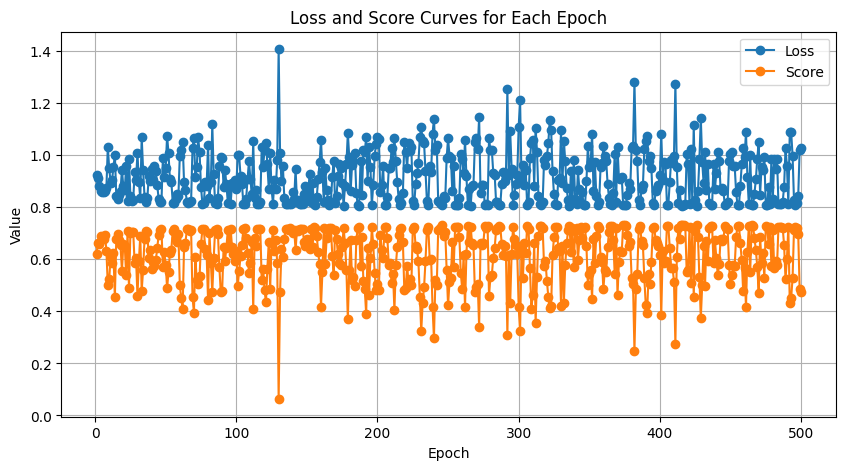

In [ ]:
# Plot the loss and score for each epoch
plt.figure(figsize=(10, 5))
plt.plot(list(range(1, CFG.epochs + 1)), loss_plot, label='Loss', marker='o')
plt.plot(list(range(1, CFG.epochs + 1)), score_plot, label='Score', marker='o')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Score Curves for Each Epoch')
plt.legend()

# Save the plot to a file
plt.grid(True)
plt.savefig(os.path.join(log_path, f'Loss_score_val_experiment - {CFG.experiment}.png'), dpi=300)

# Display the plot
plt.show()


In [ ]:
torch.cuda.empty_cache()


## Evaluation
* On 20% of the data

In [ ]:
if CFG.test:
  states = []
  folds_lst = []
  for fold in range(CFG.n_fold):
    if fold not in CFG.trn_fold:
      continue
    try:
      states.append(torch.load(os.path.join(SAVEDIR, f'{CFG.model_name}_fold{fold}_best_score.pth')))
    except:
      print(f'fold error {fold}')
      continue

  # print('states' ,states)
  # print('len(states)' , len(states))
  all_y_preds = []
  preds_all = []
  LOGGER.info(f"========== Test Models ==========")
  model= get_model(CFG.model_kwargs)
  model.to(CFG.device)
  i = 0
  targets = []
  for fold in range(CFG.n_fold):
    if fold in CFG.trn_fold:
      #val_idx = np.where(folds == fold)[0]
      #validation_signals, validation_labels =  test_signals[val_idx], test_labels[val_idx]
      test_dataset = SignalsDataset(test_signals, test_labels)

      test_loader = DataLoader(test_dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


      model.load_state_dict(states[i]['model'])
      model.eval()
      pred_lst = []

      i+=1
      for d in tqdm(test_loader, total=len(test_loader)):
          targets.extend(d[1].reshape(-1).tolist())
          inputs = d[0].to(CFG.device)
          with torch.no_grad():
            y_preds = model(torch.permute(torch.unsqueeze(inputs, 0), (1,0,2)))
          all_y_preds.append(y_preds.to('cpu'))
          preds = y_preds.argmax(1).to('cpu').numpy()
          pred_lst.append(preds)
          folds_lst.extend([fold]*inputs.shape[0])

      pred_lst = np.concatenate(pred_lst)
      preds_all.append(pred_lst)



In [ ]:

test_result_df = pd.DataFrame({"target": np.array(targets), "preds": np.concatenate(preds_all, axis=0).flatten(),"fold" : np.array(folds_lst)})
test_result_df.to_csv(os.path.join(log_path, f'test_result_df.csv'),index=False)
LOGGER.info(f"========== Test result ==========")
get_result(test_result_df)

In [ ]:
test_labels, test_preds = list(test_result_df.target), list(test_result_df.preds)

In [ ]:
label_map = {0: 'red', 1: 'yellow', 2: 'green'}

print('classification_report')
cr = classification_report(test_labels, test_preds, target_names=label_map.values(), zero_division=0)
print(cr)

print('Confusion matrix')
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=label_map.values())

# plot the confusion matrix
disp.plot()
plt.savefig(os.path.join(log_path, f'confusion_matrix_experiment - {CFG.experiment}.png'), dpi=300)

# save the classification report to a text file
with open(os.path.join(log_path, f'classification_report_experiment - {CFG.experiment}.txt'), 'w') as f:
    f.write(cr)

plt.show()


In [ ]:
#Obtain predicted probabilities
#Replace `X_test` with your test data and `y_pred_prob` with predicted probabilities from your classifier
y_pred_prob = all_y_preds
y_pred_prob = np.array([y_pred_prob[i].numpy().flatten() for i in range(len(y_pred_prob))])

#Binarize the true class labels
#test_labels, test_preds
y_true = test_labels

y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
#Compute the ROC curve and AUC for each class
n_classes = y_true_bin.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i].tolist())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot the ROC curve
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']  # Add more colors if needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')  # Plot diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class Classification')
plt.legend(loc="lower right")

plt.savefig(os.path.join(log_path,f'ROC Curve - experiment - {CFG.experiment}.png'), dpi=300)

plt.show()


In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
#print(len(SignalsDataset))